# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "8"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_NA20502_3_M_120202_4"
fastq_file_base = "ERR188380"

notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, f"{fastq_file_base}_1.fastq.gz"), os.path.join(fastqs_dir, f"{fastq_file_base}_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
if "variant_count" in fp_df.columns and "vcrs_count" not in fp_df.columns:
    fp_df = fp_df.rename(columns={"variant_count": "vcrs_count"})
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000353801:c.709G>A', 'ENST00000227157:c.292A>G', 'ENST00000344063:c.729G>A', 'ENST00000338970:c.216C>T', 'ENST00000344063:c.812G>A', 'ENST00000412585:c.163G>A', 'ENST00000343139:c.431A>C', 'ENST00000353801:c.1121A>G', 'ENST00000216254:c.142C>T', 'ENST00000292599:c.2771T>C', 'ENST00000353801:c.365A>G', 'ENST00000376255:c.1308C>T', 'ENST00000263579:c.887G>A', 'ENST00000262544:c.1991A>G', 'ENST00000354171:c.443T>A', 'ENST00000563769:c.953G>A', 'ENST00000348462:c.406C>T', 'ENST00000392132:c.1263G>T', 'ENST00000340384:c.724C>T', 'ENST00000394665:c.293G>A', 'ENST00000215071:c.795A>G', 'ENST00000391857:c.406G>A', 'ENST00000331825:c.729C>T', 'ENST00000308511:c.720A>C', 'ENST00000370867:c.693A>T', 'ENST00000257287:c.3471G>A', 'ENST00000343139:c.279C>T', 'ENST00000322536:c.1962T>C', 'ENST00000202773:c.688T>A', 'ENST00000391857:c.217C>T', 'ENST00000281589:c.1050T>A', 'ENST00000264639:c.1098G>A', 'ENST00000331825:c.444C>G', 'ENST00000333511:c.880C>T', 'ENST00000391857:c.211C>G', 'ENST00000

vcrs_count           variant_header_cds             variant_header  \
index                                                                        
128120      4943.0    ENST00000603423.1:c.87G>A   ENST00000603423:c.137G>A   
58563        568.0   ENST00000579721.1:c.112C>T   ENST00000579721:c.112C>T   
174896       313.0   ENST00000390299.2:c.177G>A   ENST00000390299:c.228G>A   
142189        50.0  ENST00000268720.5:c.1809G>A  ENST00000268720:c.1939G>A   
136646        30.0   ENST00000325823.7:c.159C>A   ENST00000325823:c.246C>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
128120  ENST00000603423             None         NaN       0.0  
58563   ENST00000579721             None         NaN       0.0  
174896  ENST00000390299  ENSG00000211653     33972.0       0.0  
142189  ENST00000268720  ENSG00000178773       621.0       0.0  
136646  ENST00000325823  ENSG00000179889      2714.0       0.0

### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        disable_summarize=True,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

vcrs_count           variant_header_cds             variant_header  \
index                                                                        
128120      4943.0    ENST00000603423.1:c.87G>A   ENST00000603423:c.137G>A   
58563        568.0   ENST00000579721.1:c.112C>T   ENST00000579721:c.112C>T   
174896       313.0   ENST00000390299.2:c.177G>A   ENST00000390299:c.228G>A   
142189        50.0  ENST00000268720.5:c.1809G>A  ENST00000268720:c.1939G>A   
136646        30.0   ENST00000325823.7:c.159C>A   ENST00000325823:c.246C>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
128120  ENST00000603423             None         NaN       0.0  
58563   ENST00000579721             None         NaN       0.0  
174896  ENST00000390299  ENSG00000211653     33972.0       0.0  
142189  ENST00000268720  ENSG00000178773       621.0       0.0  
136646  ENST00000325823  ENSG00000179889      2714.0       0.0

From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

11:04:13: Aligning to genome


11:25:29: SAM --> BAM


11:33:23: BAM sort


[bam_sort_core] merging from 30 files and 1 in-memory blocks...


11:45:33: Remove 256's


12:00:09: BAM index


12:00:47: Entering the loop


  0%|                                                                                                                                                                                  | 0/483 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                         | 1/483 [00:01<13:18,  1.66s/it]

  0%|▋                                                                                                                                                                         | 2/483 [00:03<12:41,  1.58s/it]

  1%|█                                                                                                                                                                         | 3/483 [00:03<09:14,  1.15s/it]

  1%|█▍                                                                                                                                                                        | 4/483 [00:04<07:38,  1.04it/s]

  1%|█▊                                                                                                                                                                        | 5/483 [00:05<07:24,  1.08it/s]

  1%|██                                                                                                                                                                        | 6/483 [00:06<06:41,  1.19it/s]

  1%|██▍                                                                                                                                                                       | 7/483 [00:06<06:01,  1.32it/s]

  2%|██▊                                                                                                                                                                       | 8/483 [00:07<05:33,  1.42it/s]

  2%|███▏                                                                                                                                                                      | 9/483 [00:08<05:54,  1.34it/s]

  2%|███▍                                                                                                                                                                     | 10/483 [00:08<05:33,  1.42it/s]

  2%|███▊                                                                                                                                                                     | 11/483 [00:09<05:18,  1.48it/s]

  2%|████▏                                                                                                                                                                    | 12/483 [00:10<05:27,  1.44it/s]

  3%|████▌                                                                                                                                                                    | 13/483 [00:11<07:06,  1.10it/s]

  3%|████▉                                                                                                                                                                    | 14/483 [00:12<06:29,  1.20it/s]

  3%|█████▏                                                                                                                                                                   | 15/483 [00:12<06:37,  1.18it/s]

  3%|█████▌                                                                                                                                                                   | 16/483 [00:13<06:14,  1.25it/s]

  4%|█████▉                                                                                                                                                                   | 17/483 [00:14<06:06,  1.27it/s]

  4%|██████▎                                                                                                                                                                  | 18/483 [00:15<05:49,  1.33it/s]

  4%|██████▋                                                                                                                                                                  | 19/483 [00:15<05:27,  1.42it/s]

  4%|██████▉                                                                                                                                                                  | 20/483 [00:16<05:11,  1.49it/s]

  4%|███████▎                                                                                                                                                                 | 21/483 [00:16<04:58,  1.55it/s]

  5%|███████▋                                                                                                                                                                 | 22/483 [00:17<05:06,  1.51it/s]

  5%|████████                                                                                                                                                                 | 23/483 [00:18<05:16,  1.45it/s]

  5%|████████▍                                                                                                                                                                | 24/483 [00:18<05:04,  1.51it/s]

  5%|████████▋                                                                                                                                                                | 25/483 [00:19<04:59,  1.53it/s]

  5%|█████████                                                                                                                                                                | 26/483 [00:20<04:53,  1.56it/s]

  6%|█████████▍                                                                                                                                                               | 27/483 [00:20<05:07,  1.48it/s]

  6%|█████████▊                                                                                                                                                               | 28/483 [00:21<04:53,  1.55it/s]

  6%|██████████▏                                                                                                                                                              | 29/483 [00:22<04:46,  1.58it/s]

  6%|██████████▍                                                                                                                                                              | 30/483 [00:23<06:16,  1.20it/s]

  6%|██████████▊                                                                                                                                                              | 31/483 [00:23<05:41,  1.32it/s]

  7%|███████████▏                                                                                                                                                             | 32/483 [00:24<05:31,  1.36it/s]

  7%|███████████▌                                                                                                                                                             | 33/483 [00:25<06:06,  1.23it/s]

  7%|███████████▉                                                                                                                                                             | 34/483 [00:26<05:36,  1.34it/s]

  7%|████████████▏                                                                                                                                                            | 35/483 [00:26<05:13,  1.43it/s]

  8%|████████████▉                                                                                                                                                            | 37/483 [00:27<04:17,  1.73it/s]

  8%|█████████████▎                                                                                                                                                           | 38/483 [00:28<04:38,  1.60it/s]

  8%|█████████████▋                                                                                                                                                           | 39/483 [00:29<04:50,  1.53it/s]

  8%|█████████████▉                                                                                                                                                           | 40/483 [00:29<04:49,  1.53it/s]

  8%|██████████████▎                                                                                                                                                          | 41/483 [00:30<04:56,  1.49it/s]

  9%|██████████████▋                                                                                                                                                          | 42/483 [00:31<04:53,  1.50it/s]

  9%|███████████████                                                                                                                                                          | 43/483 [00:32<06:40,  1.10it/s]

  9%|███████████████▍                                                                                                                                                         | 44/483 [00:33<06:06,  1.20it/s]

  9%|███████████████▋                                                                                                                                                         | 45/483 [00:33<05:33,  1.31it/s]

 10%|████████████████                                                                                                                                                         | 46/483 [00:34<05:17,  1.38it/s]

 10%|████████████████▊                                                                                                                                                        | 48/483 [00:35<03:52,  1.87it/s]

 10%|█████████████████▏                                                                                                                                                       | 49/483 [00:36<04:22,  1.65it/s]

 10%|█████████████████▍                                                                                                                                                       | 50/483 [00:36<04:19,  1.67it/s]

 11%|█████████████████▊                                                                                                                                                       | 51/483 [00:37<04:22,  1.65it/s]

 11%|██████████████████▏                                                                                                                                                      | 52/483 [00:37<04:19,  1.66it/s]

 11%|██████████████████▌                                                                                                                                                      | 53/483 [00:38<04:29,  1.60it/s]

 11%|██████████████████▉                                                                                                                                                      | 54/483 [00:39<04:28,  1.60it/s]

 11%|███████████████████▏                                                                                                                                                     | 55/483 [00:40<06:12,  1.15it/s]

 12%|███████████████████▌                                                                                                                                                     | 56/483 [00:41<07:15,  1.02s/it]

 12%|███████████████████▉                                                                                                                                                     | 57/483 [00:42<06:30,  1.09it/s]

 12%|████████████████████▎                                                                                                                                                    | 58/483 [00:43<06:10,  1.15it/s]

 12%|████████████████████▋                                                                                                                                                    | 59/483 [00:44<05:35,  1.26it/s]

 12%|████████████████████▉                                                                                                                                                    | 60/483 [00:44<05:05,  1.38it/s]

 13%|█████████████████████▎                                                                                                                                                   | 61/483 [00:45<04:56,  1.42it/s]

 13%|█████████████████████▋                                                                                                                                                   | 62/483 [00:45<04:40,  1.50it/s]

 13%|██████████████████████                                                                                                                                                   | 63/483 [00:46<04:40,  1.50it/s]

 13%|██████████████████████▍                                                                                                                                                  | 64/483 [00:47<04:43,  1.48it/s]

 13%|██████████████████████▋                                                                                                                                                  | 65/483 [00:48<05:56,  1.17it/s]

 14%|███████████████████████                                                                                                                                                  | 66/483 [00:49<05:24,  1.28it/s]

 14%|███████████████████████▍                                                                                                                                                 | 67/483 [00:49<05:22,  1.29it/s]

 14%|███████████████████████▊                                                                                                                                                 | 68/483 [00:50<04:59,  1.39it/s]

 14%|████████████████████████▏                                                                                                                                                | 69/483 [00:51<05:02,  1.37it/s]

 14%|████████████████████████▍                                                                                                                                                | 70/483 [00:52<05:57,  1.16it/s]

 15%|████████████████████████▊                                                                                                                                                | 71/483 [00:53<05:30,  1.25it/s]

 15%|█████████████████████████▏                                                                                                                                               | 72/483 [00:53<05:01,  1.36it/s]

 15%|█████████████████████████▌                                                                                                                                               | 73/483 [00:54<04:52,  1.40it/s]

 15%|█████████████████████████▉                                                                                                                                               | 74/483 [00:55<05:56,  1.15it/s]

 16%|██████████████████████████▏                                                                                                                                              | 75/483 [00:56<05:23,  1.26it/s]

 16%|██████████████████████████▌                                                                                                                                              | 76/483 [00:57<06:09,  1.10it/s]

 16%|██████████████████████████▉                                                                                                                                              | 77/483 [00:58<07:07,  1.05s/it]

 16%|███████████████████████████▎                                                                                                                                             | 78/483 [00:59<06:11,  1.09it/s]

 16%|███████████████████████████▋                                                                                                                                             | 79/483 [00:59<05:40,  1.19it/s]

 17%|███████████████████████████▉                                                                                                                                             | 80/483 [01:00<05:18,  1.27it/s]

 17%|████████████████████████████▎                                                                                                                                            | 81/483 [01:02<06:34,  1.02it/s]

 17%|████████████████████████████▋                                                                                                                                            | 82/483 [01:03<06:40,  1.00it/s]

 17%|█████████████████████████████                                                                                                                                            | 83/483 [01:03<06:02,  1.10it/s]

 17%|█████████████████████████████▍                                                                                                                                           | 84/483 [01:04<05:28,  1.22it/s]

 18%|█████████████████████████████▋                                                                                                                                           | 85/483 [01:05<05:17,  1.25it/s]

 18%|██████████████████████████████                                                                                                                                           | 86/483 [01:05<04:56,  1.34it/s]

 18%|██████████████████████████████▍                                                                                                                                          | 87/483 [01:06<04:34,  1.44it/s]

 18%|██████████████████████████████▊                                                                                                                                          | 88/483 [01:06<04:25,  1.49it/s]

 18%|███████████████████████████████▏                                                                                                                                         | 89/483 [01:07<04:34,  1.44it/s]

 19%|███████████████████████████████▍                                                                                                                                         | 90/483 [01:08<04:32,  1.44it/s]

 19%|███████████████████████████████▊                                                                                                                                         | 91/483 [01:08<04:18,  1.52it/s]

 19%|████████████████████████████████▏                                                                                                                                        | 92/483 [01:09<04:06,  1.58it/s]

 19%|████████████████████████████████▌                                                                                                                                        | 93/483 [01:10<04:07,  1.58it/s]

 19%|████████████████████████████████▉                                                                                                                                        | 94/483 [01:10<04:04,  1.59it/s]

 20%|█████████████████████████████████▏                                                                                                                                       | 95/483 [01:11<04:15,  1.52it/s]

 20%|█████████████████████████████████▌                                                                                                                                       | 96/483 [01:12<04:06,  1.57it/s]

 20%|█████████████████████████████████▉                                                                                                                                       | 97/483 [01:12<04:00,  1.61it/s]

 20%|██████████████████████████████████▎                                                                                                                                      | 98/483 [01:13<03:57,  1.62it/s]

 20%|██████████████████████████████████▋                                                                                                                                      | 99/483 [01:13<03:55,  1.63it/s]

 21%|██████████████████████████████████▊                                                                                                                                     | 100/483 [01:14<04:13,  1.51it/s]

 21%|███████████████████████████████████▏                                                                                                                                    | 101/483 [01:15<04:02,  1.57it/s]

 21%|███████████████████████████████████▍                                                                                                                                    | 102/483 [01:15<03:58,  1.60it/s]

 21%|███████████████████████████████████▊                                                                                                                                    | 103/483 [01:16<03:51,  1.64it/s]

 22%|████████████████████████████████████▏                                                                                                                                   | 104/483 [01:17<03:55,  1.61it/s]

 22%|████████████████████████████████████▌                                                                                                                                   | 105/483 [01:17<04:01,  1.57it/s]

 22%|████████████████████████████████████▊                                                                                                                                   | 106/483 [01:18<03:54,  1.61it/s]

 22%|█████████████████████████████████████▏                                                                                                                                  | 107/483 [01:19<04:08,  1.51it/s]

 22%|█████████████████████████████████████▌                                                                                                                                  | 108/483 [01:19<04:17,  1.46it/s]

 23%|█████████████████████████████████████▉                                                                                                                                  | 109/483 [01:20<04:09,  1.50it/s]

 23%|██████████████████████████████████████▎                                                                                                                                 | 110/483 [01:21<04:03,  1.53it/s]

 23%|██████████████████████████████████████▌                                                                                                                                 | 111/483 [01:21<03:58,  1.56it/s]

 23%|██████████████████████████████████████▉                                                                                                                                 | 112/483 [01:22<03:55,  1.57it/s]

 23%|███████████████████████████████████████▎                                                                                                                                | 113/483 [01:23<04:05,  1.50it/s]

 24%|███████████████████████████████████████▋                                                                                                                                | 114/483 [01:23<04:05,  1.50it/s]

 24%|████████████████████████████████████████                                                                                                                                | 115/483 [01:24<04:25,  1.38it/s]

 24%|████████████████████████████████████████▎                                                                                                                               | 116/483 [01:25<04:12,  1.46it/s]

 24%|████████████████████████████████████████▋                                                                                                                               | 117/483 [01:25<04:06,  1.48it/s]

 24%|█████████████████████████████████████████                                                                                                                               | 118/483 [01:26<03:55,  1.55it/s]

 25%|█████████████████████████████████████████▍                                                                                                                              | 119/483 [01:27<03:56,  1.54it/s]

 25%|█████████████████████████████████████████▋                                                                                                                              | 120/483 [01:27<03:55,  1.54it/s]

 25%|██████████████████████████████████████████                                                                                                                              | 121/483 [01:28<04:52,  1.24it/s]

 25%|██████████████████████████████████████████▍                                                                                                                             | 122/483 [01:29<04:31,  1.33it/s]

 25%|██████████████████████████████████████████▊                                                                                                                             | 123/483 [01:30<04:21,  1.38it/s]

 26%|███████████████████████████████████████████▏                                                                                                                            | 124/483 [01:30<04:07,  1.45it/s]

 26%|███████████████████████████████████████████▍                                                                                                                            | 125/483 [01:31<04:25,  1.35it/s]

 26%|███████████████████████████████████████████▊                                                                                                                            | 126/483 [01:32<04:09,  1.43it/s]

 26%|████████████████████████████████████████████▏                                                                                                                           | 127/483 [01:32<03:55,  1.51it/s]

 27%|████████████████████████████████████████████▌                                                                                                                           | 128/483 [01:33<04:22,  1.35it/s]

 27%|████████████████████████████████████████████▊                                                                                                                           | 129/483 [01:34<04:08,  1.43it/s]

 27%|█████████████████████████████████████████████▏                                                                                                                          | 130/483 [01:34<04:02,  1.46it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                          | 131/483 [01:35<04:01,  1.46it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                          | 132/483 [01:36<03:58,  1.47it/s]

 28%|██████████████████████████████████████████████▎                                                                                                                         | 133/483 [01:36<03:52,  1.51it/s]

 28%|██████████████████████████████████████████████▌                                                                                                                         | 134/483 [01:37<03:49,  1.52it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                         | 135/483 [01:38<03:43,  1.56it/s]

 28%|███████████████████████████████████████████████▎                                                                                                                        | 136/483 [01:38<03:39,  1.58it/s]

 28%|███████████████████████████████████████████████▋                                                                                                                        | 137/483 [01:39<03:37,  1.59it/s]

 29%|████████████████████████████████████████████████                                                                                                                        | 138/483 [01:40<03:34,  1.61it/s]

 29%|████████████████████████████████████████████████▎                                                                                                                       | 139/483 [01:40<03:36,  1.59it/s]

 29%|████████████████████████████████████████████████▋                                                                                                                       | 140/483 [01:41<03:38,  1.57it/s]

 29%|█████████████████████████████████████████████████                                                                                                                       | 141/483 [01:41<03:38,  1.57it/s]

 29%|█████████████████████████████████████████████████▍                                                                                                                      | 142/483 [01:43<04:40,  1.22it/s]

 30%|█████████████████████████████████████████████████▋                                                                                                                      | 143/483 [01:43<04:16,  1.32it/s]

 30%|██████████████████████████████████████████████████                                                                                                                      | 144/483 [01:44<04:03,  1.39it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                     | 145/483 [01:45<03:58,  1.42it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                     | 146/483 [01:45<04:06,  1.37it/s]

 30%|███████████████████████████████████████████████████▏                                                                                                                    | 147/483 [01:46<03:51,  1.45it/s]

 31%|███████████████████████████████████████████████████▍                                                                                                                    | 148/483 [01:47<03:43,  1.50it/s]

 31%|███████████████████████████████████████████████████▊                                                                                                                    | 149/483 [01:47<03:46,  1.47it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                   | 150/483 [01:48<03:41,  1.51it/s]

 31%|████████████████████████████████████████████████████▌                                                                                                                   | 151/483 [01:49<03:37,  1.53it/s]

 31%|████████████████████████████████████████████████████▊                                                                                                                   | 152/483 [01:49<03:40,  1.50it/s]

 32%|█████████████████████████████████████████████████████▏                                                                                                                  | 153/483 [01:50<03:38,  1.51it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                  | 154/483 [01:51<03:30,  1.56it/s]

 32%|█████████████████████████████████████████████████████▉                                                                                                                  | 155/483 [01:51<03:26,  1.59it/s]

 32%|██████████████████████████████████████████████████████▎                                                                                                                 | 156/483 [01:52<03:24,  1.60it/s]

 33%|██████████████████████████████████████████████████████▌                                                                                                                 | 157/483 [01:53<04:42,  1.15it/s]

 33%|██████████████████████████████████████████████████████▉                                                                                                                 | 158/483 [01:54<04:54,  1.10it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                                | 159/483 [01:55<04:27,  1.21it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                | 160/483 [01:55<04:08,  1.30it/s]

 33%|████████████████████████████████████████████████████████                                                                                                                | 161/483 [01:56<04:00,  1.34it/s]

 34%|████████████████████████████████████████████████████████▎                                                                                                               | 162/483 [01:57<03:45,  1.42it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                               | 163/483 [01:57<03:43,  1.43it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                               | 164/483 [01:58<03:33,  1.50it/s]

 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 165/483 [01:59<03:24,  1.56it/s]

 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 166/483 [01:59<03:20,  1.58it/s]

 35%|██████████████████████████████████████████████████████████                                                                                                              | 167/483 [02:00<03:15,  1.62it/s]

 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 168/483 [02:01<03:20,  1.57it/s]

 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 169/483 [02:02<05:04,  1.03it/s]

 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 170/483 [02:04<05:43,  1.10s/it]

 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 171/483 [02:04<05:01,  1.04it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 172/483 [02:05<04:38,  1.12it/s]

 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 173/483 [02:06<04:15,  1.21it/s]

 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 174/483 [02:06<04:07,  1.25it/s]

 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 175/483 [02:07<03:50,  1.34it/s]

 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 176/483 [02:08<03:36,  1.42it/s]

 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 177/483 [02:08<03:36,  1.41it/s]

 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 178/483 [02:09<03:26,  1.48it/s]

 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 179/483 [02:10<03:39,  1.38it/s]

 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 180/483 [02:10<03:32,  1.43it/s]

 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 181/483 [02:11<03:20,  1.51it/s]

 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 182/483 [02:12<03:14,  1.55it/s]

 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 183/483 [02:12<03:10,  1.57it/s]

 38%|████████████████████████████████████████████████████████████████                                                                                                        | 184/483 [02:14<04:15,  1.17it/s]

 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 185/483 [02:15<04:17,  1.16it/s]

 39%|████████████████████████████████████████████████████████████████▋                                                                                                       | 186/483 [02:15<03:51,  1.28it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 187/483 [02:16<03:54,  1.26it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 188/483 [02:17<03:35,  1.37it/s]

 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 189/483 [02:18<04:20,  1.13it/s]

 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 190/483 [02:18<03:56,  1.24it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 191/483 [02:19<03:35,  1.36it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 192/483 [02:20<03:48,  1.27it/s]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 193/483 [02:21<04:06,  1.18it/s]

 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 194/483 [02:22<04:30,  1.07it/s]

 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 196/483 [02:23<03:05,  1.54it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 197/483 [02:23<03:00,  1.58it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 198/483 [02:24<03:08,  1.51it/s]

 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 199/483 [02:25<03:00,  1.57it/s]

 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 200/483 [02:25<03:00,  1.57it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 201/483 [02:26<02:56,  1.60it/s]

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 202/483 [02:26<02:52,  1.63it/s]

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 203/483 [02:27<02:53,  1.62it/s]

 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 204/483 [02:28<02:55,  1.59it/s]

 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 205/483 [02:28<03:00,  1.54it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 206/483 [02:29<02:55,  1.58it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 207/483 [02:29<02:49,  1.63it/s]

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 208/483 [02:30<02:47,  1.64it/s]

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 209/483 [02:31<02:47,  1.64it/s]

 43%|█████████████████████████████████████████████████████████████████████████                                                                                               | 210/483 [02:31<02:48,  1.62it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 211/483 [02:32<02:50,  1.59it/s]

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 212/483 [02:33<02:50,  1.59it/s]

 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 213/483 [02:33<02:51,  1.57it/s]

 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 214/483 [02:34<02:49,  1.59it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 215/483 [02:34<02:44,  1.63it/s]

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 216/483 [02:35<02:42,  1.64it/s]

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 217/483 [02:36<02:40,  1.65it/s]

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 218/483 [02:36<02:45,  1.60it/s]

 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 219/483 [02:37<02:46,  1.59it/s]

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 220/483 [02:38<02:45,  1.59it/s]

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 221/483 [02:38<02:44,  1.59it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 222/483 [02:39<02:44,  1.59it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 223/483 [02:39<02:42,  1.60it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 224/483 [02:40<02:42,  1.59it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 225/483 [02:41<02:41,  1.60it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 226/483 [02:41<02:41,  1.59it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 227/483 [02:42<02:41,  1.59it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 228/483 [02:43<02:40,  1.59it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 229/483 [02:43<02:37,  1.61it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 230/483 [02:44<02:38,  1.60it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 231/483 [02:44<02:36,  1.61it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 232/483 [02:46<03:33,  1.18it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 233/483 [02:47<03:17,  1.26it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 234/483 [02:47<03:03,  1.36it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 235/483 [02:48<02:51,  1.45it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 236/483 [02:48<02:44,  1.51it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 237/483 [02:49<02:40,  1.53it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 238/483 [02:50<02:52,  1.42it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 239/483 [02:50<02:44,  1.48it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 240/483 [02:51<02:36,  1.55it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 241/483 [02:52<02:53,  1.40it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 242/483 [02:52<02:42,  1.48it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 243/483 [02:53<02:35,  1.55it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 244/483 [02:54<02:31,  1.58it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 245/483 [02:54<02:30,  1.58it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 246/483 [02:55<02:25,  1.62it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 247/483 [02:55<02:26,  1.61it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 248/483 [02:56<02:24,  1.63it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 249/483 [02:57<02:21,  1.66it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 250/483 [02:57<02:20,  1.66it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 251/483 [02:58<02:19,  1.67it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 252/483 [02:59<02:31,  1.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 253/483 [03:01<04:23,  1.15s/it]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 254/483 [03:02<04:27,  1.17s/it]

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 255/483 [03:03<03:48,  1.00s/it]

 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 256/483 [03:03<03:19,  1.14it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 257/483 [03:04<03:00,  1.25it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 258/483 [03:04<02:46,  1.35it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 259/483 [03:05<02:34,  1.45it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 260/483 [03:06<02:27,  1.51it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 261/483 [03:06<02:22,  1.56it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 262/483 [03:07<02:19,  1.58it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 263/483 [03:08<02:31,  1.45it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 264/483 [03:08<02:26,  1.50it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 265/483 [03:09<02:24,  1.51it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 266/483 [03:10<02:18,  1.57it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 267/483 [03:10<02:14,  1.61it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 268/483 [03:11<02:13,  1.61it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 269/483 [03:11<02:11,  1.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 270/483 [03:13<02:50,  1.25it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 271/483 [03:13<02:37,  1.35it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 272/483 [03:14<02:28,  1.42it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 273/483 [03:14<02:22,  1.48it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 274/483 [03:15<02:24,  1.45it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 275/483 [03:16<02:19,  1.49it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 276/483 [03:16<02:15,  1.53it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 277/483 [03:17<02:33,  1.35it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 278/483 [03:18<02:26,  1.40it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 279/483 [03:19<02:19,  1.46it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 280/483 [03:19<02:15,  1.50it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 281/483 [03:20<02:10,  1.54it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 282/483 [03:20<02:06,  1.59it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 283/483 [03:21<02:15,  1.47it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 284/483 [03:22<02:10,  1.53it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 285/483 [03:23<02:44,  1.21it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 286/483 [03:24<02:30,  1.31it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 287/483 [03:24<02:19,  1.40it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 288/483 [03:25<02:11,  1.48it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 289/483 [03:25<02:07,  1.52it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 290/483 [03:26<02:05,  1.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 291/483 [03:27<02:03,  1.56it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 292/483 [03:27<02:03,  1.55it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 293/483 [03:28<02:13,  1.42it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 294/483 [03:29<02:07,  1.48it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 295/483 [03:29<02:01,  1.55it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 296/483 [03:30<01:59,  1.56it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 297/483 [03:31<02:27,  1.26it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 298/483 [03:32<02:15,  1.37it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 299/483 [03:32<02:07,  1.45it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 300/483 [03:33<02:01,  1.50it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 301/483 [03:34<01:58,  1.54it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 302/483 [03:34<01:55,  1.57it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 303/483 [03:35<01:52,  1.60it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 304/483 [03:35<01:49,  1.63it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 305/483 [03:36<01:48,  1.64it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 306/483 [03:37<01:50,  1.60it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 307/483 [03:37<01:52,  1.56it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 308/483 [03:39<02:27,  1.19it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 309/483 [03:39<02:16,  1.27it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 310/483 [03:40<02:05,  1.38it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 311/483 [03:40<01:59,  1.44it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 312/483 [03:41<01:57,  1.45it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 313/483 [03:42<01:54,  1.48it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 314/483 [03:42<01:51,  1.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 315/483 [03:43<01:49,  1.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 316/483 [03:44<02:17,  1.22it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 317/483 [03:45<02:04,  1.33it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 318/483 [03:46<02:05,  1.32it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 319/483 [03:46<01:58,  1.38it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 320/483 [03:47<01:54,  1.43it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 321/483 [03:48<01:49,  1.48it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 322/483 [03:48<01:48,  1.48it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 323/483 [03:49<01:51,  1.44it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 324/483 [03:50<01:47,  1.48it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 325/483 [03:50<01:51,  1.42it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 326/483 [03:51<01:46,  1.48it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 327/483 [03:52<01:41,  1.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 328/483 [03:52<01:54,  1.36it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 329/483 [03:53<01:45,  1.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 330/483 [03:54<01:41,  1.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 331/483 [03:54<01:38,  1.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 332/483 [03:56<02:07,  1.18it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 333/483 [03:57<02:36,  1.04s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 334/483 [03:58<02:43,  1.09s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 335/483 [03:59<02:24,  1.03it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 336/483 [04:00<02:06,  1.16it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 337/483 [04:00<01:55,  1.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 338/483 [04:01<01:52,  1.29it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 339/483 [04:02<01:59,  1.21it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 340/483 [04:03<01:49,  1.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 341/483 [04:03<01:48,  1.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 342/483 [04:04<01:44,  1.35it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 343/483 [04:05<01:41,  1.38it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 344/483 [04:05<01:37,  1.43it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 345/483 [04:06<01:35,  1.44it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 346/483 [04:07<01:43,  1.32it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 347/483 [04:08<01:41,  1.34it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 348/483 [04:08<01:34,  1.43it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 349/483 [04:09<01:29,  1.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 350/483 [04:09<01:27,  1.51it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 351/483 [04:10<01:24,  1.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 352/483 [04:11<01:22,  1.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 353/483 [04:12<01:35,  1.36it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 354/483 [04:12<01:32,  1.39it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 355/483 [04:13<01:28,  1.44it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 356/483 [04:14<01:24,  1.50it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 357/483 [04:14<01:20,  1.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 358/483 [04:15<01:18,  1.60it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 359/483 [04:15<01:17,  1.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 360/483 [04:16<01:16,  1.61it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 361/483 [04:17<01:16,  1.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 362/483 [04:17<01:16,  1.59it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 363/483 [04:18<01:17,  1.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 364/483 [04:19<01:17,  1.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 365/483 [04:19<01:14,  1.58it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 366/483 [04:20<01:21,  1.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 367/483 [04:21<01:23,  1.39it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 368/483 [04:21<01:19,  1.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 369/483 [04:22<01:23,  1.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 370/483 [04:23<01:19,  1.42it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 371/483 [04:24<01:21,  1.38it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 372/483 [04:24<01:15,  1.47it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 373/483 [04:25<01:13,  1.50it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 374/483 [04:26<01:18,  1.39it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 375/483 [04:26<01:14,  1.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 376/483 [04:27<01:12,  1.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 377/483 [04:28<01:10,  1.51it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 378/483 [04:28<01:09,  1.52it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 379/483 [04:29<01:06,  1.57it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 380/483 [04:29<01:04,  1.59it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 381/483 [04:30<01:02,  1.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 382/483 [04:31<01:01,  1.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 383/483 [04:31<01:01,  1.63it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 384/483 [04:32<00:59,  1.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 385/483 [04:32<00:58,  1.67it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 386/483 [04:33<01:00,  1.60it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 387/483 [04:34<00:59,  1.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 388/483 [04:34<00:58,  1.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 389/483 [04:35<00:58,  1.60it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 390/483 [04:36<00:59,  1.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 391/483 [04:36<01:03,  1.44it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 392/483 [04:37<01:01,  1.49it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 393/483 [04:38<00:57,  1.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 394/483 [04:39<01:13,  1.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 395/483 [04:40<01:25,  1.02it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 396/483 [04:41<01:17,  1.13it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 397/483 [04:42<01:25,  1.00it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 398/483 [04:43<01:30,  1.07s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 399/483 [04:44<01:18,  1.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 400/483 [04:45<01:09,  1.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 401/483 [04:45<01:02,  1.31it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 402/483 [04:46<00:57,  1.41it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 403/483 [04:46<00:54,  1.46it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 404/483 [04:47<00:52,  1.50it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 405/483 [04:48<00:50,  1.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 406/483 [04:48<00:48,  1.59it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 407/483 [04:49<00:47,  1.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 408/483 [04:50<00:54,  1.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 409/483 [04:50<00:52,  1.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 410/483 [04:51<00:49,  1.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 411/483 [04:52<00:47,  1.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 412/483 [04:52<00:45,  1.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 413/483 [04:53<00:44,  1.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 414/483 [04:53<00:42,  1.61it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 415/483 [04:54<00:46,  1.47it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 416/483 [04:55<00:49,  1.36it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 417/483 [04:56<00:45,  1.45it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 418/483 [04:56<00:43,  1.51it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 419/483 [04:57<00:40,  1.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 420/483 [04:58<00:39,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 421/483 [04:58<00:37,  1.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 422/483 [04:59<00:37,  1.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 423/483 [04:59<00:37,  1.61it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 424/483 [05:00<00:37,  1.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 425/483 [05:01<00:35,  1.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 426/483 [05:01<00:34,  1.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 427/483 [05:02<00:34,  1.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 428/483 [05:02<00:33,  1.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 429/483 [05:03<00:33,  1.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 430/483 [05:04<00:36,  1.46it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 431/483 [05:04<00:33,  1.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 432/483 [05:05<00:32,  1.58it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 433/483 [05:06<00:32,  1.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 434/483 [05:06<00:30,  1.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 435/483 [05:08<00:39,  1.21it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 436/483 [05:09<00:44,  1.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 437/483 [05:10<00:47,  1.03s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 438/483 [05:11<00:40,  1.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 439/483 [05:11<00:36,  1.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 440/483 [05:12<00:32,  1.33it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 441/483 [05:12<00:29,  1.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 442/483 [05:13<00:27,  1.49it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 443/483 [05:14<00:26,  1.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 444/483 [05:14<00:24,  1.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 445/483 [05:15<00:23,  1.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 446/483 [05:15<00:22,  1.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 447/483 [05:16<00:21,  1.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 448/483 [05:17<00:21,  1.62it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 449/483 [05:17<00:20,  1.66it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 450/483 [05:18<00:22,  1.45it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 451/483 [05:19<00:27,  1.18it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 452/483 [05:20<00:24,  1.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 453/483 [05:21<00:23,  1.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 454/483 [05:22<00:22,  1.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 455/483 [05:22<00:21,  1.31it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 456/483 [05:23<00:22,  1.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 457/483 [05:24<00:20,  1.25it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 458/483 [05:25<00:19,  1.31it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 459/483 [05:25<00:18,  1.30it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 460/483 [05:26<00:16,  1.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 461/483 [05:27<00:15,  1.40it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 462/483 [05:27<00:14,  1.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 463/483 [05:28<00:13,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 464/483 [05:29<00:12,  1.49it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 465/483 [05:29<00:12,  1.50it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 466/483 [05:30<00:11,  1.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 467/483 [05:31<00:10,  1.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 468/483 [05:31<00:09,  1.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 469/483 [05:32<00:08,  1.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 470/483 [05:32<00:08,  1.60it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 471/483 [05:33<00:07,  1.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 472/483 [05:34<00:06,  1.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 473/483 [05:34<00:06,  1.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 474/483 [05:35<00:05,  1.58it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 475/483 [05:36<00:05,  1.59it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 476/483 [05:36<00:04,  1.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 477/483 [05:37<00:04,  1.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 478/483 [05:38<00:03,  1.37it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 479/483 [05:39<00:03,  1.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 480/483 [05:40<00:02,  1.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 481/483 [05:41<00:01,  1.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 482/483 [05:42<00:00,  1.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [05:43<00:00,  1.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [05:43<00:00,  1.41it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 216
Number of false variants: 262
Number of undetermined variants: 2
True variants list: ['ENST00000603423:c.137G>A', 'ENST00000579721:c.112C>T', 'ENST00000390299:c.228G>A', 'ENST00000268720:c.1939G>A', 'ENST00000325823:c.246C>A', 'ENST00000390321:c.143C>T', 'ENST00000331789:c.1209G>C', 'ENST00000360830:c.196A>G', 'ENST00000374550:c.412A>G', 'ENST00000390299:c.334G>A', 'ENST00000563769:c.953G>A', 'ENST00000390321:c.62C>T', 'ENST00000368567:c.58T>C', 'ENST00000339647:c.2562C>T', 'ENST00000301821:c.880G>T', 'ENST00000339647:c.1158C>T', 'ENST00000272317:c.538A>C', 'ENST00000390299:c.88C>T', 'ENST00000338970:c.107C>T', 'ENST00000338110:c.1510C>T', 'ENST00000301072:c.488A>G', 'ENST00000330752:c.564T>G', 'ENST00000274065:c.104C>T', 'ENST00000412585:c.346G>T', 'ENST00000264258:c.649C>T', 'ENST00000374550:c.71A>G', 'ENST00000374550:c.336C>G', 'ENST00000202773:c.688T>A', 'ENST00000374550:c.384C>T', 'ENST00000339647:c.1329A>G', 'ENST00000321153:c.478C>G', 'ENST0000060404

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/detailed_out_modified_bam.txt


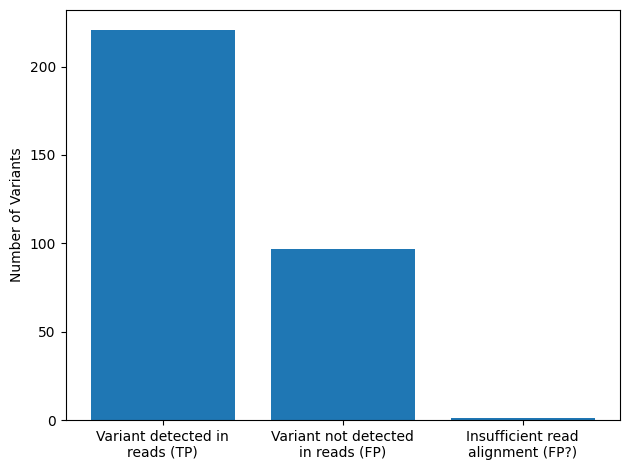

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"))

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

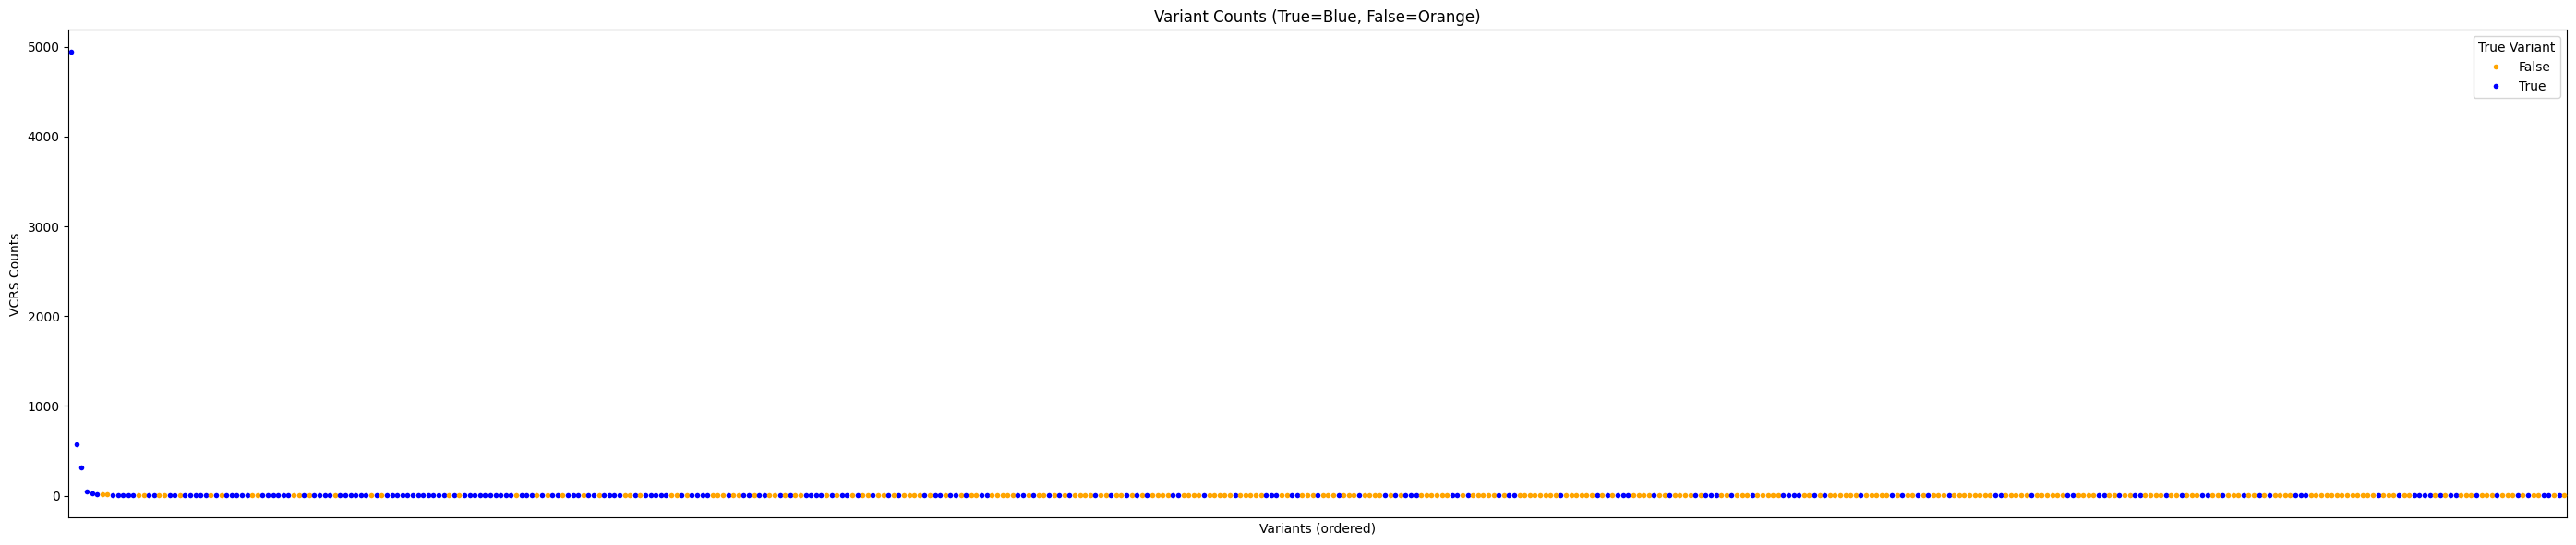

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

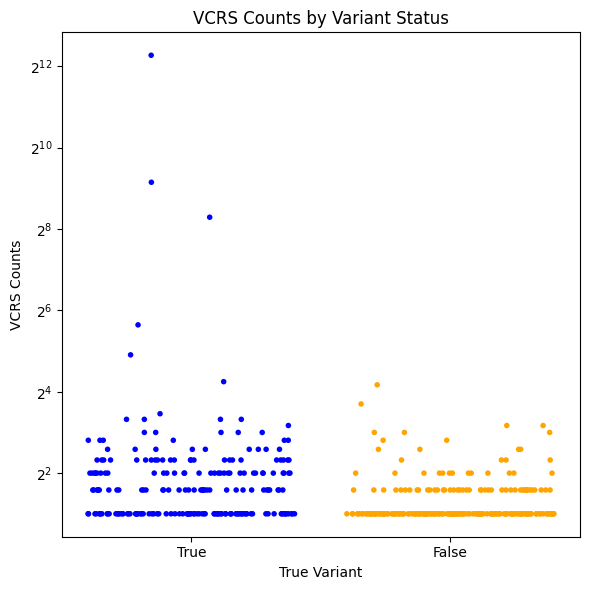

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('True Variant')
plt.ylabel('VCRS Counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('VCRS Counts by Variant Status')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: {'ENSG00000174444', 'ENSG00000137818', 'ENSG00000142541', 'ENSG00000181163', 'ENSG00000108107', 'ENSG00000145425', 'ENSG00000065978', 'ENST00000608106', 'ENSG00000177600'}


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

dbsnp_id    transcript_ID variant_cdna strand  \
0    rs3829740  ENST00000379407    c.1385G>C      +   
1   rs74735644  ENST00000325425    c.1242C>T      +   
2  rs202243019  ENST00000339381     c.369A>G      +   
3    rs9793256  ENST00000378785    c.1167G>A      +   
4    rs1781147  ENST00000378785    c.1409C>T      +   

                 header_cdna  is_false_negative vcrs_id  
0  ENST00000379407:c.1385G>C               True  vcrs_0  
1  ENST00000325425:c.1242C>T               True  vcrs_1  
2   ENST00000339381:c.369A>G               True  vcrs_2  
3  ENST00000378785:c.1167G>A               True  vcrs_3  
4  ENST00000378785:c.1409C>T               True  vcrs_4

In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:06:45: Entering the loop


  0%|                                                                                                                                                                                 | 0/3024 [00:00<?, ?it/s]

  0%|                                                                                                                                                                         | 1/3024 [00:00<49:34,  1.02it/s]

  0%|                                                                                                                                                                         | 2/3024 [00:01<37:26,  1.35it/s]

  0%|▏                                                                                                                                                                        | 3/3024 [00:02<33:42,  1.49it/s]

  0%|▏                                                                                                                                                                        | 4/3024 [00:02<32:00,  1.57it/s]

  0%|▎                                                                                                                                                                        | 5/3024 [00:03<31:34,  1.59it/s]

  0%|▎                                                                                                                                                                        | 6/3024 [00:03<30:26,  1.65it/s]

  0%|▍                                                                                                                                                                        | 7/3024 [00:04<31:29,  1.60it/s]

  0%|▍                                                                                                                                                                        | 8/3024 [00:05<31:32,  1.59it/s]

  0%|▌                                                                                                                                                                        | 9/3024 [00:05<31:42,  1.58it/s]

  0%|▌                                                                                                                                                                       | 10/3024 [00:06<30:46,  1.63it/s]

  0%|▌                                                                                                                                                                       | 11/3024 [00:06<30:00,  1.67it/s]

  0%|▋                                                                                                                                                                       | 12/3024 [00:07<29:29,  1.70it/s]

  0%|▋                                                                                                                                                                       | 13/3024 [00:08<29:23,  1.71it/s]

  0%|▊                                                                                                                                                                       | 14/3024 [00:08<29:03,  1.73it/s]

  0%|▊                                                                                                                                                                       | 15/3024 [00:09<29:14,  1.72it/s]

  1%|▉                                                                                                                                                                       | 16/3024 [00:09<29:12,  1.72it/s]

  1%|▉                                                                                                                                                                       | 17/3024 [00:10<28:53,  1.73it/s]

  1%|█                                                                                                                                                                       | 18/3024 [00:11<28:59,  1.73it/s]

  1%|█                                                                                                                                                                       | 19/3024 [00:11<28:54,  1.73it/s]

  1%|█                                                                                                                                                                       | 20/3024 [00:12<28:37,  1.75it/s]

  1%|█▏                                                                                                                                                                      | 21/3024 [00:12<28:25,  1.76it/s]

  1%|█▏                                                                                                                                                                      | 22/3024 [00:13<28:35,  1.75it/s]

  1%|█▎                                                                                                                                                                      | 23/3024 [00:13<28:49,  1.73it/s]

  1%|█▎                                                                                                                                                                      | 24/3024 [00:14<29:15,  1.71it/s]

  1%|█▍                                                                                                                                                                      | 25/3024 [00:15<30:37,  1.63it/s]

  1%|█▍                                                                                                                                                                      | 26/3024 [00:15<29:52,  1.67it/s]

  1%|█▌                                                                                                                                                                      | 27/3024 [00:16<29:22,  1.70it/s]

  1%|█▌                                                                                                                                                                      | 28/3024 [00:16<28:56,  1.73it/s]

  1%|█▌                                                                                                                                                                      | 29/3024 [00:17<28:37,  1.74it/s]

  1%|█▋                                                                                                                                                                      | 30/3024 [00:17<28:29,  1.75it/s]

  1%|█▋                                                                                                                                                                      | 31/3024 [00:18<28:16,  1.76it/s]

  1%|█▊                                                                                                                                                                      | 32/3024 [00:19<28:08,  1.77it/s]

  1%|█▊                                                                                                                                                                      | 33/3024 [00:19<28:03,  1.78it/s]

  1%|█▉                                                                                                                                                                      | 34/3024 [00:20<28:14,  1.76it/s]

  1%|█▉                                                                                                                                                                      | 35/3024 [00:20<28:53,  1.72it/s]

  1%|██                                                                                                                                                                      | 36/3024 [00:21<33:06,  1.50it/s]

  1%|██                                                                                                                                                                      | 37/3024 [00:22<32:05,  1.55it/s]

  1%|██                                                                                                                                                                      | 38/3024 [00:22<30:49,  1.61it/s]

  1%|██▏                                                                                                                                                                     | 39/3024 [00:23<30:44,  1.62it/s]

  1%|██▏                                                                                                                                                                     | 40/3024 [00:24<30:55,  1.61it/s]

  1%|██▎                                                                                                                                                                     | 41/3024 [00:24<30:00,  1.66it/s]

  1%|██▎                                                                                                                                                                     | 42/3024 [00:25<29:20,  1.69it/s]

  1%|██▍                                                                                                                                                                     | 43/3024 [00:25<28:50,  1.72it/s]

  1%|██▍                                                                                                                                                                     | 44/3024 [00:26<28:31,  1.74it/s]

  1%|██▌                                                                                                                                                                     | 45/3024 [00:26<28:15,  1.76it/s]

  2%|██▌                                                                                                                                                                     | 46/3024 [00:27<28:04,  1.77it/s]

  2%|██▌                                                                                                                                                                     | 47/3024 [00:28<28:14,  1.76it/s]

  2%|██▋                                                                                                                                                                     | 48/3024 [00:28<28:44,  1.73it/s]

  2%|██▋                                                                                                                                                                     | 49/3024 [00:29<28:28,  1.74it/s]

  2%|██▊                                                                                                                                                                     | 50/3024 [00:29<28:18,  1.75it/s]

  2%|██▊                                                                                                                                                                     | 51/3024 [00:30<28:08,  1.76it/s]

  2%|██▉                                                                                                                                                                     | 52/3024 [00:30<28:12,  1.76it/s]

  2%|██▉                                                                                                                                                                     | 53/3024 [00:31<28:08,  1.76it/s]

  2%|███                                                                                                                                                                     | 54/3024 [00:32<28:26,  1.74it/s]

  2%|███                                                                                                                                                                     | 55/3024 [00:32<28:34,  1.73it/s]

  2%|███                                                                                                                                                                     | 56/3024 [00:33<28:24,  1.74it/s]

  2%|███▏                                                                                                                                                                    | 57/3024 [00:33<28:09,  1.76it/s]

  2%|███▏                                                                                                                                                                    | 58/3024 [00:34<29:20,  1.69it/s]

  2%|███▎                                                                                                                                                                    | 60/3024 [00:34<22:32,  2.19it/s]

  2%|███▍                                                                                                                                                                    | 61/3024 [00:35<24:41,  2.00it/s]

  2%|███▍                                                                                                                                                                    | 62/3024 [00:36<25:38,  1.92it/s]

  2%|███▌                                                                                                                                                                    | 63/3024 [00:36<26:09,  1.89it/s]

  2%|███▌                                                                                                                                                                    | 64/3024 [00:37<34:39,  1.42it/s]

  2%|███▋                                                                                                                                                                    | 66/3024 [00:38<25:23,  1.94it/s]

  2%|███▋                                                                                                                                                                    | 67/3024 [00:39<26:14,  1.88it/s]

  2%|███▊                                                                                                                                                                    | 68/3024 [00:39<26:36,  1.85it/s]

  2%|███▊                                                                                                                                                                    | 69/3024 [00:40<26:52,  1.83it/s]

  2%|███▉                                                                                                                                                                    | 70/3024 [00:40<27:05,  1.82it/s]

  2%|███▉                                                                                                                                                                    | 71/3024 [00:41<27:20,  1.80it/s]

  2%|████                                                                                                                                                                    | 72/3024 [00:41<27:35,  1.78it/s]

  2%|████                                                                                                                                                                    | 73/3024 [00:42<28:24,  1.73it/s]

  2%|████                                                                                                                                                                    | 74/3024 [00:43<28:32,  1.72it/s]

  2%|████▏                                                                                                                                                                   | 75/3024 [00:43<28:20,  1.73it/s]

  3%|████▏                                                                                                                                                                   | 76/3024 [00:44<28:56,  1.70it/s]

  3%|████▎                                                                                                                                                                   | 77/3024 [00:44<28:57,  1.70it/s]

  3%|████▎                                                                                                                                                                   | 78/3024 [00:45<28:43,  1.71it/s]

  3%|████▍                                                                                                                                                                   | 79/3024 [00:45<28:26,  1.73it/s]

  3%|████▍                                                                                                                                                                   | 80/3024 [00:46<28:11,  1.74it/s]

  3%|████▌                                                                                                                                                                   | 81/3024 [00:47<29:02,  1.69it/s]

  3%|████▌                                                                                                                                                                   | 82/3024 [00:47<28:49,  1.70it/s]

  3%|████▌                                                                                                                                                                   | 83/3024 [00:48<30:00,  1.63it/s]

  3%|████▋                                                                                                                                                                   | 84/3024 [00:49<30:16,  1.62it/s]

  3%|████▋                                                                                                                                                                   | 85/3024 [00:49<29:24,  1.67it/s]

  3%|████▊                                                                                                                                                                   | 86/3024 [00:50<28:46,  1.70it/s]

  3%|████▊                                                                                                                                                                   | 87/3024 [00:50<29:18,  1.67it/s]

  3%|████▉                                                                                                                                                                   | 88/3024 [00:51<28:44,  1.70it/s]

  3%|████▉                                                                                                                                                                   | 89/3024 [00:51<28:49,  1.70it/s]

  3%|█████                                                                                                                                                                   | 90/3024 [00:52<28:30,  1.72it/s]

  3%|█████                                                                                                                                                                   | 91/3024 [00:53<29:05,  1.68it/s]

  3%|█████▏                                                                                                                                                                  | 93/3024 [00:53<21:56,  2.23it/s]

  3%|█████▏                                                                                                                                                                  | 94/3024 [00:54<23:18,  2.09it/s]

  3%|█████▎                                                                                                                                                                  | 95/3024 [00:54<25:00,  1.95it/s]

  3%|█████▎                                                                                                                                                                  | 96/3024 [00:55<27:09,  1.80it/s]

  3%|█████▍                                                                                                                                                                  | 97/3024 [00:56<27:52,  1.75it/s]

  3%|█████▍                                                                                                                                                                  | 98/3024 [00:56<28:14,  1.73it/s]

  3%|█████▌                                                                                                                                                                  | 99/3024 [00:57<28:09,  1.73it/s]

  3%|█████▌                                                                                                                                                                 | 100/3024 [00:57<28:35,  1.70it/s]

  3%|█████▌                                                                                                                                                                 | 101/3024 [00:58<29:03,  1.68it/s]

  3%|█████▋                                                                                                                                                                 | 102/3024 [00:59<28:33,  1.71it/s]

  3%|█████▋                                                                                                                                                                 | 103/3024 [00:59<29:46,  1.64it/s]

  3%|█████▋                                                                                                                                                                 | 104/3024 [01:00<30:19,  1.60it/s]

  3%|█████▊                                                                                                                                                                 | 105/3024 [01:01<29:47,  1.63it/s]

  4%|█████▊                                                                                                                                                                 | 106/3024 [01:01<29:31,  1.65it/s]

  4%|█████▉                                                                                                                                                                 | 107/3024 [01:02<28:57,  1.68it/s]

  4%|█████▉                                                                                                                                                                 | 108/3024 [01:02<29:14,  1.66it/s]

  4%|██████                                                                                                                                                                 | 109/3024 [01:03<29:04,  1.67it/s]

  4%|██████                                                                                                                                                                 | 110/3024 [01:04<28:54,  1.68it/s]

  4%|██████▏                                                                                                                                                                | 111/3024 [01:04<32:17,  1.50it/s]

  4%|██████▏                                                                                                                                                                | 112/3024 [01:05<31:22,  1.55it/s]

  4%|██████▏                                                                                                                                                                | 113/3024 [01:05<30:09,  1.61it/s]

  4%|██████▎                                                                                                                                                                | 114/3024 [01:06<29:27,  1.65it/s]

  4%|██████▎                                                                                                                                                                | 115/3024 [01:07<28:57,  1.67it/s]

  4%|██████▍                                                                                                                                                                | 117/3024 [01:07<22:44,  2.13it/s]

  4%|██████▌                                                                                                                                                                | 118/3024 [01:08<24:34,  1.97it/s]

  4%|██████▌                                                                                                                                                                | 119/3024 [01:08<25:16,  1.92it/s]

  4%|██████▋                                                                                                                                                                | 120/3024 [01:09<25:45,  1.88it/s]

  4%|██████▋                                                                                                                                                                | 121/3024 [01:10<27:45,  1.74it/s]

  4%|██████▋                                                                                                                                                                | 122/3024 [01:11<38:57,  1.24it/s]

  4%|██████▊                                                                                                                                                                | 123/3024 [01:12<45:15,  1.07it/s]

  4%|██████▊                                                                                                                                                                | 124/3024 [01:14<49:46,  1.03s/it]

  4%|██████▉                                                                                                                                                                | 125/3024 [01:15<53:11,  1.10s/it]

  4%|██████▉                                                                                                                                                                | 126/3024 [01:16<55:04,  1.14s/it]

  4%|███████                                                                                                                                                                | 127/3024 [01:17<55:21,  1.15s/it]

  4%|███████                                                                                                                                                                | 128/3024 [01:18<55:42,  1.15s/it]

  4%|███████                                                                                                                                                                | 129/3024 [01:20<56:00,  1.16s/it]

  4%|███████▏                                                                                                                                                               | 130/3024 [01:21<56:43,  1.18s/it]

  4%|███████▎                                                                                                                                                               | 132/3024 [01:21<36:54,  1.31it/s]

  4%|███████▎                                                                                                                                                               | 133/3024 [01:22<38:46,  1.24it/s]

  4%|███████▍                                                                                                                                                               | 134/3024 [01:23<38:18,  1.26it/s]

  4%|███████▍                                                                                                                                                               | 135/3024 [01:24<35:00,  1.38it/s]

  4%|███████▌                                                                                                                                                               | 136/3024 [01:24<32:47,  1.47it/s]

  5%|███████▌                                                                                                                                                               | 137/3024 [01:25<31:05,  1.55it/s]

  5%|███████▌                                                                                                                                                               | 138/3024 [01:25<29:55,  1.61it/s]

  5%|███████▋                                                                                                                                                               | 139/3024 [01:26<29:01,  1.66it/s]

  5%|███████▋                                                                                                                                                               | 140/3024 [01:26<29:00,  1.66it/s]

  5%|███████▊                                                                                                                                                               | 141/3024 [01:27<28:44,  1.67it/s]

  5%|███████▊                                                                                                                                                               | 142/3024 [01:28<28:12,  1.70it/s]

  5%|███████▉                                                                                                                                                               | 143/3024 [01:28<28:18,  1.70it/s]

  5%|███████▉                                                                                                                                                               | 144/3024 [01:29<28:17,  1.70it/s]

  5%|████████                                                                                                                                                               | 145/3024 [01:29<28:14,  1.70it/s]

  5%|████████                                                                                                                                                               | 146/3024 [01:30<27:59,  1.71it/s]

  5%|████████                                                                                                                                                               | 147/3024 [01:31<31:24,  1.53it/s]

  5%|████████▏                                                                                                                                                              | 148/3024 [01:31<30:47,  1.56it/s]

  5%|████████▏                                                                                                                                                              | 149/3024 [01:32<30:20,  1.58it/s]

  5%|████████▎                                                                                                                                                              | 150/3024 [01:33<29:37,  1.62it/s]

  5%|████████▎                                                                                                                                                              | 151/3024 [01:33<28:43,  1.67it/s]

  5%|████████▍                                                                                                                                                              | 152/3024 [01:34<28:09,  1.70it/s]

  5%|████████▍                                                                                                                                                              | 153/3024 [01:34<28:23,  1.69it/s]

  5%|████████▌                                                                                                                                                              | 154/3024 [01:35<28:47,  1.66it/s]

  5%|████████▌                                                                                                                                                              | 155/3024 [01:36<28:41,  1.67it/s]

  5%|████████▌                                                                                                                                                              | 156/3024 [01:36<28:08,  1.70it/s]

  5%|████████▋                                                                                                                                                              | 158/3024 [01:37<22:37,  2.11it/s]

  5%|████████▊                                                                                                                                                              | 159/3024 [01:37<23:41,  2.02it/s]

  5%|████████▊                                                                                                                                                              | 160/3024 [01:38<24:27,  1.95it/s]

  5%|████████▉                                                                                                                                                              | 161/3024 [01:38<25:03,  1.90it/s]

  5%|████████▉                                                                                                                                                              | 162/3024 [01:39<25:29,  1.87it/s]

  5%|█████████                                                                                                                                                              | 163/3024 [01:40<25:49,  1.85it/s]

  5%|█████████                                                                                                                                                              | 164/3024 [01:40<26:31,  1.80it/s]

  5%|█████████                                                                                                                                                              | 165/3024 [01:41<27:18,  1.74it/s]

  5%|█████████▏                                                                                                                                                             | 166/3024 [01:41<28:12,  1.69it/s]

  6%|█████████▏                                                                                                                                                             | 167/3024 [01:42<28:19,  1.68it/s]

  6%|█████████▎                                                                                                                                                             | 168/3024 [01:43<27:51,  1.71it/s]

  6%|█████████▎                                                                                                                                                             | 169/3024 [01:43<27:28,  1.73it/s]

  6%|█████████▍                                                                                                                                                             | 170/3024 [01:44<27:29,  1.73it/s]

  6%|█████████▍                                                                                                                                                             | 171/3024 [01:44<29:50,  1.59it/s]

  6%|█████████▍                                                                                                                                                             | 172/3024 [01:45<28:50,  1.65it/s]

  6%|█████████▌                                                                                                                                                             | 173/3024 [01:46<29:16,  1.62it/s]

  6%|█████████▋                                                                                                                                                             | 175/3024 [01:46<22:16,  2.13it/s]

  6%|█████████▋                                                                                                                                                             | 176/3024 [01:47<23:43,  2.00it/s]

  6%|█████████▊                                                                                                                                                             | 177/3024 [01:47<24:55,  1.90it/s]

  6%|█████████▊                                                                                                                                                             | 178/3024 [01:48<26:19,  1.80it/s]

  6%|█████████▉                                                                                                                                                             | 179/3024 [01:49<27:10,  1.75it/s]

  6%|█████████▉                                                                                                                                                             | 180/3024 [01:49<26:59,  1.76it/s]

  6%|█████████▉                                                                                                                                                             | 181/3024 [01:50<26:52,  1.76it/s]

  6%|██████████                                                                                                                                                             | 182/3024 [01:50<26:48,  1.77it/s]

  6%|██████████                                                                                                                                                             | 183/3024 [01:51<26:46,  1.77it/s]

  6%|██████████▏                                                                                                                                                            | 185/3024 [01:52<20:56,  2.26it/s]

  6%|██████████▎                                                                                                                                                            | 186/3024 [01:52<22:16,  2.12it/s]

  6%|██████████▎                                                                                                                                                            | 187/3024 [01:53<23:34,  2.01it/s]

  6%|██████████▍                                                                                                                                                            | 188/3024 [01:53<25:17,  1.87it/s]

  6%|██████████▍                                                                                                                                                            | 189/3024 [01:54<25:50,  1.83it/s]

  6%|██████████▍                                                                                                                                                            | 190/3024 [01:54<25:59,  1.82it/s]

  6%|██████████▌                                                                                                                                                            | 191/3024 [01:55<26:42,  1.77it/s]

  6%|██████████▌                                                                                                                                                            | 192/3024 [01:56<26:56,  1.75it/s]

  6%|██████████▋                                                                                                                                                            | 193/3024 [01:56<26:56,  1.75it/s]

  6%|██████████▋                                                                                                                                                            | 194/3024 [01:57<27:45,  1.70it/s]

  6%|██████████▊                                                                                                                                                            | 195/3024 [01:57<27:44,  1.70it/s]

  6%|██████████▊                                                                                                                                                            | 196/3024 [01:58<27:27,  1.72it/s]

  7%|██████████▉                                                                                                                                                            | 197/3024 [01:59<28:02,  1.68it/s]

  7%|██████████▉                                                                                                                                                            | 198/3024 [01:59<28:01,  1.68it/s]

  7%|██████████▉                                                                                                                                                            | 199/3024 [02:00<27:32,  1.71it/s]

  7%|███████████                                                                                                                                                            | 200/3024 [02:00<28:23,  1.66it/s]

  7%|███████████                                                                                                                                                            | 201/3024 [02:01<29:14,  1.61it/s]

  7%|███████████▏                                                                                                                                                           | 202/3024 [02:02<28:20,  1.66it/s]

  7%|███████████▏                                                                                                                                                           | 203/3024 [02:02<28:36,  1.64it/s]

  7%|███████████▎                                                                                                                                                           | 204/3024 [02:03<28:18,  1.66it/s]

  7%|███████████▎                                                                                                                                                           | 205/3024 [02:03<28:28,  1.65it/s]

  7%|███████████▍                                                                                                                                                           | 206/3024 [02:04<27:48,  1.69it/s]

  7%|███████████▍                                                                                                                                                           | 207/3024 [02:05<28:16,  1.66it/s]

  7%|███████████▍                                                                                                                                                           | 208/3024 [02:05<28:02,  1.67it/s]

  7%|███████████▌                                                                                                                                                           | 209/3024 [02:06<27:46,  1.69it/s]

  7%|███████████▌                                                                                                                                                           | 210/3024 [02:07<29:06,  1.61it/s]

  7%|███████████▋                                                                                                                                                           | 211/3024 [02:07<28:37,  1.64it/s]

  7%|███████████▋                                                                                                                                                           | 212/3024 [02:08<30:11,  1.55it/s]

  7%|███████████▊                                                                                                                                                           | 213/3024 [02:08<29:20,  1.60it/s]

  7%|███████████▊                                                                                                                                                           | 214/3024 [02:09<28:31,  1.64it/s]

  7%|███████████▊                                                                                                                                                           | 215/3024 [02:10<28:27,  1.65it/s]

  7%|███████████▉                                                                                                                                                           | 216/3024 [02:10<27:56,  1.67it/s]

  7%|███████████▉                                                                                                                                                           | 217/3024 [02:11<27:26,  1.70it/s]

  7%|████████████                                                                                                                                                           | 218/3024 [02:11<27:05,  1.73it/s]

  7%|████████████                                                                                                                                                           | 219/3024 [02:12<27:04,  1.73it/s]

  7%|████████████▏                                                                                                                                                          | 220/3024 [02:12<27:01,  1.73it/s]

  7%|████████████▏                                                                                                                                                          | 221/3024 [02:13<26:45,  1.75it/s]

  7%|████████████▎                                                                                                                                                          | 222/3024 [02:14<26:49,  1.74it/s]

  7%|████████████▎                                                                                                                                                          | 223/3024 [02:14<27:03,  1.73it/s]

  7%|████████████▎                                                                                                                                                          | 224/3024 [02:15<27:07,  1.72it/s]

  7%|████████████▍                                                                                                                                                          | 225/3024 [02:15<27:10,  1.72it/s]

  7%|████████████▍                                                                                                                                                          | 226/3024 [02:16<26:51,  1.74it/s]

  8%|████████████▌                                                                                                                                                          | 227/3024 [02:16<26:41,  1.75it/s]

  8%|████████████▌                                                                                                                                                          | 228/3024 [02:17<27:02,  1.72it/s]

  8%|████████████▋                                                                                                                                                          | 229/3024 [02:18<26:47,  1.74it/s]

  8%|████████████▋                                                                                                                                                          | 230/3024 [02:18<26:34,  1.75it/s]

  8%|████████████▊                                                                                                                                                          | 231/3024 [02:19<27:35,  1.69it/s]

  8%|████████████▊                                                                                                                                                          | 232/3024 [02:20<36:01,  1.29it/s]

  8%|████████████▊                                                                                                                                                          | 233/3024 [02:21<33:28,  1.39it/s]

  8%|████████████▉                                                                                                                                                          | 234/3024 [02:21<31:48,  1.46it/s]

  8%|████████████▉                                                                                                                                                          | 235/3024 [02:22<30:11,  1.54it/s]

  8%|█████████████                                                                                                                                                          | 236/3024 [02:22<29:44,  1.56it/s]

  8%|█████████████                                                                                                                                                          | 237/3024 [02:23<29:07,  1.59it/s]

  8%|█████████████▏                                                                                                                                                         | 238/3024 [02:24<28:53,  1.61it/s]

  8%|█████████████▏                                                                                                                                                         | 239/3024 [02:24<29:07,  1.59it/s]

  8%|█████████████▎                                                                                                                                                         | 240/3024 [02:25<29:07,  1.59it/s]

  8%|█████████████▎                                                                                                                                                         | 241/3024 [02:25<28:43,  1.62it/s]

  8%|█████████████▎                                                                                                                                                         | 242/3024 [02:26<27:51,  1.66it/s]

  8%|█████████████▍                                                                                                                                                         | 244/3024 [02:27<21:21,  2.17it/s]

  8%|█████████████▌                                                                                                                                                         | 245/3024 [02:27<22:29,  2.06it/s]

  8%|█████████████▌                                                                                                                                                         | 246/3024 [02:28<24:05,  1.92it/s]

  8%|█████████████▋                                                                                                                                                         | 247/3024 [02:28<25:01,  1.85it/s]

  8%|█████████████▋                                                                                                                                                         | 248/3024 [02:29<25:23,  1.82it/s]

  8%|█████████████▊                                                                                                                                                         | 249/3024 [02:30<26:02,  1.78it/s]

  8%|█████████████▊                                                                                                                                                         | 250/3024 [02:30<26:46,  1.73it/s]

  8%|█████████████▊                                                                                                                                                         | 251/3024 [02:31<27:04,  1.71it/s]

  8%|█████████████▉                                                                                                                                                         | 252/3024 [02:31<27:03,  1.71it/s]

  8%|█████████████▉                                                                                                                                                         | 253/3024 [02:32<26:41,  1.73it/s]

  8%|██████████████                                                                                                                                                         | 254/3024 [02:33<26:54,  1.72it/s]

  8%|██████████████                                                                                                                                                         | 255/3024 [02:33<27:56,  1.65it/s]

  8%|██████████████▏                                                                                                                                                        | 257/3024 [02:34<21:26,  2.15it/s]

  9%|██████████████▏                                                                                                                                                        | 258/3024 [02:34<23:23,  1.97it/s]

  9%|██████████████▎                                                                                                                                                        | 259/3024 [02:35<24:14,  1.90it/s]

  9%|██████████████▎                                                                                                                                                        | 260/3024 [02:36<24:52,  1.85it/s]

  9%|██████████████▍                                                                                                                                                        | 261/3024 [02:36<25:07,  1.83it/s]

  9%|██████████████▍                                                                                                                                                        | 262/3024 [02:37<25:25,  1.81it/s]

  9%|██████████████▌                                                                                                                                                        | 263/3024 [02:37<25:31,  1.80it/s]

  9%|██████████████▌                                                                                                                                                        | 264/3024 [02:38<25:41,  1.79it/s]

  9%|██████████████▋                                                                                                                                                        | 265/3024 [02:38<25:57,  1.77it/s]

  9%|██████████████▋                                                                                                                                                        | 266/3024 [02:39<25:52,  1.78it/s]

  9%|██████████████▋                                                                                                                                                        | 267/3024 [02:40<25:47,  1.78it/s]

  9%|██████████████▊                                                                                                                                                        | 268/3024 [02:40<25:45,  1.78it/s]

  9%|██████████████▊                                                                                                                                                        | 269/3024 [02:41<26:00,  1.77it/s]

  9%|██████████████▉                                                                                                                                                        | 270/3024 [02:41<26:03,  1.76it/s]

  9%|██████████████▉                                                                                                                                                        | 271/3024 [02:42<26:21,  1.74it/s]

  9%|███████████████                                                                                                                                                        | 272/3024 [02:42<26:09,  1.75it/s]

  9%|███████████████                                                                                                                                                        | 273/3024 [02:43<29:38,  1.55it/s]

  9%|███████████████▏                                                                                                                                                       | 274/3024 [02:44<28:27,  1.61it/s]

  9%|███████████████▏                                                                                                                                                       | 275/3024 [02:44<27:36,  1.66it/s]

  9%|███████████████▏                                                                                                                                                       | 276/3024 [02:45<27:15,  1.68it/s]

  9%|███████████████▎                                                                                                                                                       | 278/3024 [02:45<20:37,  2.22it/s]

  9%|███████████████▍                                                                                                                                                       | 280/3024 [02:46<17:59,  2.54it/s]

  9%|███████████████▌                                                                                                                                                       | 281/3024 [02:47<20:26,  2.24it/s]

  9%|███████████████▌                                                                                                                                                       | 282/3024 [02:47<23:38,  1.93it/s]

  9%|███████████████▋                                                                                                                                                       | 283/3024 [02:48<24:14,  1.88it/s]

  9%|███████████████▋                                                                                                                                                       | 284/3024 [02:49<24:55,  1.83it/s]

  9%|███████████████▋                                                                                                                                                       | 285/3024 [02:49<25:11,  1.81it/s]

  9%|███████████████▊                                                                                                                                                       | 286/3024 [02:50<25:40,  1.78it/s]

  9%|███████████████▊                                                                                                                                                       | 287/3024 [02:51<28:18,  1.61it/s]

 10%|████████████████                                                                                                                                                       | 290/3024 [02:51<18:24,  2.48it/s]

 10%|████████████████                                                                                                                                                       | 291/3024 [02:52<19:52,  2.29it/s]

 10%|████████████████▏                                                                                                                                                      | 292/3024 [02:52<21:26,  2.12it/s]

 10%|████████████████▏                                                                                                                                                      | 293/3024 [02:53<23:28,  1.94it/s]

 10%|████████████████▏                                                                                                                                                      | 294/3024 [02:54<24:56,  1.82it/s]

 10%|████████████████▎                                                                                                                                                      | 295/3024 [02:54<25:05,  1.81it/s]

 10%|████████████████▎                                                                                                                                                      | 296/3024 [02:55<25:15,  1.80it/s]

 10%|████████████████▍                                                                                                                                                      | 297/3024 [02:55<25:21,  1.79it/s]

 10%|████████████████▍                                                                                                                                                      | 298/3024 [02:56<25:23,  1.79it/s]

 10%|████████████████▌                                                                                                                                                      | 299/3024 [02:57<26:31,  1.71it/s]

 10%|████████████████▌                                                                                                                                                      | 301/3024 [02:57<20:37,  2.20it/s]

 10%|████████████████▋                                                                                                                                                      | 302/3024 [02:58<21:49,  2.08it/s]

 10%|████████████████▋                                                                                                                                                      | 303/3024 [02:59<25:19,  1.79it/s]

 10%|████████████████▊                                                                                                                                                      | 304/3024 [02:59<26:15,  1.73it/s]

 10%|████████████████▊                                                                                                                                                      | 305/3024 [03:00<26:39,  1.70it/s]

 10%|████████████████▉                                                                                                                                                      | 306/3024 [03:00<26:18,  1.72it/s]

 10%|████████████████▉                                                                                                                                                      | 307/3024 [03:01<26:00,  1.74it/s]

 10%|█████████████████                                                                                                                                                      | 308/3024 [03:01<25:51,  1.75it/s]

 10%|█████████████████                                                                                                                                                      | 309/3024 [03:02<26:13,  1.73it/s]

 10%|█████████████████                                                                                                                                                      | 310/3024 [03:03<25:56,  1.74it/s]

 10%|█████████████████▏                                                                                                                                                     | 311/3024 [03:03<29:48,  1.52it/s]

 10%|█████████████████▏                                                                                                                                                     | 312/3024 [03:04<30:24,  1.49it/s]

 10%|█████████████████▎                                                                                                                                                     | 313/3024 [03:05<29:14,  1.54it/s]

 10%|█████████████████▎                                                                                                                                                     | 314/3024 [03:05<28:03,  1.61it/s]

 10%|█████████████████▍                                                                                                                                                     | 315/3024 [03:06<27:49,  1.62it/s]

 10%|█████████████████▍                                                                                                                                                     | 316/3024 [03:07<28:14,  1.60it/s]

 10%|█████████████████▌                                                                                                                                                     | 317/3024 [03:07<27:23,  1.65it/s]

 11%|█████████████████▌                                                                                                                                                     | 318/3024 [03:08<27:37,  1.63it/s]

 11%|█████████████████▌                                                                                                                                                     | 319/3024 [03:08<27:26,  1.64it/s]

 11%|█████████████████▋                                                                                                                                                     | 320/3024 [03:09<27:34,  1.63it/s]

 11%|█████████████████▋                                                                                                                                                     | 321/3024 [03:10<27:15,  1.65it/s]

 11%|█████████████████▊                                                                                                                                                     | 322/3024 [03:10<26:44,  1.68it/s]

 11%|█████████████████▊                                                                                                                                                     | 323/3024 [03:11<26:16,  1.71it/s]

 11%|█████████████████▉                                                                                                                                                     | 324/3024 [03:11<27:04,  1.66it/s]

 11%|█████████████████▉                                                                                                                                                     | 325/3024 [03:12<27:22,  1.64it/s]

 11%|██████████████████                                                                                                                                                     | 326/3024 [03:13<27:24,  1.64it/s]

 11%|██████████████████                                                                                                                                                     | 327/3024 [03:13<26:44,  1.68it/s]

 11%|██████████████████                                                                                                                                                     | 328/3024 [03:14<26:38,  1.69it/s]

 11%|██████████████████▏                                                                                                                                                    | 329/3024 [03:15<32:54,  1.36it/s]

 11%|██████████████████▏                                                                                                                                                    | 330/3024 [03:16<39:01,  1.15it/s]

 11%|██████████████████▎                                                                                                                                                    | 331/3024 [03:17<43:42,  1.03it/s]

 11%|██████████████████▎                                                                                                                                                    | 332/3024 [03:18<46:02,  1.03s/it]

 11%|██████████████████▍                                                                                                                                                    | 333/3024 [03:20<47:51,  1.07s/it]

 11%|██████████████████▍                                                                                                                                                    | 334/3024 [03:21<48:58,  1.09s/it]

 11%|██████████████████▌                                                                                                                                                    | 335/3024 [03:22<52:41,  1.18s/it]

 11%|██████████████████▌                                                                                                                                                    | 336/3024 [03:23<52:49,  1.18s/it]

 11%|██████████████████▌                                                                                                                                                    | 337/3024 [03:24<45:28,  1.02s/it]

 11%|██████████████████▋                                                                                                                                                    | 338/3024 [03:24<39:41,  1.13it/s]

 11%|██████████████████▋                                                                                                                                                    | 339/3024 [03:25<35:29,  1.26it/s]

 11%|██████████████████▊                                                                                                                                                    | 340/3024 [03:26<32:49,  1.36it/s]

 11%|██████████████████▊                                                                                                                                                    | 341/3024 [03:26<30:29,  1.47it/s]

 11%|██████████████████▉                                                                                                                                                    | 343/3024 [03:27<22:43,  1.97it/s]

 11%|██████████████████▉                                                                                                                                                    | 344/3024 [03:27<23:36,  1.89it/s]

 11%|███████████████████                                                                                                                                                    | 345/3024 [03:28<24:01,  1.86it/s]

 11%|███████████████████                                                                                                                                                    | 346/3024 [03:29<25:16,  1.77it/s]

 11%|███████████████████▏                                                                                                                                                   | 347/3024 [03:29<25:35,  1.74it/s]

 12%|███████████████████▏                                                                                                                                                   | 348/3024 [03:30<26:40,  1.67it/s]

 12%|███████████████████▎                                                                                                                                                   | 349/3024 [03:31<29:17,  1.52it/s]

 12%|███████████████████▎                                                                                                                                                   | 350/3024 [03:31<28:29,  1.56it/s]

 12%|███████████████████▍                                                                                                                                                   | 351/3024 [03:32<31:26,  1.42it/s]

 12%|███████████████████▍                                                                                                                                                   | 352/3024 [03:33<30:07,  1.48it/s]

 12%|███████████████████▍                                                                                                                                                   | 353/3024 [03:33<29:15,  1.52it/s]

 12%|███████████████████▌                                                                                                                                                   | 354/3024 [03:34<28:05,  1.58it/s]

 12%|███████████████████▌                                                                                                                                                   | 355/3024 [03:34<27:48,  1.60it/s]

 12%|███████████████████▋                                                                                                                                                   | 356/3024 [03:35<27:07,  1.64it/s]

 12%|███████████████████▋                                                                                                                                                   | 357/3024 [03:36<27:46,  1.60it/s]

 12%|███████████████████▊                                                                                                                                                   | 358/3024 [03:36<27:16,  1.63it/s]

 12%|███████████████████▊                                                                                                                                                   | 359/3024 [03:37<30:55,  1.44it/s]

 12%|███████████████████▉                                                                                                                                                   | 360/3024 [03:38<29:21,  1.51it/s]

 12%|███████████████████▉                                                                                                                                                   | 361/3024 [03:38<28:08,  1.58it/s]

 12%|███████████████████▉                                                                                                                                                   | 362/3024 [03:39<27:12,  1.63it/s]

 12%|████████████████████                                                                                                                                                   | 363/3024 [03:40<27:21,  1.62it/s]

 12%|████████████████████                                                                                                                                                   | 364/3024 [03:41<32:44,  1.35it/s]

 12%|████████████████████▏                                                                                                                                                  | 365/3024 [03:41<33:36,  1.32it/s]

 12%|████████████████████▏                                                                                                                                                  | 366/3024 [03:42<31:30,  1.41it/s]

 12%|████████████████████▎                                                                                                                                                  | 367/3024 [03:43<30:24,  1.46it/s]

 12%|████████████████████▎                                                                                                                                                  | 368/3024 [03:43<29:07,  1.52it/s]

 12%|████████████████████▍                                                                                                                                                  | 369/3024 [03:44<28:23,  1.56it/s]

 12%|████████████████████▍                                                                                                                                                  | 370/3024 [03:44<27:18,  1.62it/s]

 12%|████████████████████▌                                                                                                                                                  | 372/3024 [03:46<33:58,  1.30it/s]

 12%|████████████████████▌                                                                                                                                                  | 373/3024 [03:47<38:39,  1.14it/s]

 12%|████████████████████▋                                                                                                                                                  | 374/3024 [03:48<36:00,  1.23it/s]

 12%|████████████████████▋                                                                                                                                                  | 375/3024 [03:49<33:33,  1.32it/s]

 12%|████████████████████▊                                                                                                                                                  | 376/3024 [03:49<31:05,  1.42it/s]

 12%|████████████████████▊                                                                                                                                                  | 377/3024 [03:50<30:05,  1.47it/s]

 12%|████████████████████▉                                                                                                                                                  | 378/3024 [03:51<30:17,  1.46it/s]

 13%|████████████████████▉                                                                                                                                                  | 379/3024 [03:51<28:41,  1.54it/s]

 13%|████████████████████▉                                                                                                                                                  | 380/3024 [03:52<27:54,  1.58it/s]

 13%|█████████████████████                                                                                                                                                  | 381/3024 [03:52<27:08,  1.62it/s]

 13%|█████████████████████                                                                                                                                                  | 382/3024 [03:53<26:51,  1.64it/s]

 13%|█████████████████████▏                                                                                                                                                 | 383/3024 [03:54<27:26,  1.60it/s]

 13%|█████████████████████▏                                                                                                                                                 | 384/3024 [03:54<27:16,  1.61it/s]

 13%|█████████████████████▎                                                                                                                                                 | 385/3024 [03:55<27:12,  1.62it/s]

 13%|█████████████████████▎                                                                                                                                                 | 386/3024 [03:55<26:53,  1.63it/s]

 13%|█████████████████████▎                                                                                                                                                 | 387/3024 [03:56<26:41,  1.65it/s]

 13%|█████████████████████▍                                                                                                                                                 | 388/3024 [03:57<27:23,  1.60it/s]

 13%|█████████████████████▍                                                                                                                                                 | 389/3024 [03:57<27:48,  1.58it/s]

 13%|█████████████████████▌                                                                                                                                                 | 390/3024 [03:58<28:10,  1.56it/s]

 13%|█████████████████████▌                                                                                                                                                 | 391/3024 [03:59<28:19,  1.55it/s]

 13%|█████████████████████▋                                                                                                                                                 | 392/3024 [03:59<28:20,  1.55it/s]

 13%|█████████████████████▋                                                                                                                                                 | 393/3024 [04:00<27:24,  1.60it/s]

 13%|█████████████████████▊                                                                                                                                                 | 394/3024 [04:00<27:01,  1.62it/s]

 13%|█████████████████████▊                                                                                                                                                 | 395/3024 [04:01<26:15,  1.67it/s]

 13%|█████████████████████▊                                                                                                                                                 | 396/3024 [04:02<25:57,  1.69it/s]

 13%|█████████████████████▉                                                                                                                                                 | 397/3024 [04:02<26:32,  1.65it/s]

 13%|█████████████████████▉                                                                                                                                                 | 398/3024 [04:03<25:56,  1.69it/s]

 13%|██████████████████████                                                                                                                                                 | 399/3024 [04:03<25:29,  1.72it/s]

 13%|██████████████████████                                                                                                                                                 | 400/3024 [04:04<25:14,  1.73it/s]

 13%|██████████████████████▏                                                                                                                                                | 401/3024 [04:05<25:53,  1.69it/s]

 13%|██████████████████████▏                                                                                                                                                | 402/3024 [04:05<25:54,  1.69it/s]

 13%|██████████████████████▎                                                                                                                                                | 403/3024 [04:06<25:26,  1.72it/s]

 13%|██████████████████████▎                                                                                                                                                | 404/3024 [04:06<25:12,  1.73it/s]

 13%|██████████████████████▎                                                                                                                                                | 405/3024 [04:07<26:17,  1.66it/s]

 13%|██████████████████████▍                                                                                                                                                | 406/3024 [04:08<29:26,  1.48it/s]

 13%|██████████████████████▍                                                                                                                                                | 407/3024 [04:08<28:25,  1.53it/s]

 14%|██████████████████████▌                                                                                                                                                | 409/3024 [04:09<21:53,  1.99it/s]

 14%|██████████████████████▋                                                                                                                                                | 410/3024 [04:10<22:44,  1.92it/s]

 14%|██████████████████████▋                                                                                                                                                | 411/3024 [04:10<24:29,  1.78it/s]

 14%|██████████████████████▊                                                                                                                                                | 412/3024 [04:11<24:49,  1.75it/s]

 14%|██████████████████████▊                                                                                                                                                | 413/3024 [04:11<25:06,  1.73it/s]

 14%|██████████████████████▊                                                                                                                                                | 414/3024 [04:12<25:31,  1.70it/s]

 14%|██████████████████████▉                                                                                                                                                | 415/3024 [04:13<26:15,  1.66it/s]

 14%|██████████████████████▉                                                                                                                                                | 416/3024 [04:13<25:59,  1.67it/s]

 14%|███████████████████████                                                                                                                                                | 417/3024 [04:14<26:01,  1.67it/s]

 14%|███████████████████████▏                                                                                                                                               | 419/3024 [04:15<20:40,  2.10it/s]

 14%|███████████████████████▏                                                                                                                                               | 420/3024 [04:15<22:20,  1.94it/s]

 14%|███████████████████████▏                                                                                                                                               | 421/3024 [04:16<22:52,  1.90it/s]

 14%|███████████████████████▎                                                                                                                                               | 422/3024 [04:16<23:31,  1.84it/s]

 14%|███████████████████████▎                                                                                                                                               | 423/3024 [04:17<23:43,  1.83it/s]

 14%|███████████████████████▍                                                                                                                                               | 424/3024 [04:17<24:25,  1.77it/s]

 14%|███████████████████████▍                                                                                                                                               | 425/3024 [04:18<26:36,  1.63it/s]

 14%|███████████████████████▌                                                                                                                                               | 426/3024 [04:19<26:18,  1.65it/s]

 14%|███████████████████████▌                                                                                                                                               | 427/3024 [04:19<26:25,  1.64it/s]

 14%|███████████████████████▋                                                                                                                                               | 428/3024 [04:20<25:46,  1.68it/s]

 14%|███████████████████████▋                                                                                                                                               | 429/3024 [04:21<25:20,  1.71it/s]

 14%|███████████████████████▋                                                                                                                                               | 430/3024 [04:21<24:57,  1.73it/s]

 14%|███████████████████████▊                                                                                                                                               | 431/3024 [04:22<25:56,  1.67it/s]

 14%|███████████████████████▊                                                                                                                                               | 432/3024 [04:22<25:37,  1.69it/s]

 14%|███████████████████████▉                                                                                                                                               | 433/3024 [04:24<32:48,  1.32it/s]

 14%|███████████████████████▉                                                                                                                                               | 434/3024 [04:24<30:51,  1.40it/s]

 14%|████████████████████████                                                                                                                                               | 435/3024 [04:25<28:51,  1.50it/s]

 14%|████████████████████████                                                                                                                                               | 436/3024 [04:25<28:17,  1.52it/s]

 14%|████████████████████████▏                                                                                                                                              | 437/3024 [04:26<27:17,  1.58it/s]

 14%|████████████████████████▏                                                                                                                                              | 438/3024 [04:26<26:20,  1.64it/s]

 15%|████████████████████████▏                                                                                                                                              | 439/3024 [04:27<25:58,  1.66it/s]

 15%|████████████████████████▎                                                                                                                                              | 440/3024 [04:28<25:37,  1.68it/s]

 15%|████████████████████████▎                                                                                                                                              | 441/3024 [04:28<25:27,  1.69it/s]

 15%|████████████████████████▍                                                                                                                                              | 442/3024 [04:29<25:01,  1.72it/s]

 15%|████████████████████████▍                                                                                                                                              | 443/3024 [04:29<25:13,  1.70it/s]

 15%|████████████████████████▌                                                                                                                                              | 444/3024 [04:30<24:51,  1.73it/s]

 15%|████████████████████████▌                                                                                                                                              | 445/3024 [04:31<25:14,  1.70it/s]

 15%|████████████████████████▋                                                                                                                                              | 446/3024 [04:31<27:49,  1.54it/s]

 15%|████████████████████████▋                                                                                                                                              | 447/3024 [04:33<43:09,  1.00s/it]

 15%|████████████████████████▋                                                                                                                                              | 448/3024 [04:34<38:11,  1.12it/s]

 15%|████████████████████████▊                                                                                                                                              | 449/3024 [04:34<34:07,  1.26it/s]

 15%|████████████████████████▊                                                                                                                                              | 450/3024 [04:35<31:06,  1.38it/s]

 15%|████████████████████████▉                                                                                                                                              | 451/3024 [04:35<29:32,  1.45it/s]

 15%|████████████████████████▉                                                                                                                                              | 452/3024 [04:36<27:52,  1.54it/s]

 15%|█████████████████████████                                                                                                                                              | 453/3024 [04:37<27:20,  1.57it/s]

 15%|█████████████████████████                                                                                                                                              | 454/3024 [04:37<27:04,  1.58it/s]

 15%|█████████████████████████▏                                                                                                                                             | 455/3024 [04:38<26:09,  1.64it/s]

 15%|█████████████████████████▏                                                                                                                                             | 456/3024 [04:39<26:41,  1.60it/s]

 15%|█████████████████████████▏                                                                                                                                             | 457/3024 [04:39<26:24,  1.62it/s]

 15%|█████████████████████████▎                                                                                                                                             | 458/3024 [04:40<25:59,  1.64it/s]

 15%|█████████████████████████▎                                                                                                                                             | 459/3024 [04:40<25:21,  1.69it/s]

 15%|█████████████████████████▍                                                                                                                                             | 460/3024 [04:41<25:10,  1.70it/s]

 15%|█████████████████████████▍                                                                                                                                             | 461/3024 [04:41<24:50,  1.72it/s]

 15%|█████████████████████████▌                                                                                                                                             | 462/3024 [04:42<24:36,  1.74it/s]

 15%|█████████████████████████▌                                                                                                                                             | 463/3024 [04:43<24:24,  1.75it/s]

 15%|█████████████████████████▌                                                                                                                                             | 464/3024 [04:43<24:36,  1.73it/s]

 15%|█████████████████████████▋                                                                                                                                             | 465/3024 [04:44<25:22,  1.68it/s]

 15%|█████████████████████████▋                                                                                                                                             | 466/3024 [04:44<25:09,  1.69it/s]

 15%|█████████████████████████▊                                                                                                                                             | 467/3024 [04:45<24:53,  1.71it/s]

 15%|█████████████████████████▊                                                                                                                                             | 468/3024 [04:45<24:56,  1.71it/s]

 16%|█████████████████████████▉                                                                                                                                             | 469/3024 [04:46<25:16,  1.68it/s]

 16%|█████████████████████████▉                                                                                                                                             | 470/3024 [04:47<24:58,  1.70it/s]

 16%|██████████████████████████                                                                                                                                             | 471/3024 [04:47<25:28,  1.67it/s]

 16%|██████████████████████████                                                                                                                                             | 472/3024 [04:48<25:19,  1.68it/s]

 16%|██████████████████████████                                                                                                                                             | 473/3024 [04:49<25:41,  1.65it/s]

 16%|██████████████████████████▏                                                                                                                                            | 474/3024 [04:49<25:22,  1.68it/s]

 16%|██████████████████████████▏                                                                                                                                            | 475/3024 [04:50<24:54,  1.71it/s]

 16%|██████████████████████████▎                                                                                                                                            | 476/3024 [04:50<24:58,  1.70it/s]

 16%|██████████████████████████▎                                                                                                                                            | 477/3024 [04:51<25:13,  1.68it/s]

 16%|██████████████████████████▍                                                                                                                                            | 478/3024 [04:51<25:36,  1.66it/s]

 16%|██████████████████████████▍                                                                                                                                            | 479/3024 [04:52<27:33,  1.54it/s]

 16%|██████████████████████████▌                                                                                                                                            | 480/3024 [04:53<26:39,  1.59it/s]

 16%|██████████████████████████▌                                                                                                                                            | 481/3024 [04:53<26:08,  1.62it/s]

 16%|██████████████████████████▌                                                                                                                                            | 482/3024 [04:54<25:25,  1.67it/s]

 16%|██████████████████████████▋                                                                                                                                            | 483/3024 [04:55<25:10,  1.68it/s]

 16%|██████████████████████████▋                                                                                                                                            | 484/3024 [04:55<24:54,  1.70it/s]

 16%|██████████████████████████▊                                                                                                                                            | 485/3024 [04:56<25:35,  1.65it/s]

 16%|██████████████████████████▊                                                                                                                                            | 486/3024 [04:56<25:30,  1.66it/s]

 16%|██████████████████████████▉                                                                                                                                            | 487/3024 [04:57<25:24,  1.66it/s]

 16%|██████████████████████████▉                                                                                                                                            | 488/3024 [04:58<34:08,  1.24it/s]

 16%|███████████████████████████                                                                                                                                            | 489/3024 [04:59<38:26,  1.10it/s]

 16%|███████████████████████████                                                                                                                                            | 490/3024 [05:01<41:29,  1.02it/s]

 16%|███████████████████████████                                                                                                                                            | 491/3024 [05:02<43:44,  1.04s/it]

 16%|███████████████████████████▏                                                                                                                                           | 492/3024 [05:03<45:09,  1.07s/it]

 16%|███████████████████████████▏                                                                                                                                           | 493/3024 [05:04<46:08,  1.09s/it]

 16%|███████████████████████████▎                                                                                                                                           | 494/3024 [05:05<46:46,  1.11s/it]

 16%|███████████████████████████▎                                                                                                                                           | 495/3024 [05:06<47:12,  1.12s/it]

 16%|███████████████████████████▍                                                                                                                                           | 496/3024 [05:07<47:28,  1.13s/it]

 16%|███████████████████████████▍                                                                                                                                           | 497/3024 [05:09<48:39,  1.16s/it]

 16%|███████████████████████████▌                                                                                                                                           | 498/3024 [05:10<49:28,  1.17s/it]

 17%|███████████████████████████▌                                                                                                                                           | 499/3024 [05:11<50:26,  1.20s/it]

 17%|███████████████████████████▌                                                                                                                                           | 500/3024 [05:12<42:51,  1.02s/it]

 17%|███████████████████████████▋                                                                                                                                           | 501/3024 [05:12<37:21,  1.13it/s]

 17%|███████████████████████████▋                                                                                                                                           | 502/3024 [05:13<33:20,  1.26it/s]

 17%|███████████████████████████▊                                                                                                                                           | 503/3024 [05:13<30:50,  1.36it/s]

 17%|███████████████████████████▊                                                                                                                                           | 504/3024 [05:14<28:58,  1.45it/s]

 17%|███████████████████████████▉                                                                                                                                           | 505/3024 [05:15<27:35,  1.52it/s]

 17%|███████████████████████████▉                                                                                                                                           | 506/3024 [05:15<27:03,  1.55it/s]

 17%|███████████████████████████▉                                                                                                                                           | 507/3024 [05:16<26:18,  1.59it/s]

 17%|████████████████████████████                                                                                                                                           | 508/3024 [05:16<25:31,  1.64it/s]

 17%|████████████████████████████                                                                                                                                           | 509/3024 [05:17<25:06,  1.67it/s]

 17%|████████████████████████████▏                                                                                                                                          | 510/3024 [05:18<26:59,  1.55it/s]

 17%|████████████████████████████▏                                                                                                                                          | 511/3024 [05:18<25:57,  1.61it/s]

 17%|████████████████████████████▍                                                                                                                                          | 514/3024 [05:19<15:44,  2.66it/s]

 17%|████████████████████████████▍                                                                                                                                          | 515/3024 [05:19<17:38,  2.37it/s]

 17%|████████████████████████████▍                                                                                                                                          | 516/3024 [05:20<19:00,  2.20it/s]

 17%|████████████████████████████▌                                                                                                                                          | 517/3024 [05:21<27:11,  1.54it/s]

 17%|████████████████████████████▋                                                                                                                                          | 519/3024 [05:22<21:18,  1.96it/s]

 17%|████████████████████████████▋                                                                                                                                          | 520/3024 [05:22<21:58,  1.90it/s]

 17%|████████████████████████████▊                                                                                                                                          | 521/3024 [05:23<22:37,  1.84it/s]

 17%|████████████████████████████▉                                                                                                                                          | 523/3024 [05:24<18:26,  2.26it/s]

 17%|████████████████████████████▉                                                                                                                                          | 524/3024 [05:24<19:58,  2.09it/s]

 17%|████████████████████████████▉                                                                                                                                          | 525/3024 [05:25<21:19,  1.95it/s]

 17%|█████████████████████████████                                                                                                                                          | 526/3024 [05:25<21:58,  1.90it/s]

 17%|█████████████████████████████                                                                                                                                          | 527/3024 [05:26<23:05,  1.80it/s]

 17%|█████████████████████████████▏                                                                                                                                         | 528/3024 [05:27<23:42,  1.76it/s]

 17%|█████████████████████████████▏                                                                                                                                         | 529/3024 [05:27<24:07,  1.72it/s]

 18%|█████████████████████████████▎                                                                                                                                         | 530/3024 [05:28<23:54,  1.74it/s]

 18%|█████████████████████████████▎                                                                                                                                         | 531/3024 [05:28<23:57,  1.73it/s]

 18%|█████████████████████████████▍                                                                                                                                         | 532/3024 [05:29<24:26,  1.70it/s]

 18%|█████████████████████████████▍                                                                                                                                         | 533/3024 [05:30<24:29,  1.69it/s]

 18%|█████████████████████████████▍                                                                                                                                         | 534/3024 [05:30<24:17,  1.71it/s]

 18%|█████████████████████████████▌                                                                                                                                         | 535/3024 [05:31<26:23,  1.57it/s]

 18%|█████████████████████████████▌                                                                                                                                         | 536/3024 [05:32<25:43,  1.61it/s]

 18%|█████████████████████████████▋                                                                                                                                         | 537/3024 [05:32<25:25,  1.63it/s]

 18%|█████████████████████████████▋                                                                                                                                         | 538/3024 [05:33<25:00,  1.66it/s]

 18%|█████████████████████████████▊                                                                                                                                         | 539/3024 [05:33<24:45,  1.67it/s]

 18%|█████████████████████████████▊                                                                                                                                         | 540/3024 [05:34<24:49,  1.67it/s]

 18%|█████████████████████████████▉                                                                                                                                         | 541/3024 [05:35<24:33,  1.69it/s]

 18%|█████████████████████████████▉                                                                                                                                         | 542/3024 [05:35<24:23,  1.70it/s]

 18%|█████████████████████████████▉                                                                                                                                         | 543/3024 [05:36<24:01,  1.72it/s]

 18%|██████████████████████████████                                                                                                                                         | 544/3024 [05:36<24:07,  1.71it/s]

 18%|██████████████████████████████                                                                                                                                         | 545/3024 [05:37<23:49,  1.73it/s]

 18%|██████████████████████████████▏                                                                                                                                        | 546/3024 [05:37<23:34,  1.75it/s]

 18%|██████████████████████████████▏                                                                                                                                        | 547/3024 [05:38<24:01,  1.72it/s]

 18%|██████████████████████████████▎                                                                                                                                        | 548/3024 [05:39<24:19,  1.70it/s]

 18%|██████████████████████████████▎                                                                                                                                        | 549/3024 [05:39<28:17,  1.46it/s]

 18%|██████████████████████████████▎                                                                                                                                        | 550/3024 [05:40<27:02,  1.52it/s]

 18%|██████████████████████████████▍                                                                                                                                        | 551/3024 [05:41<26:07,  1.58it/s]

 18%|██████████████████████████████▍                                                                                                                                        | 552/3024 [05:41<25:26,  1.62it/s]

 18%|██████████████████████████████▌                                                                                                                                        | 553/3024 [05:42<25:43,  1.60it/s]

 18%|██████████████████████████████▌                                                                                                                                        | 554/3024 [05:43<26:06,  1.58it/s]

 18%|██████████████████████████████▋                                                                                                                                        | 555/3024 [05:43<25:46,  1.60it/s]

 18%|██████████████████████████████▋                                                                                                                                        | 556/3024 [05:44<24:53,  1.65it/s]

 18%|██████████████████████████████▊                                                                                                                                        | 557/3024 [05:44<24:39,  1.67it/s]

 18%|██████████████████████████████▊                                                                                                                                        | 558/3024 [05:45<24:04,  1.71it/s]

 18%|██████████████████████████████▊                                                                                                                                        | 559/3024 [05:45<24:06,  1.70it/s]

 19%|██████████████████████████████▉                                                                                                                                        | 560/3024 [05:46<23:52,  1.72it/s]

 19%|██████████████████████████████▉                                                                                                                                        | 561/3024 [05:47<25:31,  1.61it/s]

 19%|███████████████████████████████                                                                                                                                        | 562/3024 [05:47<25:25,  1.61it/s]

 19%|███████████████████████████████                                                                                                                                        | 563/3024 [05:48<25:22,  1.62it/s]

 19%|███████████████████████████████▏                                                                                                                                       | 565/3024 [05:49<19:30,  2.10it/s]

 19%|███████████████████████████████▎                                                                                                                                       | 566/3024 [05:49<20:34,  1.99it/s]

 19%|███████████████████████████████▎                                                                                                                                       | 567/3024 [05:50<21:21,  1.92it/s]

 19%|███████████████████████████████▎                                                                                                                                       | 568/3024 [05:50<22:15,  1.84it/s]

 19%|███████████████████████████████▍                                                                                                                                       | 569/3024 [05:51<22:53,  1.79it/s]

 19%|███████████████████████████████▍                                                                                                                                       | 570/3024 [05:52<23:22,  1.75it/s]

 19%|███████████████████████████████▌                                                                                                                                       | 571/3024 [05:52<23:42,  1.72it/s]

 19%|███████████████████████████████▌                                                                                                                                       | 572/3024 [05:53<23:33,  1.74it/s]

 19%|███████████████████████████████▋                                                                                                                                       | 573/3024 [05:53<23:36,  1.73it/s]

 19%|███████████████████████████████▋                                                                                                                                       | 574/3024 [05:54<23:21,  1.75it/s]

 19%|███████████████████████████████▊                                                                                                                                       | 575/3024 [05:54<23:17,  1.75it/s]

 19%|███████████████████████████████▊                                                                                                                                       | 576/3024 [05:55<26:25,  1.54it/s]

 19%|███████████████████████████████▊                                                                                                                                       | 577/3024 [05:56<25:21,  1.61it/s]

 19%|███████████████████████████████▉                                                                                                                                       | 578/3024 [05:56<25:03,  1.63it/s]

 19%|███████████████████████████████▉                                                                                                                                       | 579/3024 [05:57<24:26,  1.67it/s]

 19%|████████████████████████████████                                                                                                                                       | 580/3024 [05:58<24:04,  1.69it/s]

 19%|████████████████████████████████                                                                                                                                       | 581/3024 [05:58<23:45,  1.71it/s]

 19%|████████████████████████████████▏                                                                                                                                      | 582/3024 [05:59<26:10,  1.56it/s]

 19%|████████████████████████████████▏                                                                                                                                      | 583/3024 [06:00<28:10,  1.44it/s]

 19%|████████████████████████████████▎                                                                                                                                      | 584/3024 [06:01<30:25,  1.34it/s]

 19%|████████████████████████████████▎                                                                                                                                      | 585/3024 [06:01<31:13,  1.30it/s]

 19%|████████████████████████████████▎                                                                                                                                      | 586/3024 [06:02<32:16,  1.26it/s]

 19%|████████████████████████████████▍                                                                                                                                      | 587/3024 [06:03<29:29,  1.38it/s]

 19%|████████████████████████████████▍                                                                                                                                      | 588/3024 [06:03<27:45,  1.46it/s]

 19%|████████████████████████████████▌                                                                                                                                      | 589/3024 [06:04<26:44,  1.52it/s]

 20%|████████████████████████████████▋                                                                                                                                      | 592/3024 [06:05<20:22,  1.99it/s]

 20%|████████████████████████████████▋                                                                                                                                      | 593/3024 [06:06<26:41,  1.52it/s]

 20%|████████████████████████████████▊                                                                                                                                      | 594/3024 [06:08<31:23,  1.29it/s]

 20%|████████████████████████████████▊                                                                                                                                      | 595/3024 [06:09<35:06,  1.15it/s]

 20%|████████████████████████████████▉                                                                                                                                      | 596/3024 [06:10<38:01,  1.06it/s]

 20%|████████████████████████████████▉                                                                                                                                      | 597/3024 [06:11<40:30,  1.00s/it]

 20%|█████████████████████████████████                                                                                                                                      | 598/3024 [06:12<42:12,  1.04s/it]

 20%|█████████████████████████████████                                                                                                                                      | 599/3024 [06:13<37:55,  1.07it/s]

 20%|█████████████████████████████████▏                                                                                                                                     | 600/3024 [06:13<33:59,  1.19it/s]

 20%|█████████████████████████████████▏                                                                                                                                     | 601/3024 [06:14<30:50,  1.31it/s]

 20%|█████████████████████████████████▏                                                                                                                                     | 602/3024 [06:15<28:48,  1.40it/s]

 20%|█████████████████████████████████▎                                                                                                                                     | 603/3024 [06:15<27:17,  1.48it/s]

 20%|█████████████████████████████████▎                                                                                                                                     | 604/3024 [06:16<26:04,  1.55it/s]

 20%|█████████████████████████████████▍                                                                                                                                     | 605/3024 [06:16<25:19,  1.59it/s]

 20%|█████████████████████████████████▍                                                                                                                                     | 606/3024 [06:17<24:42,  1.63it/s]

 20%|█████████████████████████████████▌                                                                                                                                     | 607/3024 [06:17<24:02,  1.68it/s]

 20%|█████████████████████████████████▌                                                                                                                                     | 608/3024 [06:18<24:27,  1.65it/s]

 20%|█████████████████████████████████▋                                                                                                                                     | 609/3024 [06:19<25:21,  1.59it/s]

 20%|█████████████████████████████████▋                                                                                                                                     | 610/3024 [06:19<26:22,  1.53it/s]

 20%|█████████████████████████████████▋                                                                                                                                     | 611/3024 [06:20<25:37,  1.57it/s]

 20%|█████████████████████████████████▊                                                                                                                                     | 612/3024 [06:21<24:41,  1.63it/s]

 20%|█████████████████████████████████▊                                                                                                                                     | 613/3024 [06:21<24:01,  1.67it/s]

 20%|█████████████████████████████████▉                                                                                                                                     | 614/3024 [06:22<23:34,  1.70it/s]

 20%|█████████████████████████████████▉                                                                                                                                     | 615/3024 [06:22<23:46,  1.69it/s]

 20%|██████████████████████████████████                                                                                                                                     | 616/3024 [06:23<23:31,  1.71it/s]

 20%|██████████████████████████████████                                                                                                                                     | 617/3024 [06:24<23:30,  1.71it/s]

 20%|██████████████████████████████████▏                                                                                                                                    | 618/3024 [06:24<23:16,  1.72it/s]

 20%|██████████████████████████████████▏                                                                                                                                    | 619/3024 [06:25<22:59,  1.74it/s]

 21%|██████████████████████████████████▏                                                                                                                                    | 620/3024 [06:25<23:21,  1.72it/s]

 21%|██████████████████████████████████▎                                                                                                                                    | 621/3024 [06:26<23:27,  1.71it/s]

 21%|██████████████████████████████████▎                                                                                                                                    | 622/3024 [06:26<23:38,  1.69it/s]

 21%|██████████████████████████████████▍                                                                                                                                    | 623/3024 [06:27<23:48,  1.68it/s]

 21%|██████████████████████████████████▍                                                                                                                                    | 624/3024 [06:28<24:37,  1.62it/s]

 21%|██████████████████████████████████▌                                                                                                                                    | 625/3024 [06:28<24:05,  1.66it/s]

 21%|██████████████████████████████████▌                                                                                                                                    | 626/3024 [06:29<23:34,  1.70it/s]

 21%|██████████████████████████████████▋                                                                                                                                    | 627/3024 [06:29<24:00,  1.66it/s]

 21%|██████████████████████████████████▋                                                                                                                                    | 628/3024 [06:30<24:01,  1.66it/s]

 21%|██████████████████████████████████▋                                                                                                                                    | 629/3024 [06:31<26:17,  1.52it/s]

 21%|██████████████████████████████████▊                                                                                                                                    | 630/3024 [06:31<25:31,  1.56it/s]

 21%|██████████████████████████████████▊                                                                                                                                    | 631/3024 [06:32<25:00,  1.59it/s]

 21%|██████████████████████████████████▉                                                                                                                                    | 632/3024 [06:33<24:21,  1.64it/s]

 21%|██████████████████████████████████▉                                                                                                                                    | 633/3024 [06:33<24:11,  1.65it/s]

 21%|███████████████████████████████████                                                                                                                                    | 634/3024 [06:34<23:59,  1.66it/s]

 21%|███████████████████████████████████                                                                                                                                    | 635/3024 [06:34<23:50,  1.67it/s]

 21%|███████████████████████████████████                                                                                                                                    | 636/3024 [06:35<23:31,  1.69it/s]

 21%|███████████████████████████████████▏                                                                                                                                   | 637/3024 [06:36<23:14,  1.71it/s]

 21%|███████████████████████████████████▏                                                                                                                                   | 638/3024 [06:36<23:25,  1.70it/s]

 21%|███████████████████████████████████▎                                                                                                                                   | 639/3024 [06:37<23:49,  1.67it/s]

 21%|███████████████████████████████████▎                                                                                                                                   | 640/3024 [06:37<24:17,  1.64it/s]

 21%|███████████████████████████████████▍                                                                                                                                   | 641/3024 [06:38<24:32,  1.62it/s]

 21%|███████████████████████████████████▍                                                                                                                                   | 642/3024 [06:39<25:09,  1.58it/s]

 21%|███████████████████████████████████▌                                                                                                                                   | 643/3024 [06:39<24:44,  1.60it/s]

 21%|███████████████████████████████████▌                                                                                                                                   | 644/3024 [06:40<24:00,  1.65it/s]

 21%|███████████████████████████████████▌                                                                                                                                   | 645/3024 [06:40<23:42,  1.67it/s]

 21%|███████████████████████████████████▋                                                                                                                                   | 646/3024 [06:41<23:35,  1.68it/s]

 21%|███████████████████████████████████▋                                                                                                                                   | 647/3024 [06:42<23:10,  1.71it/s]

 21%|███████████████████████████████████▊                                                                                                                                   | 648/3024 [06:42<23:27,  1.69it/s]

 21%|███████████████████████████████████▊                                                                                                                                   | 649/3024 [06:43<23:34,  1.68it/s]

 21%|███████████████████████████████████▉                                                                                                                                   | 650/3024 [06:43<23:58,  1.65it/s]

 22%|███████████████████████████████████▉                                                                                                                                   | 651/3024 [06:44<24:06,  1.64it/s]

 22%|████████████████████████████████████                                                                                                                                   | 652/3024 [06:45<23:38,  1.67it/s]

 22%|████████████████████████████████████                                                                                                                                   | 653/3024 [06:45<23:27,  1.68it/s]

 22%|████████████████████████████████████                                                                                                                                   | 654/3024 [06:46<23:29,  1.68it/s]

 22%|████████████████████████████████████▏                                                                                                                                  | 655/3024 [06:46<23:11,  1.70it/s]

 22%|████████████████████████████████████▏                                                                                                                                  | 656/3024 [06:47<23:01,  1.71it/s]

 22%|████████████████████████████████████▎                                                                                                                                  | 658/3024 [06:48<17:32,  2.25it/s]

 22%|████████████████████████████████████▍                                                                                                                                  | 659/3024 [06:48<18:44,  2.10it/s]

 22%|████████████████████████████████████▍                                                                                                                                  | 660/3024 [06:49<19:41,  2.00it/s]

 22%|████████████████████████████████████▌                                                                                                                                  | 661/3024 [06:49<20:17,  1.94it/s]

 22%|████████████████████████████████████▌                                                                                                                                  | 662/3024 [06:50<20:47,  1.89it/s]

 22%|████████████████████████████████████▌                                                                                                                                  | 663/3024 [06:50<21:07,  1.86it/s]

 22%|████████████████████████████████████▋                                                                                                                                  | 664/3024 [06:51<21:32,  1.83it/s]

 22%|████████████████████████████████████▋                                                                                                                                  | 665/3024 [06:51<21:39,  1.82it/s]

 22%|████████████████████████████████████▊                                                                                                                                  | 666/3024 [06:52<21:43,  1.81it/s]

 22%|████████████████████████████████████▊                                                                                                                                  | 667/3024 [06:53<22:05,  1.78it/s]

 22%|████████████████████████████████████▉                                                                                                                                  | 668/3024 [06:53<22:15,  1.76it/s]

 22%|████████████████████████████████████▉                                                                                                                                  | 669/3024 [06:54<22:29,  1.75it/s]

 22%|█████████████████████████████████████                                                                                                                                  | 670/3024 [06:54<22:16,  1.76it/s]

 22%|█████████████████████████████████████                                                                                                                                  | 672/3024 [06:55<17:58,  2.18it/s]

 22%|█████████████████████████████████████▏                                                                                                                                 | 673/3024 [06:56<19:46,  1.98it/s]

 22%|█████████████████████████████████████▏                                                                                                                                 | 674/3024 [06:56<20:44,  1.89it/s]

 22%|█████████████████████████████████████▎                                                                                                                                 | 676/3024 [06:57<17:03,  2.29it/s]

 22%|█████████████████████████████████████▍                                                                                                                                 | 677/3024 [06:57<18:30,  2.11it/s]

 22%|█████████████████████████████████████▍                                                                                                                                 | 678/3024 [06:58<19:39,  1.99it/s]

 22%|█████████████████████████████████████▌                                                                                                                                 | 680/3024 [06:59<16:19,  2.39it/s]

 23%|█████████████████████████████████████▌                                                                                                                                 | 681/3024 [06:59<17:36,  2.22it/s]

 23%|█████████████████████████████████████▋                                                                                                                                 | 682/3024 [07:00<18:46,  2.08it/s]

 23%|█████████████████████████████████████▋                                                                                                                                 | 683/3024 [07:00<20:08,  1.94it/s]

 23%|█████████████████████████████████████▊                                                                                                                                 | 684/3024 [07:01<21:08,  1.84it/s]

 23%|█████████████████████████████████████▊                                                                                                                                 | 685/3024 [07:02<21:19,  1.83it/s]

 23%|█████████████████████████████████████▉                                                                                                                                 | 686/3024 [07:02<21:27,  1.82it/s]

 23%|█████████████████████████████████████▉                                                                                                                                 | 687/3024 [07:03<22:45,  1.71it/s]

 23%|██████████████████████████████████████                                                                                                                                 | 689/3024 [07:03<17:30,  2.22it/s]

 23%|██████████████████████████████████████                                                                                                                                 | 690/3024 [07:04<18:54,  2.06it/s]

 23%|██████████████████████████████████████▏                                                                                                                                | 691/3024 [07:05<20:11,  1.93it/s]

 23%|██████████████████████████████████████▏                                                                                                                                | 692/3024 [07:05<21:19,  1.82it/s]

 23%|██████████████████████████████████████▎                                                                                                                                | 693/3024 [07:06<21:53,  1.77it/s]

 23%|██████████████████████████████████████▎                                                                                                                                | 694/3024 [07:06<21:53,  1.77it/s]

 23%|██████████████████████████████████████▍                                                                                                                                | 695/3024 [07:07<22:13,  1.75it/s]

 23%|██████████████████████████████████████▍                                                                                                                                | 696/3024 [07:08<22:03,  1.76it/s]

 23%|██████████████████████████████████████▍                                                                                                                                | 697/3024 [07:08<21:55,  1.77it/s]

 23%|██████████████████████████████████████▌                                                                                                                                | 698/3024 [07:09<22:00,  1.76it/s]

 23%|██████████████████████████████████████▌                                                                                                                                | 699/3024 [07:09<22:57,  1.69it/s]

 23%|██████████████████████████████████████▋                                                                                                                                | 700/3024 [07:10<23:23,  1.66it/s]

 23%|██████████████████████████████████████▋                                                                                                                                | 701/3024 [07:11<22:53,  1.69it/s]

 23%|██████████████████████████████████████▊                                                                                                                                | 702/3024 [07:11<22:30,  1.72it/s]

 23%|██████████████████████████████████████▊                                                                                                                                | 703/3024 [07:12<22:58,  1.68it/s]

 23%|██████████████████████████████████████▉                                                                                                                                | 704/3024 [07:12<23:08,  1.67it/s]

 23%|██████████████████████████████████████▉                                                                                                                                | 705/3024 [07:13<23:03,  1.68it/s]

 23%|██████████████████████████████████████▉                                                                                                                                | 706/3024 [07:14<23:48,  1.62it/s]

 23%|███████████████████████████████████████                                                                                                                                | 707/3024 [07:14<23:11,  1.66it/s]

 23%|███████████████████████████████████████                                                                                                                                | 708/3024 [07:15<23:18,  1.66it/s]

 23%|███████████████████████████████████████▏                                                                                                                               | 709/3024 [07:15<23:42,  1.63it/s]

 24%|███████████████████████████████████████▎                                                                                                                               | 712/3024 [07:16<14:30,  2.66it/s]

 24%|███████████████████████████████████████▍                                                                                                                               | 713/3024 [07:17<16:18,  2.36it/s]

 24%|███████████████████████████████████████▍                                                                                                                               | 714/3024 [07:17<17:43,  2.17it/s]

 24%|███████████████████████████████████████▍                                                                                                                               | 715/3024 [07:18<18:40,  2.06it/s]

 24%|███████████████████████████████████████▌                                                                                                                               | 716/3024 [07:18<19:44,  1.95it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 718/3024 [07:19<16:10,  2.38it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 719/3024 [07:19<17:26,  2.20it/s]

 24%|███████████████████████████████████████▊                                                                                                                               | 720/3024 [07:20<18:58,  2.02it/s]

 24%|███████████████████████████████████████▊                                                                                                                               | 721/3024 [07:21<19:39,  1.95it/s]

 24%|███████████████████████████████████████▊                                                                                                                               | 722/3024 [07:21<20:43,  1.85it/s]

 24%|███████████████████████████████████████▉                                                                                                                               | 723/3024 [07:23<31:00,  1.24it/s]

 24%|███████████████████████████████████████▉                                                                                                                               | 724/3024 [07:23<28:58,  1.32it/s]

 24%|████████████████████████████████████████                                                                                                                               | 725/3024 [07:24<26:48,  1.43it/s]

 24%|████████████████████████████████████████                                                                                                                               | 726/3024 [07:24<25:13,  1.52it/s]

 24%|████████████████████████████████████████▏                                                                                                                              | 727/3024 [07:25<25:23,  1.51it/s]

 24%|████████████████████████████████████████▏                                                                                                                              | 728/3024 [07:26<24:31,  1.56it/s]

 24%|████████████████████████████████████████▎                                                                                                                              | 729/3024 [07:26<23:51,  1.60it/s]

 24%|████████████████████████████████████████▎                                                                                                                              | 730/3024 [07:27<24:01,  1.59it/s]

 24%|████████████████████████████████████████▎                                                                                                                              | 731/3024 [07:28<23:42,  1.61it/s]

 24%|████████████████████████████████████████▍                                                                                                                              | 732/3024 [07:28<23:01,  1.66it/s]

 24%|████████████████████████████████████████▍                                                                                                                              | 733/3024 [07:29<23:52,  1.60it/s]

 24%|████████████████████████████████████████▌                                                                                                                              | 734/3024 [07:29<24:05,  1.58it/s]

 24%|████████████████████████████████████████▌                                                                                                                              | 735/3024 [07:30<23:42,  1.61it/s]

 24%|████████████████████████████████████████▋                                                                                                                              | 736/3024 [07:31<23:00,  1.66it/s]

 24%|████████████████████████████████████████▋                                                                                                                              | 737/3024 [07:31<23:24,  1.63it/s]

 24%|████████████████████████████████████████▊                                                                                                                              | 738/3024 [07:32<23:32,  1.62it/s]

 24%|████████████████████████████████████████▊                                                                                                                              | 739/3024 [07:32<22:56,  1.66it/s]

 24%|████████████████████████████████████████▊                                                                                                                              | 740/3024 [07:33<22:43,  1.68it/s]

 25%|████████████████████████████████████████▉                                                                                                                              | 741/3024 [07:34<30:30,  1.25it/s]

 25%|████████████████████████████████████████▉                                                                                                                              | 742/3024 [07:35<28:00,  1.36it/s]

 25%|█████████████████████████████████████████                                                                                                                              | 743/3024 [07:35<26:08,  1.45it/s]

 25%|█████████████████████████████████████████                                                                                                                              | 744/3024 [07:36<24:44,  1.54it/s]

 25%|█████████████████████████████████████████▏                                                                                                                             | 745/3024 [07:37<24:48,  1.53it/s]

 25%|█████████████████████████████████████████▏                                                                                                                             | 746/3024 [07:37<23:43,  1.60it/s]

 25%|█████████████████████████████████████████▎                                                                                                                             | 747/3024 [07:38<23:49,  1.59it/s]

 25%|█████████████████████████████████████████▎                                                                                                                             | 748/3024 [07:38<23:13,  1.63it/s]

 25%|█████████████████████████████████████████▎                                                                                                                             | 749/3024 [07:39<26:03,  1.45it/s]

 25%|█████████████████████████████████████████▍                                                                                                                             | 750/3024 [07:40<24:50,  1.53it/s]

 25%|█████████████████████████████████████████▍                                                                                                                             | 751/3024 [07:41<24:45,  1.53it/s]

 25%|█████████████████████████████████████████▌                                                                                                                             | 752/3024 [07:41<23:51,  1.59it/s]

 25%|█████████████████████████████████████████▌                                                                                                                             | 753/3024 [07:42<23:59,  1.58it/s]

 25%|█████████████████████████████████████████▋                                                                                                                             | 754/3024 [07:42<23:26,  1.61it/s]

 25%|█████████████████████████████████████████▋                                                                                                                             | 755/3024 [07:43<22:45,  1.66it/s]

 25%|█████████████████████████████████████████▊                                                                                                                             | 756/3024 [07:43<22:17,  1.70it/s]

 25%|█████████████████████████████████████████▊                                                                                                                             | 757/3024 [07:44<21:56,  1.72it/s]

 25%|█████████████████████████████████████████▊                                                                                                                             | 758/3024 [07:45<21:58,  1.72it/s]

 25%|█████████████████████████████████████████▉                                                                                                                             | 759/3024 [07:45<21:55,  1.72it/s]

 25%|█████████████████████████████████████████▉                                                                                                                             | 760/3024 [07:46<21:49,  1.73it/s]

 25%|██████████████████████████████████████████                                                                                                                             | 761/3024 [07:47<23:41,  1.59it/s]

 25%|██████████████████████████████████████████                                                                                                                             | 762/3024 [07:47<22:55,  1.65it/s]

 25%|██████████████████████████████████████████▏                                                                                                                            | 763/3024 [07:48<23:22,  1.61it/s]

 25%|██████████████████████████████████████████▏                                                                                                                            | 764/3024 [07:48<22:41,  1.66it/s]

 25%|██████████████████████████████████████████▏                                                                                                                            | 765/3024 [07:49<22:13,  1.69it/s]

 25%|██████████████████████████████████████████▎                                                                                                                            | 766/3024 [07:49<21:52,  1.72it/s]

 25%|██████████████████████████████████████████▎                                                                                                                            | 767/3024 [07:50<21:37,  1.74it/s]

 25%|██████████████████████████████████████████▍                                                                                                                            | 768/3024 [07:51<22:10,  1.70it/s]

 25%|██████████████████████████████████████████▍                                                                                                                            | 769/3024 [07:51<22:33,  1.67it/s]

 25%|██████████████████████████████████████████▌                                                                                                                            | 770/3024 [07:52<22:16,  1.69it/s]

 25%|██████████████████████████████████████████▌                                                                                                                            | 771/3024 [07:52<22:25,  1.67it/s]

 26%|██████████████████████████████████████████▋                                                                                                                            | 772/3024 [07:53<22:20,  1.68it/s]

 26%|██████████████████████████████████████████▋                                                                                                                            | 773/3024 [07:54<22:47,  1.65it/s]

 26%|██████████████████████████████████████████▋                                                                                                                            | 774/3024 [07:54<22:57,  1.63it/s]

 26%|██████████████████████████████████████████▊                                                                                                                            | 775/3024 [07:55<22:21,  1.68it/s]

 26%|██████████████████████████████████████████▊                                                                                                                            | 776/3024 [07:55<22:04,  1.70it/s]

 26%|██████████████████████████████████████████▉                                                                                                                            | 777/3024 [07:56<21:45,  1.72it/s]

 26%|██████████████████████████████████████████▉                                                                                                                            | 778/3024 [07:57<22:10,  1.69it/s]

 26%|███████████████████████████████████████████                                                                                                                            | 779/3024 [07:57<21:49,  1.71it/s]

 26%|███████████████████████████████████████████                                                                                                                            | 780/3024 [07:58<22:25,  1.67it/s]

 26%|███████████████████████████████████████████▏                                                                                                                           | 781/3024 [07:58<22:37,  1.65it/s]

 26%|███████████████████████████████████████████▏                                                                                                                           | 782/3024 [07:59<22:06,  1.69it/s]

 26%|███████████████████████████████████████████▏                                                                                                                           | 783/3024 [08:00<22:20,  1.67it/s]

 26%|███████████████████████████████████████████▎                                                                                                                           | 784/3024 [08:00<22:13,  1.68it/s]

 26%|███████████████████████████████████████████▎                                                                                                                           | 785/3024 [08:01<24:13,  1.54it/s]

 26%|███████████████████████████████████████████▍                                                                                                                           | 786/3024 [08:02<23:46,  1.57it/s]

 26%|███████████████████████████████████████████▍                                                                                                                           | 787/3024 [08:02<23:28,  1.59it/s]

 26%|███████████████████████████████████████████▌                                                                                                                           | 788/3024 [08:03<23:30,  1.59it/s]

 26%|███████████████████████████████████████████▌                                                                                                                           | 789/3024 [08:03<22:44,  1.64it/s]

 26%|███████████████████████████████████████████▋                                                                                                                           | 790/3024 [08:04<22:11,  1.68it/s]

 26%|███████████████████████████████████████████▋                                                                                                                           | 791/3024 [08:04<21:59,  1.69it/s]

 26%|███████████████████████████████████████████▋                                                                                                                           | 792/3024 [08:05<22:34,  1.65it/s]

 26%|███████████████████████████████████████████▊                                                                                                                           | 793/3024 [08:06<22:56,  1.62it/s]

 26%|███████████████████████████████████████████▊                                                                                                                           | 794/3024 [08:07<29:11,  1.27it/s]

 26%|███████████████████████████████████████████▉                                                                                                                           | 795/3024 [08:08<33:40,  1.10it/s]

 26%|███████████████████████████████████████████▉                                                                                                                           | 796/3024 [08:09<37:49,  1.02s/it]

 26%|████████████████████████████████████████████                                                                                                                           | 797/3024 [08:11<39:24,  1.06s/it]

 26%|████████████████████████████████████████████                                                                                                                           | 798/3024 [08:12<40:36,  1.09s/it]

 26%|████████████████████████████████████████████                                                                                                                           | 799/3024 [08:13<41:22,  1.12s/it]

 26%|████████████████████████████████████████████▏                                                                                                                          | 800/3024 [08:14<41:43,  1.13s/it]

 26%|████████████████████████████████████████████▏                                                                                                                          | 801/3024 [08:15<42:20,  1.14s/it]

 27%|████████████████████████████████████████████▎                                                                                                                          | 802/3024 [08:16<42:22,  1.14s/it]

 27%|████████████████████████████████████████████▎                                                                                                                          | 803/3024 [08:18<42:21,  1.14s/it]

 27%|████████████████████████████████████████████▍                                                                                                                          | 804/3024 [08:19<43:12,  1.17s/it]

 27%|████████████████████████████████████████████▍                                                                                                                          | 805/3024 [08:19<36:28,  1.01it/s]

 27%|████████████████████████████████████████████▌                                                                                                                          | 806/3024 [08:20<32:11,  1.15it/s]

 27%|████████████████████████████████████████████▌                                                                                                                          | 807/3024 [08:21<29:17,  1.26it/s]

 27%|████████████████████████████████████████████▌                                                                                                                          | 808/3024 [08:21<27:56,  1.32it/s]

 27%|████████████████████████████████████████████▋                                                                                                                          | 809/3024 [08:22<25:43,  1.43it/s]

 27%|████████████████████████████████████████████▋                                                                                                                          | 810/3024 [08:22<24:13,  1.52it/s]

 27%|████████████████████████████████████████████▊                                                                                                                          | 811/3024 [08:23<23:46,  1.55it/s]

 27%|████████████████████████████████████████████▉                                                                                                                          | 813/3024 [08:24<17:53,  2.06it/s]

 27%|████████████████████████████████████████████▉                                                                                                                          | 814/3024 [08:24<18:47,  1.96it/s]

 27%|█████████████████████████████████████████████                                                                                                                          | 815/3024 [08:25<19:18,  1.91it/s]

 27%|█████████████████████████████████████████████                                                                                                                          | 816/3024 [08:25<20:23,  1.80it/s]

 27%|█████████████████████████████████████████████                                                                                                                          | 817/3024 [08:26<21:08,  1.74it/s]

 27%|█████████████████████████████████████████████▏                                                                                                                         | 818/3024 [08:27<21:17,  1.73it/s]

 27%|█████████████████████████████████████████████▏                                                                                                                         | 819/3024 [08:27<21:19,  1.72it/s]

 27%|█████████████████████████████████████████████▎                                                                                                                         | 820/3024 [08:28<21:03,  1.74it/s]

 27%|█████████████████████████████████████████████▎                                                                                                                         | 821/3024 [08:28<21:21,  1.72it/s]

 27%|█████████████████████████████████████████████▍                                                                                                                         | 822/3024 [08:29<24:09,  1.52it/s]

 27%|█████████████████████████████████████████████▍                                                                                                                         | 823/3024 [08:30<24:04,  1.52it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                         | 824/3024 [08:30<23:40,  1.55it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                         | 825/3024 [08:31<22:55,  1.60it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                         | 826/3024 [08:32<22:14,  1.65it/s]

 27%|█████████████████████████████████████████████▋                                                                                                                         | 827/3024 [08:32<21:42,  1.69it/s]

 27%|█████████████████████████████████████████████▊                                                                                                                         | 829/3024 [08:33<17:01,  2.15it/s]

 27%|█████████████████████████████████████████████▊                                                                                                                         | 830/3024 [08:33<17:56,  2.04it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                         | 831/3024 [08:34<18:45,  1.95it/s]

 28%|█████████████████████████████████████████████▉                                                                                                                         | 832/3024 [08:34<19:40,  1.86it/s]

 28%|██████████████████████████████████████████████                                                                                                                         | 833/3024 [08:35<20:41,  1.77it/s]

 28%|██████████████████████████████████████████████                                                                                                                         | 834/3024 [08:36<20:44,  1.76it/s]

 28%|██████████████████████████████████████████████                                                                                                                         | 835/3024 [08:36<20:55,  1.74it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                        | 836/3024 [08:37<21:01,  1.74it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                        | 837/3024 [08:37<20:51,  1.75it/s]

 28%|██████████████████████████████████████████████▎                                                                                                                        | 838/3024 [08:38<20:54,  1.74it/s]

 28%|██████████████████████████████████████████████▎                                                                                                                        | 839/3024 [08:39<20:55,  1.74it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                        | 840/3024 [08:40<24:56,  1.46it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                        | 842/3024 [08:40<18:12,  2.00it/s]

 28%|██████████████████████████████████████████████▌                                                                                                                        | 844/3024 [08:41<15:01,  2.42it/s]

 28%|██████████████████████████████████████████████▋                                                                                                                        | 846/3024 [08:41<14:05,  2.58it/s]

 28%|██████████████████████████████████████████████▊                                                                                                                        | 848/3024 [08:42<12:55,  2.81it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                        | 849/3024 [08:43<14:36,  2.48it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                        | 850/3024 [08:43<15:58,  2.27it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                        | 851/3024 [08:44<17:08,  2.11it/s]

 28%|███████████████████████████████████████████████                                                                                                                        | 852/3024 [08:44<18:01,  2.01it/s]

 28%|███████████████████████████████████████████████                                                                                                                        | 853/3024 [08:45<19:07,  1.89it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                       | 854/3024 [08:45<19:33,  1.85it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                       | 855/3024 [08:46<19:50,  1.82it/s]

 28%|███████████████████████████████████████████████▎                                                                                                                       | 856/3024 [08:47<20:45,  1.74it/s]

 28%|███████████████████████████████████████████████▎                                                                                                                       | 857/3024 [08:47<20:37,  1.75it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                       | 858/3024 [08:48<20:30,  1.76it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                       | 859/3024 [08:48<20:26,  1.77it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                       | 860/3024 [08:49<20:56,  1.72it/s]

 28%|███████████████████████████████████████████████▌                                                                                                                       | 861/3024 [08:50<20:54,  1.72it/s]

 29%|███████████████████████████████████████████████▌                                                                                                                       | 862/3024 [08:50<20:56,  1.72it/s]

 29%|███████████████████████████████████████████████▋                                                                                                                       | 863/3024 [08:51<21:44,  1.66it/s]

 29%|███████████████████████████████████████████████▋                                                                                                                       | 864/3024 [08:51<21:16,  1.69it/s]

 29%|███████████████████████████████████████████████▊                                                                                                                       | 865/3024 [08:52<20:58,  1.72it/s]

 29%|███████████████████████████████████████████████▊                                                                                                                       | 866/3024 [08:53<28:14,  1.27it/s]

 29%|███████████████████████████████████████████████▉                                                                                                                       | 867/3024 [08:54<25:51,  1.39it/s]

 29%|███████████████████████████████████████████████▉                                                                                                                       | 868/3024 [08:54<24:11,  1.49it/s]

 29%|███████████████████████████████████████████████▉                                                                                                                       | 869/3024 [08:55<23:00,  1.56it/s]

 29%|████████████████████████████████████████████████                                                                                                                       | 870/3024 [08:55<22:48,  1.57it/s]

 29%|████████████████████████████████████████████████                                                                                                                       | 871/3024 [08:56<23:41,  1.51it/s]

 29%|████████████████████████████████████████████████▏                                                                                                                      | 872/3024 [08:57<23:20,  1.54it/s]

 29%|████████████████████████████████████████████████▏                                                                                                                      | 873/3024 [08:57<22:39,  1.58it/s]

 29%|████████████████████████████████████████████████▎                                                                                                                      | 874/3024 [08:58<22:20,  1.60it/s]

 29%|████████████████████████████████████████████████▍                                                                                                                      | 876/3024 [08:59<17:18,  2.07it/s]

 29%|████████████████████████████████████████████████▍                                                                                                                      | 878/3024 [09:00<19:50,  1.80it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                      | 879/3024 [09:01<25:02,  1.43it/s]

 29%|████████████████████████████████████████████████▋                                                                                                                      | 881/3024 [09:02<23:39,  1.51it/s]

 29%|████████████████████████████████████████████████▋                                                                                                                      | 882/3024 [09:04<27:41,  1.29it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                      | 883/3024 [09:05<31:22,  1.14it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                      | 884/3024 [09:06<34:10,  1.04it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                      | 885/3024 [09:07<36:22,  1.02s/it]

 29%|████████████████████████████████████████████████▉                                                                                                                      | 886/3024 [09:08<37:41,  1.06s/it]

 29%|████████████████████████████████████████████████▉                                                                                                                      | 887/3024 [09:10<38:55,  1.09s/it]

 29%|█████████████████████████████████████████████████                                                                                                                      | 888/3024 [09:11<41:43,  1.17s/it]

 29%|█████████████████████████████████████████████████                                                                                                                      | 889/3024 [09:12<42:09,  1.18s/it]

 29%|█████████████████████████████████████████████████▏                                                                                                                     | 890/3024 [09:13<43:39,  1.23s/it]

 29%|█████████████████████████████████████████████████▏                                                                                                                     | 891/3024 [09:15<44:05,  1.24s/it]

 29%|█████████████████████████████████████████████████▎                                                                                                                     | 892/3024 [09:16<43:47,  1.23s/it]

 30%|█████████████████████████████████████████████████▎                                                                                                                     | 893/3024 [09:17<43:20,  1.22s/it]

 30%|█████████████████████████████████████████████████▍                                                                                                                     | 895/3024 [09:18<33:03,  1.07it/s]

 30%|█████████████████████████████████████████████████▍                                                                                                                     | 896/3024 [09:20<35:30,  1.00s/it]

 30%|█████████████████████████████████████████████████▌                                                                                                                     | 897/3024 [09:21<37:33,  1.06s/it]

 30%|█████████████████████████████████████████████████▌                                                                                                                     | 898/3024 [09:21<33:23,  1.06it/s]

 30%|█████████████████████████████████████████████████▋                                                                                                                     | 899/3024 [09:23<36:04,  1.02s/it]

 30%|█████████████████████████████████████████████████▋                                                                                                                     | 900/3024 [09:24<38:15,  1.08s/it]

 30%|█████████████████████████████████████████████████▊                                                                                                                     | 901/3024 [09:24<33:39,  1.05it/s]

 30%|█████████████████████████████████████████████████▊                                                                                                                     | 902/3024 [09:25<31:18,  1.13it/s]

 30%|█████████████████████████████████████████████████▊                                                                                                                     | 903/3024 [09:26<28:42,  1.23it/s]

 30%|█████████████████████████████████████████████████▉                                                                                                                     | 904/3024 [09:27<34:05,  1.04it/s]

 30%|█████████████████████████████████████████████████▉                                                                                                                     | 905/3024 [09:28<37:16,  1.06s/it]

 30%|██████████████████████████████████████████████████                                                                                                                     | 906/3024 [09:30<39:12,  1.11s/it]

 30%|██████████████████████████████████████████████████                                                                                                                     | 907/3024 [09:30<34:14,  1.03it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                    | 908/3024 [09:31<29:59,  1.18it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                    | 909/3024 [09:31<27:38,  1.28it/s]

 30%|██████████████████████████████████████████████████▎                                                                                                                    | 910/3024 [09:32<25:35,  1.38it/s]

 30%|██████████████████████████████████████████████████▎                                                                                                                    | 911/3024 [09:33<23:54,  1.47it/s]

 30%|██████████████████████████████████████████████████▎                                                                                                                    | 912/3024 [09:33<23:39,  1.49it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                    | 913/3024 [09:34<23:10,  1.52it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                    | 914/3024 [09:35<22:24,  1.57it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                    | 915/3024 [09:35<22:21,  1.57it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                    | 916/3024 [09:36<21:51,  1.61it/s]

 30%|██████████████████████████████████████████████████▋                                                                                                                    | 918/3024 [09:37<22:02,  1.59it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                    | 919/3024 [09:38<27:08,  1.29it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                    | 920/3024 [09:39<25:31,  1.37it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                    | 921/3024 [09:40<32:32,  1.08it/s]

 30%|██████████████████████████████████████████████████▉                                                                                                                    | 922/3024 [09:41<29:30,  1.19it/s]

 31%|██████████████████████████████████████████████████▉                                                                                                                    | 923/3024 [09:42<29:22,  1.19it/s]

 31%|███████████████████████████████████████████████████                                                                                                                    | 924/3024 [09:42<26:49,  1.30it/s]

 31%|███████████████████████████████████████████████████                                                                                                                    | 925/3024 [09:43<30:49,  1.13it/s]

 31%|███████████████████████████████████████████████████▏                                                                                                                   | 928/3024 [09:44<17:43,  1.97it/s]

 31%|███████████████████████████████████████████████████▎                                                                                                                   | 929/3024 [09:45<18:14,  1.91it/s]

 31%|███████████████████████████████████████████████████▎                                                                                                                   | 930/3024 [09:45<18:39,  1.87it/s]

 31%|███████████████████████████████████████████████████▍                                                                                                                   | 931/3024 [09:46<24:00,  1.45it/s]

 31%|███████████████████████████████████████████████████▍                                                                                                                   | 932/3024 [09:48<28:17,  1.23it/s]

 31%|███████████████████████████████████████████████████▌                                                                                                                   | 933/3024 [09:49<31:43,  1.10it/s]

 31%|███████████████████████████████████████████████████▌                                                                                                                   | 934/3024 [09:50<37:11,  1.07s/it]

 31%|███████████████████████████████████████████████████▋                                                                                                                   | 935/3024 [09:52<41:56,  1.20s/it]

 31%|███████████████████████████████████████████████████▋                                                                                                                   | 936/3024 [09:53<41:33,  1.19s/it]

 31%|███████████████████████████████████████████████████▋                                                                                                                   | 937/3024 [09:54<41:15,  1.19s/it]

 31%|███████████████████████████████████████████████████▊                                                                                                                   | 938/3024 [09:55<41:19,  1.19s/it]

 31%|███████████████████████████████████████████████████▊                                                                                                                   | 939/3024 [09:56<41:19,  1.19s/it]

 31%|███████████████████████████████████████████████████▉                                                                                                                   | 940/3024 [09:57<34:51,  1.00s/it]

 31%|███████████████████████████████████████████████████▉                                                                                                                   | 941/3024 [09:58<30:21,  1.14it/s]

 31%|████████████████████████████████████████████████████                                                                                                                   | 942/3024 [09:58<27:11,  1.28it/s]

 31%|████████████████████████████████████████████████████                                                                                                                   | 943/3024 [09:59<24:55,  1.39it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                  | 944/3024 [09:59<23:20,  1.49it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                  | 945/3024 [10:00<22:36,  1.53it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                  | 946/3024 [10:01<27:55,  1.24it/s]

 31%|████████████████████████████████████████████████████▎                                                                                                                  | 947/3024 [10:02<25:34,  1.35it/s]

 31%|████████████████████████████████████████████████████▎                                                                                                                  | 948/3024 [10:02<24:00,  1.44it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 949/3024 [10:03<22:43,  1.52it/s]

 31%|████████████████████████████████████████████████████▌                                                                                                                  | 952/3024 [10:03<13:38,  2.53it/s]

 32%|████████████████████████████████████████████████████▋                                                                                                                  | 953/3024 [10:04<15:52,  2.18it/s]

 32%|████████████████████████████████████████████████████▋                                                                                                                  | 954/3024 [10:05<17:19,  1.99it/s]

 32%|████████████████████████████████████████████████████▋                                                                                                                  | 955/3024 [10:05<18:03,  1.91it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 956/3024 [10:06<18:46,  1.84it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 957/3024 [10:07<19:06,  1.80it/s]

 32%|████████████████████████████████████████████████████▉                                                                                                                  | 958/3024 [10:07<19:33,  1.76it/s]

 32%|████████████████████████████████████████████████████▉                                                                                                                  | 959/3024 [10:08<19:59,  1.72it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 960/3024 [10:08<20:05,  1.71it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 961/3024 [10:09<20:11,  1.70it/s]

 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 962/3024 [10:10<20:17,  1.69it/s]

 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 963/3024 [10:10<20:09,  1.70it/s]

 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 964/3024 [10:11<19:59,  1.72it/s]

 32%|█████████████████████████████████████████████████████▎                                                                                                                 | 965/3024 [10:11<20:01,  1.71it/s]

 32%|█████████████████████████████████████████████████████▎                                                                                                                 | 966/3024 [10:12<20:04,  1.71it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 967/3024 [10:12<20:30,  1.67it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 968/3024 [10:13<20:06,  1.70it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 969/3024 [10:14<20:01,  1.71it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 970/3024 [10:14<20:02,  1.71it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 971/3024 [10:15<20:14,  1.69it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                 | 972/3024 [10:15<19:55,  1.72it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                 | 973/3024 [10:16<19:42,  1.73it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 974/3024 [10:17<20:25,  1.67it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 975/3024 [10:17<20:32,  1.66it/s]

 32%|█████████████████████████████████████████████████████▉                                                                                                                 | 976/3024 [10:18<20:26,  1.67it/s]

 32%|█████████████████████████████████████████████████████▉                                                                                                                 | 977/3024 [10:18<20:06,  1.70it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                 | 978/3024 [10:19<19:49,  1.72it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                 | 979/3024 [10:20<19:48,  1.72it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                 | 980/3024 [10:20<20:32,  1.66it/s]

 32%|██████████████████████████████████████████████████████▏                                                                                                                | 981/3024 [10:21<20:24,  1.67it/s]

 32%|██████████████████████████████████████████████████████▏                                                                                                                | 982/3024 [10:21<20:29,  1.66it/s]

 33%|██████████████████████████████████████████████████████▎                                                                                                                | 983/3024 [10:22<20:24,  1.67it/s]

 33%|██████████████████████████████████████████████████████▎                                                                                                                | 984/3024 [10:23<20:29,  1.66it/s]

 33%|██████████████████████████████████████████████████████▍                                                                                                                | 986/3024 [10:23<15:41,  2.16it/s]

 33%|██████████████████████████████████████████████████████▌                                                                                                                | 987/3024 [10:24<18:56,  1.79it/s]

 33%|██████████████████████████████████████████████████████▌                                                                                                                | 988/3024 [10:25<21:43,  1.56it/s]

 33%|██████████████████████████████████████████████████████▌                                                                                                                | 989/3024 [10:25<21:05,  1.61it/s]

 33%|██████████████████████████████████████████████████████▋                                                                                                                | 990/3024 [10:26<20:30,  1.65it/s]

 33%|██████████████████████████████████████████████████████▋                                                                                                                | 991/3024 [10:27<28:44,  1.18it/s]

 33%|██████████████████████████████████████████████████████▊                                                                                                                | 992/3024 [10:29<33:42,  1.00it/s]

 33%|██████████████████████████████████████████████████████▊                                                                                                                | 993/3024 [10:30<35:48,  1.06s/it]

 33%|██████████████████████████████████████████████████████▉                                                                                                                | 994/3024 [10:31<36:59,  1.09s/it]

 33%|██████████████████████████████████████████████████████▉                                                                                                                | 995/3024 [10:32<37:33,  1.11s/it]

 33%|███████████████████████████████████████████████████████                                                                                                                | 996/3024 [10:34<37:57,  1.12s/it]

 33%|███████████████████████████████████████████████████████                                                                                                                | 997/3024 [10:35<38:22,  1.14s/it]

 33%|███████████████████████████████████████████████████████                                                                                                                | 998/3024 [10:36<40:34,  1.20s/it]

 33%|███████████████████████████████████████████████████████▏                                                                                                               | 999/3024 [10:37<41:02,  1.22s/it]

 33%|██████████████████████████████████████████████████████▉                                                                                                               | 1000/3024 [10:38<35:09,  1.04s/it]

 33%|██████████████████████████████████████████████████████▉                                                                                                               | 1001/3024 [10:39<30:46,  1.10it/s]

 33%|███████████████████████████████████████████████████████                                                                                                               | 1002/3024 [10:39<27:28,  1.23it/s]

 33%|███████████████████████████████████████████████████████                                                                                                               | 1003/3024 [10:40<24:56,  1.35it/s]

 33%|███████████████████████████████████████████████████████                                                                                                               | 1004/3024 [10:40<23:09,  1.45it/s]

 33%|███████████████████████████████████████████████████████▏                                                                                                              | 1005/3024 [10:41<21:52,  1.54it/s]

 33%|███████████████████████████████████████████████████████▏                                                                                                              | 1006/3024 [10:41<21:09,  1.59it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                              | 1007/3024 [10:42<20:27,  1.64it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                              | 1008/3024 [10:43<19:59,  1.68it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                              | 1009/3024 [10:43<19:38,  1.71it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                              | 1010/3024 [10:44<19:25,  1.73it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                              | 1011/3024 [10:44<19:32,  1.72it/s]

 33%|███████████████████████████████████████████████████████▌                                                                                                              | 1012/3024 [10:45<25:43,  1.30it/s]

 33%|███████████████████████████████████████████████████████▌                                                                                                              | 1013/3024 [10:46<23:49,  1.41it/s]

 34%|███████████████████████████████████████████████████████▋                                                                                                              | 1014/3024 [10:47<23:05,  1.45it/s]

 34%|███████████████████████████████████████████████████████▋                                                                                                              | 1015/3024 [10:47<21:51,  1.53it/s]

 34%|███████████████████████████████████████████████████████▊                                                                                                              | 1016/3024 [10:48<21:03,  1.59it/s]

 34%|███████████████████████████████████████████████████████▊                                                                                                              | 1017/3024 [10:48<20:31,  1.63it/s]

 34%|███████████████████████████████████████████████████████▉                                                                                                              | 1018/3024 [10:49<20:11,  1.66it/s]

 34%|███████████████████████████████████████████████████████▉                                                                                                              | 1019/3024 [10:50<20:00,  1.67it/s]

 34%|███████████████████████████████████████████████████████▉                                                                                                              | 1020/3024 [10:50<19:41,  1.70it/s]

 34%|████████████████████████████████████████████████████████                                                                                                              | 1021/3024 [10:51<19:46,  1.69it/s]

 34%|████████████████████████████████████████████████████████                                                                                                              | 1022/3024 [10:51<19:56,  1.67it/s]

 34%|████████████████████████████████████████████████████████▏                                                                                                             | 1023/3024 [10:52<19:56,  1.67it/s]

 34%|████████████████████████████████████████████████████████▏                                                                                                             | 1024/3024 [10:53<20:00,  1.67it/s]

 34%|████████████████████████████████████████████████████████▎                                                                                                             | 1025/3024 [10:53<19:36,  1.70it/s]

 34%|████████████████████████████████████████████████████████▎                                                                                                             | 1026/3024 [10:54<20:02,  1.66it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                             | 1027/3024 [10:54<19:48,  1.68it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                             | 1028/3024 [10:55<19:27,  1.71it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                             | 1029/3024 [10:55<19:21,  1.72it/s]

 34%|████████████████████████████████████████████████████████▌                                                                                                             | 1030/3024 [10:56<19:20,  1.72it/s]

 34%|████████████████████████████████████████████████████████▌                                                                                                             | 1031/3024 [10:57<19:38,  1.69it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                             | 1032/3024 [10:57<19:57,  1.66it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                             | 1033/3024 [10:58<19:51,  1.67it/s]

 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1034/3024 [10:58<19:42,  1.68it/s]

 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1035/3024 [10:59<19:20,  1.71it/s]

 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1036/3024 [11:00<19:34,  1.69it/s]

 34%|████████████████████████████████████████████████████████▉                                                                                                             | 1037/3024 [11:00<19:34,  1.69it/s]

 34%|████████████████████████████████████████████████████████▉                                                                                                             | 1038/3024 [11:01<19:15,  1.72it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                             | 1039/3024 [11:01<19:23,  1.71it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                             | 1040/3024 [11:02<19:08,  1.73it/s]

 34%|█████████████████████████████████████████████████████████▏                                                                                                            | 1041/3024 [11:02<18:57,  1.74it/s]

 34%|█████████████████████████████████████████████████████████▏                                                                                                            | 1042/3024 [11:03<18:49,  1.75it/s]

 34%|█████████████████████████████████████████████████████████▎                                                                                                            | 1043/3024 [11:04<18:42,  1.76it/s]

 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 1044/3024 [11:04<18:38,  1.77it/s]

 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 1045/3024 [11:05<19:12,  1.72it/s]

 35%|█████████████████████████████████████████████████████████▍                                                                                                            | 1046/3024 [11:05<19:33,  1.69it/s]

 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 1048/3024 [11:06<15:03,  2.19it/s]

 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 1049/3024 [11:07<16:02,  2.05it/s]

 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 1050/3024 [11:07<16:58,  1.94it/s]

 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 1051/3024 [11:08<17:51,  1.84it/s]

 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 1052/3024 [11:08<18:02,  1.82it/s]

 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 1053/3024 [11:09<18:39,  1.76it/s]

 35%|█████████████████████████████████████████████████████████▉                                                                                                            | 1055/3024 [11:10<14:40,  2.24it/s]

 35%|█████████████████████████████████████████████████████████▉                                                                                                            | 1056/3024 [11:10<15:42,  2.09it/s]

 35%|██████████████████████████████████████████████████████████                                                                                                            | 1057/3024 [11:11<19:46,  1.66it/s]

 35%|██████████████████████████████████████████████████████████                                                                                                            | 1058/3024 [11:12<20:03,  1.63it/s]

 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 1059/3024 [11:12<19:48,  1.65it/s]

 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 1060/3024 [11:13<19:23,  1.69it/s]

 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 1061/3024 [11:14<22:00,  1.49it/s]

 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1062/3024 [11:14<21:29,  1.52it/s]

 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1063/3024 [11:15<20:47,  1.57it/s]

 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 1064/3024 [11:16<20:22,  1.60it/s]

 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 1065/3024 [11:16<20:20,  1.60it/s]

 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 1066/3024 [11:17<19:43,  1.65it/s]

 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 1067/3024 [11:17<19:34,  1.67it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 1068/3024 [11:18<19:30,  1.67it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 1069/3024 [11:19<19:35,  1.66it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 1070/3024 [11:19<19:29,  1.67it/s]

 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 1071/3024 [11:20<22:32,  1.44it/s]

 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 1072/3024 [11:21<22:44,  1.43it/s]

 35%|██████████████████████████████████████████████████████████▉                                                                                                           | 1073/3024 [11:21<21:46,  1.49it/s]

 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 1074/3024 [11:22<20:40,  1.57it/s]

 36%|███████████████████████████████████████████████████████████                                                                                                           | 1075/3024 [11:22<19:55,  1.63it/s]

 36%|███████████████████████████████████████████████████████████                                                                                                           | 1076/3024 [11:23<19:24,  1.67it/s]

 36%|███████████████████████████████████████████████████████████                                                                                                           | 1077/3024 [11:24<19:01,  1.71it/s]

 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 1078/3024 [11:24<18:45,  1.73it/s]

 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 1079/3024 [11:25<18:34,  1.75it/s]

 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 1080/3024 [11:25<18:31,  1.75it/s]

 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 1081/3024 [11:26<18:48,  1.72it/s]

 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 1082/3024 [11:26<18:34,  1.74it/s]

 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 1083/3024 [11:27<18:27,  1.75it/s]

 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1084/3024 [11:28<18:41,  1.73it/s]

 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1085/3024 [11:28<18:32,  1.74it/s]

 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1086/3024 [11:29<24:37,  1.31it/s]

 36%|███████████████████████████████████████████████████████████▋                                                                                                          | 1087/3024 [11:30<23:05,  1.40it/s]

 36%|███████████████████████████████████████████████████████████▋                                                                                                          | 1088/3024 [11:31<21:51,  1.48it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 1089/3024 [11:31<20:49,  1.55it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 1090/3024 [11:32<27:42,  1.16it/s]

 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 1091/3024 [11:34<30:26,  1.06it/s]

 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 1092/3024 [11:35<32:21,  1.00s/it]

 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 1093/3024 [11:36<33:51,  1.05s/it]

 36%|████████████████████████████████████████████████████████████                                                                                                          | 1094/3024 [11:37<35:49,  1.11s/it]

 36%|████████████████████████████████████████████████████████████                                                                                                          | 1095/3024 [11:38<36:39,  1.14s/it]

 36%|████████████████████████████████████████████████████████████▏                                                                                                         | 1096/3024 [11:40<36:47,  1.15s/it]

 36%|████████████████████████████████████████████████████████████▏                                                                                                         | 1097/3024 [11:40<31:39,  1.01it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 1098/3024 [11:41<28:09,  1.14it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 1099/3024 [11:41<25:10,  1.27it/s]

 36%|████████████████████████████████████████████████████████████▍                                                                                                         | 1100/3024 [11:42<28:24,  1.13it/s]

 36%|████████████████████████████████████████████████████████████▍                                                                                                         | 1101/3024 [11:43<25:56,  1.24it/s]

 36%|████████████████████████████████████████████████████████████▍                                                                                                         | 1102/3024 [11:44<23:42,  1.35it/s]

 36%|████████████████████████████████████████████████████████████▌                                                                                                         | 1103/3024 [11:44<21:56,  1.46it/s]

 37%|████████████████████████████████████████████████████████████▌                                                                                                         | 1104/3024 [11:45<21:06,  1.52it/s]

 37%|████████████████████████████████████████████████████████████▋                                                                                                         | 1105/3024 [11:46<22:54,  1.40it/s]

 37%|████████████████████████████████████████████████████████████▋                                                                                                         | 1106/3024 [11:46<22:04,  1.45it/s]

 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 1107/3024 [11:47<21:02,  1.52it/s]

 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 1108/3024 [11:48<20:39,  1.55it/s]

 37%|████████████████████████████████████████████████████████████▉                                                                                                         | 1109/3024 [11:48<19:46,  1.61it/s]

 37%|████████████████████████████████████████████████████████████▉                                                                                                         | 1110/3024 [11:49<19:34,  1.63it/s]

 37%|████████████████████████████████████████████████████████████▉                                                                                                         | 1111/3024 [11:49<19:18,  1.65it/s]

 37%|█████████████████████████████████████████████████████████████                                                                                                         | 1113/3024 [11:50<14:50,  2.15it/s]

 37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 1114/3024 [11:51<16:31,  1.93it/s]

 37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 1115/3024 [11:51<17:15,  1.84it/s]

 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1116/3024 [11:52<24:02,  1.32it/s]

 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1117/3024 [11:54<27:27,  1.16it/s]

 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1118/3024 [11:55<30:27,  1.04it/s]

 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 1119/3024 [11:56<32:07,  1.01s/it]

 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 1120/3024 [11:57<28:28,  1.11it/s]

 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 1121/3024 [11:57<25:33,  1.24it/s]

 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 1122/3024 [11:58<23:55,  1.32it/s]

 37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 1123/3024 [11:58<22:07,  1.43it/s]

 37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 1124/3024 [11:59<20:51,  1.52it/s]

 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1125/3024 [12:00<20:03,  1.58it/s]

 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1126/3024 [12:01<24:54,  1.27it/s]

 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1127/3024 [12:02<28:29,  1.11it/s]

 37%|█████████████████████████████████████████████████████████████▉                                                                                                        | 1128/3024 [12:03<30:49,  1.03it/s]

 37%|█████████████████████████████████████████████████████████████▉                                                                                                        | 1129/3024 [12:04<32:24,  1.03s/it]

 37%|██████████████████████████████████████████████████████████████                                                                                                        | 1130/3024 [12:05<33:29,  1.06s/it]

 37%|██████████████████████████████████████████████████████████████                                                                                                        | 1131/3024 [12:06<34:14,  1.09s/it]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 1132/3024 [12:08<36:50,  1.17s/it]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 1133/3024 [12:09<36:34,  1.16s/it]

 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1134/3024 [12:10<36:21,  1.15s/it]

 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1135/3024 [12:11<36:15,  1.15s/it]

 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1136/3024 [12:12<36:08,  1.15s/it]

 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 1137/3024 [12:13<36:00,  1.15s/it]

 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 1138/3024 [12:15<35:58,  1.14s/it]

 38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 1139/3024 [12:16<36:21,  1.16s/it]

 38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 1140/3024 [12:17<36:19,  1.16s/it]

 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1141/3024 [12:18<36:19,  1.16s/it]

 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1142/3024 [12:19<36:30,  1.16s/it]

 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1143/3024 [12:20<36:18,  1.16s/it]

 38%|██████████████████████████████████████████████████████████████▊                                                                                                       | 1144/3024 [12:22<36:09,  1.15s/it]

 38%|██████████████████████████████████████████████████████████████▊                                                                                                       | 1145/3024 [12:23<37:11,  1.19s/it]

 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1146/3024 [12:24<38:15,  1.22s/it]

 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1147/3024 [12:25<38:25,  1.23s/it]

 38%|███████████████████████████████████████████████████████████████                                                                                                       | 1148/3024 [12:27<39:05,  1.25s/it]

 38%|███████████████████████████████████████████████████████████████                                                                                                       | 1149/3024 [12:28<39:55,  1.28s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1150/3024 [12:29<38:45,  1.24s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1151/3024 [12:30<33:10,  1.06s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1152/3024 [12:30<28:27,  1.10it/s]

 38%|███████████████████████████████████████████████████████████████▎                                                                                                      | 1153/3024 [12:31<25:35,  1.22it/s]

 38%|███████████████████████████████████████████████████████████████▎                                                                                                      | 1154/3024 [12:32<23:09,  1.35it/s]

 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 1155/3024 [12:32<21:28,  1.45it/s]

 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 1156/3024 [12:33<20:16,  1.54it/s]

 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 1157/3024 [12:33<19:24,  1.60it/s]

 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 1158/3024 [12:34<19:09,  1.62it/s]

 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 1159/3024 [12:34<18:37,  1.67it/s]

 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 1160/3024 [12:35<19:21,  1.60it/s]

 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 1161/3024 [12:36<19:20,  1.60it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 1162/3024 [12:36<18:54,  1.64it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 1163/3024 [12:37<18:56,  1.64it/s]

 38%|███████████████████████████████████████████████████████████████▉                                                                                                      | 1164/3024 [12:38<18:50,  1.64it/s]

 39%|███████████████████████████████████████████████████████████████▉                                                                                                      | 1165/3024 [12:38<18:27,  1.68it/s]

 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1166/3024 [12:39<18:06,  1.71it/s]

 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1167/3024 [12:39<17:53,  1.73it/s]

 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1168/3024 [12:40<17:41,  1.75it/s]

 39%|████████████████████████████████████████████████████████████████▏                                                                                                     | 1169/3024 [12:40<17:42,  1.75it/s]

 39%|████████████████████████████████████████████████████████████████▏                                                                                                     | 1170/3024 [12:41<18:18,  1.69it/s]

 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 1171/3024 [12:42<18:15,  1.69it/s]

 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 1172/3024 [12:42<18:38,  1.66it/s]

 39%|████████████████████████████████████████████████████████████████▍                                                                                                     | 1173/3024 [12:43<18:57,  1.63it/s]

 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1175/3024 [12:43<14:21,  2.15it/s]

 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1176/3024 [12:44<15:32,  1.98it/s]

 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1177/3024 [12:45<16:02,  1.92it/s]

 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 1178/3024 [12:45<16:29,  1.86it/s]

 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 1179/3024 [12:46<16:51,  1.82it/s]

 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 1180/3024 [12:47<22:18,  1.38it/s]

 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 1181/3024 [12:48<22:53,  1.34it/s]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1182/3024 [12:48<23:01,  1.33it/s]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1183/3024 [12:49<22:54,  1.34it/s]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1184/3024 [12:50<21:56,  1.40it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 1185/3024 [12:50<20:52,  1.47it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 1186/3024 [12:51<20:18,  1.51it/s]

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1187/3024 [12:52<19:22,  1.58it/s]

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1188/3024 [12:52<18:49,  1.63it/s]

 39%|█████████████████████████████████████████████████████████████████▎                                                                                                    | 1189/3024 [12:53<18:36,  1.64it/s]

 39%|█████████████████████████████████████████████████████████████████▎                                                                                                    | 1190/3024 [12:53<18:25,  1.66it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1191/3024 [12:54<18:08,  1.68it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1192/3024 [12:55<18:13,  1.67it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1193/3024 [12:55<17:54,  1.70it/s]

 39%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 1194/3024 [12:56<17:46,  1.72it/s]

 40%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 1195/3024 [12:56<18:03,  1.69it/s]

 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 1196/3024 [12:57<17:59,  1.69it/s]

 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 1197/3024 [12:57<17:48,  1.71it/s]

 40%|█████████████████████████████████████████████████████████████████▊                                                                                                    | 1198/3024 [12:58<17:50,  1.71it/s]

 40%|█████████████████████████████████████████████████████████████████▊                                                                                                    | 1199/3024 [12:59<17:40,  1.72it/s]

 40%|█████████████████████████████████████████████████████████████████▊                                                                                                    | 1200/3024 [12:59<18:34,  1.64it/s]

 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 1201/3024 [13:00<19:00,  1.60it/s]

 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 1202/3024 [13:01<19:04,  1.59it/s]

 40%|██████████████████████████████████████████████████████████████████                                                                                                    | 1203/3024 [13:01<18:54,  1.60it/s]

 40%|██████████████████████████████████████████████████████████████████                                                                                                    | 1204/3024 [13:02<23:01,  1.32it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 1205/3024 [13:03<21:44,  1.39it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 1206/3024 [13:04<20:29,  1.48it/s]

 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1207/3024 [13:04<19:44,  1.53it/s]

 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1208/3024 [13:05<19:15,  1.57it/s]

 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1209/3024 [13:05<18:35,  1.63it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 1210/3024 [13:06<18:06,  1.67it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 1211/3024 [13:06<18:27,  1.64it/s]

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                   | 1212/3024 [13:07<18:05,  1.67it/s]

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                   | 1213/3024 [13:08<18:24,  1.64it/s]

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 1214/3024 [13:08<18:25,  1.64it/s]

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 1215/3024 [13:09<18:18,  1.65it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1216/3024 [13:09<18:00,  1.67it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1217/3024 [13:10<18:26,  1.63it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1218/3024 [13:11<18:40,  1.61it/s]

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 1219/3024 [13:11<19:19,  1.56it/s]

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 1220/3024 [13:12<19:14,  1.56it/s]

 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 1221/3024 [13:13<18:48,  1.60it/s]

 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 1222/3024 [13:13<18:11,  1.65it/s]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1223/3024 [13:14<18:05,  1.66it/s]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1224/3024 [13:14<17:41,  1.70it/s]

 41%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1225/3024 [13:15<18:02,  1.66it/s]

 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 1226/3024 [13:16<17:43,  1.69it/s]

 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 1227/3024 [13:16<17:36,  1.70it/s]

 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1228/3024 [13:17<17:21,  1.72it/s]

 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1229/3024 [13:17<17:12,  1.74it/s]

 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 1230/3024 [13:18<17:22,  1.72it/s]

 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 1231/3024 [13:18<17:20,  1.72it/s]

 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1232/3024 [13:19<17:09,  1.74it/s]

 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1233/3024 [13:20<17:29,  1.71it/s]

 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1234/3024 [13:20<17:43,  1.68it/s]

 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 1235/3024 [13:21<17:43,  1.68it/s]

 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 1236/3024 [13:21<17:26,  1.71it/s]

 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1237/3024 [13:22<17:12,  1.73it/s]

 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1238/3024 [13:23<17:04,  1.74it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 1239/3024 [13:23<17:26,  1.71it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 1240/3024 [13:24<17:13,  1.73it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 1241/3024 [13:24<18:58,  1.57it/s]

 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 1242/3024 [13:25<18:16,  1.62it/s]

 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 1243/3024 [13:26<17:47,  1.67it/s]

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 1244/3024 [13:26<17:24,  1.70it/s]

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 1245/3024 [13:27<17:24,  1.70it/s]

 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 1246/3024 [13:27<17:13,  1.72it/s]

 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 1247/3024 [13:28<17:23,  1.70it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1248/3024 [13:29<17:12,  1.72it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1249/3024 [13:29<17:19,  1.71it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1250/3024 [13:30<17:22,  1.70it/s]

 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 1251/3024 [13:30<17:21,  1.70it/s]

 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 1252/3024 [13:31<17:52,  1.65it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 1253/3024 [13:32<18:15,  1.62it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 1254/3024 [13:32<17:46,  1.66it/s]

 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 1255/3024 [13:33<17:24,  1.69it/s]

 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 1256/3024 [13:33<17:15,  1.71it/s]

 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1257/3024 [13:34<17:12,  1.71it/s]

 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1258/3024 [13:34<17:16,  1.70it/s]

 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1259/3024 [13:35<18:15,  1.61it/s]

 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 1260/3024 [13:36<23:10,  1.27it/s]

 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 1261/3024 [13:37<21:33,  1.36it/s]

 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 1262/3024 [13:38<20:27,  1.44it/s]

 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 1263/3024 [13:39<25:04,  1.17it/s]

 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 1264/3024 [13:39<22:59,  1.28it/s]

 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 1265/3024 [13:40<21:02,  1.39it/s]

 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 1266/3024 [13:41<19:42,  1.49it/s]

 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 1267/3024 [13:41<18:43,  1.56it/s]

 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 1268/3024 [13:42<23:16,  1.26it/s]

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 1269/3024 [13:43<26:38,  1.10it/s]

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 1270/3024 [13:44<26:52,  1.09it/s]

 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 1271/3024 [13:45<23:44,  1.23it/s]

 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 1272/3024 [13:46<21:51,  1.34it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 1273/3024 [13:46<20:24,  1.43it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 1274/3024 [13:47<19:11,  1.52it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 1275/3024 [13:47<18:50,  1.55it/s]

 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 1276/3024 [13:48<18:09,  1.60it/s]

 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 1277/3024 [13:48<17:38,  1.65it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 1278/3024 [13:49<17:14,  1.69it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 1279/3024 [13:50<17:19,  1.68it/s]

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1280/3024 [13:50<17:31,  1.66it/s]

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1281/3024 [13:51<17:26,  1.66it/s]

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1282/3024 [13:51<17:34,  1.65it/s]

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 1283/3024 [13:52<17:13,  1.68it/s]

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 1284/3024 [13:53<16:59,  1.71it/s]

 43%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 1286/3024 [13:53<13:06,  2.21it/s]

 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 1287/3024 [13:54<13:52,  2.09it/s]

 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 1288/3024 [13:54<14:47,  1.96it/s]

 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1289/3024 [13:55<16:50,  1.72it/s]

 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1290/3024 [13:56<17:03,  1.69it/s]

 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1291/3024 [13:56<17:06,  1.69it/s]

 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 1293/3024 [13:57<13:12,  2.18it/s]

 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 1294/3024 [13:57<14:09,  2.04it/s]

 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 1295/3024 [13:58<14:59,  1.92it/s]

 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 1296/3024 [13:59<15:21,  1.87it/s]

 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 1297/3024 [13:59<15:38,  1.84it/s]

 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1298/3024 [14:00<16:16,  1.77it/s]

 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1299/3024 [14:00<16:48,  1.71it/s]

 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1300/3024 [14:01<17:12,  1.67it/s]

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 1301/3024 [14:02<17:13,  1.67it/s]

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 1302/3024 [14:02<17:23,  1.65it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 1303/3024 [14:03<17:06,  1.68it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 1304/3024 [14:03<16:56,  1.69it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 1305/3024 [14:04<16:40,  1.72it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 1306/3024 [14:05<16:28,  1.74it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 1307/3024 [14:05<16:28,  1.74it/s]

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 1308/3024 [14:06<16:20,  1.75it/s]

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 1309/3024 [14:06<16:16,  1.76it/s]

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 1310/3024 [14:07<16:12,  1.76it/s]

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 1311/3024 [14:07<16:30,  1.73it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 1312/3024 [14:08<16:53,  1.69it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 1313/3024 [14:09<16:47,  1.70it/s]

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 1314/3024 [14:09<16:31,  1.72it/s]

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 1315/3024 [14:10<16:23,  1.74it/s]

 44%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 1316/3024 [14:10<16:16,  1.75it/s]

 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 1317/3024 [14:11<16:23,  1.74it/s]

 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 1318/3024 [14:12<16:35,  1.71it/s]

 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 1319/3024 [14:12<16:38,  1.71it/s]

 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 1320/3024 [14:13<16:40,  1.70it/s]

 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 1321/3024 [14:13<16:46,  1.69it/s]

 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 1322/3024 [14:14<17:45,  1.60it/s]

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 1323/3024 [14:15<17:26,  1.63it/s]

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 1324/3024 [14:15<17:02,  1.66it/s]

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 1325/3024 [14:16<16:50,  1.68it/s]

 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 1326/3024 [14:16<16:35,  1.71it/s]

 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 1328/3024 [14:17<12:54,  2.19it/s]

 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 1329/3024 [14:18<13:48,  2.05it/s]

 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1330/3024 [14:18<16:17,  1.73it/s]

 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1331/3024 [14:19<16:24,  1.72it/s]

 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1332/3024 [14:20<16:14,  1.74it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 1333/3024 [14:20<16:09,  1.74it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 1334/3024 [14:21<16:03,  1.75it/s]

 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 1335/3024 [14:21<15:58,  1.76it/s]

 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 1336/3024 [14:22<16:02,  1.75it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 1337/3024 [14:22<16:46,  1.68it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 1338/3024 [14:23<16:50,  1.67it/s]

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1339/3024 [14:24<16:32,  1.70it/s]

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1340/3024 [14:24<16:36,  1.69it/s]

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1341/3024 [14:25<16:29,  1.70it/s]

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 1342/3024 [14:25<16:31,  1.70it/s]

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 1343/3024 [14:26<16:17,  1.72it/s]

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 1344/3024 [14:27<16:17,  1.72it/s]

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 1345/3024 [14:27<16:26,  1.70it/s]

 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 1346/3024 [14:28<16:47,  1.66it/s]

 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 1347/3024 [14:29<18:26,  1.52it/s]

 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 1348/3024 [14:29<17:50,  1.57it/s]

 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 1349/3024 [14:30<17:20,  1.61it/s]

 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 1350/3024 [14:30<16:58,  1.64it/s]

 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 1351/3024 [14:31<16:35,  1.68it/s]

 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 1353/3024 [14:31<12:53,  2.16it/s]

 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 1354/3024 [14:32<14:16,  1.95it/s]

 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 1355/3024 [14:33<14:50,  1.87it/s]

 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 1356/3024 [14:33<15:04,  1.84it/s]

 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 1357/3024 [14:34<15:12,  1.83it/s]

 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 1358/3024 [14:34<15:21,  1.81it/s]

 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 1359/3024 [14:35<15:25,  1.80it/s]

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 1360/3024 [14:36<15:29,  1.79it/s]

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 1361/3024 [14:36<16:04,  1.72it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1362/3024 [14:37<16:10,  1.71it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1363/3024 [14:37<16:46,  1.65it/s]

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 1364/3024 [14:39<22:14,  1.24it/s]

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 1365/3024 [14:40<25:48,  1.07it/s]

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 1366/3024 [14:41<27:38,  1.00s/it]

 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 1367/3024 [14:42<23:58,  1.15it/s]

 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 1368/3024 [14:42<21:31,  1.28it/s]

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 1369/3024 [14:43<19:42,  1.40it/s]

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 1370/3024 [14:43<18:59,  1.45it/s]

 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1371/3024 [14:44<17:54,  1.54it/s]

 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1372/3024 [14:45<22:17,  1.23it/s]

 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1373/3024 [14:46<20:28,  1.34it/s]

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 1374/3024 [14:46<19:13,  1.43it/s]

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 1375/3024 [14:47<18:41,  1.47it/s]

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 1376/3024 [14:48<17:45,  1.55it/s]

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 1377/3024 [14:48<17:20,  1.58it/s]

 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 1378/3024 [14:49<16:47,  1.63it/s]

 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 1379/3024 [14:49<16:21,  1.68it/s]

 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1380/3024 [14:50<16:05,  1.70it/s]

 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1381/3024 [14:50<15:52,  1.73it/s]

 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1382/3024 [14:51<15:59,  1.71it/s]

 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 1383/3024 [14:52<16:32,  1.65it/s]

 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 1384/3024 [14:52<16:25,  1.66it/s]

 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 1385/3024 [14:53<16:35,  1.65it/s]

 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 1386/3024 [14:54<16:46,  1.63it/s]

 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1387/3024 [14:54<16:24,  1.66it/s]

 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1388/3024 [14:55<16:17,  1.67it/s]

 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1389/3024 [14:55<16:11,  1.68it/s]

 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1390/3024 [14:56<16:19,  1.67it/s]

 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1391/3024 [14:56<16:04,  1.69it/s]

 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1392/3024 [14:57<16:02,  1.70it/s]

 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1393/3024 [14:58<16:16,  1.67it/s]

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1394/3024 [14:58<16:10,  1.68it/s]

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1395/3024 [14:59<16:01,  1.69it/s]

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1396/3024 [14:59<16:08,  1.68it/s]

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1397/3024 [15:00<15:53,  1.71it/s]

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1398/3024 [15:01<15:40,  1.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1399/3024 [15:01<15:38,  1.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1401/3024 [15:02<15:36,  1.73it/s]

 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 1403/3024 [15:03<15:39,  1.72it/s]

 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 1404/3024 [15:05<19:08,  1.41it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1405/3024 [15:06<22:04,  1.22it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1407/3024 [15:06<16:24,  1.64it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1408/3024 [15:07<16:16,  1.66it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1409/3024 [15:08<15:58,  1.69it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1410/3024 [15:08<16:00,  1.68it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1411/3024 [15:09<18:13,  1.48it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1412/3024 [15:10<17:35,  1.53it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1413/3024 [15:10<17:33,  1.53it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1414/3024 [15:11<21:46,  1.23it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1416/3024 [15:13<19:00,  1.41it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1417/3024 [15:14<21:50,  1.23it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1418/3024 [15:15<24:11,  1.11it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1419/3024 [15:16<26:26,  1.01it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1420/3024 [15:17<28:58,  1.08s/it]

 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 1421/3024 [15:19<30:31,  1.14s/it]

 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 1422/3024 [15:20<27:58,  1.05s/it]

 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 1423/3024 [15:21<29:13,  1.09s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1424/3024 [15:22<29:36,  1.11s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1425/3024 [15:23<29:52,  1.12s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1426/3024 [15:24<30:05,  1.13s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1427/3024 [15:25<30:14,  1.14s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1428/3024 [15:27<30:22,  1.14s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1429/3024 [15:27<25:43,  1.03it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1430/3024 [15:28<22:40,  1.17it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1431/3024 [15:28<20:32,  1.29it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1432/3024 [15:29<19:16,  1.38it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1433/3024 [15:29<17:56,  1.48it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1434/3024 [15:30<17:09,  1.54it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1435/3024 [15:31<16:32,  1.60it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1436/3024 [15:31<16:02,  1.65it/s]

 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1437/3024 [15:32<15:39,  1.69it/s]

 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1438/3024 [15:32<15:24,  1.72it/s]

 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1439/3024 [15:33<15:12,  1.74it/s]

 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 1440/3024 [15:33<15:28,  1.71it/s]

 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 1441/3024 [15:34<15:38,  1.69it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1442/3024 [15:35<15:47,  1.67it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1443/3024 [15:35<15:55,  1.65it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1444/3024 [15:36<15:34,  1.69it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1445/3024 [15:36<15:41,  1.68it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1446/3024 [15:37<15:29,  1.70it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1447/3024 [15:38<15:27,  1.70it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1448/3024 [15:38<15:24,  1.71it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1449/3024 [15:39<15:10,  1.73it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1450/3024 [15:39<15:33,  1.69it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1451/3024 [15:40<15:31,  1.69it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1452/3024 [15:41<16:19,  1.61it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1453/3024 [15:41<16:03,  1.63it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1454/3024 [15:42<15:52,  1.65it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1455/3024 [15:42<15:45,  1.66it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1456/3024 [15:43<15:30,  1.68it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1457/3024 [15:44<15:13,  1.71it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 1458/3024 [15:44<15:01,  1.74it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 1459/3024 [15:45<15:04,  1.73it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1460/3024 [15:45<15:03,  1.73it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1461/3024 [15:46<14:58,  1.74it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1462/3024 [15:46<15:09,  1.72it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1463/3024 [15:47<14:58,  1.74it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1464/3024 [15:48<15:00,  1.73it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1465/3024 [15:48<15:02,  1.73it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1466/3024 [15:49<14:59,  1.73it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1467/3024 [15:49<14:59,  1.73it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1468/3024 [15:50<14:49,  1.75it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1469/3024 [15:51<15:20,  1.69it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1470/3024 [15:51<15:26,  1.68it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1471/3024 [15:52<15:55,  1.62it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1472/3024 [15:52<15:31,  1.67it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1473/3024 [15:54<23:01,  1.12it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1474/3024 [15:55<20:50,  1.24it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1475/3024 [15:55<19:38,  1.31it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 1476/3024 [15:56<18:31,  1.39it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 1477/3024 [15:56<17:29,  1.47it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1478/3024 [15:57<17:03,  1.51it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1479/3024 [15:58<16:52,  1.53it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1480/3024 [15:58<16:41,  1.54it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1481/3024 [15:59<16:00,  1.61it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1482/3024 [16:00<16:14,  1.58it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1483/3024 [16:00<17:32,  1.46it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1484/3024 [16:01<16:35,  1.55it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1485/3024 [16:02<16:16,  1.58it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1486/3024 [16:02<15:56,  1.61it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1487/3024 [16:03<15:39,  1.64it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1488/3024 [16:04<17:54,  1.43it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1489/3024 [16:04<16:49,  1.52it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1490/3024 [16:05<20:59,  1.22it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1491/3024 [16:06<19:23,  1.32it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1492/3024 [16:07<18:21,  1.39it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1493/3024 [16:07<17:34,  1.45it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 1494/3024 [16:08<16:46,  1.52it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 1495/3024 [16:08<16:05,  1.58it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 1496/3024 [16:09<15:37,  1.63it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1497/3024 [16:09<15:11,  1.68it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1498/3024 [16:10<14:53,  1.71it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1499/3024 [16:11<14:40,  1.73it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1500/3024 [16:11<14:31,  1.75it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1501/3024 [16:12<14:24,  1.76it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1502/3024 [16:12<14:39,  1.73it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1503/3024 [16:13<14:31,  1.75it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1504/3024 [16:13<14:24,  1.76it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1505/3024 [16:14<14:25,  1.75it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1507/3024 [16:15<11:42,  2.16it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1508/3024 [16:15<12:17,  2.06it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1509/3024 [16:16<12:52,  1.96it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1510/3024 [16:16<13:21,  1.89it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1511/3024 [16:17<13:32,  1.86it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1512/3024 [16:18<13:40,  1.84it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1513/3024 [16:18<13:46,  1.83it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1514/3024 [16:19<13:52,  1.81it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1516/3024 [16:19<11:16,  2.23it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1517/3024 [16:20<11:59,  2.09it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1518/3024 [16:20<12:31,  2.01it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1519/3024 [16:21<13:25,  1.87it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1520/3024 [16:22<14:10,  1.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1521/3024 [16:22<14:08,  1.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1522/3024 [16:23<14:09,  1.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1523/3024 [16:23<14:16,  1.75it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1524/3024 [16:24<14:20,  1.74it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1525/3024 [16:25<14:14,  1.75it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1526/3024 [16:25<14:08,  1.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1527/3024 [16:26<14:16,  1.75it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1528/3024 [16:26<14:30,  1.72it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1529/3024 [16:27<14:29,  1.72it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1530/3024 [16:27<14:29,  1.72it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1531/3024 [16:28<14:48,  1.68it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1532/3024 [16:29<17:31,  1.42it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1533/3024 [16:30<16:27,  1.51it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1534/3024 [16:30<15:41,  1.58it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1535/3024 [16:31<15:09,  1.64it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1536/3024 [16:32<16:25,  1.51it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1537/3024 [16:33<19:24,  1.28it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1538/3024 [16:34<21:23,  1.16it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1539/3024 [16:35<21:58,  1.13it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1540/3024 [16:35<19:47,  1.25it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1541/3024 [16:36<18:15,  1.35it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1542/3024 [16:36<17:10,  1.44it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1543/3024 [16:37<16:25,  1.50it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1544/3024 [16:38<15:50,  1.56it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1545/3024 [16:38<15:26,  1.60it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1546/3024 [16:39<15:32,  1.59it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1547/3024 [16:39<15:08,  1.63it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1548/3024 [16:40<15:00,  1.64it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1551/3024 [16:41<09:19,  2.63it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1552/3024 [16:41<10:26,  2.35it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1553/3024 [16:42<11:17,  2.17it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1554/3024 [16:42<12:02,  2.03it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1555/3024 [16:43<12:42,  1.93it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1556/3024 [16:43<13:01,  1.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1557/3024 [16:44<13:12,  1.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1558/3024 [16:45<13:20,  1.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1559/3024 [16:45<13:26,  1.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1560/3024 [16:46<13:48,  1.77it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1561/3024 [16:46<13:46,  1.77it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1562/3024 [16:47<13:44,  1.77it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1563/3024 [16:48<14:06,  1.73it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1564/3024 [16:48<14:06,  1.72it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1565/3024 [16:49<14:12,  1.71it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1566/3024 [16:49<14:05,  1.72it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1567/3024 [16:50<15:13,  1.59it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1568/3024 [16:51<18:27,  1.32it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1569/3024 [16:52<17:05,  1.42it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1570/3024 [16:52<16:17,  1.49it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1571/3024 [16:53<15:36,  1.55it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1572/3024 [16:54<16:04,  1.51it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1573/3024 [16:54<15:21,  1.58it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1574/3024 [16:55<15:01,  1.61it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1575/3024 [16:55<14:35,  1.65it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1576/3024 [16:56<14:16,  1.69it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1577/3024 [16:56<14:02,  1.72it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1578/3024 [16:57<14:01,  1.72it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1579/3024 [16:58<14:09,  1.70it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1580/3024 [16:58<14:07,  1.70it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1581/3024 [16:59<14:02,  1.71it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1582/3024 [16:59<13:56,  1.72it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1583/3024 [17:00<14:03,  1.71it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1584/3024 [17:00<13:58,  1.72it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1585/3024 [17:01<13:54,  1.72it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1586/3024 [17:02<13:46,  1.74it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1587/3024 [17:02<13:41,  1.75it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1588/3024 [17:03<13:47,  1.73it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1589/3024 [17:03<13:41,  1.75it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1590/3024 [17:04<13:35,  1.76it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1591/3024 [17:04<13:38,  1.75it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1592/3024 [17:05<13:34,  1.76it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1593/3024 [17:06<13:37,  1.75it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1594/3024 [17:06<13:44,  1.73it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1595/3024 [17:07<14:17,  1.67it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1596/3024 [17:07<14:03,  1.69it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1597/3024 [17:08<13:52,  1.71it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1598/3024 [17:09<13:44,  1.73it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1599/3024 [17:09<14:31,  1.63it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1600/3024 [17:10<16:15,  1.46it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1601/3024 [17:11<15:22,  1.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1602/3024 [17:11<14:49,  1.60it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1603/3024 [17:12<14:45,  1.60it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1604/3024 [17:12<14:17,  1.66it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1605/3024 [17:13<15:37,  1.51it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1606/3024 [17:14<14:59,  1.58it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1607/3024 [17:14<14:33,  1.62it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1608/3024 [17:15<14:19,  1.65it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1609/3024 [17:15<13:59,  1.69it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1610/3024 [17:16<13:44,  1.71it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1611/3024 [17:17<13:51,  1.70it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1612/3024 [17:17<13:40,  1.72it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1613/3024 [17:18<13:34,  1.73it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1614/3024 [17:18<13:46,  1.71it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1615/3024 [17:19<13:56,  1.68it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1616/3024 [17:22<27:58,  1.19s/it]

 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1617/3024 [17:23<27:55,  1.19s/it]

 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1618/3024 [17:24<27:44,  1.18s/it]

 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1619/3024 [17:25<27:55,  1.19s/it]

 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1620/3024 [17:26<27:37,  1.18s/it]

 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1621/3024 [17:27<23:16,  1.00it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1622/3024 [17:27<20:26,  1.14it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1623/3024 [17:28<18:46,  1.24it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1624/3024 [17:29<17:06,  1.36it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1625/3024 [17:29<16:03,  1.45it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1626/3024 [17:30<15:11,  1.53it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1627/3024 [17:30<15:13,  1.53it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1628/3024 [17:31<15:53,  1.46it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1629/3024 [17:32<15:44,  1.48it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1630/3024 [17:32<15:07,  1.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1631/3024 [17:33<14:29,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1632/3024 [17:34<14:09,  1.64it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1633/3024 [17:34<14:13,  1.63it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1634/3024 [17:35<13:50,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1635/3024 [17:35<13:42,  1.69it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1636/3024 [17:36<13:29,  1.72it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1637/3024 [17:37<13:46,  1.68it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1638/3024 [17:37<13:49,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1639/3024 [17:38<13:56,  1.66it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1640/3024 [17:40<23:54,  1.04s/it]

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1641/3024 [17:40<20:42,  1.11it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1642/3024 [17:41<18:57,  1.22it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1643/3024 [17:42<17:40,  1.30it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1644/3024 [17:42<16:17,  1.41it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1645/3024 [17:43<15:25,  1.49it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1646/3024 [17:43<14:38,  1.57it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1647/3024 [17:45<18:34,  1.24it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1648/3024 [17:46<20:52,  1.10it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1649/3024 [17:47<22:30,  1.02it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1650/3024 [17:48<23:41,  1.03s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1651/3024 [17:49<24:27,  1.07s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1652/3024 [17:50<21:16,  1.08it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1653/3024 [17:50<19:11,  1.19it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1654/3024 [17:51<17:24,  1.31it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1655/3024 [17:52<16:02,  1.42it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1656/3024 [17:52<15:03,  1.51it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1657/3024 [17:53<14:20,  1.59it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1658/3024 [17:53<13:52,  1.64it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1659/3024 [17:54<13:41,  1.66it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1660/3024 [17:54<13:23,  1.70it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1661/3024 [17:55<13:18,  1.71it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1662/3024 [17:56<13:12,  1.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1663/3024 [17:56<13:06,  1.73it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1664/3024 [17:57<13:13,  1.71it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1665/3024 [17:57<13:24,  1.69it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1666/3024 [17:58<13:14,  1.71it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1667/3024 [17:58<13:03,  1.73it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1668/3024 [17:59<13:07,  1.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1669/3024 [18:00<13:13,  1.71it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1670/3024 [18:00<13:09,  1.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1671/3024 [18:01<13:18,  1.70it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1672/3024 [18:01<13:17,  1.70it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1673/3024 [18:02<13:25,  1.68it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1674/3024 [18:03<13:44,  1.64it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1675/3024 [18:03<14:00,  1.61it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1676/3024 [18:04<13:47,  1.63it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1677/3024 [18:05<17:21,  1.29it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1678/3024 [18:06<19:52,  1.13it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1679/3024 [18:07<21:36,  1.04it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1680/3024 [18:09<23:58,  1.07s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1681/3024 [18:10<24:28,  1.09s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1682/3024 [18:11<24:48,  1.11s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1683/3024 [18:12<25:08,  1.12s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1684/3024 [18:13<25:24,  1.14s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1685/3024 [18:14<25:27,  1.14s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1686/3024 [18:16<25:37,  1.15s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1687/3024 [18:17<25:51,  1.16s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1688/3024 [18:18<27:11,  1.22s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1689/3024 [18:19<26:40,  1.20s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1690/3024 [18:20<26:18,  1.18s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1691/3024 [18:22<26:12,  1.18s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1692/3024 [18:23<25:59,  1.17s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1693/3024 [18:23<21:54,  1.01it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1695/3024 [18:56<3:00:37,  8.15s/it]

 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1696/3024 [18:57<2:18:48,  6.27s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1697/3024 [18:58<1:45:40,  4.78s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1698/3024 [18:58<1:20:14,  3.63s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1699/3024 [18:59<1:01:21,  2.78s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1700/3024 [18:59<47:20,  2.15s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1701/3024 [19:00<41:06,  1.86s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1702/3024 [19:02<36:34,  1.66s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1703/3024 [19:03<33:14,  1.51s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1704/3024 [19:04<31:37,  1.44s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1705/3024 [19:05<29:42,  1.35s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1706/3024 [19:06<28:23,  1.29s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1707/3024 [19:07<27:26,  1.25s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1708/3024 [19:09<26:44,  1.22s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1709/3024 [19:10<26:15,  1.20s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1710/3024 [19:11<25:53,  1.18s/it]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1711/3024 [19:12<25:40,  1.17s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1713/3024 [19:13<19:36,  1.11it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1714/3024 [19:14<20:56,  1.04it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1715/3024 [19:15<22:09,  1.02s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1716/3024 [19:16<19:40,  1.11it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1717/3024 [19:17<17:34,  1.24it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1718/3024 [19:17<17:47,  1.22it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1719/3024 [19:18<16:10,  1.34it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1720/3024 [19:19<14:59,  1.45it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1721/3024 [19:19<14:29,  1.50it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1722/3024 [19:20<13:49,  1.57it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1723/3024 [19:20<13:18,  1.63it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1724/3024 [19:21<13:18,  1.63it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1725/3024 [19:22<12:57,  1.67it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1726/3024 [19:22<12:41,  1.70it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1727/3024 [19:23<12:31,  1.73it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1728/3024 [19:23<12:49,  1.68it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1729/3024 [19:24<12:52,  1.68it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1730/3024 [19:24<12:56,  1.67it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1731/3024 [19:25<12:52,  1.67it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1732/3024 [19:26<13:01,  1.65it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1733/3024 [19:26<12:43,  1.69it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1734/3024 [19:27<12:39,  1.70it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1735/3024 [19:27<12:53,  1.67it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1736/3024 [19:28<14:18,  1.50it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1737/3024 [19:29<13:58,  1.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1738/3024 [19:29<13:31,  1.58it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1739/3024 [19:30<13:12,  1.62it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1740/3024 [19:31<13:03,  1.64it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1742/3024 [19:31<10:19,  2.07it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1743/3024 [19:32<11:22,  1.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1744/3024 [19:33<11:41,  1.82it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1745/3024 [19:33<11:48,  1.80it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1746/3024 [19:34<11:55,  1.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1747/3024 [19:34<12:04,  1.76it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1748/3024 [19:35<12:15,  1.73it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1749/3024 [19:36<12:10,  1.75it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1751/3024 [19:36<09:30,  2.23it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1752/3024 [19:37<10:05,  2.10it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1753/3024 [19:37<10:33,  2.01it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1755/3024 [19:38<09:04,  2.33it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1756/3024 [19:39<09:57,  2.12it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1757/3024 [19:39<10:31,  2.01it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1758/3024 [19:40<10:54,  1.93it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1759/3024 [19:40<11:31,  1.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1760/3024 [19:41<12:17,  1.71it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1762/3024 [19:42<09:35,  2.19it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1763/3024 [19:42<10:20,  2.03it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1764/3024 [19:43<11:05,  1.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1766/3024 [19:44<11:37,  1.80it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1767/3024 [19:45<11:44,  1.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1768/3024 [19:45<11:49,  1.77it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1769/3024 [19:46<12:03,  1.74it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1770/3024 [19:46<11:57,  1.75it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1771/3024 [19:47<12:44,  1.64it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1772/3024 [19:48<12:43,  1.64it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1773/3024 [19:49<16:13,  1.28it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1774/3024 [19:50<18:30,  1.13it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1775/3024 [19:51<16:44,  1.24it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1776/3024 [19:51<15:32,  1.34it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1777/3024 [19:52<14:40,  1.42it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1778/3024 [19:52<13:58,  1.49it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1779/3024 [19:53<13:18,  1.56it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1780/3024 [19:54<12:53,  1.61it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1781/3024 [19:54<12:43,  1.63it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1782/3024 [19:55<12:46,  1.62it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1783/3024 [19:55<12:30,  1.65it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1784/3024 [19:56<12:20,  1.67it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1785/3024 [19:57<16:01,  1.29it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1787/3024 [19:58<14:38,  1.41it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1788/3024 [19:59<15:18,  1.35it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1789/3024 [20:00<14:38,  1.41it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1790/3024 [20:00<13:59,  1.47it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1791/3024 [20:01<13:18,  1.54it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1792/3024 [20:02<16:51,  1.22it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1793/3024 [20:03<18:47,  1.09it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1794/3024 [20:04<16:54,  1.21it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1795/3024 [20:05<15:18,  1.34it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1796/3024 [20:05<14:09,  1.45it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1797/3024 [20:06<13:21,  1.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1798/3024 [20:06<12:46,  1.60it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1799/3024 [20:07<12:37,  1.62it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1800/3024 [20:07<12:23,  1.65it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1801/3024 [20:08<12:25,  1.64it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1802/3024 [20:09<12:06,  1.68it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1803/3024 [20:09<12:00,  1.69it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1804/3024 [20:10<11:49,  1.72it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1805/3024 [20:10<11:40,  1.74it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1806/3024 [20:11<11:41,  1.74it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1807/3024 [20:11<11:34,  1.75it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1808/3024 [20:12<11:30,  1.76it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1809/3024 [20:13<11:27,  1.77it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1810/3024 [20:13<12:31,  1.62it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1811/3024 [20:14<12:09,  1.66it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1812/3024 [20:14<11:53,  1.70it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1813/3024 [20:15<11:42,  1.72it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1814/3024 [20:16<11:41,  1.72it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1815/3024 [20:16<11:43,  1.72it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1816/3024 [20:17<11:35,  1.74it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1817/3024 [20:17<11:36,  1.73it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1818/3024 [20:18<11:34,  1.74it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1819/3024 [20:18<11:29,  1.75it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1820/3024 [20:19<12:43,  1.58it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1822/3024 [20:20<10:46,  1.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1823/3024 [20:21<11:07,  1.80it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1824/3024 [20:21<11:08,  1.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1825/3024 [20:22<11:09,  1.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1826/3024 [20:22<11:09,  1.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1827/3024 [20:23<11:13,  1.78it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1828/3024 [20:23<11:11,  1.78it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1829/3024 [20:24<11:11,  1.78it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1830/3024 [20:25<11:32,  1.72it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1831/3024 [20:25<11:24,  1.74it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1832/3024 [20:26<11:19,  1.75it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1834/3024 [20:26<08:49,  2.25it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1835/3024 [20:27<09:23,  2.11it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1836/3024 [20:28<09:56,  1.99it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1837/3024 [20:29<16:32,  1.20it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1838/3024 [20:30<15:16,  1.29it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1839/3024 [20:30<14:11,  1.39it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1840/3024 [20:32<17:39,  1.12it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1841/3024 [20:32<16:04,  1.23it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1842/3024 [20:33<14:53,  1.32it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1843/3024 [20:34<13:59,  1.41it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1844/3024 [20:34<13:25,  1.46it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1845/3024 [20:35<13:12,  1.49it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1846/3024 [20:35<12:42,  1.55it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1847/3024 [20:36<12:10,  1.61it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1848/3024 [20:37<11:48,  1.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1849/3024 [20:37<11:41,  1.68it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1850/3024 [20:38<15:16,  1.28it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1851/3024 [20:40<17:23,  1.12it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1852/3024 [20:41<19:05,  1.02it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1853/3024 [20:42<20:25,  1.05s/it]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1854/3024 [20:43<21:01,  1.08s/it]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1855/3024 [20:44<18:21,  1.06it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1856/3024 [20:44<16:29,  1.18it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1857/3024 [20:45<15:09,  1.28it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1858/3024 [20:46<14:15,  1.36it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1859/3024 [20:46<13:24,  1.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1860/3024 [20:47<12:50,  1.51it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1861/3024 [20:48<16:04,  1.21it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1862/3024 [20:49<17:53,  1.08it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1863/3024 [20:50<19:10,  1.01it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1864/3024 [20:51<20:02,  1.04s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1865/3024 [20:53<20:38,  1.07s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1866/3024 [20:54<21:04,  1.09s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1867/3024 [20:55<21:22,  1.11s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1868/3024 [20:56<21:42,  1.13s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1869/3024 [20:57<21:48,  1.13s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1870/3024 [20:58<21:59,  1.14s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1871/3024 [20:59<22:00,  1.15s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1872/3024 [21:01<22:05,  1.15s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1873/3024 [21:02<22:30,  1.17s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1874/3024 [21:03<22:19,  1.16s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1875/3024 [21:04<22:15,  1.16s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1876/3024 [21:05<22:17,  1.17s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1877/3024 [21:07<22:15,  1.16s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1878/3024 [21:08<22:09,  1.16s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1879/3024 [21:09<22:05,  1.16s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1880/3024 [21:10<22:00,  1.15s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1881/3024 [21:11<21:57,  1.15s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1882/3024 [21:12<21:54,  1.15s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1883/3024 [21:13<21:52,  1.15s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1884/3024 [21:15<22:36,  1.19s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1885/3024 [21:16<22:29,  1.18s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1886/3024 [21:17<22:20,  1.18s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1887/3024 [21:18<22:09,  1.17s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1888/3024 [21:19<20:11,  1.07s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1889/3024 [21:20<19:17,  1.02s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1890/3024 [21:21<17:03,  1.11it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1891/3024 [21:21<15:30,  1.22it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1892/3024 [21:22<14:00,  1.35it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1895/3024 [21:22<08:18,  2.26it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1896/3024 [21:23<09:00,  2.09it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1897/3024 [21:24<09:24,  2.00it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1898/3024 [21:24<10:02,  1.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1899/3024 [21:25<10:09,  1.85it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1900/3024 [21:25<10:20,  1.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1901/3024 [21:26<10:21,  1.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1902/3024 [21:26<10:35,  1.77it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1903/3024 [21:27<10:32,  1.77it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1904/3024 [21:28<10:30,  1.77it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1905/3024 [21:29<17:35,  1.06it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1906/3024 [21:30<15:42,  1.19it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1907/3024 [21:31<14:39,  1.27it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1908/3024 [21:31<13:40,  1.36it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1909/3024 [21:32<12:40,  1.47it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1910/3024 [21:32<12:05,  1.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1911/3024 [21:33<11:34,  1.60it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1912/3024 [21:34<11:12,  1.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1913/3024 [21:34<10:56,  1.69it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1914/3024 [21:35<10:50,  1.71it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1915/3024 [21:35<10:47,  1.71it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1916/3024 [21:36<10:39,  1.73it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1917/3024 [21:36<10:33,  1.75it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1918/3024 [21:37<10:36,  1.74it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1919/3024 [21:38<10:35,  1.74it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1920/3024 [21:38<10:30,  1.75it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1922/3024 [21:39<08:00,  2.29it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1923/3024 [21:39<08:34,  2.14it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1924/3024 [21:40<09:00,  2.04it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1925/3024 [21:40<09:20,  1.96it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1926/3024 [21:41<09:36,  1.91it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1927/3024 [21:42<10:05,  1.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1928/3024 [21:42<10:30,  1.74it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1929/3024 [21:43<11:01,  1.66it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1930/3024 [21:43<11:08,  1.64it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1931/3024 [21:44<10:54,  1.67it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1932/3024 [21:45<10:42,  1.70it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1933/3024 [21:45<10:38,  1.71it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1934/3024 [21:46<10:51,  1.67it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1935/3024 [21:46<11:02,  1.64it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1936/3024 [21:47<10:54,  1.66it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1937/3024 [21:48<10:40,  1.70it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1938/3024 [21:48<10:30,  1.72it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1939/3024 [21:49<10:28,  1.73it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1940/3024 [21:49<10:28,  1.72it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1941/3024 [21:50<10:23,  1.74it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1942/3024 [21:51<10:54,  1.65it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1943/3024 [21:51<10:50,  1.66it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1945/3024 [21:52<08:30,  2.11it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1946/3024 [21:52<08:52,  2.02it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1947/3024 [21:53<09:09,  1.96it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1948/3024 [21:53<09:23,  1.91it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1949/3024 [21:54<09:49,  1.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1951/3024 [21:55<07:40,  2.33it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1952/3024 [21:55<08:13,  2.17it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1953/3024 [21:56<08:54,  2.01it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1954/3024 [21:57<10:47,  1.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1957/3024 [21:57<07:00,  2.54it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1958/3024 [21:58<07:49,  2.27it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1959/3024 [21:59<08:35,  2.07it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1960/3024 [21:59<08:54,  1.99it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1961/3024 [22:00<09:09,  1.93it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1962/3024 [22:00<09:21,  1.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1963/3024 [22:01<09:30,  1.86it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1964/3024 [22:01<09:36,  1.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1965/3024 [22:02<09:41,  1.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1966/3024 [22:03<09:48,  1.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1967/3024 [22:03<10:31,  1.67it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1968/3024 [22:04<10:22,  1.70it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1970/3024 [22:04<08:08,  2.16it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1971/3024 [22:05<08:38,  2.03it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1972/3024 [22:06<09:00,  1.95it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1973/3024 [22:06<09:19,  1.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1974/3024 [22:07<09:29,  1.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1975/3024 [22:07<09:55,  1.76it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1976/3024 [22:08<09:52,  1.77it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1977/3024 [22:09<10:53,  1.60it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1978/3024 [22:10<12:00,  1.45it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1979/3024 [22:10<11:37,  1.50it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1980/3024 [22:11<11:07,  1.56it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1981/3024 [22:11<10:49,  1.60it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1982/3024 [22:12<10:30,  1.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1983/3024 [22:12<10:19,  1.68it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1984/3024 [22:13<10:15,  1.69it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1985/3024 [22:14<10:11,  1.70it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1986/3024 [22:15<13:14,  1.31it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1987/3024 [22:15<12:27,  1.39it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1988/3024 [22:16<11:59,  1.44it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1989/3024 [22:17<11:21,  1.52it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1990/3024 [22:17<11:05,  1.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1991/3024 [22:18<10:52,  1.58it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1992/3024 [22:18<10:30,  1.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1993/3024 [22:19<10:35,  1.62it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1994/3024 [22:20<10:31,  1.63it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1995/3024 [22:20<11:47,  1.45it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1996/3024 [22:21<11:14,  1.52it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1997/3024 [22:22<11:01,  1.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1998/3024 [22:22<10:46,  1.59it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1999/3024 [22:23<10:24,  1.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2000/3024 [22:23<10:13,  1.67it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2001/3024 [22:24<10:05,  1.69it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2002/3024 [22:25<09:55,  1.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2003/3024 [22:25<10:18,  1.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2004/3024 [22:26<10:03,  1.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2005/3024 [22:26<09:54,  1.71it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2006/3024 [22:27<10:05,  1.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2007/3024 [22:28<10:26,  1.62it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2008/3024 [22:28<10:18,  1.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2009/3024 [22:29<10:03,  1.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2010/3024 [22:29<10:01,  1.69it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2011/3024 [22:30<09:57,  1.70it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2012/3024 [22:31<09:53,  1.70it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2013/3024 [22:31<09:44,  1.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2014/3024 [22:32<09:39,  1.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2015/3024 [22:32<09:35,  1.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2016/3024 [22:33<09:33,  1.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2017/3024 [22:33<09:31,  1.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2018/3024 [22:34<09:53,  1.69it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2019/3024 [22:35<09:58,  1.68it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2020/3024 [22:35<10:00,  1.67it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2021/3024 [22:36<10:01,  1.67it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2022/3024 [22:36<09:59,  1.67it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2023/3024 [22:37<10:08,  1.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2024/3024 [22:38<10:09,  1.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2025/3024 [22:38<09:53,  1.68it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2026/3024 [22:39<09:41,  1.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2027/3024 [22:39<09:36,  1.73it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2028/3024 [22:40<09:48,  1.69it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2030/3024 [22:41<07:29,  2.21it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2031/3024 [22:41<08:12,  2.02it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2032/3024 [22:42<08:30,  1.94it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2033/3024 [22:42<08:46,  1.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2034/3024 [22:43<09:06,  1.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2035/3024 [22:44<09:23,  1.75it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2036/3024 [22:44<09:21,  1.76it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2038/3024 [22:45<07:11,  2.29it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2039/3024 [22:45<07:40,  2.14it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2040/3024 [22:46<08:03,  2.04it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2041/3024 [22:46<08:24,  1.95it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2042/3024 [22:47<09:35,  1.71it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2043/3024 [22:48<10:59,  1.49it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2044/3024 [22:49<10:33,  1.55it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2045/3024 [22:49<10:14,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2046/3024 [22:50<10:14,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2047/3024 [22:50<10:01,  1.63it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2048/3024 [22:51<09:45,  1.67it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2049/3024 [22:51<09:33,  1.70it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2050/3024 [22:52<09:25,  1.72it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2051/3024 [22:53<09:18,  1.74it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2055/3024 [22:53<04:51,  3.32it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2056/3024 [22:54<05:43,  2.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2057/3024 [22:54<06:35,  2.44it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2058/3024 [22:55<07:09,  2.25it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2059/3024 [22:56<07:40,  2.09it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2060/3024 [22:56<08:01,  2.00it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2061/3024 [22:57<08:17,  1.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2062/3024 [22:57<08:29,  1.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2063/3024 [22:58<08:46,  1.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2064/3024 [22:59<10:51,  1.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2065/3024 [22:59<10:20,  1.55it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2066/3024 [23:00<09:55,  1.61it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2067/3024 [23:01<09:41,  1.65it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2068/3024 [23:01<09:37,  1.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2070/3024 [23:02<07:23,  2.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2071/3024 [23:02<07:45,  2.05it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2072/3024 [23:03<09:42,  1.63it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2073/3024 [23:04<10:37,  1.49it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2074/3024 [23:05<11:40,  1.36it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2075/3024 [23:06<12:43,  1.24it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2076/3024 [23:07<13:26,  1.18it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2077/3024 [23:07<12:05,  1.30it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2078/3024 [23:08<11:08,  1.42it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2079/3024 [23:09<10:28,  1.50it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2080/3024 [23:09<11:11,  1.41it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2082/3024 [23:10<08:16,  1.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2084/3024 [23:11<06:58,  2.25it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2085/3024 [23:11<07:22,  2.12it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2086/3024 [23:12<07:51,  1.99it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2087/3024 [23:12<08:10,  1.91it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2088/3024 [23:13<08:23,  1.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2089/3024 [23:14<08:41,  1.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2090/3024 [23:14<08:45,  1.78it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2091/3024 [23:15<08:45,  1.78it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2092/3024 [23:15<09:20,  1.66it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2093/3024 [23:16<09:16,  1.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2094/3024 [23:17<09:16,  1.67it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2095/3024 [23:17<09:06,  1.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2096/3024 [23:18<09:12,  1.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2097/3024 [23:18<09:03,  1.71it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2098/3024 [23:19<08:56,  1.73it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2099/3024 [23:20<08:52,  1.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2100/3024 [23:20<08:47,  1.75it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2101/3024 [23:21<08:59,  1.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2102/3024 [23:21<09:08,  1.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2103/3024 [23:22<09:02,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2104/3024 [23:22<09:02,  1.69it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2105/3024 [23:23<08:54,  1.72it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2106/3024 [23:24<08:50,  1.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2108/3024 [23:24<06:45,  2.26it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2109/3024 [23:25<07:33,  2.02it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2110/3024 [23:25<08:02,  1.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2111/3024 [23:26<08:11,  1.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2112/3024 [23:27<08:31,  1.78it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2113/3024 [23:27<08:49,  1.72it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2114/3024 [23:28<08:44,  1.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2115/3024 [23:28<08:40,  1.75it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2116/3024 [23:29<08:49,  1.71it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2117/3024 [23:30<08:51,  1.71it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2118/3024 [23:30<08:54,  1.69it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2119/3024 [23:31<10:09,  1.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2120/3024 [23:32<12:32,  1.20it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2121/3024 [23:33<11:17,  1.33it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2122/3024 [23:33<10:34,  1.42it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2123/3024 [23:34<10:02,  1.50it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2124/3024 [23:35<09:51,  1.52it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2125/3024 [23:35<09:35,  1.56it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2126/3024 [23:36<09:31,  1.57it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2128/3024 [23:37<07:18,  2.04it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2129/3024 [23:37<07:34,  1.97it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2130/3024 [23:38<07:59,  1.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2131/3024 [23:38<08:08,  1.83it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2132/3024 [23:39<08:10,  1.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2133/3024 [23:39<08:17,  1.79it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2135/3024 [23:40<06:25,  2.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2136/3024 [23:41<07:04,  2.09it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2137/3024 [23:41<07:29,  1.97it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2138/3024 [23:42<07:41,  1.92it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2139/3024 [23:42<07:50,  1.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2140/3024 [23:43<07:58,  1.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2141/3024 [23:43<08:02,  1.83it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2142/3024 [23:44<08:05,  1.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2143/3024 [23:45<08:13,  1.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2144/3024 [23:45<08:15,  1.77it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2145/3024 [23:46<08:13,  1.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2146/3024 [23:46<08:24,  1.74it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2147/3024 [23:47<09:32,  1.53it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2148/3024 [23:48<09:17,  1.57it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2150/3024 [23:48<07:02,  2.07it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2151/3024 [23:49<07:18,  1.99it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2152/3024 [23:50<07:51,  1.85it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2153/3024 [23:50<08:04,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2154/3024 [23:51<08:16,  1.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2155/3024 [23:51<08:24,  1.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2156/3024 [23:52<08:26,  1.71it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2157/3024 [23:52<08:16,  1.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2158/3024 [23:53<08:22,  1.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2159/3024 [23:54<08:26,  1.71it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2160/3024 [23:54<08:22,  1.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2161/3024 [23:55<08:19,  1.73it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2162/3024 [23:55<08:22,  1.72it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2163/3024 [23:56<08:16,  1.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2164/3024 [23:57<08:15,  1.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2165/3024 [23:57<08:14,  1.74it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2166/3024 [23:58<08:33,  1.67it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2168/3024 [23:59<08:41,  1.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2169/3024 [24:00<11:04,  1.29it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2170/3024 [24:02<12:50,  1.11it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2171/3024 [24:03<14:31,  1.02s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2172/3024 [24:04<15:29,  1.09s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2173/3024 [24:05<16:21,  1.15s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2174/3024 [24:07<16:52,  1.19s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2175/3024 [24:08<16:44,  1.18s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2176/3024 [24:09<16:33,  1.17s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2177/3024 [24:10<16:56,  1.20s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2178/3024 [24:12<16:42,  1.18s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2179/3024 [24:13<16:31,  1.17s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2180/3024 [24:14<16:23,  1.16s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2181/3024 [24:15<16:17,  1.16s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2182/3024 [24:16<16:12,  1.16s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2183/3024 [24:17<16:13,  1.16s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2184/3024 [24:19<16:47,  1.20s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2185/3024 [24:20<17:04,  1.22s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2186/3024 [24:21<16:46,  1.20s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2187/3024 [24:22<16:31,  1.18s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2188/3024 [24:23<16:46,  1.20s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2189/3024 [24:25<16:29,  1.18s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2190/3024 [24:26<16:28,  1.18s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2191/3024 [24:27<16:46,  1.21s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2192/3024 [24:28<17:00,  1.23s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2193/3024 [24:29<16:42,  1.21s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2194/3024 [24:31<16:30,  1.19s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2195/3024 [24:32<16:18,  1.18s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2196/3024 [24:33<16:35,  1.20s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2197/3024 [24:34<16:19,  1.18s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2198/3024 [24:35<16:08,  1.17s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2199/3024 [24:36<16:14,  1.18s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2200/3024 [24:38<16:05,  1.17s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2201/3024 [24:39<15:58,  1.17s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2202/3024 [24:40<15:56,  1.16s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2203/3024 [24:41<15:50,  1.16s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2204/3024 [24:42<15:45,  1.15s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2205/3024 [24:43<15:41,  1.15s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2206/3024 [24:45<16:12,  1.19s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2207/3024 [24:46<16:14,  1.19s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2208/3024 [24:47<16:03,  1.18s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2209/3024 [24:48<15:54,  1.17s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2210/3024 [24:49<15:49,  1.17s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2211/3024 [24:50<15:47,  1.17s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2212/3024 [24:52<15:44,  1.16s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2213/3024 [24:53<15:46,  1.17s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2214/3024 [24:54<15:43,  1.16s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2215/3024 [24:55<15:44,  1.17s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2216/3024 [24:56<15:38,  1.16s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2217/3024 [24:57<15:36,  1.16s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2218/3024 [24:59<15:31,  1.16s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2219/3024 [25:00<15:27,  1.15s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2220/3024 [25:01<15:29,  1.16s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2221/3024 [25:02<15:50,  1.18s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2222/3024 [25:03<15:46,  1.18s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2223/3024 [25:04<15:44,  1.18s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2224/3024 [25:06<15:48,  1.19s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2225/3024 [25:07<16:09,  1.21s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2226/3024 [25:08<16:27,  1.24s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2227/3024 [25:09<16:11,  1.22s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2228/3024 [25:11<16:34,  1.25s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2229/3024 [25:12<16:21,  1.23s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2230/3024 [25:13<16:34,  1.25s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2231/3024 [25:14<16:16,  1.23s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2232/3024 [25:16<16:00,  1.21s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2233/3024 [25:17<16:16,  1.23s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2234/3024 [25:18<16:00,  1.22s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2235/3024 [25:19<15:52,  1.21s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2236/3024 [25:20<16:00,  1.22s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2237/3024 [25:22<15:42,  1.20s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2238/3024 [25:23<15:29,  1.18s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2239/3024 [25:24<16:13,  1.24s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2240/3024 [25:25<15:49,  1.21s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2241/3024 [25:26<15:43,  1.21s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2242/3024 [25:28<15:31,  1.19s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2243/3024 [25:29<15:34,  1.20s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2244/3024 [25:30<15:27,  1.19s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2245/3024 [25:31<15:15,  1.18s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2246/3024 [25:32<15:32,  1.20s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2247/3024 [25:34<15:18,  1.18s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2248/3024 [25:35<15:12,  1.18s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2249/3024 [25:36<15:03,  1.17s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2250/3024 [25:37<14:59,  1.16s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2251/3024 [25:38<15:29,  1.20s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2252/3024 [25:39<15:16,  1.19s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2253/3024 [25:41<15:03,  1.17s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2254/3024 [25:42<15:19,  1.19s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2255/3024 [25:43<15:13,  1.19s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2256/3024 [25:44<15:03,  1.18s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2257/3024 [25:45<14:55,  1.17s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2258/3024 [25:47<15:14,  1.19s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2259/3024 [25:48<15:01,  1.18s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2260/3024 [25:49<15:17,  1.20s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2261/3024 [25:50<15:02,  1.18s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2262/3024 [25:51<13:36,  1.07s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2263/3024 [25:52<12:33,  1.01it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2264/3024 [25:52<11:01,  1.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2265/3024 [25:53<10:07,  1.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2266/3024 [25:54<09:22,  1.35it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2267/3024 [25:54<10:09,  1.24it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2268/3024 [25:55<09:12,  1.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2269/3024 [25:56<08:34,  1.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2270/3024 [25:56<08:14,  1.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2271/3024 [25:57<08:06,  1.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2272/3024 [25:57<07:51,  1.60it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2273/3024 [25:58<07:42,  1.62it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2274/3024 [25:59<07:39,  1.63it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2275/3024 [25:59<07:37,  1.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2276/3024 [26:00<07:33,  1.65it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2277/3024 [26:00<07:41,  1.62it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2278/3024 [26:01<08:44,  1.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2279/3024 [26:02<08:14,  1.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2280/3024 [26:02<07:50,  1.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2281/3024 [26:03<07:32,  1.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2282/3024 [26:04<07:29,  1.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2283/3024 [26:04<07:25,  1.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2284/3024 [26:05<07:18,  1.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2285/3024 [26:06<08:26,  1.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2286/3024 [26:06<08:01,  1.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2287/3024 [26:07<07:58,  1.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2288/3024 [26:08<07:49,  1.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2289/3024 [26:08<07:37,  1.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2290/3024 [26:09<07:32,  1.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2291/3024 [26:09<07:25,  1.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2292/3024 [26:10<07:14,  1.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2294/3024 [26:10<05:33,  2.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2295/3024 [26:11<05:58,  2.04it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2296/3024 [26:12<06:10,  1.96it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2297/3024 [26:12<06:37,  1.83it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2298/3024 [26:13<06:53,  1.75it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2299/3024 [26:13<06:54,  1.75it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2300/3024 [26:14<06:55,  1.74it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2302/3024 [26:15<05:18,  2.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2303/3024 [26:15<05:44,  2.10it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2304/3024 [26:16<06:11,  1.94it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2305/3024 [26:16<06:20,  1.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2306/3024 [26:17<07:31,  1.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2307/3024 [26:18<07:19,  1.63it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2308/3024 [26:18<07:12,  1.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2309/3024 [26:19<07:03,  1.69it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2310/3024 [26:20<06:56,  1.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2311/3024 [26:20<06:55,  1.72it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2312/3024 [26:21<07:01,  1.69it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2313/3024 [26:21<06:54,  1.72it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2314/3024 [26:22<06:48,  1.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2315/3024 [26:22<06:51,  1.72it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2316/3024 [26:23<06:48,  1.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2317/3024 [26:24<06:43,  1.75it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2318/3024 [26:24<06:43,  1.75it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2319/3024 [26:25<06:40,  1.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2320/3024 [26:25<06:38,  1.77it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2321/3024 [26:26<06:36,  1.77it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2322/3024 [26:26<06:34,  1.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2323/3024 [26:27<06:33,  1.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2324/3024 [26:28<06:39,  1.75it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2325/3024 [26:28<06:44,  1.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2326/3024 [26:29<06:45,  1.72it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2327/3024 [26:29<06:41,  1.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2328/3024 [26:30<06:41,  1.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2329/3024 [26:31<08:40,  1.34it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2330/3024 [26:32<10:02,  1.15it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2331/3024 [26:33<11:06,  1.04it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2332/3024 [26:34<09:48,  1.18it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2334/3024 [26:35<06:52,  1.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2335/3024 [26:36<07:54,  1.45it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2336/3024 [26:36<07:36,  1.51it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2340/3024 [26:37<04:04,  2.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2342/3024 [26:37<03:49,  2.97it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2343/3024 [26:38<04:20,  2.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2344/3024 [26:39<04:53,  2.32it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2345/3024 [26:39<05:20,  2.12it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2346/3024 [26:40<05:35,  2.02it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2347/3024 [26:41<08:13,  1.37it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2348/3024 [26:42<07:42,  1.46it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2349/3024 [26:42<07:18,  1.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2350/3024 [26:43<07:07,  1.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2351/3024 [26:43<06:55,  1.62it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2352/3024 [26:44<06:45,  1.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2353/3024 [26:45<06:40,  1.68it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2354/3024 [26:45<06:43,  1.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2355/3024 [26:46<06:34,  1.70it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2356/3024 [26:46<06:35,  1.69it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2357/3024 [26:47<06:29,  1.71it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2358/3024 [26:48<07:31,  1.48it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2359/3024 [26:48<07:09,  1.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2360/3024 [26:49<06:57,  1.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2361/3024 [26:50<06:49,  1.62it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2362/3024 [26:50<06:43,  1.64it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2363/3024 [26:51<06:37,  1.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2364/3024 [26:51<06:32,  1.68it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2365/3024 [26:52<06:26,  1.71it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2366/3024 [26:52<06:23,  1.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2367/3024 [26:53<06:20,  1.73it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2369/3024 [26:54<04:59,  2.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2370/3024 [26:54<05:21,  2.03it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2371/3024 [26:55<05:35,  1.95it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2372/3024 [26:55<05:47,  1.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2373/3024 [26:56<05:52,  1.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2374/3024 [26:57<06:00,  1.80it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2376/3024 [26:57<04:48,  2.25it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2377/3024 [26:58<05:18,  2.03it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2379/3024 [26:58<04:27,  2.41it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2380/3024 [26:59<05:00,  2.14it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2381/3024 [27:00<05:22,  2.00it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2382/3024 [27:00<05:32,  1.93it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2383/3024 [27:01<05:44,  1.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2384/3024 [27:01<05:50,  1.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2385/3024 [27:02<05:56,  1.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2386/3024 [27:03<05:58,  1.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2387/3024 [27:03<06:16,  1.69it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2388/3024 [27:04<06:17,  1.68it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2389/3024 [27:04<06:22,  1.66it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2390/3024 [27:05<06:16,  1.69it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2391/3024 [27:06<06:40,  1.58it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2392/3024 [27:07<09:16,  1.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2393/3024 [27:08<08:17,  1.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2394/3024 [27:08<07:40,  1.37it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2395/3024 [27:09<07:13,  1.45it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2396/3024 [27:10<07:04,  1.48it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2397/3024 [27:10<06:51,  1.52it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2398/3024 [27:11<06:45,  1.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2400/3024 [27:11<05:09,  2.02it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2401/3024 [27:12<05:58,  1.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2402/3024 [27:13<06:04,  1.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2403/3024 [27:13<06:00,  1.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2404/3024 [27:14<06:05,  1.70it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2405/3024 [27:15<06:36,  1.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2406/3024 [27:16<06:37,  1.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2407/3024 [27:16<06:24,  1.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2408/3024 [27:17<06:17,  1.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2409/3024 [27:18<07:54,  1.30it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2410/3024 [27:18<07:23,  1.39it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2411/3024 [27:19<06:58,  1.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2412/3024 [27:20<06:37,  1.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2413/3024 [27:21<07:25,  1.37it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2414/3024 [27:21<06:57,  1.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2415/3024 [27:22<06:33,  1.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2416/3024 [27:23<08:28,  1.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2417/3024 [27:24<07:44,  1.31it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2418/3024 [27:25<08:59,  1.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2419/3024 [27:25<08:05,  1.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2420/3024 [27:26<09:11,  1.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2421/3024 [27:27<08:16,  1.21it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2422/3024 [27:28<07:41,  1.30it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2423/3024 [27:28<07:18,  1.37it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2424/3024 [27:29<08:08,  1.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2425/3024 [27:30<08:21,  1.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2426/3024 [27:31<07:37,  1.31it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2427/3024 [27:31<07:08,  1.39it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2428/3024 [27:32<06:49,  1.45it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2429/3024 [27:33<06:41,  1.48it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2430/3024 [27:33<06:24,  1.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2431/3024 [27:34<06:08,  1.61it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2432/3024 [27:34<05:56,  1.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2433/3024 [27:35<05:48,  1.70it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2434/3024 [27:36<05:50,  1.68it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2435/3024 [27:36<05:43,  1.71it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2436/3024 [27:37<05:39,  1.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2437/3024 [27:37<05:36,  1.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2438/3024 [27:38<05:41,  1.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2439/3024 [27:38<05:39,  1.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2440/3024 [27:39<05:48,  1.67it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2441/3024 [27:40<05:52,  1.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2442/3024 [27:40<05:44,  1.69it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2443/3024 [27:41<05:39,  1.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2444/3024 [27:41<05:36,  1.73it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2445/3024 [27:42<05:38,  1.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2446/3024 [27:43<05:33,  1.73it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2447/3024 [27:43<05:30,  1.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2448/3024 [27:44<06:26,  1.49it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2449/3024 [27:45<06:14,  1.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2450/3024 [27:45<06:05,  1.57it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2451/3024 [27:46<05:52,  1.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2452/3024 [27:46<05:53,  1.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2454/3024 [27:48<05:51,  1.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2455/3024 [27:48<05:48,  1.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2456/3024 [27:49<05:44,  1.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2457/3024 [27:49<05:43,  1.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2458/3024 [27:50<05:56,  1.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2459/3024 [27:51<05:53,  1.60it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2460/3024 [27:51<05:46,  1.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2461/3024 [27:52<06:17,  1.49it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2462/3024 [27:53<05:58,  1.57it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2463/3024 [27:53<05:45,  1.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2464/3024 [27:54<05:34,  1.67it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2465/3024 [27:54<05:28,  1.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2466/3024 [27:55<05:23,  1.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2468/3024 [27:56<04:31,  2.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2469/3024 [27:56<04:49,  1.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2470/3024 [27:57<04:56,  1.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2471/3024 [27:58<05:08,  1.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2472/3024 [27:58<05:46,  1.59it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2473/3024 [27:59<05:48,  1.58it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2474/3024 [28:00<05:42,  1.61it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2475/3024 [28:00<05:31,  1.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2477/3024 [28:01<04:21,  2.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2478/3024 [28:01<04:38,  1.96it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2479/3024 [28:02<04:44,  1.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2480/3024 [28:03<04:59,  1.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2481/3024 [28:03<05:04,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2482/3024 [28:04<05:05,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2483/3024 [28:04<05:05,  1.77it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2484/3024 [28:05<05:15,  1.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2485/3024 [28:06<05:11,  1.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2486/3024 [28:06<05:20,  1.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2487/3024 [28:07<05:17,  1.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2488/3024 [28:07<05:16,  1.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2489/3024 [28:08<05:17,  1.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2490/3024 [28:09<05:17,  1.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2491/3024 [28:09<05:17,  1.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2492/3024 [28:10<05:17,  1.67it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2493/3024 [28:10<05:12,  1.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2494/3024 [28:11<05:09,  1.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2495/3024 [28:11<05:12,  1.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2496/3024 [28:12<05:10,  1.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2497/3024 [28:13<05:43,  1.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2498/3024 [28:13<05:36,  1.56it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2499/3024 [28:14<05:35,  1.56it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2500/3024 [28:15<05:30,  1.59it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2501/3024 [28:15<05:54,  1.47it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2502/3024 [28:16<06:02,  1.44it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2503/3024 [28:17<06:08,  1.41it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2504/3024 [28:18<06:12,  1.40it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2505/3024 [28:18<06:23,  1.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2506/3024 [28:19<06:05,  1.42it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2507/3024 [28:20<07:29,  1.15it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2508/3024 [28:22<08:33,  1.00it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2509/3024 [28:23<09:13,  1.08s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2510/3024 [28:24<09:29,  1.11s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2511/3024 [28:25<08:05,  1.06it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2512/3024 [28:26<08:56,  1.05s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2513/3024 [28:27<09:27,  1.11s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2514/3024 [28:28<08:10,  1.04it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2515/3024 [28:29<08:28,  1.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2516/3024 [28:30<07:27,  1.13it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2517/3024 [28:30<06:40,  1.27it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2518/3024 [28:31<06:26,  1.31it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2519/3024 [28:32<06:48,  1.24it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2520/3024 [28:32<06:10,  1.36it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2521/3024 [28:33<05:54,  1.42it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2522/3024 [28:34<07:10,  1.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2523/3024 [28:35<08:09,  1.02it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2524/3024 [28:37<08:36,  1.03s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2525/3024 [28:37<08:10,  1.02it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2527/3024 [28:38<05:33,  1.49it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2528/3024 [28:39<05:22,  1.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2529/3024 [28:39<05:42,  1.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2530/3024 [28:40<05:23,  1.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2531/3024 [28:41<05:14,  1.57it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2532/3024 [28:42<06:33,  1.25it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2533/3024 [28:43<07:21,  1.11it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2534/3024 [28:44<07:57,  1.03it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2535/3024 [28:45<08:23,  1.03s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2536/3024 [28:46<08:51,  1.09s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2537/3024 [28:48<09:00,  1.11s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2538/3024 [28:49<09:07,  1.13s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2539/3024 [28:50<09:10,  1.14s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2540/3024 [28:51<09:12,  1.14s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2541/3024 [28:52<09:26,  1.17s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2542/3024 [28:53<09:21,  1.16s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2543/3024 [28:55<09:32,  1.19s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2544/3024 [28:56<09:25,  1.18s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2545/3024 [28:57<09:19,  1.17s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2546/3024 [28:58<09:14,  1.16s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2547/3024 [28:59<09:11,  1.16s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2548/3024 [29:00<09:12,  1.16s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2549/3024 [29:02<09:09,  1.16s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2550/3024 [29:03<09:07,  1.15s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2551/3024 [29:04<09:04,  1.15s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2552/3024 [29:05<09:02,  1.15s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2553/3024 [29:06<09:01,  1.15s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2554/3024 [29:07<08:59,  1.15s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2555/3024 [29:09<08:58,  1.15s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2556/3024 [29:10<08:56,  1.15s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2557/3024 [29:11<08:51,  1.14s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2558/3024 [29:12<08:53,  1.14s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2559/3024 [29:13<08:54,  1.15s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2560/3024 [29:14<07:40,  1.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2561/3024 [29:14<06:40,  1.16it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2562/3024 [29:15<06:03,  1.27it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2563/3024 [29:15<05:33,  1.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2564/3024 [29:16<05:09,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2566/3024 [29:17<03:54,  1.95it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2567/3024 [29:17<04:00,  1.90it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2568/3024 [29:18<04:18,  1.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2569/3024 [29:19<04:18,  1.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2570/3024 [29:19<04:29,  1.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2571/3024 [29:20<04:30,  1.68it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2572/3024 [29:20<04:25,  1.70it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2573/3024 [29:21<04:29,  1.68it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2574/3024 [29:22<05:09,  1.45it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2575/3024 [29:23<05:03,  1.48it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2576/3024 [29:23<04:48,  1.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2577/3024 [29:24<04:36,  1.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2578/3024 [29:24<04:28,  1.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2579/3024 [29:25<04:36,  1.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2580/3024 [29:25<04:30,  1.64it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2582/3024 [29:26<03:28,  2.12it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2583/3024 [29:27<03:37,  2.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2584/3024 [29:27<03:45,  1.95it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2585/3024 [29:28<05:04,  1.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2586/3024 [29:30<06:01,  1.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2587/3024 [29:31<06:42,  1.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2588/3024 [29:32<06:32,  1.11it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2590/3024 [29:32<04:44,  1.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2591/3024 [29:33<05:00,  1.44it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2592/3024 [29:34<04:49,  1.49it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2593/3024 [29:34<04:40,  1.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2594/3024 [29:35<04:35,  1.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2595/3024 [29:35<04:26,  1.61it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2596/3024 [29:36<04:39,  1.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2597/3024 [29:37<04:29,  1.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2598/3024 [29:37<04:25,  1.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2599/3024 [29:38<04:17,  1.65it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2600/3024 [29:39<04:10,  1.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2601/3024 [29:39<04:09,  1.70it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2602/3024 [29:40<04:05,  1.72it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2603/3024 [29:40<04:02,  1.74it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2604/3024 [29:41<04:02,  1.73it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2605/3024 [29:41<04:00,  1.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2606/3024 [29:42<03:58,  1.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2607/3024 [29:43<05:12,  1.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2608/3024 [29:44<04:56,  1.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2609/3024 [29:44<04:40,  1.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2610/3024 [29:45<04:38,  1.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2611/3024 [29:46<04:23,  1.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2612/3024 [29:46<04:27,  1.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2613/3024 [29:47<05:30,  1.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2614/3024 [29:49<06:15,  1.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2615/3024 [29:50<06:46,  1.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2617/3024 [29:50<04:33,  1.49it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2618/3024 [29:51<04:23,  1.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2619/3024 [29:51<04:13,  1.60it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2620/3024 [29:52<04:09,  1.62it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2621/3024 [29:53<04:06,  1.64it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2622/3024 [29:53<04:29,  1.49it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2623/3024 [29:54<04:22,  1.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2624/3024 [29:55<04:49,  1.38it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2625/3024 [29:56<04:37,  1.44it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2626/3024 [29:56<04:30,  1.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2627/3024 [29:57<04:16,  1.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2628/3024 [29:57<04:07,  1.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2629/3024 [29:58<04:03,  1.62it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2630/3024 [29:59<03:56,  1.66it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2631/3024 [29:59<03:48,  1.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2632/3024 [30:00<03:46,  1.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2633/3024 [30:00<04:03,  1.61it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2634/3024 [30:01<04:06,  1.59it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2635/3024 [30:02<04:55,  1.32it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2636/3024 [30:03<04:53,  1.32it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2637/3024 [30:03<04:34,  1.41it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2638/3024 [30:04<04:14,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2639/3024 [30:05<04:04,  1.58it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2640/3024 [30:05<04:05,  1.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2641/3024 [30:06<03:59,  1.60it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2642/3024 [30:06<03:52,  1.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2643/3024 [30:07<03:47,  1.68it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2644/3024 [30:08<03:51,  1.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2645/3024 [30:08<03:56,  1.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2646/3024 [30:09<04:08,  1.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2647/3024 [30:10<05:33,  1.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2648/3024 [30:11<05:13,  1.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2650/3024 [30:12<03:45,  1.66it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2651/3024 [30:13<04:37,  1.34it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2653/3024 [30:14<03:27,  1.78it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2654/3024 [30:14<03:27,  1.78it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2655/3024 [30:15<03:29,  1.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2656/3024 [30:15<03:33,  1.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2657/3024 [30:16<03:34,  1.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2658/3024 [30:16<03:34,  1.70it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2659/3024 [30:17<03:31,  1.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2660/3024 [30:18<03:30,  1.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2661/3024 [30:18<03:28,  1.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2663/3024 [30:19<02:38,  2.27it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2664/3024 [30:19<02:49,  2.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2665/3024 [30:20<03:02,  1.97it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2666/3024 [30:21<03:12,  1.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2667/3024 [30:21<03:21,  1.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2668/3024 [30:22<03:29,  1.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2669/3024 [30:22<03:28,  1.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2670/3024 [30:23<03:26,  1.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2671/3024 [30:24<03:32,  1.66it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2672/3024 [30:24<03:35,  1.63it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2673/3024 [30:25<03:36,  1.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2674/3024 [30:25<03:31,  1.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2675/3024 [30:26<03:28,  1.67it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2676/3024 [30:27<03:25,  1.69it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2677/3024 [30:27<03:22,  1.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2678/3024 [30:28<03:21,  1.71it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2679/3024 [30:28<03:19,  1.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2680/3024 [30:29<03:17,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2681/3024 [30:29<03:15,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2682/3024 [30:30<03:19,  1.71it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2683/3024 [30:31<03:20,  1.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2684/3024 [30:31<03:17,  1.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2685/3024 [30:32<03:14,  1.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2686/3024 [30:32<03:13,  1.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2687/3024 [30:33<03:11,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2688/3024 [30:34<03:16,  1.71it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2689/3024 [30:34<03:17,  1.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2690/3024 [30:35<03:17,  1.69it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2691/3024 [30:35<03:15,  1.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2692/3024 [30:36<03:15,  1.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2693/3024 [30:37<04:18,  1.28it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2694/3024 [30:38<04:53,  1.12it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2695/3024 [30:39<05:19,  1.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2696/3024 [30:41<05:46,  1.06s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2697/3024 [30:42<06:07,  1.13s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2698/3024 [30:43<05:12,  1.04it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2699/3024 [30:43<04:32,  1.19it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2700/3024 [30:44<04:05,  1.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2702/3024 [30:44<02:53,  1.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2703/3024 [30:45<02:55,  1.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2704/3024 [30:45<02:57,  1.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2705/3024 [30:46<02:58,  1.79it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2706/3024 [30:47<02:58,  1.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2707/3024 [30:47<02:59,  1.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2708/3024 [30:48<03:01,  1.74it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2709/3024 [30:48<03:10,  1.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2710/3024 [30:49<03:09,  1.66it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2711/3024 [30:50<03:04,  1.69it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2712/3024 [30:50<03:01,  1.72it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2713/3024 [30:51<02:58,  1.74it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2714/3024 [30:51<03:00,  1.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2715/3024 [30:52<03:00,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2716/3024 [30:52<02:58,  1.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2717/3024 [30:53<02:55,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2718/3024 [30:54<02:54,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2719/3024 [30:54<02:52,  1.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2720/3024 [30:55<02:51,  1.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2721/3024 [30:55<02:50,  1.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2722/3024 [30:56<02:49,  1.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2723/3024 [30:56<02:49,  1.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2724/3024 [30:57<02:52,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2725/3024 [30:58<02:59,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2726/3024 [30:58<02:56,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2727/3024 [30:59<02:55,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2728/3024 [31:00<03:17,  1.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2729/3024 [31:00<03:10,  1.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2730/3024 [31:01<03:08,  1.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2731/3024 [31:02<03:12,  1.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2732/3024 [31:02<03:16,  1.48it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2733/3024 [31:03<03:14,  1.50it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2734/3024 [31:04<03:58,  1.22it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2735/3024 [31:05<04:40,  1.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2736/3024 [31:06<04:07,  1.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2737/3024 [31:07<03:42,  1.29it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2738/3024 [31:07<03:27,  1.38it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2739/3024 [31:08<03:12,  1.48it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2740/3024 [31:08<03:02,  1.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2741/3024 [31:09<02:59,  1.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2742/3024 [31:10<02:58,  1.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2743/3024 [31:11<03:28,  1.34it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2744/3024 [31:11<03:31,  1.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2746/3024 [31:12<02:51,  1.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2747/3024 [31:13<02:51,  1.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2748/3024 [31:14<02:52,  1.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2749/3024 [31:14<02:46,  1.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2750/3024 [31:15<02:48,  1.63it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2752/3024 [31:15<02:13,  2.04it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2753/3024 [31:16<02:18,  1.95it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2754/3024 [31:17<02:24,  1.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2755/3024 [31:17<02:26,  1.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2756/3024 [31:18<02:30,  1.79it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2757/3024 [31:18<02:29,  1.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2759/3024 [31:19<01:57,  2.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2760/3024 [31:20<02:07,  2.07it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2762/3024 [31:21<02:16,  1.92it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2763/3024 [31:22<03:03,  1.42it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2764/3024 [31:23<03:18,  1.31it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2765/3024 [31:24<03:12,  1.35it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2766/3024 [31:24<03:01,  1.42it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2767/3024 [31:25<02:55,  1.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2768/3024 [31:25<02:49,  1.51it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2769/3024 [31:26<02:44,  1.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2770/3024 [31:27<02:46,  1.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2771/3024 [31:27<02:39,  1.59it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2772/3024 [31:28<02:52,  1.46it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2773/3024 [31:29<02:47,  1.50it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2774/3024 [31:29<02:43,  1.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2775/3024 [31:30<02:39,  1.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2776/3024 [31:31<02:32,  1.62it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2777/3024 [31:31<02:36,  1.57it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2778/3024 [31:32<02:33,  1.61it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2779/3024 [31:33<02:40,  1.52it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2780/3024 [31:33<02:33,  1.59it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2781/3024 [31:34<02:27,  1.64it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2782/3024 [31:34<02:24,  1.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2783/3024 [31:35<02:25,  1.66it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2784/3024 [31:36<02:27,  1.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2785/3024 [31:36<02:23,  1.66it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2786/3024 [31:37<02:21,  1.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2787/3024 [31:37<02:21,  1.67it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2789/3024 [31:38<01:46,  2.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2791/3024 [31:39<01:39,  2.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2792/3024 [31:39<01:46,  2.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2793/3024 [31:40<01:53,  2.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2794/3024 [31:40<01:59,  1.92it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2795/3024 [31:41<02:02,  1.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2796/3024 [31:41<02:03,  1.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2797/3024 [31:42<02:09,  1.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2798/3024 [31:43<02:09,  1.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2799/3024 [31:43<02:08,  1.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2800/3024 [31:44<02:11,  1.70it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2801/3024 [31:44<02:09,  1.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2802/3024 [31:45<02:13,  1.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2803/3024 [31:46<02:10,  1.70it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2804/3024 [31:46<02:07,  1.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2805/3024 [31:47<02:09,  1.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2806/3024 [31:47<02:08,  1.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2807/3024 [31:48<02:08,  1.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2808/3024 [31:49<02:33,  1.41it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2809/3024 [31:50<02:29,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2810/3024 [31:50<02:20,  1.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2811/3024 [31:51<02:51,  1.24it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2812/3024 [31:53<03:12,  1.10it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2813/3024 [31:54<03:31,  1.00s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2814/3024 [31:55<03:39,  1.05s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2815/3024 [31:56<03:45,  1.08s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2816/3024 [31:58<04:05,  1.18s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2817/3024 [31:59<04:07,  1.19s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2818/3024 [32:00<04:03,  1.18s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2819/3024 [32:01<04:00,  1.17s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2820/3024 [32:02<03:57,  1.17s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2821/3024 [32:03<03:56,  1.17s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2823/3024 [32:05<03:00,  1.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2824/3024 [32:06<03:11,  1.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2825/3024 [32:07<03:20,  1.01s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2826/3024 [32:08<03:32,  1.07s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2827/3024 [32:09<03:46,  1.15s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2828/3024 [32:11<03:50,  1.18s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2829/3024 [32:12<03:47,  1.17s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2830/3024 [32:13<03:54,  1.21s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2831/3024 [32:14<03:52,  1.20s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2832/3024 [32:15<03:48,  1.19s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2833/3024 [32:17<03:44,  1.18s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2834/3024 [32:17<03:08,  1.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2835/3024 [32:18<02:43,  1.15it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2836/3024 [32:18<02:26,  1.29it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2837/3024 [32:19<02:16,  1.37it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2838/3024 [32:20<02:08,  1.45it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2839/3024 [32:20<02:01,  1.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2840/3024 [32:21<01:56,  1.58it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2841/3024 [32:21<01:51,  1.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2842/3024 [32:22<01:49,  1.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2843/3024 [32:22<01:46,  1.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2844/3024 [32:23<01:44,  1.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2845/3024 [32:23<01:43,  1.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2846/3024 [32:24<01:42,  1.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2847/3024 [32:25<01:42,  1.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2848/3024 [32:25<01:41,  1.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2849/3024 [32:26<01:40,  1.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2850/3024 [32:26<01:39,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2851/3024 [32:27<01:39,  1.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2852/3024 [32:28<01:48,  1.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2853/3024 [32:28<01:49,  1.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2854/3024 [32:29<01:46,  1.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2856/3024 [32:30<01:19,  2.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2857/3024 [32:30<01:25,  1.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2858/3024 [32:31<01:29,  1.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2859/3024 [32:31<01:32,  1.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2862/3024 [32:32<00:59,  2.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2863/3024 [32:33<01:06,  2.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2864/3024 [32:33<01:11,  2.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2865/3024 [32:34<01:33,  1.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2866/3024 [32:35<01:44,  1.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2867/3024 [32:36<01:41,  1.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2868/3024 [32:36<01:39,  1.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2869/3024 [32:37<01:36,  1.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2870/3024 [32:37<01:35,  1.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2871/3024 [32:38<01:33,  1.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2872/3024 [32:39<01:31,  1.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2873/3024 [32:39<01:31,  1.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2874/3024 [32:40<01:29,  1.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2875/3024 [32:40<01:28,  1.69it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2876/3024 [32:41<01:26,  1.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2877/3024 [32:42<01:25,  1.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2878/3024 [32:42<01:24,  1.72it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2879/3024 [32:43<01:24,  1.72it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2880/3024 [32:43<01:23,  1.73it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2881/3024 [32:44<01:23,  1.71it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2882/3024 [32:45<01:24,  1.68it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2883/3024 [32:45<01:32,  1.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2884/3024 [32:46<01:29,  1.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2885/3024 [32:47<01:28,  1.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2886/3024 [32:47<01:25,  1.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2887/3024 [32:48<01:22,  1.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2888/3024 [32:48<01:21,  1.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2889/3024 [32:49<01:19,  1.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2890/3024 [32:49<01:17,  1.72it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2891/3024 [32:50<01:16,  1.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2892/3024 [32:51<01:15,  1.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2893/3024 [32:51<01:15,  1.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2895/3024 [32:52<00:58,  2.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2896/3024 [32:52<01:02,  2.03it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2897/3024 [32:53<01:05,  1.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2898/3024 [32:54<01:07,  1.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2899/3024 [32:54<01:10,  1.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2900/3024 [32:55<01:10,  1.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2901/3024 [32:55<01:11,  1.71it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2902/3024 [32:56<01:10,  1.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2903/3024 [32:57<01:10,  1.71it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2904/3024 [32:57<01:09,  1.73it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2905/3024 [32:58<01:08,  1.74it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2906/3024 [32:58<01:07,  1.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2907/3024 [32:59<01:07,  1.73it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2908/3024 [32:59<01:07,  1.73it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2909/3024 [33:00<01:16,  1.50it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2910/3024 [33:01<01:13,  1.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2911/3024 [33:01<01:11,  1.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2912/3024 [33:02<01:08,  1.63it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2913/3024 [33:03<01:06,  1.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2914/3024 [33:03<01:04,  1.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2915/3024 [33:04<01:04,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2918/3024 [33:04<00:38,  2.75it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2920/3024 [33:06<00:46,  2.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2921/3024 [33:07<01:01,  1.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2922/3024 [33:08<01:13,  1.39it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2923/3024 [33:09<01:23,  1.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2924/3024 [33:10<01:17,  1.29it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2925/3024 [33:10<01:12,  1.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2926/3024 [33:11<01:08,  1.43it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2927/3024 [33:11<01:05,  1.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2928/3024 [33:12<01:01,  1.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2929/3024 [33:13<00:58,  1.62it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2930/3024 [33:13<00:56,  1.67it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2931/3024 [33:14<00:54,  1.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2932/3024 [33:14<00:53,  1.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2933/3024 [33:15<00:52,  1.73it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2934/3024 [33:15<00:52,  1.73it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2935/3024 [33:16<00:51,  1.74it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2937/3024 [33:17<00:40,  2.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2938/3024 [33:17<00:42,  2.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2939/3024 [33:18<00:44,  1.91it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2940/3024 [33:19<00:59,  1.42it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2941/3024 [33:20<01:08,  1.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2942/3024 [33:21<01:16,  1.08it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2943/3024 [33:23<01:21,  1.00s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2944/3024 [33:24<01:23,  1.05s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2945/3024 [33:25<01:25,  1.08s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2946/3024 [33:26<01:26,  1.11s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2947/3024 [33:27<01:26,  1.12s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2948/3024 [33:28<01:12,  1.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2949/3024 [33:28<01:03,  1.19it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2950/3024 [33:29<00:57,  1.28it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2951/3024 [33:30<00:53,  1.37it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2952/3024 [33:30<00:50,  1.41it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2954/3024 [33:31<00:42,  1.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2955/3024 [33:32<00:47,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2956/3024 [33:33<00:49,  1.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2957/3024 [33:34<00:47,  1.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2959/3024 [33:34<00:35,  1.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2960/3024 [33:35<00:35,  1.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2961/3024 [33:36<00:36,  1.72it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2962/3024 [33:36<00:36,  1.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2963/3024 [33:37<00:35,  1.72it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2964/3024 [33:37<00:34,  1.74it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2965/3024 [33:38<00:33,  1.75it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2966/3024 [33:39<00:34,  1.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2967/3024 [33:39<00:39,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2968/3024 [33:40<00:39,  1.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2969/3024 [33:41<00:41,  1.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2970/3024 [33:42<00:40,  1.32it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2971/3024 [33:42<00:37,  1.40it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2972/3024 [33:43<00:35,  1.47it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2973/3024 [33:44<00:32,  1.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2974/3024 [33:44<00:31,  1.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2975/3024 [33:45<00:30,  1.63it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2976/3024 [33:45<00:29,  1.63it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2977/3024 [33:46<00:28,  1.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2979/3024 [33:47<00:20,  2.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2980/3024 [33:47<00:22,  1.97it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2981/3024 [33:48<00:23,  1.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2982/3024 [33:48<00:23,  1.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2983/3024 [33:49<00:23,  1.75it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2984/3024 [33:50<00:23,  1.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2985/3024 [33:50<00:22,  1.73it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2986/3024 [33:51<00:21,  1.75it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2987/3024 [33:51<00:21,  1.70it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2988/3024 [33:52<00:21,  1.70it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2989/3024 [33:53<00:20,  1.68it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2990/3024 [33:53<00:20,  1.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2991/3024 [33:54<00:19,  1.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2992/3024 [33:54<00:19,  1.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2993/3024 [33:55<00:18,  1.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2994/3024 [33:56<00:17,  1.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2995/3024 [33:56<00:17,  1.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2996/3024 [33:57<00:16,  1.68it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2997/3024 [33:57<00:16,  1.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2998/3024 [33:59<00:21,  1.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2999/3024 [34:00<00:22,  1.09it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3000/3024 [34:00<00:19,  1.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3001/3024 [34:01<00:17,  1.30it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3002/3024 [34:02<00:15,  1.40it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3003/3024 [34:02<00:14,  1.48it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3004/3024 [34:03<00:13,  1.51it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3005/3024 [34:04<00:12,  1.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3006/3024 [34:04<00:11,  1.63it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3007/3024 [34:05<00:10,  1.57it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3008/3024 [34:05<00:10,  1.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3009/3024 [34:06<00:09,  1.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3010/3024 [34:06<00:08,  1.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3011/3024 [34:07<00:07,  1.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3012/3024 [34:08<00:06,  1.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3013/3024 [34:08<00:06,  1.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3014/3024 [34:09<00:05,  1.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3015/3024 [34:09<00:05,  1.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3016/3024 [34:10<00:04,  1.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3017/3024 [34:10<00:03,  1.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3018/3024 [34:11<00:03,  1.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3019/3024 [34:12<00:02,  1.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3020/3024 [34:12<00:02,  1.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3021/3024 [34:13<00:01,  1.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3022/3024 [34:14<00:01,  1.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3023/3024 [34:14<00:00,  1.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3024/3024 [34:15<00:00,  1.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3024/3024 [34:15<00:00,  1.47it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 153
Number of false variants: 316
Number of undetermined variants: 2417
True variants list: ['ENST00000497986:c.262A>G', 'ENST00000359858:c.367G>A', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000372476:c.3052A>G', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000309851:c.79G>A', 'ENST00000256593:c.594T>C', 'ENST00000585156:c.6692C>G', 'ENST00000581821:c.709G>C', 'ENST00000272167:c.932C>T', 'ENST00000238181:c.457C>T', 'ENST00000238181:c.458A>G', 'ENST00000359594:c.439A>G', 'ENST00000593798:c.103G>A', 'ENST00000260653:c.918C>T', 'ENST00000456023:c.173G>C', 'ENST00000354986:c.3448C>T', 'ENST00000302640:c.5474T>C', 'ENST00000310252:c.1371T>G', 'ENST00000256458:c.1255G>C', 'ENST00000360311:c.1113A>G', 'ENST00000360311:c.1621A>G', 'ENST00000360311:c.2375G>T', 'ENST00000358160:c.2043C>T', 'ENST00000608343:c.2645G>C', 'ENST00000506456:c.421G>T', 'ENST00000407797:c.215C>T', 'ENST00000265293:c.2704G>T', 'ENST00000265293:c.2705T>G', 'ENS

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


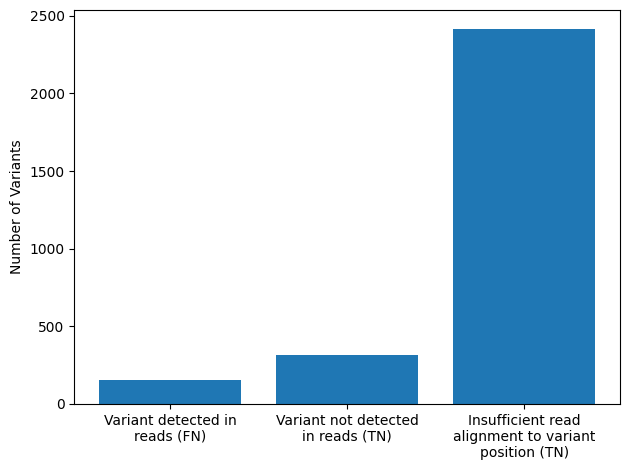

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"))

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                                                                                | 0/23088 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████▍                                                                                                                  | 6753/23088 [00:00<00:00, 65327.56it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 13286/23088 [00:00<00:00, 29174.50it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 17202/23088 [00:00<00:00, 24724.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 21433/23088 [00:00<00:00, 28540.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23088/23088 [00:00<00:00, 29943.56it/s]

Variants in vcrs_reference: 153
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000497986:c.262A>G',
 'ENST00000359858:c.367G>A',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000372476:c.3052A>G',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000309851:c.79G>A',
 'ENST00000256593:c.594T>C',
 'ENST00000585156:c.6692C>G',
 'ENST00000581821:c.709G>C',
 'ENST00000272167:c.932C>T',
 'ENST00000238181:c.457C>T',
 'ENST00000238181:c.458A>G',
 'ENST00000359594:c.439A>G',
 'ENST00000593798:c.103G>A',
 'ENST00000260653:c.918C>T',
 'ENST00000456023:c.173G>C',
 'ENST00000354986:c.3448C>T',
 'ENST00000302640:c.5474T>C']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000497986:c.262A>G


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

AGAGCAGGCTGAAGAGGAACGATATTTCCGACATTACGGGTTATGCTTTGAGATCTCTTTGGGGTGAAGGATTGA
TCAATCCTTCACCCCAAAGAGATCTCAAAGCATAACCCGTAATGTCGGAAATATCGTTCCTCTTCAGCCTGCTCT
TCAATCCTTCACCCCAAAGAGATCTCAAAGCATAACCC
CGTAATGTCGGAAATATCGTTCCTCTTCAGCCTGCTCT


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000344063:c.729G>A


TAAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACAACGGACTGATTCACCG
CGGTGAATCAGTCCGTTGTAGCGGAAGGAATTGCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTA


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                                                                             | 0/46292322 [00:00<?, ?it/s]

  0%|                                                                                                                                                               | 2231/46292322 [00:00<34:35, 22306.30it/s]

  0%|                                                                                                                                                               | 6419/46292322 [00:00<22:49, 33809.42it/s]

  0%|                                                                                                                                                              | 10605/46292322 [00:00<20:34, 37482.00it/s]

  0%|                                                                                                                                                              | 15125/46292322 [00:00<19:01, 40524.53it/s]

  0%|                                                                                                                                                              | 20742/46292322 [00:00<16:42, 46163.84it/s]

  0%|                                                                                                                                                              | 26230/46292322 [00:00<15:41, 49123.90it/s]

  0%|                                                                                                                                                              | 31877/46292322 [00:00<14:57, 51523.52it/s]

  0%|▏                                                                                                                                                             | 37507/46292322 [00:00<14:32, 53042.04it/s]

  0%|▏                                                                                                                                                             | 43110/46292322 [00:00<14:16, 53975.32it/s]

  0%|▏                                                                                                                                                             | 51528/46292322 [00:01<12:10, 63296.89it/s]

  0%|▏                                                                                                                                                             | 59322/46292322 [00:01<11:22, 67775.86it/s]

  0%|▏                                                                                                                                                             | 67285/46292322 [00:01<10:47, 71380.77it/s]

  0%|▎                                                                                                                                                             | 75812/46292322 [00:01<10:11, 75585.48it/s]

  0%|▎                                                                                                                                                             | 83663/46292322 [00:01<10:04, 76465.82it/s]

  0%|▎                                                                                                                                                             | 91592/46292322 [00:01<09:57, 77316.02it/s]

  0%|▎                                                                                                                                                            | 100084/46292322 [00:01<09:40, 79603.96it/s]

  0%|▎                                                                                                                                                            | 108045/46292322 [00:01<09:41, 79404.12it/s]

  0%|▍                                                                                                                                                            | 115986/46292322 [00:01<09:42, 79302.69it/s]

  0%|▍                                                                                                                                                            | 124188/46292322 [00:01<09:44, 78927.19it/s]

  0%|▍                                                                                                                                                            | 132637/46292322 [00:02<09:32, 80575.03it/s]

  0%|▍                                                                                                                                                            | 140698/46292322 [00:02<09:34, 80339.63it/s]

  0%|▌                                                                                                                                                            | 148734/46292322 [00:02<09:35, 80185.27it/s]

  0%|▌                                                                                                                                                            | 157246/46292322 [00:02<09:25, 81653.45it/s]

  0%|▌                                                                                                                                                            | 165414/46292322 [00:02<09:30, 80809.58it/s]

  0%|▌                                                                                                                                                            | 173498/46292322 [00:02<09:32, 80529.94it/s]

  0%|▌                                                                                                                                                            | 181554/46292322 [00:02<09:35, 80103.37it/s]

  0%|▋                                                                                                                                                            | 190075/46292322 [00:02<09:24, 81615.75it/s]

  0%|▋                                                                                                                                                            | 198240/46292322 [00:02<09:29, 80976.23it/s]

  0%|▋                                                                                                                                                            | 206341/46292322 [00:02<09:34, 80179.99it/s]

  0%|▋                                                                                                                                                            | 214435/46292322 [00:03<09:35, 80130.04it/s]

  0%|▊                                                                                                                                                            | 222938/46292322 [00:03<09:24, 81579.09it/s]

  0%|▊                                                                                                                                                            | 231100/46292322 [00:03<09:27, 81120.54it/s]

  1%|▊                                                                                                                                                            | 239215/46292322 [00:03<09:31, 80629.60it/s]

  1%|▊                                                                                                                                                            | 247545/46292322 [00:03<09:25, 81418.17it/s]

  1%|▊                                                                                                                                                            | 255690/46292322 [00:03<09:28, 80958.82it/s]

  1%|▉                                                                                                                                                            | 263788/46292322 [00:03<09:31, 80496.52it/s]

  1%|▉                                                                                                                                                            | 271840/46292322 [00:03<09:32, 80394.82it/s]

  1%|▉                                                                                                                                                            | 280377/46292322 [00:03<09:21, 81872.91it/s]

  1%|▉                                                                                                                                                            | 288567/46292322 [00:03<09:28, 80985.59it/s]

  1%|█                                                                                                                                                            | 296669/46292322 [00:04<09:30, 80647.22it/s]

  1%|█                                                                                                                                                            | 304736/46292322 [00:04<09:33, 80241.26it/s]

  1%|█                                                                                                                                                            | 313252/46292322 [00:04<09:22, 81696.92it/s]

  1%|█                                                                                                                                                            | 321425/46292322 [00:04<09:26, 81106.30it/s]

  1%|█                                                                                                                                                            | 329539/46292322 [00:04<09:31, 80450.32it/s]

  1%|█▏                                                                                                                                                           | 337587/46292322 [00:04<09:32, 80202.23it/s]

  1%|█▏                                                                                                                                                           | 346087/46292322 [00:04<09:22, 81623.31it/s]

  1%|█▏                                                                                                                                                           | 354252/46292322 [00:04<09:27, 80968.36it/s]

  1%|█▏                                                                                                                                                           | 362352/46292322 [00:04<10:51, 70465.27it/s]

  1%|█▎                                                                                                                                                           | 369639/46292322 [00:05<12:26, 61543.48it/s]

  1%|█▎                                                                                                                                                           | 376126/46292322 [00:05<13:52, 55156.58it/s]

  1%|█▎                                                                                                                                                           | 381944/46292322 [00:05<14:38, 52286.29it/s]

  1%|█▎                                                                                                                                                           | 388110/46292322 [00:05<14:01, 54560.41it/s]

  1%|█▎                                                                                                                                                           | 395242/46292322 [00:05<12:59, 58875.73it/s]

  1%|█▎                                                                                                                                                           | 402888/46292322 [00:05<12:01, 63602.36it/s]

  1%|█▍                                                                                                                                                           | 410020/46292322 [00:05<11:37, 65742.45it/s]

  1%|█▍                                                                                                                                                           | 417673/46292322 [00:05<11:06, 68804.09it/s]

  1%|█▍                                                                                                                                                           | 424681/46292322 [00:05<12:22, 61736.26it/s]

  1%|█▍                                                                                                                                                           | 432611/46292322 [00:06<11:30, 66459.05it/s]

  1%|█▍                                                                                                                                                           | 441098/46292322 [00:06<10:40, 71568.29it/s]

  1%|█▌                                                                                                                                                           | 449049/46292322 [00:06<10:20, 73822.70it/s]

  1%|█▌                                                                                                                                                           | 456848/46292322 [00:06<10:10, 75024.46it/s]

  1%|█▌                                                                                                                                                           | 465190/46292322 [00:06<09:51, 77472.70it/s]

  1%|█▌                                                                                                                                                           | 473161/46292322 [00:06<09:46, 78128.37it/s]

  1%|█▋                                                                                                                                                           | 481031/46292322 [00:06<09:45, 78226.53it/s]

  1%|█▋                                                                                                                                                           | 489408/46292322 [00:06<09:41, 78735.78it/s]

  1%|█▋                                                                                                                                                           | 497309/46292322 [00:06<11:44, 65026.98it/s]

  1%|█▋                                                                                                                                                           | 504219/46292322 [00:07<13:22, 57053.03it/s]

  1%|█▋                                                                                                                                                           | 510341/46292322 [00:07<14:15, 53514.57it/s]

  1%|█▋                                                                                                                                                           | 515985/46292322 [00:07<14:56, 51066.28it/s]

  1%|█▊                                                                                                                                                           | 522918/46292322 [00:07<13:44, 55539.13it/s]

  1%|█▊                                                                                                                                                           | 530562/46292322 [00:07<12:30, 60955.69it/s]

  1%|█▊                                                                                                                                                           | 537680/46292322 [00:07<11:58, 63717.03it/s]

  1%|█▊                                                                                                                                                           | 545248/46292322 [00:07<11:22, 67047.60it/s]

  1%|█▊                                                                                                                                                           | 552388/46292322 [00:07<11:09, 68284.72it/s]

  1%|█▉                                                                                                                                                           | 560719/46292322 [00:07<10:39, 71529.68it/s]

  1%|█▉                                                                                                                                                           | 569193/46292322 [00:08<10:06, 75348.19it/s]

  1%|█▉                                                                                                                                                           | 576967/46292322 [00:08<10:01, 76045.22it/s]

  1%|█▉                                                                                                                                                           | 584880/46292322 [00:08<09:53, 76951.20it/s]

  1%|██                                                                                                                                                           | 593285/46292322 [00:08<09:38, 79050.47it/s]

  1%|██                                                                                                                                                           | 601221/46292322 [00:08<09:37, 79105.00it/s]

  1%|██                                                                                                                                                           | 609154/46292322 [00:08<09:39, 78765.28it/s]

  1%|██                                                                                                                                                           | 617655/46292322 [00:08<09:26, 80620.96it/s]

  1%|██                                                                                                                                                           | 625730/46292322 [00:08<09:28, 80333.23it/s]

  1%|██▏                                                                                                                                                          | 633772/46292322 [00:08<09:30, 79990.24it/s]

  1%|██▏                                                                                                                                                          | 641778/46292322 [00:08<09:31, 79846.56it/s]

  1%|██▏                                                                                                                                                          | 650316/46292322 [00:09<09:20, 81492.14it/s]

  1%|██▏                                                                                                                                                          | 658470/46292322 [00:09<09:22, 81059.88it/s]

  1%|██▎                                                                                                                                                          | 666580/46292322 [00:09<09:26, 80566.86it/s]

  1%|██▎                                                                                                                                                          | 674640/46292322 [00:09<09:31, 79822.45it/s]

  1%|██▎                                                                                                                                                          | 683075/46292322 [00:09<09:21, 81161.76it/s]

  1%|██▎                                                                                                                                                          | 691195/46292322 [00:09<09:26, 80432.33it/s]

  2%|██▎                                                                                                                                                          | 699242/46292322 [00:09<09:29, 80064.66it/s]

  2%|██▍                                                                                                                                                          | 707646/46292322 [00:09<09:30, 79946.21it/s]

  2%|██▍                                                                                                                                                          | 715938/46292322 [00:09<09:23, 80818.85it/s]

  2%|██▍                                                                                                                                                          | 724024/46292322 [00:10<09:26, 80390.18it/s]

  2%|██▍                                                                                                                                                          | 732066/46292322 [00:10<09:31, 79746.06it/s]

  2%|██▌                                                                                                                                                          | 740485/46292322 [00:10<09:21, 81055.17it/s]

  2%|██▌                                                                                                                                                          | 748594/46292322 [00:10<09:26, 80356.91it/s]

  2%|██▌                                                                                                                                                          | 756633/46292322 [00:10<09:32, 79605.36it/s]

  2%|██▌                                                                                                                                                          | 764597/46292322 [00:10<09:34, 79210.34it/s]

  2%|██▌                                                                                                                                                          | 772998/46292322 [00:10<09:24, 80625.95it/s]

  2%|██▋                                                                                                                                                          | 781064/46292322 [00:10<09:27, 80133.33it/s]

  2%|██▋                                                                                                                                                          | 789080/46292322 [00:10<09:32, 79534.43it/s]

  2%|██▋                                                                                                                                                          | 797425/46292322 [00:10<09:23, 80690.83it/s]

  2%|██▋                                                                                                                                                          | 805498/46292322 [00:11<09:32, 79402.58it/s]

  2%|██▊                                                                                                                                                          | 813444/46292322 [00:11<09:52, 76804.85it/s]

  2%|██▊                                                                                                                                                          | 821297/46292322 [00:11<09:48, 77301.25it/s]

  2%|██▊                                                                                                                                                          | 829650/46292322 [00:11<09:34, 79121.14it/s]

  2%|██▊                                                                                                                                                          | 837578/46292322 [00:11<09:36, 78846.11it/s]

  2%|██▊                                                                                                                                                          | 845473/46292322 [00:11<09:37, 78672.93it/s]

  2%|██▉                                                                                                                                                          | 853915/46292322 [00:11<09:25, 80373.13it/s]

  2%|██▉                                                                                                                                                          | 861960/46292322 [00:11<09:27, 80010.38it/s]

  2%|██▉                                                                                                                                                          | 869967/46292322 [00:11<09:28, 79832.84it/s]

  2%|██▉                                                                                                                                                          | 878318/46292322 [00:11<09:21, 80925.90it/s]

  2%|███                                                                                                                                                          | 886414/46292322 [00:12<09:25, 80320.12it/s]

  2%|███                                                                                                                                                          | 894450/46292322 [00:12<09:28, 79895.24it/s]

  2%|███                                                                                                                                                          | 902442/46292322 [00:12<09:29, 79714.34it/s]

  2%|███                                                                                                                                                          | 910792/46292322 [00:12<09:21, 80838.71it/s]

  2%|███                                                                                                                                                          | 918878/46292322 [00:12<09:27, 80007.92it/s]

  2%|███▏                                                                                                                                                         | 926882/46292322 [00:12<09:29, 79717.88it/s]

  2%|███▏                                                                                                                                                         | 935314/46292322 [00:12<09:19, 81081.48it/s]

  2%|███▏                                                                                                                                                         | 943425/46292322 [00:12<09:22, 80578.38it/s]

  2%|███▏                                                                                                                                                         | 951486/46292322 [00:12<09:25, 80201.35it/s]

  2%|███▎                                                                                                                                                         | 959508/46292322 [00:12<09:28, 79731.52it/s]

  2%|███▎                                                                                                                                                         | 967997/46292322 [00:13<09:17, 81259.13it/s]

  2%|███▎                                                                                                                                                         | 976126/46292322 [00:13<09:24, 80330.02it/s]

  2%|███▎                                                                                                                                                         | 984163/46292322 [00:13<09:26, 79982.44it/s]

  2%|███▎                                                                                                                                                         | 992436/46292322 [00:13<09:27, 79803.07it/s]

  2%|███▎                                                                                                                                                        | 1000780/46292322 [00:13<09:20, 80873.11it/s]

  2%|███▍                                                                                                                                                        | 1008871/46292322 [00:13<09:22, 80536.05it/s]

  2%|███▍                                                                                                                                                        | 1016927/46292322 [00:13<09:26, 79943.47it/s]

  2%|███▍                                                                                                                                                        | 1025320/46292322 [00:13<09:18, 81120.27it/s]

  2%|███▍                                                                                                                                                        | 1033435/46292322 [00:13<09:24, 80217.46it/s]

  2%|███▌                                                                                                                                                        | 1041461/46292322 [00:13<09:29, 79525.20it/s]

  2%|███▌                                                                                                                                                        | 1049417/46292322 [00:14<09:29, 79378.61it/s]

  2%|███▌                                                                                                                                                        | 1057837/46292322 [00:14<09:19, 80804.81it/s]

  2%|███▌                                                                                                                                                        | 1065921/46292322 [00:14<09:23, 80305.24it/s]

  2%|███▌                                                                                                                                                        | 1073955/46292322 [00:14<09:27, 79717.63it/s]

  2%|███▋                                                                                                                                                        | 1082226/46292322 [00:14<09:27, 79725.23it/s]

  2%|███▋                                                                                                                                                        | 1090601/46292322 [00:14<09:18, 80911.99it/s]

  2%|███▋                                                                                                                                                        | 1098696/46292322 [00:14<09:21, 80475.51it/s]

  2%|███▋                                                                                                                                                        | 1106746/46292322 [00:14<09:22, 80372.72it/s]

  2%|███▊                                                                                                                                                        | 1115154/46292322 [00:14<09:14, 81471.62it/s]

  2%|███▊                                                                                                                                                        | 1123304/46292322 [00:14<09:25, 79923.92it/s]

  2%|███▊                                                                                                                                                        | 1131304/46292322 [00:15<09:33, 78814.75it/s]

  2%|███▊                                                                                                                                                        | 1139193/46292322 [00:15<09:38, 78024.37it/s]

  2%|███▊                                                                                                                                                        | 1147320/46292322 [00:15<09:31, 78974.10it/s]

  2%|███▉                                                                                                                                                        | 1155223/46292322 [00:15<09:39, 77887.19it/s]

  3%|███▉                                                                                                                                                        | 1163215/46292322 [00:15<09:35, 78481.59it/s]

  3%|███▉                                                                                                                                                        | 1171069/46292322 [00:15<11:30, 65303.99it/s]

  3%|███▉                                                                                                                                                        | 1177966/46292322 [00:15<13:09, 57148.60it/s]

  3%|███▉                                                                                                                                                        | 1184077/46292322 [00:15<13:29, 55708.91it/s]

  3%|████                                                                                                                                                        | 1189911/46292322 [00:16<13:30, 55646.06it/s]

  3%|████                                                                                                                                                        | 1195659/46292322 [00:16<13:47, 54494.10it/s]

  3%|████                                                                                                                                                        | 1201230/46292322 [00:16<13:46, 54542.54it/s]

  3%|████                                                                                                                                                        | 1206825/46292322 [00:16<13:40, 54925.29it/s]

  3%|████                                                                                                                                                        | 1214495/46292322 [00:16<12:18, 61045.41it/s]

  3%|████                                                                                                                                                        | 1222959/46292322 [00:16<11:04, 67805.31it/s]

  3%|████▏                                                                                                                                                       | 1230932/46292322 [00:16<10:32, 71267.53it/s]

  3%|████▏                                                                                                                                                       | 1238892/46292322 [00:16<10:11, 73707.93it/s]

  3%|████▏                                                                                                                                                       | 1247127/46292322 [00:16<09:57, 75414.26it/s]

  3%|████▏                                                                                                                                                       | 1255688/46292322 [00:16<09:34, 78412.22it/s]

  3%|████▎                                                                                                                                                       | 1263687/46292322 [00:17<09:30, 78875.98it/s]

  3%|████▎                                                                                                                                                       | 1271620/46292322 [00:17<09:29, 79009.69it/s]

  3%|████▎                                                                                                                                                       | 1280147/46292322 [00:17<09:16, 80873.55it/s]

  3%|████▎                                                                                                                                                       | 1288248/46292322 [00:17<09:20, 80340.23it/s]

  3%|████▎                                                                                                                                                       | 1296292/46292322 [00:17<09:20, 80225.50it/s]

  3%|████▍                                                                                                                                                       | 1304322/46292322 [00:17<09:21, 80185.81it/s]

  3%|████▍                                                                                                                                                       | 1312891/46292322 [00:17<09:09, 81826.78it/s]

  3%|████▍                                                                                                                                                       | 1321078/46292322 [00:17<09:13, 81320.51it/s]

  3%|████▍                                                                                                                                                       | 1329214/46292322 [00:17<09:17, 80713.82it/s]

  3%|████▌                                                                                                                                                       | 1337289/46292322 [00:17<09:20, 80219.09it/s]

  3%|████▌                                                                                                                                                       | 1345835/46292322 [00:18<09:09, 81770.85it/s]

  3%|████▌                                                                                                                                                       | 1354016/46292322 [00:18<09:12, 81332.49it/s]

  3%|████▌                                                                                                                                                       | 1362152/46292322 [00:18<09:14, 80968.55it/s]

  3%|████▌                                                                                                                                                       | 1370251/46292322 [00:18<09:20, 80124.79it/s]

  3%|████▋                                                                                                                                                       | 1378761/46292322 [00:18<09:10, 81594.06it/s]

  3%|████▋                                                                                                                                                       | 1386925/46292322 [00:18<09:13, 81164.36it/s]

  3%|████▋                                                                                                                                                       | 1395045/46292322 [00:18<09:18, 80453.79it/s]

  3%|████▋                                                                                                                                                       | 1403262/46292322 [00:18<09:18, 80311.06it/s]

  3%|████▊                                                                                                                                                       | 1411615/46292322 [00:18<09:12, 81259.55it/s]

  3%|████▊                                                                                                                                                       | 1419744/46292322 [00:19<09:14, 80896.12it/s]

  3%|████▊                                                                                                                                                       | 1427836/46292322 [00:19<09:15, 80704.23it/s]

  3%|████▊                                                                                                                                                       | 1436280/46292322 [00:19<09:08, 81812.54it/s]

  3%|████▊                                                                                                                                                       | 1444464/46292322 [00:19<09:13, 81092.63it/s]

  3%|████▉                                                                                                                                                       | 1452576/46292322 [00:19<09:20, 79996.36it/s]

  3%|████▉                                                                                                                                                       | 1460580/46292322 [00:19<09:22, 79750.34it/s]

  3%|████▉                                                                                                                                                       | 1469063/46292322 [00:19<09:11, 81250.75it/s]

  3%|████▉                                                                                                                                                       | 1477193/46292322 [00:19<09:17, 80332.63it/s]

  3%|█████                                                                                                                                                       | 1485231/46292322 [00:19<09:20, 79961.58it/s]

  3%|█████                                                                                                                                                       | 1493231/46292322 [00:19<09:26, 79121.53it/s]

  3%|█████                                                                                                                                                       | 1501744/46292322 [00:20<09:13, 80892.05it/s]

  3%|█████                                                                                                                                                       | 1509839/46292322 [00:20<09:16, 80432.77it/s]

  3%|█████                                                                                                                                                       | 1517886/46292322 [00:20<09:21, 79753.13it/s]

  3%|█████▏                                                                                                                                                      | 1526218/46292322 [00:20<09:21, 79704.19it/s]

  3%|█████▏                                                                                                                                                      | 1534485/46292322 [00:20<09:15, 80574.13it/s]

  3%|█████▏                                                                                                                                                      | 1542546/46292322 [00:20<09:18, 80148.55it/s]

  3%|█████▏                                                                                                                                                      | 1550564/46292322 [00:20<09:20, 79823.10it/s]

  3%|█████▎                                                                                                                                                      | 1558984/46292322 [00:20<09:11, 81118.60it/s]

  3%|█████▎                                                                                                                                                      | 1567099/46292322 [00:20<09:15, 80530.66it/s]

  3%|█████▎                                                                                                                                                      | 1575155/46292322 [00:20<09:21, 79568.94it/s]

  3%|█████▎                                                                                                                                                      | 1583116/46292322 [00:21<09:24, 79248.89it/s]

  3%|█████▎                                                                                                                                                      | 1591480/46292322 [00:21<09:14, 80546.04it/s]

  3%|█████▍                                                                                                                                                      | 1599538/46292322 [00:21<09:17, 80179.84it/s]

  3%|█████▍                                                                                                                                                      | 1607559/46292322 [00:21<09:19, 79935.17it/s]

  3%|█████▍                                                                                                                                                      | 1615734/46292322 [00:21<09:22, 79361.90it/s]

  4%|█████▍                                                                                                                                                      | 1624150/46292322 [00:21<09:12, 80774.63it/s]

  4%|█████▌                                                                                                                                                      | 1632232/46292322 [00:21<09:18, 79940.83it/s]

  4%|█████▌                                                                                                                                                      | 1640230/46292322 [00:21<09:20, 79607.26it/s]

  4%|█████▌                                                                                                                                                      | 1648637/46292322 [00:21<09:11, 80924.75it/s]

  4%|█████▌                                                                                                                                                      | 1656734/46292322 [00:21<09:18, 79978.01it/s]

  4%|█████▌                                                                                                                                                      | 1664737/46292322 [00:22<09:20, 79576.07it/s]

  4%|█████▋                                                                                                                                                      | 1672698/46292322 [00:22<09:21, 79404.68it/s]

  4%|█████▋                                                                                                                                                      | 1681117/46292322 [00:22<09:11, 80821.94it/s]

  4%|█████▋                                                                                                                                                      | 1689203/46292322 [00:22<09:17, 80023.26it/s]

  4%|█████▋                                                                                                                                                      | 1697209/46292322 [00:22<09:24, 78961.18it/s]

  4%|█████▋                                                                                                                                                      | 1705252/46292322 [00:22<09:24, 79019.59it/s]

  4%|█████▊                                                                                                                                                      | 1713677/46292322 [00:22<09:13, 80561.30it/s]

  4%|█████▊                                                                                                                                                      | 1721738/46292322 [00:22<09:16, 80039.69it/s]

  4%|█████▊                                                                                                                                                      | 1729746/46292322 [00:22<09:21, 79335.07it/s]

  4%|█████▊                                                                                                                                                      | 1738106/46292322 [00:22<09:12, 80593.78it/s]

  4%|█████▉                                                                                                                                                      | 1746170/46292322 [00:23<09:15, 80189.88it/s]

  4%|█████▉                                                                                                                                                      | 1754192/46292322 [00:23<09:20, 79494.64it/s]

  4%|█████▉                                                                                                                                                      | 1762145/46292322 [00:23<09:21, 79315.54it/s]

  4%|█████▉                                                                                                                                                      | 1770467/46292322 [00:23<09:13, 80469.84it/s]

  4%|█████▉                                                                                                                                                      | 1778517/46292322 [00:23<09:16, 79991.00it/s]

  4%|██████                                                                                                                                                      | 1786519/46292322 [00:23<09:18, 79639.93it/s]

  4%|██████                                                                                                                                                      | 1794920/46292322 [00:23<09:09, 80935.73it/s]

  4%|██████                                                                                                                                                      | 1803016/46292322 [00:23<09:13, 80312.40it/s]

  4%|██████                                                                                                                                                      | 1811050/46292322 [00:23<09:21, 79210.53it/s]

  4%|██████▏                                                                                                                                                     | 1818976/46292322 [00:23<09:22, 79086.80it/s]

  4%|██████▏                                                                                                                                                     | 1827411/46292322 [00:24<09:11, 80642.93it/s]

  4%|██████▏                                                                                                                                                     | 1835480/46292322 [00:24<09:14, 80122.05it/s]

  4%|██████▏                                                                                                                                                     | 1843496/46292322 [00:24<09:17, 79722.61it/s]

  4%|██████▏                                                                                                                                                     | 1851818/46292322 [00:24<09:10, 80756.92it/s]

  4%|██████▎                                                                                                                                                     | 1859897/46292322 [00:24<09:12, 80364.34it/s]

  4%|██████▎                                                                                                                                                     | 1867936/46292322 [00:24<09:15, 79939.20it/s]

  4%|██████▎                                                                                                                                                     | 1875932/46292322 [00:24<09:20, 79266.24it/s]

  4%|██████▎                                                                                                                                                     | 1884341/46292322 [00:24<09:10, 80693.28it/s]

  4%|██████▍                                                                                                                                                     | 1892414/46292322 [00:24<09:15, 79870.97it/s]

  4%|██████▍                                                                                                                                                     | 1900405/46292322 [00:25<09:18, 79552.21it/s]

  4%|██████▍                                                                                                                                                     | 1908661/46292322 [00:25<09:18, 79451.35it/s]

  4%|██████▍                                                                                                                                                     | 1917074/46292322 [00:25<09:09, 80827.25it/s]

  4%|██████▍                                                                                                                                                     | 1925161/46292322 [00:25<09:12, 80280.49it/s]

  4%|██████▌                                                                                                                                                     | 1933192/46292322 [00:25<09:20, 79206.42it/s]

  4%|██████▌                                                                                                                                                     | 1941117/46292322 [00:25<10:17, 71787.92it/s]

  4%|██████▌                                                                                                                                                     | 1948424/46292322 [00:25<12:17, 60101.95it/s]

  4%|██████▌                                                                                                                                                     | 1954809/46292322 [00:25<13:23, 55208.81it/s]

  4%|██████▌                                                                                                                                                     | 1960621/46292322 [00:25<13:14, 55822.58it/s]

  4%|██████▋                                                                                                                                                     | 1966422/46292322 [00:26<13:20, 55390.49it/s]

  4%|██████▋                                                                                                                                                     | 1972272/46292322 [00:26<13:08, 56211.33it/s]

  4%|██████▋                                                                                                                                                     | 1978096/46292322 [00:26<13:00, 56766.23it/s]

  4%|██████▋                                                                                                                                                     | 1983908/46292322 [00:26<12:55, 57145.97it/s]

  4%|██████▋                                                                                                                                                     | 1991487/46292322 [00:26<11:48, 62492.18it/s]

  4%|██████▋                                                                                                                                                     | 1999191/46292322 [00:26<11:03, 66718.08it/s]

  4%|██████▊                                                                                                                                                     | 2007476/46292322 [00:26<10:19, 71447.81it/s]

  4%|██████▊                                                                                                                                                     | 2015240/46292322 [00:26<10:04, 73274.09it/s]

  4%|██████▊                                                                                                                                                     | 2022895/46292322 [00:26<09:56, 74244.33it/s]

  4%|██████▊                                                                                                                                                     | 2031081/46292322 [00:26<09:38, 76507.43it/s]

  4%|██████▊                                                                                                                                                     | 2038856/46292322 [00:27<09:35, 76876.01it/s]

  4%|██████▉                                                                                                                                                     | 2046654/46292322 [00:27<09:33, 77201.95it/s]

  4%|██████▉                                                                                                                                                     | 2054869/46292322 [00:27<09:22, 78678.59it/s]

  4%|██████▉                                                                                                                                                     | 2062746/46292322 [00:27<09:28, 77822.55it/s]

  4%|██████▉                                                                                                                                                     | 2070536/46292322 [00:27<09:28, 77734.09it/s]

  4%|███████                                                                                                                                                     | 2078639/46292322 [00:27<09:27, 77942.18it/s]

  5%|███████                                                                                                                                                     | 2086924/46292322 [00:27<09:16, 79394.90it/s]

  5%|███████                                                                                                                                                     | 2094868/46292322 [00:27<09:18, 79091.16it/s]

  5%|███████                                                                                                                                                     | 2102781/46292322 [00:27<09:22, 78590.90it/s]

  5%|███████                                                                                                                                                     | 2111164/46292322 [00:27<09:11, 80142.74it/s]

  5%|███████▏                                                                                                                                                    | 2119182/46292322 [00:28<09:17, 79263.71it/s]

  5%|███████▏                                                                                                                                                    | 2127113/46292322 [00:28<09:19, 78971.89it/s]

  5%|███████▏                                                                                                                                                    | 2135175/46292322 [00:28<09:21, 78631.59it/s]

  5%|███████▏                                                                                                                                                    | 2143369/46292322 [00:28<09:14, 79607.45it/s]

  5%|███████▏                                                                                                                                                    | 2151333/46292322 [00:28<09:16, 79288.29it/s]

  5%|███████▎                                                                                                                                                    | 2159264/46292322 [00:28<09:18, 79038.91it/s]

  5%|███████▎                                                                                                                                                    | 2167658/46292322 [00:28<09:08, 80492.95it/s]

  5%|███████▎                                                                                                                                                    | 2175710/46292322 [00:28<09:13, 79720.88it/s]

  5%|███████▎                                                                                                                                                    | 2183685/46292322 [00:28<09:17, 79089.59it/s]

  5%|███████▍                                                                                                                                                    | 2191713/46292322 [00:29<09:17, 79127.96it/s]

  5%|███████▍                                                                                                                                                    | 2200179/46292322 [00:29<09:05, 80764.09it/s]

  5%|███████▍                                                                                                                                                    | 2208259/46292322 [00:29<09:08, 80385.92it/s]

  5%|███████▍                                                                                                                                                    | 2216300/46292322 [00:29<09:10, 80048.18it/s]

  5%|███████▍                                                                                                                                                    | 2224616/46292322 [00:29<09:04, 80969.98it/s]

  5%|███████▌                                                                                                                                                    | 2232716/46292322 [00:29<09:06, 80586.34it/s]

  5%|███████▌                                                                                                                                                    | 2240777/46292322 [00:29<09:08, 80314.11it/s]

  5%|███████▌                                                                                                                                                    | 2248810/46292322 [00:29<09:11, 79918.02it/s]

  5%|███████▌                                                                                                                                                    | 2257273/46292322 [00:29<09:01, 81317.41it/s]

  5%|███████▋                                                                                                                                                    | 2265407/46292322 [00:29<09:07, 80350.12it/s]

  5%|███████▋                                                                                                                                                    | 2273446/46292322 [00:30<09:10, 80001.37it/s]

  5%|███████▋                                                                                                                                                    | 2281495/46292322 [00:30<09:12, 79624.25it/s]

  5%|███████▋                                                                                                                                                    | 2289460/46292322 [00:30<11:43, 62545.31it/s]

  5%|███████▋                                                                                                                                                    | 2297092/46292322 [00:30<11:06, 65978.09it/s]

  5%|███████▊                                                                                                                                                    | 2305159/46292322 [00:30<10:33, 69425.37it/s]

  5%|███████▊                                                                                                                                                    | 2313550/46292322 [00:30<09:59, 73357.61it/s]

  5%|███████▊                                                                                                                                                    | 2321184/46292322 [00:30<09:52, 74159.93it/s]

  5%|███████▊                                                                                                                                                    | 2328866/46292322 [00:30<09:46, 74917.71it/s]

  5%|███████▉                                                                                                                                                    | 2337064/46292322 [00:30<09:31, 76961.22it/s]

  5%|███████▉                                                                                                                                                    | 2344876/46292322 [00:31<09:30, 77036.87it/s]

  5%|███████▉                                                                                                                                                    | 2352661/46292322 [00:31<09:32, 76811.61it/s]

  5%|███████▉                                                                                                                                                    | 2361016/46292322 [00:31<09:17, 78793.65it/s]

  5%|███████▉                                                                                                                                                    | 2368939/46292322 [00:31<09:18, 78714.47it/s]

  5%|████████                                                                                                                                                    | 2376841/46292322 [00:31<09:20, 78301.67it/s]

  5%|████████                                                                                                                                                    | 2385265/46292322 [00:31<09:08, 80057.90it/s]

  5%|████████                                                                                                                                                    | 2393288/46292322 [00:31<09:11, 79531.22it/s]

  5%|████████                                                                                                                                                    | 2401254/46292322 [00:31<09:14, 79223.34it/s]

  5%|████████                                                                                                                                                    | 2409279/46292322 [00:31<09:16, 78863.18it/s]

  5%|████████▏                                                                                                                                                   | 2417572/46292322 [00:31<09:07, 80064.30it/s]

  5%|████████▏                                                                                                                                                   | 2425585/46292322 [00:32<09:10, 79721.01it/s]

  5%|████████▏                                                                                                                                                   | 2433562/46292322 [00:32<09:12, 79404.56it/s]

  5%|████████▏                                                                                                                                                   | 2441973/46292322 [00:32<09:02, 80798.70it/s]

  5%|████████▎                                                                                                                                                   | 2450057/46292322 [00:32<09:05, 80306.87it/s]

  5%|████████▎                                                                                                                                                   | 2458091/46292322 [00:32<09:11, 79446.09it/s]

  5%|████████▎                                                                                                                                                   | 2466071/46292322 [00:32<09:16, 78719.37it/s]

  5%|████████▎                                                                                                                                                   | 2474441/46292322 [00:32<09:06, 80184.26it/s]

  5%|████████▎                                                                                                                                                   | 2482465/46292322 [00:32<09:09, 79759.30it/s]

  5%|████████▍                                                                                                                                                   | 2490445/46292322 [00:32<09:11, 79400.68it/s]

  5%|████████▍                                                                                                                                                   | 2498728/46292322 [00:32<09:04, 80415.25it/s]

  5%|████████▍                                                                                                                                                   | 2506773/46292322 [00:33<09:07, 79960.62it/s]

  5%|████████▍                                                                                                                                                   | 2514772/46292322 [00:33<09:09, 79622.27it/s]

  5%|████████▌                                                                                                                                                   | 2522759/46292322 [00:33<09:14, 78984.00it/s]

  5%|████████▌                                                                                                                                                   | 2530964/46292322 [00:33<09:07, 79889.26it/s]

  5%|████████▌                                                                                                                                                   | 2538956/46292322 [00:33<09:14, 78924.67it/s]

  6%|████████▌                                                                                                                                                   | 2546853/46292322 [00:33<09:15, 78795.21it/s]

  6%|████████▌                                                                                                                                                   | 2555159/46292322 [00:33<09:06, 80057.61it/s]

  6%|████████▋                                                                                                                                                   | 2563168/46292322 [00:33<09:08, 79660.35it/s]

  6%|████████▋                                                                                                                                                   | 2571137/46292322 [00:33<09:11, 79316.26it/s]

  6%|████████▋                                                                                                                                                   | 2579296/46292322 [00:33<09:14, 78873.27it/s]

  6%|████████▋                                                                                                                                                   | 2587658/46292322 [00:34<09:04, 80271.19it/s]

  6%|████████▋                                                                                                                                                   | 2595689/46292322 [00:34<09:07, 79813.31it/s]

  6%|████████▊                                                                                                                                                   | 2603674/46292322 [00:34<09:09, 79517.60it/s]

  6%|████████▊                                                                                                                                                   | 2612068/46292322 [00:34<09:00, 80828.24it/s]

  6%|████████▊                                                                                                                                                   | 2620154/46292322 [00:34<09:06, 79870.86it/s]

  6%|████████▊                                                                                                                                                   | 2628145/46292322 [00:34<09:10, 79316.41it/s]

  6%|████████▉                                                                                                                                                   | 2636080/46292322 [00:34<09:11, 79146.49it/s]

  6%|████████▉                                                                                                                                                   | 2644325/46292322 [00:34<09:04, 80122.60it/s]

  6%|████████▉                                                                                                                                                   | 2652340/46292322 [00:34<09:10, 79313.22it/s]

  6%|████████▉                                                                                                                                                   | 2660275/46292322 [00:34<09:11, 79068.22it/s]

  6%|████████▉                                                                                                                                                   | 2668723/46292322 [00:35<09:00, 80671.46it/s]

  6%|█████████                                                                                                                                                   | 2676794/46292322 [00:35<09:04, 80107.09it/s]

  6%|█████████                                                                                                                                                   | 2684808/46292322 [00:35<09:06, 79758.20it/s]

  6%|█████████                                                                                                                                                   | 2692786/46292322 [00:35<09:11, 79103.84it/s]

  6%|█████████                                                                                                                                                   | 2701231/46292322 [00:35<09:00, 80685.02it/s]

  6%|█████████▏                                                                                                                                                  | 2709303/46292322 [00:35<09:05, 79957.98it/s]

  6%|█████████▏                                                                                                                                                  | 2717303/46292322 [00:35<09:07, 79647.33it/s]

  6%|█████████▏                                                                                                                                                  | 2725349/46292322 [00:35<09:07, 79543.81it/s]

  6%|█████████▏                                                                                                                                                  | 2733662/46292322 [00:35<09:00, 80605.01it/s]

  6%|█████████▏                                                                                                                                                  | 2741725/46292322 [00:36<09:04, 80038.95it/s]

  6%|█████████▎                                                                                                                                                  | 2749731/46292322 [00:36<09:07, 79576.51it/s]

  6%|█████████▎                                                                                                                                                  | 2758182/46292322 [00:36<08:57, 81038.72it/s]

  6%|█████████▎                                                                                                                                                  | 2766289/46292322 [00:36<09:05, 79853.75it/s]

  6%|█████████▎                                                                                                                                                  | 2774280/46292322 [00:36<09:10, 79093.33it/s]

  6%|█████████▍                                                                                                                                                  | 2782194/46292322 [00:36<09:11, 78832.53it/s]

  6%|█████████▍                                                                                                                                                  | 2790549/46292322 [00:36<09:02, 80222.90it/s]

  6%|█████████▍                                                                                                                                                  | 2798576/46292322 [00:36<09:07, 79389.12it/s]

  6%|█████████▍                                                                                                                                                  | 2806519/46292322 [00:36<09:09, 79146.42it/s]

  6%|█████████▍                                                                                                                                                  | 2814787/46292322 [00:36<09:02, 80190.85it/s]

  6%|█████████▌                                                                                                                                                  | 2822810/46292322 [00:37<09:07, 79352.63it/s]

  6%|█████████▌                                                                                                                                                  | 2830749/46292322 [00:37<09:09, 79087.75it/s]

  6%|█████████▌                                                                                                                                                  | 2838841/46292322 [00:37<09:09, 79018.40it/s]

  6%|█████████▌                                                                                                                                                  | 2847254/46292322 [00:37<08:59, 80529.56it/s]

  6%|█████████▌                                                                                                                                                  | 2855311/46292322 [00:37<09:05, 79580.71it/s]

  6%|█████████▋                                                                                                                                                  | 2863274/46292322 [00:37<09:08, 79183.44it/s]

  6%|█████████▋                                                                                                                                                  | 2871660/46292322 [00:37<08:58, 80565.21it/s]

  6%|█████████▋                                                                                                                                                  | 2879721/46292322 [00:37<09:04, 79718.69it/s]

  6%|█████████▋                                                                                                                                                  | 2887697/46292322 [00:37<09:06, 79381.10it/s]

  6%|█████████▊                                                                                                                                                  | 2895638/46292322 [00:37<09:11, 78739.49it/s]

  6%|█████████▊                                                                                                                                                  | 2903959/46292322 [00:38<09:01, 80057.51it/s]

  6%|█████████▊                                                                                                                                                  | 2911969/46292322 [00:38<09:06, 79389.89it/s]

  6%|█████████▊                                                                                                                                                  | 2919912/46292322 [00:38<09:07, 79235.44it/s]

  6%|█████████▊                                                                                                                                                  | 2928294/46292322 [00:38<08:58, 80593.83it/s]

  6%|█████████▉                                                                                                                                                  | 2936357/46292322 [00:38<09:05, 79430.81it/s]

  6%|█████████▉                                                                                                                                                  | 2944306/46292322 [00:38<09:08, 79072.33it/s]

  6%|█████████▉                                                                                                                                                  | 2952425/46292322 [00:38<09:09, 78826.92it/s]

  6%|█████████▉                                                                                                                                                  | 2960771/46292322 [00:38<09:00, 80189.68it/s]

  6%|██████████                                                                                                                                                  | 2968795/46292322 [00:38<09:05, 79386.37it/s]

  6%|██████████                                                                                                                                                  | 2976738/46292322 [00:38<09:10, 78739.22it/s]

  6%|██████████                                                                                                                                                  | 2985098/46292322 [00:39<09:00, 80171.50it/s]

  6%|██████████                                                                                                                                                  | 2993120/46292322 [00:39<09:03, 79642.59it/s]

  6%|██████████                                                                                                                                                  | 3001088/46292322 [00:39<09:07, 79136.09it/s]

  7%|██████████▏                                                                                                                                                 | 3009217/46292322 [00:39<09:08, 78963.37it/s]

  7%|██████████▏                                                                                                                                                 | 3017508/46292322 [00:39<09:00, 80125.69it/s]

  7%|██████████▏                                                                                                                                                 | 3025524/46292322 [00:39<09:03, 79613.57it/s]

  7%|██████████▏                                                                                                                                                 | 3033488/46292322 [00:39<09:05, 79328.59it/s]

  7%|██████████▎                                                                                                                                                 | 3041897/46292322 [00:39<08:55, 80738.83it/s]

  7%|██████████▎                                                                                                                                                 | 3049974/46292322 [00:39<08:59, 80223.05it/s]

  7%|██████████▎                                                                                                                                                 | 3057999/46292322 [00:39<09:05, 79227.31it/s]

  7%|██████████▎                                                                                                                                                 | 3065926/46292322 [00:40<09:07, 79004.11it/s]

  7%|██████████▎                                                                                                                                                 | 3074304/46292322 [00:40<08:57, 80416.59it/s]

  7%|██████████▍                                                                                                                                                 | 3082350/46292322 [00:40<09:01, 79786.78it/s]

  7%|██████████▍                                                                                                                                                 | 3090332/46292322 [00:40<09:05, 79183.29it/s]

  7%|██████████▍                                                                                                                                                 | 3098722/46292322 [00:40<08:56, 80576.15it/s]

  7%|██████████▍                                                                                                                                                 | 3106784/46292322 [00:40<09:00, 79968.17it/s]

  7%|██████████▍                                                                                                                                                 | 3114784/46292322 [00:40<09:04, 79246.39it/s]

  7%|██████████▌                                                                                                                                                 | 3122712/46292322 [00:40<09:06, 79046.94it/s]

  7%|██████████▌                                                                                                                                                 | 3130991/46292322 [00:40<08:58, 80155.24it/s]

  7%|██████████▌                                                                                                                                                 | 3139010/46292322 [00:40<09:01, 79686.42it/s]

  7%|██████████▌                                                                                                                                                 | 3146981/46292322 [00:41<09:03, 79398.76it/s]

  7%|██████████▋                                                                                                                                                 | 3155384/46292322 [00:41<08:54, 80771.61it/s]

  7%|██████████▋                                                                                                                                                 | 3163464/46292322 [00:41<08:58, 80134.84it/s]

  7%|██████████▋                                                                                                                                                 | 3171480/46292322 [00:41<09:05, 79096.83it/s]

  7%|██████████▋                                                                                                                                                 | 3179394/46292322 [00:41<09:06, 78859.78it/s]

  7%|██████████▋                                                                                                                                                 | 3187771/46292322 [00:41<08:56, 80310.82it/s]

  7%|██████████▊                                                                                                                                                 | 3195806/46292322 [00:41<08:58, 79961.19it/s]

  7%|██████████▊                                                                                                                                                 | 3203805/46292322 [00:41<09:01, 79577.45it/s]

  7%|██████████▊                                                                                                                                                 | 3211922/46292322 [00:41<09:05, 78931.33it/s]

  7%|██████████▊                                                                                                                                                 | 3220314/46292322 [00:42<08:55, 80398.47it/s]

  7%|██████████▉                                                                                                                                                 | 3228359/46292322 [00:42<09:01, 79597.13it/s]

  7%|██████████▉                                                                                                                                                 | 3236323/46292322 [00:42<09:02, 79349.96it/s]

  7%|██████████▉                                                                                                                                                 | 3244678/46292322 [00:42<08:54, 80590.72it/s]

  7%|██████████▉                                                                                                                                                 | 3252741/46292322 [00:42<09:00, 79617.11it/s]

  7%|██████████▉                                                                                                                                                 | 3260708/46292322 [00:42<09:26, 75957.49it/s]

  7%|███████████                                                                                                                                                 | 3268506/46292322 [00:42<09:22, 76535.24it/s]

  7%|███████████                                                                                                                                                 | 3276901/46292322 [00:42<09:06, 78690.34it/s]

  7%|███████████                                                                                                                                                 | 3284796/46292322 [00:42<09:09, 78266.64it/s]

  7%|███████████                                                                                                                                                 | 3292641/46292322 [00:42<09:10, 78046.15it/s]

  7%|███████████                                                                                                                                                 | 3301045/46292322 [00:43<08:58, 79812.74it/s]

  7%|███████████▏                                                                                                                                                | 3309038/46292322 [00:43<09:01, 79413.45it/s]

  7%|███████████▏                                                                                                                                                | 3316988/46292322 [00:43<09:03, 79076.02it/s]

  7%|███████████▏                                                                                                                                                | 3325086/46292322 [00:43<09:04, 78948.51it/s]

  7%|███████████▏                                                                                                                                                | 3333334/46292322 [00:43<08:57, 79989.54it/s]

  7%|███████████▎                                                                                                                                                | 3341338/46292322 [00:43<09:02, 79182.45it/s]

  7%|███████████▎                                                                                                                                                | 3349261/46292322 [00:43<09:03, 78963.19it/s]

  7%|███████████▎                                                                                                                                                | 3357661/46292322 [00:43<08:53, 80454.71it/s]

  7%|███████████▎                                                                                                                                                | 3365711/46292322 [00:43<08:57, 79912.29it/s]

  7%|███████████▎                                                                                                                                                | 3373706/46292322 [00:43<09:02, 79162.86it/s]

  7%|███████████▍                                                                                                                                                | 3381933/46292322 [00:44<09:03, 78981.91it/s]

  7%|███████████▍                                                                                                                                                | 3390300/46292322 [00:44<08:53, 80357.94it/s]

  7%|███████████▍                                                                                                                                                | 3398341/46292322 [00:44<08:59, 79534.20it/s]

  7%|███████████▍                                                                                                                                                | 3406299/46292322 [00:44<09:01, 79146.07it/s]

  7%|███████████▌                                                                                                                                                | 3414550/46292322 [00:44<08:55, 80136.26it/s]

  7%|███████████▌                                                                                                                                                | 3422567/46292322 [00:44<08:58, 79614.38it/s]

  7%|███████████▌                                                                                                                                                | 3430532/46292322 [00:44<09:01, 79211.86it/s]

  7%|███████████▌                                                                                                                                                | 3438726/46292322 [00:44<09:02, 79045.47it/s]

  7%|███████████▌                                                                                                                                                | 3447125/46292322 [00:44<08:52, 80500.89it/s]

  7%|███████████▋                                                                                                                                                | 3455179/46292322 [00:44<09:00, 79327.96it/s]

  7%|███████████▋                                                                                                                                                | 3463117/46292322 [00:45<09:02, 78909.50it/s]

  7%|███████████▋                                                                                                                                                | 3471476/46292322 [00:45<08:53, 80287.12it/s]

  8%|███████████▋                                                                                                                                                | 3479510/46292322 [00:45<08:57, 79701.46it/s]

  8%|███████████▊                                                                                                                                                | 3487484/46292322 [00:45<09:02, 78933.22it/s]

  8%|███████████▊                                                                                                                                                | 3495519/46292322 [00:45<09:03, 78733.81it/s]

  8%|███████████▊                                                                                                                                                | 3503847/46292322 [00:45<08:54, 80072.95it/s]

  8%|███████████▊                                                                                                                                                | 3511859/46292322 [00:45<09:00, 79207.81it/s]

  8%|███████████▊                                                                                                                                                | 3519784/46292322 [00:45<09:02, 78787.36it/s]

  8%|███████████▉                                                                                                                                                | 3528007/46292322 [00:45<08:55, 79801.36it/s]

  8%|███████████▉                                                                                                                                                | 3535991/46292322 [00:45<08:59, 79312.17it/s]

  8%|███████████▉                                                                                                                                                | 3543925/46292322 [00:46<09:01, 78975.32it/s]

  8%|███████████▉                                                                                                                                                | 3552312/46292322 [00:46<09:01, 78991.53it/s]

  8%|███████████▉                                                                                                                                                | 3560696/46292322 [00:46<08:51, 80414.77it/s]

  8%|████████████                                                                                                                                                | 3568742/46292322 [00:46<08:59, 79183.58it/s]

  8%|████████████                                                                                                                                                | 3576666/46292322 [00:46<09:01, 78856.87it/s]

  8%|████████████                                                                                                                                                | 3585035/46292322 [00:46<08:51, 80278.51it/s]

  8%|████████████                                                                                                                                                | 3593068/46292322 [00:46<08:55, 79679.52it/s]

  8%|████████████▏                                                                                                                                               | 3601040/46292322 [00:46<08:57, 79407.13it/s]

  8%|████████████▏                                                                                                                                               | 3608984/46292322 [00:46<09:02, 78612.44it/s]

  8%|████████████▏                                                                                                                                               | 3617351/46292322 [00:47<08:52, 80102.70it/s]

  8%|████████████▏                                                                                                                                               | 3625366/46292322 [00:47<08:58, 79261.83it/s]

  8%|████████████▏                                                                                                                                               | 3633297/46292322 [00:47<08:59, 79089.69it/s]

  8%|████████████▎                                                                                                                                               | 3641663/46292322 [00:47<08:50, 80440.07it/s]

  8%|████████████▎                                                                                                                                               | 3649711/46292322 [00:47<08:57, 79398.59it/s]

  8%|████████████▎                                                                                                                                               | 3657656/46292322 [00:47<08:59, 78959.28it/s]

  8%|████████████▎                                                                                                                                               | 3665556/46292322 [00:47<09:01, 78727.67it/s]

  8%|████████████▍                                                                                                                                               | 3673943/46292322 [00:47<08:51, 80249.95it/s]

  8%|████████████▍                                                                                                                                               | 3681972/46292322 [00:47<08:56, 79389.87it/s]

  8%|████████████▍                                                                                                                                               | 3689915/46292322 [00:47<09:01, 78676.57it/s]

  8%|████████████▍                                                                                                                                               | 3698308/46292322 [00:48<08:50, 80224.99it/s]

  8%|████████████▍                                                                                                                                               | 3706336/46292322 [00:48<08:54, 79710.68it/s]

  8%|████████████▌                                                                                                                                               | 3714311/46292322 [00:48<08:56, 79325.86it/s]

  8%|████████████▌                                                                                                                                               | 3722247/46292322 [00:48<08:59, 78950.53it/s]

  8%|████████████▌                                                                                                                                               | 3730547/46292322 [00:48<08:51, 80149.08it/s]

  8%|████████████▌                                                                                                                                               | 3738565/46292322 [00:48<08:55, 79482.83it/s]

  8%|████████████▋                                                                                                                                               | 3746516/46292322 [00:48<08:57, 79167.10it/s]

  8%|████████████▋                                                                                                                                               | 3754932/46292322 [00:48<08:47, 80646.63it/s]

  8%|████████████▋                                                                                                                                               | 3763000/46292322 [00:48<08:51, 80086.78it/s]

  8%|████████████▋                                                                                                                                               | 3771012/46292322 [00:48<08:56, 79322.67it/s]

  8%|████████████▋                                                                                                                                               | 3778947/46292322 [00:49<08:57, 79091.51it/s]

  8%|████████████▊                                                                                                                                               | 3787369/46292322 [00:49<08:47, 80609.44it/s]

  8%|████████████▊                                                                                                                                               | 3795433/46292322 [00:49<08:54, 79579.13it/s]

  8%|████████████▊                                                                                                                                               | 3803396/46292322 [00:49<08:57, 79018.14it/s]

  8%|████████████▊                                                                                                                                               | 3811490/46292322 [00:49<09:00, 78594.22it/s]

  8%|████████████▊                                                                                                                                               | 3819940/46292322 [00:49<08:48, 80328.64it/s]

  8%|████████████▉                                                                                                                                               | 3827979/46292322 [00:49<08:51, 79921.93it/s]

  8%|████████████▉                                                                                                                                               | 3835975/46292322 [00:49<08:52, 79719.68it/s]

  8%|████████████▉                                                                                                                                               | 3844403/46292322 [00:49<08:43, 81069.59it/s]

  8%|████████████▉                                                                                                                                               | 3852514/46292322 [00:49<08:51, 79908.91it/s]

  8%|█████████████                                                                                                                                               | 3860511/46292322 [00:50<08:53, 79608.91it/s]

  8%|█████████████                                                                                                                                               | 3868476/46292322 [00:50<08:53, 79450.27it/s]

  8%|█████████████                                                                                                                                               | 3876898/46292322 [00:50<08:44, 80862.77it/s]

  8%|█████████████                                                                                                                                               | 3884988/46292322 [00:50<08:47, 80356.68it/s]

  8%|█████████████                                                                                                                                               | 3893027/46292322 [00:50<08:52, 79651.33it/s]

  8%|█████████████▏                                                                                                                                              | 3901481/46292322 [00:50<08:52, 79665.15it/s]

  8%|█████████████▏                                                                                                                                              | 3909935/46292322 [00:50<08:42, 81093.82it/s]

  8%|█████████████▏                                                                                                                                              | 3918049/46292322 [00:50<08:47, 80278.53it/s]

  8%|█████████████▏                                                                                                                                              | 3926081/46292322 [00:50<08:51, 79654.79it/s]

  8%|█████████████▎                                                                                                                                              | 3934477/46292322 [00:50<08:43, 80919.92it/s]

  9%|█████████████▎                                                                                                                                              | 3942574/46292322 [00:51<08:46, 80370.72it/s]

  9%|█████████████▎                                                                                                                                              | 3950615/46292322 [00:51<08:49, 80010.96it/s]

  9%|█████████████▎                                                                                                                                              | 3958619/46292322 [00:51<08:51, 79710.63it/s]

  9%|█████████████▎                                                                                                                                              | 3966941/46292322 [00:51<08:44, 80749.97it/s]

  9%|█████████████▍                                                                                                                                              | 3975019/46292322 [00:51<08:49, 79986.29it/s]

  9%|█████████████▍                                                                                                                                              | 3983021/46292322 [00:51<08:51, 79673.12it/s]

  9%|█████████████▍                                                                                                                                              | 3991399/46292322 [00:51<08:51, 79642.49it/s]

  9%|█████████████▍                                                                                                                                              | 3999841/46292322 [00:51<08:41, 81047.17it/s]

  9%|█████████████▌                                                                                                                                              | 4007950/46292322 [00:51<08:47, 80154.60it/s]

  9%|█████████████▌                                                                                                                                              | 4015970/46292322 [00:52<08:49, 79886.44it/s]

  9%|█████████████▌                                                                                                                                              | 4024358/46292322 [00:52<08:41, 81064.71it/s]

  9%|█████████████▌                                                                                                                                              | 4032468/46292322 [00:52<08:47, 80175.76it/s]

  9%|█████████████▌                                                                                                                                              | 4040490/46292322 [00:52<08:48, 79882.12it/s]

  9%|█████████████▋                                                                                                                                              | 4048481/46292322 [00:52<08:53, 79205.99it/s]

  9%|█████████████▋                                                                                                                                              | 4056798/46292322 [00:52<08:45, 80374.43it/s]

  9%|█████████████▋                                                                                                                                              | 4064839/46292322 [00:52<08:50, 79645.41it/s]

  9%|█████████████▋                                                                                                                                              | 4072807/46292322 [00:52<08:52, 79318.34it/s]

  9%|█████████████▊                                                                                                                                              | 4080993/46292322 [00:52<08:52, 79266.81it/s]

  9%|█████████████▊                                                                                                                                              | 4089311/46292322 [00:52<08:44, 80419.13it/s]

  9%|█████████████▊                                                                                                                                              | 4097356/46292322 [00:53<08:48, 79800.53it/s]

  9%|█████████████▊                                                                                                                                              | 4105339/46292322 [00:53<08:49, 79630.30it/s]

  9%|█████████████▊                                                                                                                                              | 4113786/46292322 [00:53<08:40, 81062.54it/s]

  9%|█████████████▉                                                                                                                                              | 4121895/46292322 [00:53<08:43, 80500.14it/s]

  9%|█████████████▉                                                                                                                                              | 4129948/46292322 [00:53<08:48, 79735.00it/s]

  9%|█████████████▉                                                                                                                                              | 4137925/46292322 [00:53<08:49, 79597.01it/s]

  9%|█████████████▉                                                                                                                                              | 4146378/46292322 [00:53<08:39, 81058.00it/s]

  9%|██████████████                                                                                                                                              | 4154487/46292322 [00:53<08:45, 80152.17it/s]

  9%|██████████████                                                                                                                                              | 4162506/46292322 [00:53<08:48, 79770.93it/s]

  9%|██████████████                                                                                                                                              | 4170506/46292322 [00:53<08:50, 79343.10it/s]

  9%|██████████████                                                                                                                                              | 4178965/46292322 [00:54<08:40, 80894.30it/s]

  9%|██████████████                                                                                                                                              | 4187058/46292322 [00:54<08:42, 80535.62it/s]

  9%|██████████████▏                                                                                                                                             | 4195114/46292322 [00:54<08:44, 80284.90it/s]

  9%|██████████████▏                                                                                                                                             | 4203485/46292322 [00:54<08:45, 80083.86it/s]

  9%|██████████████▏                                                                                                                                             | 4211803/46292322 [00:54<08:39, 80995.10it/s]

  9%|██████████████▏                                                                                                                                             | 4219906/46292322 [00:54<08:44, 80263.78it/s]

  9%|██████████████▏                                                                                                                                             | 4227935/46292322 [00:54<08:46, 79969.66it/s]

  9%|██████████████▎                                                                                                                                             | 4236387/46292322 [00:54<08:37, 81314.69it/s]

  9%|██████████████▎                                                                                                                                             | 4244522/46292322 [00:54<08:40, 80855.67it/s]

  9%|██████████████▎                                                                                                                                             | 4252610/46292322 [00:54<08:44, 80082.59it/s]

  9%|██████████████▎                                                                                                                                             | 4260621/46292322 [00:55<08:46, 79777.14it/s]

  9%|██████████████▍                                                                                                                                             | 4269081/46292322 [00:55<08:37, 81205.00it/s]

  9%|██████████████▍                                                                                                                                             | 4277205/46292322 [00:55<08:42, 80335.50it/s]

  9%|██████████████▍                                                                                                                                             | 4285243/46292322 [00:55<08:45, 79962.66it/s]

  9%|██████████████▍                                                                                                                                             | 4293430/46292322 [00:55<08:48, 79457.49it/s]

  9%|██████████████▍                                                                                                                                             | 4301883/46292322 [00:55<08:38, 80948.55it/s]

  9%|██████████████▌                                                                                                                                             | 4309983/46292322 [00:55<08:41, 80448.65it/s]

  9%|██████████████▌                                                                                                                                             | 4318032/46292322 [00:55<08:44, 80006.56it/s]

  9%|██████████████▌                                                                                                                                             | 4326455/46292322 [00:55<08:36, 81254.35it/s]

  9%|██████████████▌                                                                                                                                             | 4334584/46292322 [00:55<08:42, 80312.37it/s]

  9%|██████████████▋                                                                                                                                             | 4342620/46292322 [00:56<08:44, 79995.54it/s]

  9%|██████████████▋                                                                                                                                             | 4350623/46292322 [00:56<08:45, 79751.20it/s]

  9%|██████████████▋                                                                                                                                             | 4359081/46292322 [00:56<08:36, 81180.21it/s]

  9%|██████████████▋                                                                                                                                             | 4367202/46292322 [00:56<08:43, 80108.47it/s]

  9%|██████████████▋                                                                                                                                             | 4375218/46292322 [00:56<08:45, 79744.90it/s]

  9%|██████████████▊                                                                                                                                             | 4383348/46292322 [00:56<08:47, 79396.55it/s]

  9%|██████████████▊                                                                                                                                             | 4391738/46292322 [00:56<08:39, 80722.65it/s]

 10%|██████████████▊                                                                                                                                             | 4399815/46292322 [00:56<09:23, 74295.69it/s]

 10%|██████████████▊                                                                                                                                             | 4407521/46292322 [00:56<09:17, 75069.79it/s]

 10%|██████████████▉                                                                                                                                             | 4415934/46292322 [00:57<08:59, 77658.12it/s]

 10%|██████████████▉                                                                                                                                             | 4423779/46292322 [00:57<08:57, 77884.71it/s]

 10%|██████████████▉                                                                                                                                             | 4431614/46292322 [00:57<08:58, 77784.00it/s]

 10%|██████████████▉                                                                                                                                             | 4440028/46292322 [00:57<08:45, 79652.01it/s]

 10%|██████████████▉                                                                                                                                             | 4448020/46292322 [00:57<08:49, 79044.71it/s]

 10%|███████████████                                                                                                                                             | 4455944/46292322 [00:57<08:51, 78750.43it/s]

 10%|███████████████                                                                                                                                             | 4463832/46292322 [00:57<08:51, 78731.69it/s]

 10%|███████████████                                                                                                                                             | 4471715/46292322 [00:57<08:52, 78533.29it/s]

 10%|███████████████                                                                                                                                             | 4479575/46292322 [00:57<08:52, 78519.42it/s]

 10%|███████████████                                                                                                                                             | 4487432/46292322 [00:57<08:54, 78216.06it/s]

 10%|███████████████▏                                                                                                                                            | 4495836/46292322 [00:58<08:42, 79948.05it/s]

 10%|███████████████▏                                                                                                                                            | 4503835/46292322 [00:58<08:44, 79635.67it/s]

 10%|███████████████▏                                                                                                                                            | 4511802/46292322 [00:58<08:45, 79461.58it/s]

 10%|███████████████▏                                                                                                                                            | 4520124/46292322 [00:58<08:38, 80579.41it/s]

 10%|███████████████▎                                                                                                                                            | 4528184/46292322 [00:58<08:43, 79764.91it/s]

 10%|███████████████▎                                                                                                                                            | 4536164/46292322 [00:58<08:44, 79572.33it/s]

 10%|███████████████▎                                                                                                                                            | 4544124/46292322 [00:58<08:45, 79422.21it/s]

 10%|███████████████▎                                                                                                                                            | 4552555/46292322 [00:58<08:36, 80876.52it/s]

 10%|███████████████▎                                                                                                                                            | 4560645/46292322 [00:58<08:39, 80332.41it/s]

 10%|███████████████▍                                                                                                                                            | 4568681/46292322 [00:58<08:44, 79557.34it/s]

 10%|███████████████▍                                                                                                                                            | 4576686/46292322 [00:59<08:46, 79209.02it/s]

 10%|███████████████▍                                                                                                                                            | 4585071/46292322 [00:59<08:37, 80580.56it/s]

 10%|███████████████▍                                                                                                                                            | 4593133/46292322 [00:59<08:40, 80163.41it/s]

 10%|███████████████▌                                                                                                                                            | 4601152/46292322 [00:59<08:41, 79953.65it/s]

 10%|███████████████▌                                                                                                                                            | 4609424/46292322 [00:59<08:36, 80774.74it/s]

 10%|███████████████▌                                                                                                                                            | 4617504/46292322 [00:59<08:38, 80417.62it/s]

 10%|███████████████▌                                                                                                                                            | 4625548/46292322 [00:59<08:41, 79924.30it/s]

 10%|███████████████▌                                                                                                                                            | 4633542/46292322 [00:59<08:42, 79660.07it/s]

 10%|███████████████▋                                                                                                                                            | 4641887/46292322 [00:59<08:35, 80784.81it/s]

 10%|███████████████▋                                                                                                                                            | 4649968/46292322 [00:59<08:41, 79870.97it/s]

 10%|███████████████▋                                                                                                                                            | 4657959/46292322 [01:00<08:43, 79581.61it/s]

 10%|███████████████▋                                                                                                                                            | 4666379/46292322 [01:00<08:34, 80948.24it/s]

 10%|███████████████▊                                                                                                                                            | 4674477/46292322 [01:00<08:37, 80345.76it/s]

 10%|███████████████▊                                                                                                                                            | 4682515/46292322 [01:00<08:40, 79957.67it/s]

 10%|███████████████▊                                                                                                                                            | 4690513/46292322 [01:00<08:44, 79324.66it/s]

 10%|███████████████▊                                                                                                                                            | 4698878/46292322 [01:00<08:36, 80602.15it/s]

 10%|███████████████▊                                                                                                                                            | 4706942/46292322 [01:00<08:41, 79807.79it/s]

 10%|███████████████▉                                                                                                                                            | 4714926/46292322 [01:00<08:42, 79585.78it/s]

 10%|███████████████▉                                                                                                                                            | 4723187/46292322 [01:00<08:42, 79546.28it/s]

 10%|███████████████▉                                                                                                                                            | 4731485/46292322 [01:00<08:35, 80556.19it/s]

 10%|███████████████▉                                                                                                                                            | 4739544/46292322 [01:01<08:38, 80108.42it/s]

 10%|███████████████▉                                                                                                                                            | 4747557/46292322 [01:01<08:40, 79790.35it/s]

 10%|████████████████                                                                                                                                            | 4756000/46292322 [01:01<08:31, 81164.91it/s]

 10%|████████████████                                                                                                                                            | 4764119/46292322 [01:01<08:39, 79906.40it/s]

 10%|████████████████                                                                                                                                            | 4772115/46292322 [01:01<08:41, 79630.11it/s]

 10%|████████████████                                                                                                                                            | 4780082/46292322 [01:01<08:43, 79359.12it/s]

 10%|████████████████▏                                                                                                                                           | 4788514/46292322 [01:01<08:33, 80826.46it/s]

 10%|████████████████▏                                                                                                                                           | 4796601/46292322 [01:01<08:37, 80234.17it/s]

 10%|████████████████▏                                                                                                                                           | 4804628/46292322 [01:01<08:41, 79524.47it/s]

 10%|████████████████▏                                                                                                                                           | 4813050/46292322 [01:01<08:32, 80910.78it/s]

 10%|████████████████▏                                                                                                                                           | 4821145/46292322 [01:02<08:37, 80105.34it/s]

 10%|████████████████▎                                                                                                                                           | 4829160/46292322 [01:02<08:39, 79828.50it/s]

 10%|████████████████▎                                                                                                                                           | 4837146/46292322 [01:02<08:40, 79633.50it/s]

 10%|████████████████▎                                                                                                                                           | 4845431/46292322 [01:02<08:34, 80585.58it/s]

 10%|████████████████▎                                                                                                                                           | 4853492/46292322 [01:02<08:37, 80099.67it/s]

 11%|████████████████▍                                                                                                                                           | 4861504/46292322 [01:02<08:39, 79761.25it/s]

 11%|████████████████▍                                                                                                                                           | 4869846/46292322 [01:02<08:39, 79703.84it/s]

 11%|████████████████▍                                                                                                                                           | 4878288/46292322 [01:02<08:30, 81091.56it/s]

 11%|████████████████▍                                                                                                                                           | 4886401/46292322 [01:02<08:38, 79917.18it/s]

 11%|████████████████▍                                                                                                                                           | 4894398/46292322 [01:03<08:40, 79575.45it/s]

 11%|████████████████▌                                                                                                                                           | 4902825/46292322 [01:03<08:39, 79643.13it/s]

 11%|████████████████▌                                                                                                                                           | 4911233/46292322 [01:03<08:31, 80942.44it/s]

 11%|████████████████▌                                                                                                                                           | 4919332/46292322 [01:03<08:34, 80398.47it/s]

 11%|████████████████▌                                                                                                                                           | 4927375/46292322 [01:03<08:39, 79692.84it/s]

 11%|████████████████▋                                                                                                                                           | 4935795/46292322 [01:03<08:30, 81019.34it/s]

 11%|████████████████▋                                                                                                                                           | 4943902/46292322 [01:03<08:35, 80205.16it/s]

 11%|████████████████▋                                                                                                                                           | 4951927/46292322 [01:03<08:37, 79908.43it/s]

 11%|████████████████▋                                                                                                                                           | 4959921/46292322 [01:03<08:39, 79602.90it/s]

 11%|████████████████▋                                                                                                                                           | 4968229/46292322 [01:03<08:32, 80631.52it/s]

 11%|████████████████▊                                                                                                                                           | 4976295/46292322 [01:04<08:34, 80251.52it/s]

 11%|████████████████▊                                                                                                                                           | 4984322/46292322 [01:04<08:36, 80035.62it/s]

 11%|████████████████▊                                                                                                                                           | 4992339/46292322 [01:04<08:37, 79732.08it/s]

 11%|████████████████▊                                                                                                                                           | 5000677/46292322 [01:04<08:30, 80813.21it/s]

 11%|████████████████▉                                                                                                                                           | 5008760/46292322 [01:04<08:36, 79923.95it/s]

 11%|████████████████▉                                                                                                                                           | 5016756/46292322 [01:04<08:38, 79618.02it/s]

 11%|████████████████▉                                                                                                                                           | 5025172/46292322 [01:04<08:29, 80962.37it/s]

 11%|████████████████▉                                                                                                                                           | 5033272/46292322 [01:04<08:33, 80399.13it/s]

 11%|████████████████▉                                                                                                                                           | 5041315/46292322 [01:04<08:36, 79866.06it/s]

 11%|█████████████████                                                                                                                                           | 5049304/46292322 [01:04<08:40, 79199.52it/s]

 11%|█████████████████                                                                                                                                           | 5057749/46292322 [01:05<08:30, 80751.07it/s]

 11%|█████████████████                                                                                                                                           | 5065828/46292322 [01:05<08:35, 79971.45it/s]

 11%|█████████████████                                                                                                                                           | 5073829/46292322 [01:05<08:36, 79751.03it/s]

 11%|█████████████████▏                                                                                                                                          | 5081853/46292322 [01:05<08:37, 79586.63it/s]

 11%|█████████████████▏                                                                                                                                          | 5090160/46292322 [01:05<08:31, 80616.84it/s]

 11%|█████████████████▏                                                                                                                                          | 5098224/46292322 [01:05<08:33, 80157.17it/s]

 11%|█████████████████▏                                                                                                                                          | 5106242/46292322 [01:05<08:35, 79859.47it/s]

 11%|█████████████████▏                                                                                                                                          | 5114681/46292322 [01:05<08:27, 81204.21it/s]

 11%|█████████████████▎                                                                                                                                          | 5122804/46292322 [01:05<08:32, 80303.84it/s]

 11%|█████████████████▎                                                                                                                                          | 5130838/46292322 [01:05<08:38, 79382.75it/s]

 11%|█████████████████▎                                                                                                                                          | 5138780/46292322 [01:06<08:39, 79220.79it/s]

 11%|█████████████████▎                                                                                                                                          | 5147241/46292322 [01:06<08:29, 80813.74it/s]

 11%|█████████████████▎                                                                                                                                          | 5155327/46292322 [01:06<08:32, 80328.65it/s]

 11%|█████████████████▍                                                                                                                                          | 5163363/46292322 [01:06<08:33, 80037.88it/s]

 11%|█████████████████▍                                                                                                                                          | 5171665/46292322 [01:06<08:28, 80922.43it/s]

 11%|█████████████████▍                                                                                                                                          | 5179760/46292322 [01:06<08:33, 80029.65it/s]

 11%|█████████████████▍                                                                                                                                          | 5187767/46292322 [01:06<08:35, 79676.41it/s]

 11%|█████████████████▌                                                                                                                                          | 5195737/46292322 [01:06<08:36, 79499.36it/s]

 11%|█████████████████▌                                                                                                                                          | 5204165/46292322 [01:06<08:27, 80917.12it/s]

 11%|█████████████████▌                                                                                                                                          | 5212260/46292322 [01:06<08:35, 79624.68it/s]

 11%|█████████████████▌                                                                                                                                          | 5220229/46292322 [01:07<08:37, 79417.23it/s]

 11%|█████████████████▌                                                                                                                                          | 5228611/46292322 [01:07<08:37, 79406.32it/s]

 11%|█████████████████▋                                                                                                                                          | 5237014/46292322 [01:07<08:28, 80761.25it/s]

 11%|█████████████████▋                                                                                                                                          | 5245095/46292322 [01:07<08:35, 79644.42it/s]

 11%|█████████████████▋                                                                                                                                          | 5253065/46292322 [01:07<08:36, 79460.24it/s]

 11%|█████████████████▋                                                                                                                                          | 5261491/46292322 [01:07<08:27, 80875.27it/s]

 11%|█████████████████▊                                                                                                                                          | 5269584/46292322 [01:07<08:30, 80308.51it/s]

 11%|█████████████████▊                                                                                                                                          | 5277619/46292322 [01:07<08:33, 79879.85it/s]

 11%|█████████████████▊                                                                                                                                          | 5285610/46292322 [01:07<08:38, 79109.92it/s]

 11%|█████████████████▊                                                                                                                                          | 5294037/46292322 [01:07<08:28, 80630.38it/s]

 11%|█████████████████▊                                                                                                                                          | 5302105/46292322 [01:08<08:32, 79909.46it/s]

 11%|█████████████████▉                                                                                                                                          | 5310100/46292322 [01:08<08:34, 79601.83it/s]

 11%|█████████████████▉                                                                                                                                          | 5318529/46292322 [01:08<08:34, 79634.76it/s]

 12%|█████████████████▉                                                                                                                                          | 5326831/46292322 [01:08<08:28, 80625.94it/s]

 12%|█████████████████▉                                                                                                                                          | 5334897/46292322 [01:08<08:30, 80243.03it/s]

 12%|██████████████████                                                                                                                                          | 5342924/46292322 [01:08<08:31, 79995.10it/s]

 12%|██████████████████                                                                                                                                          | 5351334/46292322 [01:08<08:24, 81209.33it/s]

 12%|██████████████████                                                                                                                                          | 5359458/46292322 [01:08<08:29, 80326.47it/s]

 12%|██████████████████                                                                                                                                          | 5367494/46292322 [01:08<08:34, 79606.45it/s]

 12%|██████████████████                                                                                                                                          | 5375458/46292322 [01:09<08:35, 79408.05it/s]

 12%|██████████████████▏                                                                                                                                         | 5383913/46292322 [01:09<08:25, 80929.62it/s]

 12%|██████████████████▏                                                                                                                                         | 5392010/46292322 [01:09<08:28, 80415.38it/s]

 12%|██████████████████▏                                                                                                                                         | 5400055/46292322 [01:09<08:30, 80100.92it/s]

 12%|██████████████████▏                                                                                                                                         | 5408067/46292322 [01:09<08:34, 79510.34it/s]

 12%|██████████████████▎                                                                                                                                         | 5416529/46292322 [01:09<08:24, 81021.18it/s]

 12%|██████████████████▎                                                                                                                                         | 5424635/46292322 [01:09<08:29, 80242.61it/s]

 12%|██████████████████▎                                                                                                                                         | 5432663/46292322 [01:09<08:31, 79932.52it/s]

 12%|██████████████████▎                                                                                                                                         | 5441032/46292322 [01:09<08:31, 79809.09it/s]

 12%|██████████████████▎                                                                                                                                         | 5449313/46292322 [01:09<08:26, 80689.83it/s]

 12%|██████████████████▍                                                                                                                                         | 5457385/46292322 [01:10<08:29, 80173.89it/s]

 12%|██████████████████▍                                                                                                                                         | 5465405/46292322 [01:10<08:31, 79893.49it/s]

 12%|██████████████████▍                                                                                                                                         | 5473846/46292322 [01:10<08:22, 81229.57it/s]

 12%|██████████████████▍                                                                                                                                         | 5481972/46292322 [01:10<08:27, 80345.44it/s]

 12%|██████████████████▌                                                                                                                                         | 5490010/46292322 [01:10<08:33, 79484.39it/s]

 12%|██████████████████▌                                                                                                                                         | 5497962/46292322 [01:10<08:34, 79343.22it/s]

 12%|██████████████████▌                                                                                                                                         | 5506434/46292322 [01:10<08:23, 80933.39it/s]

 12%|██████████████████▌                                                                                                                                         | 5514531/46292322 [01:10<08:26, 80526.34it/s]

 12%|██████████████████▌                                                                                                                                         | 5522587/46292322 [01:10<08:28, 80110.06it/s]

 12%|██████████████████▋                                                                                                                                         | 5530600/46292322 [01:10<08:33, 79410.77it/s]

 12%|██████████████████▋                                                                                                                                         | 5539024/46292322 [01:11<08:24, 80836.88it/s]

 12%|██████████████████▋                                                                                                                                         | 5547112/46292322 [01:11<08:35, 79102.15it/s]

 12%|██████████████████▋                                                                                                                                         | 5555032/46292322 [01:11<08:36, 78927.15it/s]

 12%|██████████████████▋                                                                                                                                         | 5563400/46292322 [01:11<08:27, 80326.63it/s]

 12%|██████████████████▊                                                                                                                                         | 5571440/46292322 [01:11<08:31, 79685.22it/s]

 12%|██████████████████▊                                                                                                                                         | 5579414/46292322 [01:11<08:32, 79379.87it/s]

 12%|██████████████████▊                                                                                                                                         | 5587356/46292322 [01:11<08:33, 79251.16it/s]

 12%|██████████████████▊                                                                                                                                         | 5595809/46292322 [01:11<08:23, 80815.35it/s]

 12%|██████████████████▉                                                                                                                                         | 5603894/46292322 [01:11<08:29, 79883.86it/s]

 12%|██████████████████▉                                                                                                                                         | 5611887/46292322 [01:11<08:33, 79258.88it/s]

 12%|██████████████████▉                                                                                                                                         | 5620238/46292322 [01:12<08:25, 80512.81it/s]

 12%|██████████████████▉                                                                                                                                         | 5628294/46292322 [01:12<08:31, 79538.11it/s]

 12%|██████████████████▉                                                                                                                                         | 5636253/46292322 [01:12<08:35, 78817.35it/s]

 12%|███████████████████                                                                                                                                         | 5644139/46292322 [01:12<08:40, 78067.18it/s]

 12%|███████████████████                                                                                                                                         | 5652459/46292322 [01:12<08:30, 79573.88it/s]

 12%|███████████████████                                                                                                                                         | 5660422/46292322 [01:12<08:38, 78379.88it/s]

 12%|███████████████████                                                                                                                                         | 5668267/46292322 [01:12<08:42, 77709.34it/s]

 12%|███████████████████▏                                                                                                                                        | 5676317/46292322 [01:12<08:37, 78528.05it/s]

 12%|███████████████████▏                                                                                                                                        | 5684175/46292322 [01:12<08:42, 77710.68it/s]

 12%|███████████████████▏                                                                                                                                        | 5691951/46292322 [01:12<08:43, 77565.64it/s]

 12%|███████████████████▏                                                                                                                                        | 5700342/46292322 [01:13<08:30, 79440.04it/s]

 12%|███████████████████▏                                                                                                                                        | 5708291/46292322 [01:13<08:32, 79183.94it/s]

 12%|███████████████████▎                                                                                                                                        | 5716213/46292322 [01:13<08:35, 78700.29it/s]

 12%|███████████████████▎                                                                                                                                        | 5724525/46292322 [01:13<08:36, 78601.89it/s]

 12%|███████████████████▎                                                                                                                                        | 5732936/46292322 [01:13<08:25, 80218.99it/s]

 12%|███████████████████▎                                                                                                                                        | 5740963/46292322 [01:13<08:28, 79805.03it/s]

 12%|███████████████████▎                                                                                                                                        | 5748947/46292322 [01:13<08:30, 79454.29it/s]

 12%|███████████████████▍                                                                                                                                        | 5757362/46292322 [01:13<08:21, 80841.00it/s]

 12%|███████████████████▍                                                                                                                                        | 5765450/46292322 [01:13<08:26, 80019.16it/s]

 12%|███████████████████▍                                                                                                                                        | 5773456/46292322 [01:14<08:28, 79659.63it/s]

 12%|███████████████████▍                                                                                                                                        | 5781425/46292322 [01:14<08:33, 78922.35it/s]

 13%|███████████████████▌                                                                                                                                        | 5789824/46292322 [01:14<08:23, 80415.56it/s]

 13%|███████████████████▌                                                                                                                                        | 5797870/46292322 [01:14<08:26, 79978.16it/s]

 13%|███████████████████▌                                                                                                                                        | 5805871/46292322 [01:14<08:30, 79375.57it/s]

 13%|███████████████████▌                                                                                                                                        | 5814288/46292322 [01:14<08:21, 80790.94it/s]

 13%|███████████████████▌                                                                                                                                        | 5822371/46292322 [01:14<08:24, 80271.53it/s]

 13%|███████████████████▋                                                                                                                                        | 5830401/46292322 [01:14<08:26, 79874.31it/s]

 13%|███████████████████▋                                                                                                                                        | 5838391/46292322 [01:14<08:29, 79359.26it/s]

 13%|███████████████████▋                                                                                                                                        | 5846673/46292322 [01:14<08:23, 80382.26it/s]

 13%|███████████████████▋                                                                                                                                        | 5854714/46292322 [01:15<08:25, 79959.45it/s]

 13%|███████████████████▊                                                                                                                                        | 5862712/46292322 [01:15<08:27, 79612.95it/s]

 13%|███████████████████▊                                                                                                                                        | 5870933/46292322 [01:15<08:28, 79526.26it/s]

 13%|███████████████████▊                                                                                                                                        | 5879357/46292322 [01:15<08:19, 80918.59it/s]

 13%|███████████████████▊                                                                                                                                        | 5887452/46292322 [01:15<08:25, 79879.73it/s]

 13%|███████████████████▊                                                                                                                                        | 5895444/46292322 [01:15<08:29, 79285.06it/s]

 13%|███████████████████▉                                                                                                                                        | 5903829/46292322 [01:15<08:20, 80630.08it/s]

 13%|███████████████████▉                                                                                                                                        | 5911897/46292322 [01:15<08:23, 80140.36it/s]

 13%|███████████████████▉                                                                                                                                        | 5919915/46292322 [01:15<08:26, 79732.57it/s]

 13%|███████████████████▉                                                                                                                                        | 5927891/46292322 [01:15<08:30, 79140.45it/s]

 13%|████████████████████                                                                                                                                        | 5936304/46292322 [01:16<08:20, 80613.16it/s]

 13%|████████████████████                                                                                                                                        | 5944369/46292322 [01:16<08:23, 80059.61it/s]

 13%|████████████████████                                                                                                                                        | 5952378/46292322 [01:16<08:25, 79737.38it/s]

 13%|████████████████████                                                                                                                                        | 5960447/46292322 [01:16<08:28, 79297.14it/s]

 13%|████████████████████                                                                                                                                        | 5968725/46292322 [01:16<08:22, 80324.82it/s]

 13%|████████████████████▏                                                                                                                                       | 5976761/46292322 [01:16<08:24, 79912.48it/s]

 13%|████████████████████▏                                                                                                                                       | 5984755/46292322 [01:16<08:26, 79636.94it/s]

 13%|████████████████████▏                                                                                                                                       | 5993161/46292322 [01:16<08:17, 80947.36it/s]

 13%|████████████████████▏                                                                                                                                       | 6001258/46292322 [01:16<08:22, 80238.60it/s]

 13%|████████████████████▎                                                                                                                                       | 6009285/46292322 [01:16<08:27, 79408.43it/s]

 13%|████████████████████▎                                                                                                                                       | 6017229/46292322 [01:17<08:29, 79017.56it/s]

 13%|████████████████████▎                                                                                                                                       | 6025657/46292322 [01:17<08:19, 80572.51it/s]

 13%|████████████████████▎                                                                                                                                       | 6033718/46292322 [01:17<08:22, 80144.11it/s]

 13%|████████████████████▎                                                                                                                                       | 6041736/46292322 [01:17<08:24, 79862.20it/s]

 13%|████████████████████▍                                                                                                                                       | 6049960/46292322 [01:17<08:27, 79340.66it/s]

 13%|████████████████████▍                                                                                                                                       | 6058365/46292322 [01:17<08:18, 80725.24it/s]

 13%|████████████████████▍                                                                                                                                       | 6066442/46292322 [01:17<08:21, 80192.07it/s]

 13%|████████████████████▍                                                                                                                                       | 6074465/46292322 [01:17<08:25, 79560.90it/s]

 13%|████████████████████▍                                                                                                                                       | 6082861/46292322 [01:17<08:19, 80512.08it/s]

 13%|████████████████████▌                                                                                                                                       | 6090915/46292322 [01:17<08:22, 80064.91it/s]

 13%|████████████████████▌                                                                                                                                       | 6098924/46292322 [01:18<08:25, 79586.51it/s]

 13%|████████████████████▌                                                                                                                                       | 6106884/46292322 [01:18<08:27, 79167.09it/s]

 13%|████████████████████▌                                                                                                                                       | 6115268/46292322 [01:18<08:18, 80548.43it/s]

 13%|████████████████████▋                                                                                                                                       | 6123326/46292322 [01:18<08:24, 79598.07it/s]

 13%|████████████████████▋                                                                                                                                       | 6131290/46292322 [01:18<08:29, 78839.59it/s]

 13%|████████████████████▋                                                                                                                                       | 6139622/46292322 [01:18<08:20, 80158.33it/s]

 13%|████████████████████▋                                                                                                                                       | 6147643/46292322 [01:18<08:23, 79686.42it/s]

 13%|████████████████████▋                                                                                                                                       | 6155615/46292322 [01:18<08:25, 79363.63it/s]

 13%|████████████████████▊                                                                                                                                       | 6163599/46292322 [01:18<08:29, 78745.14it/s]

 13%|████████████████████▊                                                                                                                                       | 6172003/46292322 [01:19<08:19, 80308.05it/s]

 13%|████████████████████▊                                                                                                                                       | 6180038/46292322 [01:19<08:21, 79982.49it/s]

 13%|████████████████████▊                                                                                                                                       | 6188039/46292322 [01:19<08:25, 79380.36it/s]

 13%|████████████████████▉                                                                                                                                       | 6196412/46292322 [01:19<08:17, 80666.43it/s]

 13%|████████████████████▉                                                                                                                                       | 6204482/46292322 [01:19<08:22, 79746.03it/s]

 13%|████████████████████▉                                                                                                                                       | 6212461/46292322 [01:19<08:25, 79347.60it/s]

 13%|████████████████████▉                                                                                                                                       | 6220399/46292322 [01:19<08:25, 79214.59it/s]

 13%|████████████████████▉                                                                                                                                       | 6228803/46292322 [01:19<08:16, 80643.91it/s]

 13%|█████████████████████                                                                                                                                       | 6236871/46292322 [01:19<08:20, 80080.19it/s]

 13%|█████████████████████                                                                                                                                       | 6244882/46292322 [01:19<08:24, 79320.63it/s]

 14%|█████████████████████                                                                                                                                       | 6253170/46292322 [01:20<08:18, 80371.05it/s]

 14%|█████████████████████                                                                                                                                       | 6261211/46292322 [01:20<08:20, 79950.78it/s]

 14%|█████████████████████▏                                                                                                                                      | 6269209/46292322 [01:20<08:22, 79693.13it/s]

 14%|█████████████████████▏                                                                                                                                      | 6277180/46292322 [01:20<08:23, 79448.17it/s]

 14%|█████████████████████▏                                                                                                                                      | 6285443/46292322 [01:20<08:17, 80390.26it/s]

 14%|█████████████████████▏                                                                                                                                      | 6293484/46292322 [01:20<08:20, 79843.32it/s]

 14%|█████████████████████▏                                                                                                                                      | 6301470/46292322 [01:20<08:23, 79480.36it/s]

 14%|█████████████████████▎                                                                                                                                      | 6309803/46292322 [01:20<08:15, 80620.99it/s]

 14%|█████████████████████▎                                                                                                                                      | 6317868/46292322 [01:20<08:18, 80121.25it/s]

 14%|█████████████████████▎                                                                                                                                      | 6325882/46292322 [01:20<08:23, 79337.98it/s]

 14%|█████████████████████▎                                                                                                                                      | 6333870/46292322 [01:21<08:24, 79185.33it/s]

 14%|█████████████████████▎                                                                                                                                      | 6342291/46292322 [01:21<08:15, 80673.38it/s]

 14%|█████████████████████▍                                                                                                                                      | 6350362/46292322 [01:21<08:18, 80126.70it/s]

 14%|█████████████████████▍                                                                                                                                      | 6358378/46292322 [01:21<08:20, 79728.09it/s]

 14%|█████████████████████▍                                                                                                                                      | 6366666/46292322 [01:21<08:14, 80660.85it/s]

 14%|█████████████████████▍                                                                                                                                      | 6374735/46292322 [01:21<08:19, 79957.62it/s]

 14%|█████████████████████▌                                                                                                                                      | 6382734/46292322 [01:21<08:21, 79641.62it/s]

 14%|█████████████████████▌                                                                                                                                      | 6390700/46292322 [01:21<08:22, 79424.67it/s]

 14%|█████████████████████▌                                                                                                                                      | 6399113/46292322 [01:21<08:13, 80821.33it/s]

 14%|█████████████████████▌                                                                                                                                      | 6407198/46292322 [01:21<08:19, 79914.49it/s]

 14%|█████████████████████▌                                                                                                                                      | 6415193/46292322 [01:22<08:21, 79581.44it/s]

 14%|█████████████████████▋                                                                                                                                      | 6423384/46292322 [01:22<08:23, 79200.16it/s]

 14%|█████████████████████▋                                                                                                                                      | 6431747/46292322 [01:22<08:15, 80503.66it/s]

 14%|█████████████████████▋                                                                                                                                      | 6439802/46292322 [01:22<08:18, 80009.25it/s]

 14%|█████████████████████▋                                                                                                                                      | 6447806/46292322 [01:22<08:22, 79270.97it/s]

 14%|█████████████████████▊                                                                                                                                      | 6456235/46292322 [01:22<08:13, 80750.95it/s]

 14%|█████████████████████▊                                                                                                                                      | 6464315/46292322 [01:22<08:16, 80191.58it/s]

 14%|█████████████████████▊                                                                                                                                      | 6472338/46292322 [01:22<08:18, 79820.16it/s]

 14%|█████████████████████▊                                                                                                                                      | 6480323/46292322 [01:22<08:20, 79491.97it/s]

 14%|█████████████████████▊                                                                                                                                      | 6488512/46292322 [01:22<08:16, 80202.04it/s]

 14%|█████████████████████▉                                                                                                                                      | 6496535/46292322 [01:23<08:18, 79764.70it/s]

 14%|█████████████████████▉                                                                                                                                      | 6504513/46292322 [01:23<08:20, 79442.36it/s]

 14%|█████████████████████▉                                                                                                                                      | 6512897/46292322 [01:23<08:20, 79427.89it/s]

 14%|█████████████████████▉                                                                                                                                      | 6521335/46292322 [01:23<08:11, 80884.40it/s]

 14%|██████████████████████                                                                                                                                      | 6529427/46292322 [01:23<08:17, 79989.77it/s]

 14%|██████████████████████                                                                                                                                      | 6537430/46292322 [01:23<08:19, 79557.78it/s]

 14%|██████████████████████                                                                                                                                      | 6545762/46292322 [01:23<08:12, 80667.10it/s]

 14%|██████████████████████                                                                                                                                      | 6553833/46292322 [01:23<08:16, 80100.40it/s]

 14%|██████████████████████                                                                                                                                      | 6561846/46292322 [01:23<08:20, 79355.98it/s]

 14%|██████████████████████▏                                                                                                                                     | 6569785/46292322 [01:23<08:21, 79218.68it/s]

 14%|██████████████████████▏                                                                                                                                     | 6578221/46292322 [01:24<08:11, 80740.92it/s]

 14%|██████████████████████▏                                                                                                                                     | 6586299/46292322 [01:24<08:15, 80156.16it/s]

 14%|██████████████████████▏                                                                                                                                     | 6594318/46292322 [01:24<08:18, 79702.97it/s]

 14%|██████████████████████▎                                                                                                                                     | 6602599/46292322 [01:24<08:12, 80620.65it/s]

 14%|██████████████████████▎                                                                                                                                     | 6610664/46292322 [01:24<08:16, 79855.67it/s]

 14%|██████████████████████▎                                                                                                                                     | 6618653/46292322 [01:24<08:18, 79549.90it/s]

 14%|██████████████████████▎                                                                                                                                     | 6626610/46292322 [01:24<08:20, 79307.28it/s]

 14%|██████████████████████▎                                                                                                                                     | 6635023/46292322 [01:24<08:11, 80738.02it/s]

 14%|██████████████████████▍                                                                                                                                     | 6643100/46292322 [01:24<08:16, 79796.81it/s]

 14%|██████████████████████▍                                                                                                                                     | 6651084/46292322 [01:24<08:19, 79343.86it/s]

 14%|██████████████████████▍                                                                                                                                     | 6659409/46292322 [01:25<08:21, 79016.33it/s]

 14%|██████████████████████▍                                                                                                                                     | 6667807/46292322 [01:25<08:12, 80469.64it/s]

 14%|██████████████████████▍                                                                                                                                     | 6675860/46292322 [01:25<08:14, 80070.42it/s]

 14%|██████████████████████▌                                                                                                                                     | 6683871/46292322 [01:25<08:19, 79344.10it/s]

 14%|██████████████████████▌                                                                                                                                     | 6692287/46292322 [01:25<08:10, 80762.50it/s]

 14%|██████████████████████▌                                                                                                                                     | 6700368/46292322 [01:25<08:13, 80204.00it/s]

 14%|██████████████████████▌                                                                                                                                     | 6708392/46292322 [01:25<08:15, 79825.82it/s]

 15%|██████████████████████▋                                                                                                                                     | 6716377/46292322 [01:25<08:19, 79170.21it/s]

 15%|██████████████████████▋                                                                                                                                     | 6724646/46292322 [01:25<08:13, 80210.01it/s]

 15%|██████████████████████▋                                                                                                                                     | 6732670/46292322 [01:26<08:15, 79769.03it/s]

 15%|██████████████████████▋                                                                                                                                     | 6740650/46292322 [01:26<08:17, 79459.87it/s]

 15%|██████████████████████▋                                                                                                                                     | 6749044/46292322 [01:26<08:09, 80788.43it/s]

 15%|██████████████████████▊                                                                                                                                     | 6757126/46292322 [01:26<08:13, 80047.75it/s]

 15%|██████████████████████▊                                                                                                                                     | 6765134/46292322 [01:26<08:18, 79249.39it/s]

 15%|██████████████████████▊                                                                                                                                     | 6773062/46292322 [01:26<08:22, 78684.60it/s]

 15%|██████████████████████▊                                                                                                                                     | 6781439/46292322 [01:26<08:12, 80183.53it/s]

 15%|██████████████████████▉                                                                                                                                     | 6789462/46292322 [01:26<08:15, 79781.57it/s]

 15%|██████████████████████▉                                                                                                                                     | 6797443/46292322 [01:26<08:16, 79588.95it/s]

 15%|██████████████████████▉                                                                                                                                     | 6805726/46292322 [01:26<08:10, 80548.29it/s]

 15%|██████████████████████▉                                                                                                                                     | 6813784/46292322 [01:27<08:13, 80013.45it/s]

 15%|██████████████████████▉                                                                                                                                     | 6821788/46292322 [01:27<08:15, 79584.32it/s]

 15%|███████████████████████                                                                                                                                     | 6829778/46292322 [01:27<08:17, 79300.62it/s]

 15%|███████████████████████                                                                                                                                     | 6838048/46292322 [01:27<08:11, 80306.99it/s]

 15%|███████████████████████                                                                                                                                     | 6846081/46292322 [01:27<08:15, 79534.22it/s]

 15%|███████████████████████                                                                                                                                     | 6854037/46292322 [01:27<08:17, 79253.37it/s]

 15%|███████████████████████▏                                                                                                                                    | 6862401/46292322 [01:27<08:09, 80552.89it/s]

 15%|███████████████████████▏                                                                                                                                    | 6870459/46292322 [01:27<08:12, 79979.28it/s]

 15%|███████████████████████▏                                                                                                                                    | 6878460/46292322 [01:27<08:15, 79603.74it/s]

 15%|███████████████████████▏                                                                                                                                    | 6886423/46292322 [01:27<08:18, 79084.81it/s]

 15%|███████████████████████▏                                                                                                                                    | 6894827/46292322 [01:28<08:09, 80550.48it/s]

 15%|███████████████████████▎                                                                                                                                    | 6902885/46292322 [01:28<08:12, 80037.80it/s]

 15%|███████████████████████▎                                                                                                                                    | 6910892/46292322 [01:28<08:14, 79561.39it/s]

 15%|███████████████████████▎                                                                                                                                    | 6919285/46292322 [01:28<08:06, 80853.66it/s]

 15%|███████████████████████▎                                                                                                                                    | 6927374/46292322 [01:28<08:11, 80012.86it/s]

 15%|███████████████████████▎                                                                                                                                    | 6935379/46292322 [01:28<08:14, 79603.92it/s]

 15%|███████████████████████▍                                                                                                                                    | 6943342/46292322 [01:28<08:16, 79307.89it/s]

 15%|███████████████████████▍                                                                                                                                    | 6951275/46292322 [01:28<09:16, 70737.89it/s]

 15%|███████████████████████▍                                                                                                                                    | 6958963/46292322 [01:28<09:03, 72420.30it/s]

 15%|███████████████████████▍                                                                                                                                    | 6966801/46292322 [01:28<08:50, 74096.73it/s]

 15%|███████████████████████▌                                                                                                                                    | 6975152/46292322 [01:29<08:31, 76795.12it/s]

 15%|███████████████████████▌                                                                                                                                    | 6982918/46292322 [01:29<08:31, 76894.85it/s]

 15%|███████████████████████▌                                                                                                                                    | 6990792/46292322 [01:29<08:27, 77433.42it/s]

 15%|███████████████████████▌                                                                                                                                    | 6999052/46292322 [01:29<08:17, 78956.00it/s]

 15%|███████████████████████▌                                                                                                                                    | 7006981/46292322 [01:29<08:18, 78830.76it/s]

 15%|███████████████████████▋                                                                                                                                    | 7014888/46292322 [01:29<08:19, 78557.33it/s]

 15%|███████████████████████▋                                                                                                                                    | 7023006/46292322 [01:29<08:19, 78624.59it/s]

 15%|███████████████████████▋                                                                                                                                    | 7031425/46292322 [01:29<08:09, 80271.19it/s]

 15%|███████████████████████▋                                                                                                                                    | 7039463/46292322 [01:29<08:13, 79474.81it/s]

 15%|███████████████████████▋                                                                                                                                    | 7047419/46292322 [01:30<08:15, 79191.86it/s]

 15%|███████████████████████▊                                                                                                                                    | 7055836/46292322 [01:30<08:06, 80664.14it/s]

 15%|███████████████████████▊                                                                                                                                    | 7063909/46292322 [01:30<08:09, 80086.08it/s]

 15%|███████████████████████▊                                                                                                                                    | 7071923/46292322 [01:30<08:14, 79334.67it/s]

 15%|███████████████████████▊                                                                                                                                    | 7079861/46292322 [01:30<08:18, 78682.16it/s]

 15%|███████████████████████▉                                                                                                                                    | 7088270/46292322 [01:30<08:08, 80277.42it/s]

 15%|███████████████████████▉                                                                                                                                    | 7096303/46292322 [01:30<08:11, 79824.37it/s]

 15%|███████████████████████▉                                                                                                                                    | 7104289/46292322 [01:30<08:12, 79513.84it/s]

 15%|███████████████████████▉                                                                                                                                    | 7112521/46292322 [01:30<08:13, 79344.07it/s]

 15%|███████████████████████▉                                                                                                                                    | 7120824/46292322 [01:30<08:07, 80428.92it/s]

 15%|████████████████████████                                                                                                                                    | 7128871/46292322 [01:31<08:10, 79910.83it/s]

 15%|████████████████████████                                                                                                                                    | 7136865/46292322 [01:31<08:12, 79529.90it/s]

 15%|████████████████████████                                                                                                                                    | 7145261/46292322 [01:31<08:04, 80840.10it/s]

 15%|████████████████████████                                                                                                                                    | 7153348/46292322 [01:31<08:07, 80221.26it/s]

 15%|████████████████████████▏                                                                                                                                   | 7161373/46292322 [01:31<08:11, 79577.36it/s]

 15%|████████████████████████▏                                                                                                                                   | 7169362/46292322 [01:31<08:13, 79317.79it/s]

 16%|████████████████████████▏                                                                                                                                   | 7177752/46292322 [01:31<08:04, 80671.60it/s]

 16%|████████████████████████▏                                                                                                                                   | 7185822/46292322 [01:31<08:34, 76026.89it/s]

 16%|████████████████████████▏                                                                                                                                   | 7193635/46292322 [01:31<08:30, 76626.41it/s]

 16%|████████████████████████▎                                                                                                                                   | 7201915/46292322 [01:31<08:18, 78413.74it/s]

 16%|████████████████████████▎                                                                                                                                   | 7209792/46292322 [01:32<08:21, 78002.58it/s]

 16%|████████████████████████▎                                                                                                                                   | 7217633/46292322 [01:32<08:20, 78120.47it/s]

 16%|████████████████████████▎                                                                                                                                   | 7226036/46292322 [01:32<08:09, 79863.84it/s]

 16%|████████████████████████▍                                                                                                                                   | 7234037/46292322 [01:32<08:11, 79439.68it/s]

 16%|████████████████████████▍                                                                                                                                   | 7241992/46292322 [01:32<08:16, 78648.18it/s]

 16%|████████████████████████▍                                                                                                                                   | 7249866/46292322 [01:32<08:16, 78595.28it/s]

 16%|████████████████████████▍                                                                                                                                   | 7258283/46292322 [01:32<08:06, 80244.35it/s]

 16%|████████████████████████▍                                                                                                                                   | 7266314/46292322 [01:32<08:09, 79684.00it/s]

 16%|████████████████████████▌                                                                                                                                   | 7274288/46292322 [01:32<08:12, 79273.90it/s]

 16%|████████████████████████▌                                                                                                                                   | 7282589/46292322 [01:32<08:05, 80380.40it/s]

 16%|████████████████████████▌                                                                                                                                   | 7290631/46292322 [01:33<08:08, 79869.34it/s]

 16%|████████████████████████▌                                                                                                                                   | 7298621/46292322 [01:33<08:13, 79014.42it/s]

 16%|████████████████████████▌                                                                                                                                   | 7306599/46292322 [01:33<08:14, 78873.09it/s]

 16%|████████████████████████▋                                                                                                                                   | 7315006/46292322 [01:33<08:04, 80408.34it/s]

 16%|████████████████████████▋                                                                                                                                   | 7323051/46292322 [01:33<08:09, 79634.15it/s]

 16%|████████████████████████▋                                                                                                                                   | 7331019/46292322 [01:33<08:11, 79301.73it/s]

 16%|████████████████████████▋                                                                                                                                   | 7339418/46292322 [01:33<08:02, 80688.08it/s]

 16%|████████████████████████▊                                                                                                                                   | 7347491/46292322 [01:33<08:05, 80164.02it/s]

 16%|████████████████████████▊                                                                                                                                   | 7355511/46292322 [01:33<08:12, 79130.39it/s]

 16%|████████████████████████▊                                                                                                                                   | 7363428/46292322 [01:33<08:13, 78962.06it/s]

 16%|████████████████████████▊                                                                                                                                   | 7371790/46292322 [01:34<08:04, 80338.59it/s]

 16%|████████████████████████▊                                                                                                                                   | 7379828/46292322 [01:34<08:08, 79701.17it/s]

 16%|████████████████████████▉                                                                                                                                   | 7387802/46292322 [01:34<08:10, 79290.04it/s]

 16%|████████████████████████▉                                                                                                                                   | 7396114/46292322 [01:34<08:03, 80421.28it/s]

 16%|████████████████████████▉                                                                                                                                   | 7404160/46292322 [01:34<08:07, 79754.78it/s]

 16%|████████████████████████▉                                                                                                                                   | 7412139/46292322 [01:34<08:12, 78964.31it/s]

 16%|█████████████████████████                                                                                                                                   | 7420039/46292322 [01:34<08:14, 78560.99it/s]

 16%|█████████████████████████                                                                                                                                   | 7428318/46292322 [01:34<08:06, 79806.25it/s]

 16%|█████████████████████████                                                                                                                                   | 7436302/46292322 [01:34<08:12, 78883.37it/s]

 16%|█████████████████████████                                                                                                                                   | 7444195/46292322 [01:35<08:15, 78466.79it/s]

 16%|█████████████████████████                                                                                                                                   | 7452544/46292322 [01:35<08:05, 79948.10it/s]

 16%|█████████████████████████▏                                                                                                                                  | 7460543/46292322 [01:35<08:08, 79559.96it/s]

 16%|█████████████████████████▏                                                                                                                                  | 7468502/46292322 [01:35<08:11, 78965.62it/s]

 16%|█████████████████████████▏                                                                                                                                  | 7476423/46292322 [01:35<08:14, 78555.41it/s]

 16%|█████████████████████████▏                                                                                                                                  | 7484790/46292322 [01:35<08:04, 80066.16it/s]

 16%|█████████████████████████▏                                                                                                                                  | 7492800/46292322 [01:35<08:07, 79558.52it/s]

 16%|█████████████████████████▎                                                                                                                                  | 7500759/46292322 [01:35<08:09, 79168.67it/s]

 16%|█████████████████████████▎                                                                                                                                  | 7509104/46292322 [01:35<08:02, 80435.41it/s]

 16%|█████████████████████████▎                                                                                                                                  | 7517151/46292322 [01:35<08:07, 79583.77it/s]

 16%|█████████████████████████▎                                                                                                                                  | 7525113/46292322 [01:36<08:11, 78852.55it/s]

 16%|█████████████████████████▍                                                                                                                                  | 7533002/46292322 [01:36<08:12, 78622.73it/s]

 16%|█████████████████████████▍                                                                                                                                  | 7541368/46292322 [01:36<08:03, 80111.72it/s]

 16%|█████████████████████████▍                                                                                                                                  | 7549383/46292322 [01:36<08:07, 79422.93it/s]

 16%|█████████████████████████▍                                                                                                                                  | 7557329/46292322 [01:36<08:12, 78576.45it/s]

 16%|█████████████████████████▍                                                                                                                                  | 7565665/46292322 [01:36<08:04, 79986.30it/s]

 16%|█████████████████████████▌                                                                                                                                  | 7573669/46292322 [01:36<08:06, 79660.00it/s]

 16%|█████████████████████████▌                                                                                                                                  | 7581639/46292322 [01:36<08:08, 79179.55it/s]

 16%|█████████████████████████▌                                                                                                                                  | 7589662/46292322 [01:36<08:09, 79048.91it/s]

 16%|█████████████████████████▌                                                                                                                                  | 7597979/46292322 [01:36<08:02, 80265.97it/s]

 16%|█████████████████████████▋                                                                                                                                  | 7606009/46292322 [01:37<08:04, 79768.97it/s]

 16%|█████████████████████████▋                                                                                                                                  | 7613989/46292322 [01:37<08:06, 79530.83it/s]

 16%|█████████████████████████▋                                                                                                                                  | 7622382/46292322 [01:37<07:58, 80836.66it/s]

 16%|█████████████████████████▋                                                                                                                                  | 7630468/46292322 [01:37<08:02, 80189.11it/s]

 17%|█████████████████████████▋                                                                                                                                  | 7638490/46292322 [01:37<08:06, 79463.56it/s]

 17%|█████████████████████████▊                                                                                                                                  | 7646449/46292322 [01:37<08:10, 78735.92it/s]

 17%|█████████████████████████▊                                                                                                                                  | 7654821/46292322 [01:37<08:01, 80202.89it/s]

 17%|█████████████████████████▊                                                                                                                                  | 7662846/46292322 [01:37<08:03, 79867.69it/s]

 17%|█████████████████████████▊                                                                                                                                  | 7670836/46292322 [01:37<08:04, 79632.74it/s]

 17%|█████████████████████████▉                                                                                                                                  | 7679143/46292322 [01:37<07:58, 80649.62it/s]

 17%|█████████████████████████▉                                                                                                                                  | 7687211/46292322 [01:38<08:02, 80029.59it/s]

 17%|█████████████████████████▉                                                                                                                                  | 7695217/46292322 [01:38<08:04, 79606.96it/s]

 17%|█████████████████████████▉                                                                                                                                  | 7703237/46292322 [01:38<08:08, 79062.62it/s]

 17%|█████████████████████████▉                                                                                                                                  | 7711627/46292322 [01:38<07:59, 80489.40it/s]

 17%|██████████████████████████                                                                                                                                  | 7719680/46292322 [01:38<08:03, 79726.19it/s]

 17%|██████████████████████████                                                                                                                                  | 7727656/46292322 [01:38<08:06, 79294.81it/s]

 17%|██████████████████████████                                                                                                                                  | 7736061/46292322 [01:38<07:57, 80700.03it/s]

 17%|██████████████████████████                                                                                                                                  | 7744135/46292322 [01:38<08:01, 80112.64it/s]

 17%|██████████████████████████                                                                                                                                  | 7752150/46292322 [01:38<08:03, 79708.32it/s]

 17%|██████████████████████████▏                                                                                                                                 | 7760123/46292322 [01:38<08:08, 78842.60it/s]

 17%|██████████████████████████▏                                                                                                                                 | 7768508/46292322 [01:39<07:59, 80319.16it/s]

 17%|██████████████████████████▏                                                                                                                                 | 7776545/46292322 [01:39<08:06, 79169.79it/s]

 17%|██████████████████████████▏                                                                                                                                 | 7784468/46292322 [01:39<08:07, 78917.68it/s]

 17%|██████████████████████████▎                                                                                                                                 | 7792795/46292322 [01:39<08:00, 80202.00it/s]

 17%|██████████████████████████▎                                                                                                                                 | 7800820/46292322 [01:39<08:02, 79772.33it/s]

 17%|██████████████████████████▎                                                                                                                                 | 7808801/46292322 [01:39<08:04, 79489.88it/s]

 17%|██████████████████████████▎                                                                                                                                 | 7816753/46292322 [01:39<08:05, 79297.76it/s]

 17%|██████████████████████████▎                                                                                                                                 | 7825052/46292322 [01:39<07:58, 80392.07it/s]

 17%|██████████████████████████▍                                                                                                                                 | 7833094/46292322 [01:39<08:03, 79613.89it/s]

 17%|██████████████████████████▍                                                                                                                                 | 7841059/46292322 [01:39<08:04, 79400.26it/s]

 17%|██████████████████████████▍                                                                                                                                 | 7849462/46292322 [01:40<07:55, 80772.86it/s]

 17%|██████████████████████████▍                                                                                                                                 | 7857542/46292322 [01:40<07:58, 80403.39it/s]

 17%|██████████████████████████▌                                                                                                                                 | 7865585/46292322 [01:40<07:59, 80075.78it/s]

 17%|██████████████████████████▌                                                                                                                                 | 7873595/46292322 [01:40<08:03, 79536.97it/s]

 17%|██████████████████████████▌                                                                                                                                 | 7881998/46292322 [01:40<07:54, 80868.11it/s]

 17%|██████████████████████████▌                                                                                                                                 | 7890088/46292322 [01:40<08:00, 79856.11it/s]

 17%|██████████████████████████▌                                                                                                                                 | 7898078/46292322 [01:40<08:02, 79587.46it/s]

 17%|██████████████████████████▋                                                                                                                                 | 7906063/46292322 [01:40<08:03, 79346.42it/s]

 17%|██████████████████████████▋                                                                                                                                 | 7914377/46292322 [01:40<07:56, 80468.09it/s]

 17%|██████████████████████████▋                                                                                                                                 | 7922427/46292322 [01:41<07:59, 80043.42it/s]

 17%|██████████████████████████▋                                                                                                                                 | 7930434/46292322 [01:41<08:00, 79763.14it/s]

 17%|██████████████████████████▊                                                                                                                                 | 7938845/46292322 [01:41<07:53, 81051.19it/s]

 17%|██████████████████████████▊                                                                                                                                 | 7946953/46292322 [01:41<07:59, 79987.71it/s]

 17%|██████████████████████████▊                                                                                                                                 | 7954956/46292322 [01:41<08:02, 79430.54it/s]

 17%|██████████████████████████▊                                                                                                                                 | 7962903/46292322 [01:41<08:03, 79264.03it/s]

 17%|██████████████████████████▊                                                                                                                                 | 7971327/46292322 [01:41<07:54, 80735.18it/s]

 17%|██████████████████████████▉                                                                                                                                 | 7979404/46292322 [01:41<07:58, 80141.50it/s]

 17%|██████████████████████████▉                                                                                                                                 | 7987421/46292322 [01:41<08:00, 79705.12it/s]

 17%|██████████████████████████▉                                                                                                                                 | 7995765/46292322 [01:41<07:53, 80809.61it/s]

 17%|██████████████████████████▉                                                                                                                                 | 8003849/46292322 [01:42<07:59, 79903.22it/s]

 17%|██████████████████████████▉                                                                                                                                 | 8011843/46292322 [01:42<08:01, 79582.10it/s]

 17%|███████████████████████████                                                                                                                                 | 8019804/46292322 [01:42<08:02, 79392.39it/s]

 17%|███████████████████████████                                                                                                                                 | 8028179/46292322 [01:42<07:54, 80684.50it/s]

 17%|███████████████████████████                                                                                                                                 | 8036250/46292322 [01:42<07:59, 79843.81it/s]

 17%|███████████████████████████                                                                                                                                 | 8044238/46292322 [01:42<08:01, 79488.02it/s]

 17%|███████████████████████████▏                                                                                                                                | 8052594/46292322 [01:42<08:02, 79292.51it/s]

 17%|███████████████████████████▏                                                                                                                                | 8060980/46292322 [01:42<07:54, 80631.65it/s]

 17%|███████████████████████████▏                                                                                                                                | 8069048/46292322 [01:42<07:59, 79732.11it/s]

 17%|███████████████████████████▏                                                                                                                                | 8077026/46292322 [01:42<08:02, 79144.40it/s]

 17%|███████████████████████████▏                                                                                                                                | 8085425/46292322 [01:43<07:54, 80568.85it/s]

 17%|███████████████████████████▎                                                                                                                                | 8093487/46292322 [01:43<07:56, 80120.19it/s]

 18%|███████████████████████████▎                                                                                                                                | 8101503/46292322 [01:43<07:58, 79777.51it/s]

 18%|███████████████████████████▎                                                                                                                                | 8109483/46292322 [01:43<08:00, 79530.49it/s]

 18%|███████████████████████████▎                                                                                                                                | 8117795/46292322 [01:43<07:53, 80593.25it/s]

 18%|███████████████████████████▍                                                                                                                                | 8125857/46292322 [01:43<07:58, 79692.42it/s]

 18%|███████████████████████████▍                                                                                                                                | 8133830/46292322 [01:43<08:00, 79400.83it/s]

 18%|███████████████████████████▍                                                                                                                                | 8142224/46292322 [01:43<07:52, 80744.81it/s]

 18%|███████████████████████████▍                                                                                                                                | 8150302/46292322 [01:43<07:55, 80180.93it/s]

 18%|███████████████████████████▍                                                                                                                                | 8158323/46292322 [01:43<08:00, 79402.39it/s]

 18%|███████████████████████████▌                                                                                                                                | 8166267/46292322 [01:44<08:01, 79263.96it/s]

 18%|███████████████████████████▌                                                                                                                                | 8174683/46292322 [01:44<07:52, 80712.14it/s]

 18%|███████████████████████████▌                                                                                                                                | 8182758/46292322 [01:44<07:55, 80192.22it/s]

 18%|███████████████████████████▌                                                                                                                                | 8190780/46292322 [01:44<07:58, 79621.91it/s]

 18%|███████████████████████████▋                                                                                                                                | 8199112/46292322 [01:44<07:51, 80715.64it/s]

 18%|███████████████████████████▋                                                                                                                                | 8207187/46292322 [01:44<07:54, 80266.52it/s]

 18%|███████████████████████████▋                                                                                                                                | 8215216/46292322 [01:44<07:56, 79880.75it/s]

 18%|███████████████████████████▋                                                                                                                                | 8223206/46292322 [01:44<07:58, 79602.53it/s]

 18%|███████████████████████████▋                                                                                                                                | 8231639/46292322 [01:44<07:49, 81003.42it/s]

 18%|███████████████████████████▊                                                                                                                                | 8239742/46292322 [01:44<07:54, 80118.64it/s]

 18%|███████████████████████████▊                                                                                                                                | 8247757/46292322 [01:45<07:59, 79337.66it/s]

 18%|███████████████████████████▊                                                                                                                                | 8255694/46292322 [01:45<08:00, 79163.99it/s]

 18%|███████████████████████████▊                                                                                                                                | 8264127/46292322 [01:45<07:51, 80691.39it/s]

 18%|███████████████████████████▉                                                                                                                                | 8272200/46292322 [01:45<07:55, 80000.65it/s]

 18%|███████████████████████████▉                                                                                                                                | 8280204/46292322 [01:45<07:59, 79286.78it/s]

 18%|███████████████████████████▉                                                                                                                                | 8288585/46292322 [01:45<07:51, 80619.59it/s]

 18%|███████████████████████████▉                                                                                                                                | 8296651/46292322 [01:45<07:54, 80049.98it/s]

 18%|███████████████████████████▉                                                                                                                                | 8304660/46292322 [01:45<08:00, 79100.87it/s]

 18%|████████████████████████████                                                                                                                                | 8312574/46292322 [01:45<08:03, 78602.41it/s]

 18%|████████████████████████████                                                                                                                                | 8320990/46292322 [01:45<07:53, 80239.68it/s]

 18%|████████████████████████████                                                                                                                                | 8329019/46292322 [01:46<07:55, 79821.60it/s]

 18%|████████████████████████████                                                                                                                                | 8337005/46292322 [01:46<07:57, 79529.62it/s]

 18%|████████████████████████████                                                                                                                                | 8345184/46292322 [01:46<07:57, 79402.77it/s]

 18%|████████████████████████████▏                                                                                                                               | 8353504/46292322 [01:46<07:51, 80521.23it/s]

 18%|████████████████████████████▏                                                                                                                               | 8361559/46292322 [01:46<07:53, 80036.63it/s]

 18%|████████████████████████████▏                                                                                                                               | 8369565/46292322 [01:46<07:57, 79342.69it/s]

 18%|████████████████████████████▏                                                                                                                               | 8377925/46292322 [01:46<07:50, 80599.22it/s]

 18%|████████████████████████████▎                                                                                                                               | 8385989/46292322 [01:46<07:53, 80119.10it/s]

 18%|████████████████████████████▎                                                                                                                               | 8394004/46292322 [01:46<07:56, 79467.91it/s]

 18%|████████████████████████████▎                                                                                                                               | 8401954/46292322 [01:47<07:58, 79197.74it/s]

 18%|████████████████████████████▎                                                                                                                               | 8410338/46292322 [01:47<07:50, 80571.17it/s]

 18%|████████████████████████████▎                                                                                                                               | 8418398/46292322 [01:47<07:53, 79982.66it/s]

 18%|████████████████████████████▍                                                                                                                               | 8426399/46292322 [01:47<07:58, 79188.03it/s]

 18%|████████████████████████████▍                                                                                                                               | 8434684/46292322 [01:47<07:51, 80268.13it/s]

 18%|████████████████████████████▍                                                                                                                               | 8442715/46292322 [01:47<07:54, 79826.50it/s]

 18%|████████████████████████████▍                                                                                                                               | 8450701/46292322 [01:47<07:55, 79514.48it/s]

 18%|████████████████████████████▌                                                                                                                               | 8458691/46292322 [01:47<07:57, 79246.22it/s]

 18%|████████████████████████████▌                                                                                                                               | 8467098/46292322 [01:47<07:48, 80674.64it/s]

 18%|████████████████████████████▌                                                                                                                               | 8475168/46292322 [01:47<07:53, 79783.20it/s]

 18%|████████████████████████████▌                                                                                                                               | 8483150/46292322 [01:48<07:56, 79353.43it/s]

 18%|████████████████████████████▌                                                                                                                               | 8491418/46292322 [01:48<07:50, 80335.50it/s]

 18%|████████████████████████████▋                                                                                                                               | 8499455/46292322 [01:48<07:52, 79905.07it/s]

 18%|████████████████████████████▋                                                                                                                               | 8507448/46292322 [01:48<07:55, 79514.55it/s]

 18%|████████████████████████████▋                                                                                                                               | 8515478/46292322 [01:48<07:58, 78992.28it/s]

 18%|████████████████████████████▋                                                                                                                               | 8523863/46292322 [01:48<07:49, 80425.08it/s]

 18%|████████████████████████████▊                                                                                                                               | 8531909/46292322 [01:48<07:52, 79931.78it/s]

 18%|████████████████████████████▊                                                                                                                               | 8539905/46292322 [01:48<07:54, 79570.96it/s]

 18%|████████████████████████████▊                                                                                                                               | 8548149/46292322 [01:48<07:49, 80418.11it/s]

 18%|████████████████████████████▊                                                                                                                               | 8556193/46292322 [01:48<07:53, 79714.59it/s]

 19%|████████████████████████████▊                                                                                                                               | 8564167/46292322 [01:49<07:54, 79441.76it/s]

 19%|████████████████████████████▉                                                                                                                               | 8572265/46292322 [01:49<07:56, 79207.75it/s]

 19%|████████████████████████████▉                                                                                                                               | 8580673/46292322 [01:49<07:47, 80646.12it/s]

 19%|████████████████████████████▉                                                                                                                               | 8588741/46292322 [01:49<07:50, 80087.60it/s]

 19%|████████████████████████████▉                                                                                                                               | 8596753/46292322 [01:49<08:17, 75723.18it/s]

 19%|████████████████████████████▉                                                                                                                               | 8604373/46292322 [01:49<09:50, 63770.56it/s]

 19%|█████████████████████████████                                                                                                                               | 8611082/46292322 [01:49<11:14, 55869.20it/s]

 19%|█████████████████████████████                                                                                                                               | 8617026/46292322 [01:49<11:34, 54256.55it/s]

 19%|█████████████████████████████                                                                                                                               | 8623800/46292322 [01:50<10:54, 57584.22it/s]

 19%|█████████████████████████████                                                                                                                               | 8630047/46292322 [01:50<10:39, 58855.81it/s]

 19%|█████████████████████████████                                                                                                                               | 8636834/46292322 [01:50<10:14, 61301.43it/s]

 19%|█████████████████████████████▏                                                                                                                              | 8643119/46292322 [01:50<10:11, 61615.98it/s]

 19%|█████████████████████████████▏                                                                                                                              | 8650394/46292322 [01:50<09:41, 64787.29it/s]

 19%|█████████████████████████████▏                                                                                                                              | 8658224/46292322 [01:50<09:07, 68694.10it/s]

 19%|█████████████████████████████▏                                                                                                                              | 8666582/46292322 [01:50<08:45, 71539.73it/s]

 19%|█████████████████████████████▏                                                                                                                              | 8674963/46292322 [01:50<08:20, 75101.13it/s]

 19%|█████████████████████████████▎                                                                                                                              | 8682803/46292322 [01:50<08:14, 76065.73it/s]

 19%|█████████████████████████████▎                                                                                                                              | 8690512/46292322 [01:50<08:12, 76365.93it/s]

 19%|█████████████████████████████▎                                                                                                                              | 8698909/46292322 [01:51<07:58, 78619.51it/s]

 19%|█████████████████████████████▎                                                                                                                              | 8706791/46292322 [01:51<07:58, 78566.09it/s]

 19%|█████████████████████████████▎                                                                                                                              | 8714662/46292322 [01:51<07:58, 78544.43it/s]

 19%|█████████████████████████████▍                                                                                                                              | 8723035/46292322 [01:51<07:49, 80089.11it/s]

 19%|█████████████████████████████▍                                                                                                                              | 8731052/46292322 [01:51<07:55, 79012.52it/s]

 19%|█████████████████████████████▍                                                                                                                              | 8738962/46292322 [01:51<07:55, 78951.34it/s]

 19%|█████████████████████████████▍                                                                                                                              | 8746863/46292322 [01:51<07:55, 78892.71it/s]

 19%|█████████████████████████████▌                                                                                                                              | 8755240/46292322 [01:51<07:47, 80343.79it/s]

 19%|█████████████████████████████▌                                                                                                                              | 8763279/46292322 [01:51<07:50, 79807.29it/s]

 19%|█████████████████████████████▌                                                                                                                              | 8771264/46292322 [01:51<07:53, 79191.16it/s]

 19%|█████████████████████████████▌                                                                                                                              | 8779648/46292322 [01:52<07:53, 79234.32it/s]

 19%|█████████████████████████████▌                                                                                                                              | 8787935/46292322 [01:52<07:47, 80301.13it/s]

 19%|█████████████████████████████▋                                                                                                                              | 8795969/46292322 [01:52<07:49, 79877.46it/s]

 19%|█████████████████████████████▋                                                                                                                              | 8803960/46292322 [01:52<07:51, 79588.18it/s]

 19%|█████████████████████████████▋                                                                                                                              | 8812260/46292322 [01:52<07:45, 80598.18it/s]

 19%|█████████████████████████████▋                                                                                                                              | 8820323/46292322 [01:52<07:47, 80136.82it/s]

 19%|█████████████████████████████▊                                                                                                                              | 8828339/46292322 [01:52<07:49, 79758.41it/s]

 19%|█████████████████████████████▊                                                                                                                              | 8836324/46292322 [01:52<07:51, 79500.83it/s]

 19%|█████████████████████████████▊                                                                                                                              | 8844712/46292322 [01:52<07:43, 80798.46it/s]

 19%|█████████████████████████████▊                                                                                                                              | 8852794/46292322 [01:53<09:47, 63774.07it/s]

 19%|█████████████████████████████▊                                                                                                                              | 8859730/46292322 [01:53<10:51, 57491.10it/s]

 19%|█████████████████████████████▉                                                                                                                              | 8865944/46292322 [01:53<11:54, 52382.99it/s]

 19%|█████████████████████████████▉                                                                                                                              | 8871951/46292322 [01:53<11:30, 54188.16it/s]

 19%|█████████████████████████████▉                                                                                                                              | 8878927/46292322 [01:53<10:44, 58067.65it/s]

 19%|█████████████████████████████▉                                                                                                                              | 8886478/46292322 [01:53<09:56, 62671.73it/s]

 19%|█████████████████████████████▉                                                                                                                              | 8893474/46292322 [01:53<09:38, 64666.33it/s]

 19%|█████████████████████████████▉                                                                                                                              | 8901001/46292322 [01:53<09:12, 67644.99it/s]

 19%|██████████████████████████████                                                                                                                              | 8908246/46292322 [01:53<09:01, 69020.89it/s]

 19%|██████████████████████████████                                                                                                                              | 8916585/46292322 [01:54<08:30, 73192.95it/s]

 19%|██████████████████████████████                                                                                                                              | 8924420/46292322 [01:54<08:20, 74703.38it/s]

 19%|██████████████████████████████                                                                                                                              | 8932188/46292322 [01:54<08:14, 75579.61it/s]

 19%|██████████████████████████████▏                                                                                                                             | 8940446/46292322 [01:54<08:07, 76551.54it/s]

 19%|██████████████████████████████▏                                                                                                                             | 8948717/46292322 [01:54<07:56, 78364.65it/s]

 19%|██████████████████████████████▏                                                                                                                             | 8956581/46292322 [01:54<07:56, 78274.41it/s]

 19%|██████████████████████████████▏                                                                                                                             | 8964428/46292322 [01:54<07:58, 78045.72it/s]

 19%|██████████████████████████████▏                                                                                                                             | 8972742/46292322 [01:54<07:49, 79557.46it/s]

 19%|██████████████████████████████▎                                                                                                                             | 8980709/46292322 [01:54<07:51, 79171.93it/s]

 19%|██████████████████████████████▎                                                                                                                             | 8988634/46292322 [01:54<07:54, 78671.91it/s]

 19%|██████████████████████████████▎                                                                                                                             | 8997004/46292322 [01:55<07:45, 80160.91it/s]

 19%|██████████████████████████████▎                                                                                                                             | 9005026/46292322 [01:55<07:47, 79681.93it/s]

 19%|██████████████████████████████▎                                                                                                                             | 9012999/46292322 [01:55<07:50, 79199.25it/s]

 19%|██████████████████████████████▍                                                                                                                             | 9020923/46292322 [01:55<07:52, 78805.78it/s]

 20%|██████████████████████████████▍                                                                                                                             | 9029053/46292322 [01:55<07:48, 79542.03it/s]

 20%|██████████████████████████████▍                                                                                                                             | 9037010/46292322 [01:55<07:50, 79254.70it/s]

 20%|██████████████████████████████▍                                                                                                                             | 9044938/46292322 [01:55<07:51, 79077.19it/s]

 20%|██████████████████████████████▌                                                                                                                             | 9053300/46292322 [01:55<07:43, 80428.44it/s]

 20%|██████████████████████████████▌                                                                                                                             | 9061345/46292322 [01:55<07:46, 79834.18it/s]

 20%|██████████████████████████████▌                                                                                                                             | 9069331/46292322 [01:55<07:50, 79044.89it/s]

 20%|██████████████████████████████▌                                                                                                                             | 9077541/46292322 [01:56<07:45, 79946.29it/s]

 20%|██████████████████████████████▌                                                                                                                             | 9085539/46292322 [01:56<07:51, 78973.28it/s]

 20%|██████████████████████████████▋                                                                                                                             | 9093441/46292322 [01:56<07:54, 78340.78it/s]

 20%|██████████████████████████████▋                                                                                                                             | 9101279/46292322 [01:56<07:55, 78156.78it/s]

 20%|██████████████████████████████▋                                                                                                                             | 9109553/46292322 [01:56<07:47, 79511.82it/s]

 20%|██████████████████████████████▋                                                                                                                             | 9117508/46292322 [01:56<07:49, 79188.20it/s]

 20%|██████████████████████████████▊                                                                                                                             | 9125430/46292322 [01:56<07:50, 79010.88it/s]

 20%|██████████████████████████████▊                                                                                                                             | 9133774/46292322 [01:56<07:42, 80326.78it/s]

 20%|██████████████████████████████▊                                                                                                                             | 9141809/46292322 [01:56<07:45, 79808.34it/s]

 20%|██████████████████████████████▊                                                                                                                             | 9149792/46292322 [01:56<07:52, 78676.83it/s]

 20%|██████████████████████████████▊                                                                                                                             | 9157667/46292322 [01:57<07:51, 78695.07it/s]

 20%|██████████████████████████████▉                                                                                                                             | 9166062/46292322 [01:57<07:42, 80249.95it/s]

 20%|██████████████████████████████▉                                                                                                                             | 9174091/46292322 [01:57<07:45, 79695.01it/s]

 20%|██████████████████████████████▉                                                                                                                             | 9182064/46292322 [01:57<07:49, 79082.34it/s]

 20%|██████████████████████████████▉                                                                                                                             | 9190486/46292322 [01:57<07:40, 80601.89it/s]

 20%|██████████████████████████████▉                                                                                                                             | 9198551/46292322 [01:57<07:43, 79971.23it/s]

 20%|███████████████████████████████                                                                                                                             | 9206552/46292322 [01:57<07:48, 79239.03it/s]

 20%|███████████████████████████████                                                                                                                             | 9214479/46292322 [01:57<07:49, 79039.64it/s]

 20%|███████████████████████████████                                                                                                                             | 9222774/46292322 [01:57<07:42, 80196.07it/s]

 20%|███████████████████████████████                                                                                                                             | 9230797/46292322 [01:57<07:45, 79624.04it/s]

 20%|███████████████████████████████▏                                                                                                                            | 9238762/46292322 [01:58<07:47, 79241.24it/s]

 20%|███████████████████████████████▏                                                                                                                            | 9247110/46292322 [01:58<07:40, 80495.56it/s]

 20%|███████████████████████████████▏                                                                                                                            | 9255163/46292322 [01:58<07:43, 79931.39it/s]

 20%|███████████████████████████████▏                                                                                                                            | 9263159/46292322 [01:58<07:49, 78929.15it/s]

 20%|███████████████████████████████▏                                                                                                                            | 9271056/46292322 [01:58<07:50, 78767.09it/s]

 20%|███████████████████████████████▎                                                                                                                            | 9279426/46292322 [01:58<07:41, 80226.03it/s]

 20%|███████████████████████████████▎                                                                                                                            | 9287453/46292322 [01:58<07:44, 79724.22it/s]

 20%|███████████████████████████████▎                                                                                                                            | 9295429/46292322 [01:58<07:46, 79231.83it/s]

 20%|███████████████████████████████▎                                                                                                                            | 9303698/46292322 [01:58<07:40, 80253.85it/s]

 20%|███████████████████████████████▍                                                                                                                            | 9311727/46292322 [01:59<07:43, 79712.77it/s]

 20%|███████████████████████████████▍                                                                                                                            | 9319701/46292322 [01:59<07:46, 79324.23it/s]

 20%|███████████████████████████████▍                                                                                                                            | 9327636/46292322 [01:59<07:49, 78689.17it/s]

 20%|███████████████████████████████▍                                                                                                                            | 9335952/46292322 [01:59<07:41, 80011.10it/s]

 20%|███████████████████████████████▍                                                                                                                            | 9343957/46292322 [01:59<07:45, 79310.34it/s]

 20%|███████████████████████████████▌                                                                                                                            | 9351891/46292322 [01:59<07:47, 79099.16it/s]

 20%|███████████████████████████████▌                                                                                                                            | 9360234/46292322 [01:59<07:39, 80381.97it/s]

 20%|███████████████████████████████▌                                                                                                                            | 9368275/46292322 [01:59<07:41, 79941.38it/s]

 20%|███████████████████████████████▌                                                                                                                            | 9376272/46292322 [01:59<07:44, 79540.16it/s]

 20%|███████████████████████████████▌                                                                                                                            | 9384288/46292322 [01:59<07:49, 78648.37it/s]

 20%|███████████████████████████████▋                                                                                                                            | 9392612/46292322 [02:00<07:41, 79999.43it/s]

 20%|███████████████████████████████▋                                                                                                                            | 9400617/46292322 [02:00<07:43, 79656.76it/s]

 20%|███████████████████████████████▋                                                                                                                            | 9408586/46292322 [02:00<07:44, 79351.56it/s]

 20%|███████████████████████████████▋                                                                                                                            | 9416948/46292322 [02:00<07:37, 80616.46it/s]

 20%|███████████████████████████████▊                                                                                                                            | 9425013/46292322 [02:00<07:42, 79755.11it/s]

 20%|███████████████████████████████▊                                                                                                                            | 9432992/46292322 [02:00<07:43, 79444.78it/s]

 20%|███████████████████████████████▊                                                                                                                            | 9441076/46292322 [02:00<07:47, 78871.88it/s]

 20%|███████████████████████████████▊                                                                                                                            | 9449402/46292322 [02:00<07:39, 80162.41it/s]

 20%|███████████████████████████████▊                                                                                                                            | 9457423/46292322 [02:00<07:43, 79535.60it/s]

 20%|███████████████████████████████▉                                                                                                                            | 9465380/46292322 [02:00<07:47, 78774.29it/s]

 20%|███████████████████████████████▉                                                                                                                            | 9473665/46292322 [02:01<07:40, 79973.92it/s]

 20%|███████████████████████████████▉                                                                                                                            | 9481667/46292322 [02:01<07:44, 79225.01it/s]

 20%|███████████████████████████████▉                                                                                                                            | 9489594/46292322 [02:01<07:46, 78932.44it/s]

 21%|████████████████████████████████                                                                                                                            | 9497864/46292322 [02:01<07:48, 78615.81it/s]

 21%|████████████████████████████████                                                                                                                            | 9505903/46292322 [02:01<07:44, 79134.84it/s]

 21%|████████████████████████████████                                                                                                                            | 9513820/46292322 [02:01<07:47, 78659.52it/s]

 21%|████████████████████████████████                                                                                                                            | 9521688/46292322 [02:01<07:49, 78340.75it/s]

 21%|████████████████████████████████                                                                                                                            | 9530038/46292322 [02:01<07:40, 79865.16it/s]

 21%|████████████████████████████████▏                                                                                                                           | 9538028/46292322 [02:01<07:43, 79280.55it/s]

 21%|████████████████████████████████▏                                                                                                                           | 9545959/46292322 [02:01<07:58, 76865.29it/s]

 21%|████████████████████████████████▏                                                                                                                           | 9553661/46292322 [02:02<08:00, 76512.03it/s]

 21%|████████████████████████████████▏                                                                                                                           | 9561323/46292322 [02:02<08:12, 74513.84it/s]

 21%|████████████████████████████████▏                                                                                                                           | 9568789/46292322 [02:02<08:20, 73346.81it/s]

 21%|████████████████████████████████▎                                                                                                                           | 9576291/46292322 [02:02<08:17, 73828.05it/s]

 21%|████████████████████████████████▎                                                                                                                           | 9584120/46292322 [02:02<08:08, 75128.45it/s]

 21%|████████████████████████████████▎                                                                                                                           | 9592223/46292322 [02:02<08:01, 76142.15it/s]

 21%|████████████████████████████████▎                                                                                                                           | 9600539/46292322 [02:02<07:49, 78204.82it/s]

 21%|████████████████████████████████▍                                                                                                                           | 9608369/46292322 [02:02<07:49, 78189.15it/s]

 21%|████████████████████████████████▍                                                                                                                           | 9616194/46292322 [02:02<07:51, 77830.46it/s]

 21%|████████████████████████████████▍                                                                                                                           | 9624382/46292322 [02:02<07:43, 79029.95it/s]

 21%|████████████████████████████████▍                                                                                                                           | 9632290/46292322 [02:03<07:45, 78733.56it/s]

 21%|████████████████████████████████▍                                                                                                                           | 9640167/46292322 [02:03<07:46, 78552.90it/s]

 21%|████████████████████████████████▌                                                                                                                           | 9648533/46292322 [02:03<07:37, 80071.86it/s]

 21%|████████████████████████████████▌                                                                                                                           | 9656543/46292322 [02:03<07:42, 79218.51it/s]

 21%|████████████████████████████████▌                                                                                                                           | 9664469/46292322 [02:03<07:43, 79027.99it/s]

 21%|████████████████████████████████▌                                                                                                                           | 9672375/46292322 [02:03<07:45, 78725.11it/s]

 21%|████████████████████████████████▌                                                                                                                           | 9680586/46292322 [02:03<07:39, 79727.91it/s]

 21%|████████████████████████████████▋                                                                                                                           | 9688561/46292322 [02:03<07:41, 79258.52it/s]

 21%|████████████████████████████████▋                                                                                                                           | 9696489/46292322 [02:03<07:44, 78788.66it/s]

 21%|████████████████████████████████▋                                                                                                                           | 9704867/46292322 [02:04<07:35, 80268.03it/s]

 21%|████████████████████████████████▋                                                                                                                           | 9712897/46292322 [02:04<07:39, 79601.01it/s]

 21%|████████████████████████████████▊                                                                                                                           | 9720860/46292322 [02:04<07:41, 79166.46it/s]

 21%|████████████████████████████████▊                                                                                                                           | 9728845/46292322 [02:04<07:43, 78933.36it/s]

 21%|████████████████████████████████▊                                                                                                                           | 9737104/46292322 [02:04<07:36, 80015.84it/s]

 21%|████████████████████████████████▊                                                                                                                           | 9745108/46292322 [02:04<07:41, 79161.82it/s]

 21%|████████████████████████████████▊                                                                                                                           | 9753028/46292322 [02:04<07:42, 78925.93it/s]

 21%|████████████████████████████████▉                                                                                                                           | 9761406/46292322 [02:04<07:34, 80363.12it/s]

 21%|████████████████████████████████▉                                                                                                                           | 9769446/46292322 [02:04<07:39, 79462.77it/s]

 21%|████████████████████████████████▉                                                                                                                           | 9777397/46292322 [02:04<07:44, 78633.69it/s]

 21%|████████████████████████████████▉                                                                                                                           | 9785428/46292322 [02:05<07:44, 78591.34it/s]

 21%|█████████████████████████████████                                                                                                                           | 9793812/46292322 [02:05<07:35, 80136.33it/s]

 21%|█████████████████████████████████                                                                                                                           | 9801830/46292322 [02:05<07:39, 79358.56it/s]

 21%|█████████████████████████████████                                                                                                                           | 9809770/46292322 [02:05<07:41, 79104.25it/s]

 21%|█████████████████████████████████                                                                                                                           | 9818016/46292322 [02:05<07:35, 80094.80it/s]

 21%|█████████████████████████████████                                                                                                                           | 9826029/46292322 [02:05<07:38, 79481.95it/s]

 21%|█████████████████████████████████▏                                                                                                                          | 9833980/46292322 [02:05<07:41, 79067.26it/s]

 21%|█████████████████████████████████▏                                                                                                                          | 9842284/46292322 [02:05<07:41, 78910.27it/s]

 21%|█████████████████████████████████▏                                                                                                                          | 9850630/46292322 [02:05<07:34, 80244.22it/s]

 21%|█████████████████████████████████▏                                                                                                                          | 9858659/46292322 [02:05<07:41, 78902.69it/s]

 21%|█████████████████████████████████▏                                                                                                                          | 9866556/46292322 [02:06<07:42, 78726.87it/s]

 21%|█████████████████████████████████▎                                                                                                                          | 9874885/46292322 [02:06<07:34, 80069.14it/s]

 21%|█████████████████████████████████▎                                                                                                                          | 9882898/46292322 [02:06<07:37, 79550.19it/s]

 21%|█████████████████████████████████▎                                                                                                                          | 9890857/46292322 [02:06<07:39, 79172.93it/s]

 21%|█████████████████████████████████▎                                                                                                                          | 9899072/46292322 [02:06<07:42, 78722.07it/s]

 21%|█████████████████████████████████▍                                                                                                                          | 9907438/46292322 [02:06<07:33, 80171.48it/s]

 21%|█████████████████████████████████▍                                                                                                                          | 9915461/46292322 [02:06<07:36, 79738.91it/s]

 21%|█████████████████████████████████▍                                                                                                                          | 9923439/46292322 [02:06<07:37, 79425.73it/s]

 21%|█████████████████████████████████▍                                                                                                                          | 9931794/46292322 [02:06<07:30, 80641.06it/s]

 21%|█████████████████████████████████▍                                                                                                                          | 9939862/46292322 [02:06<07:35, 79781.00it/s]

 21%|█████████████████████████████████▌                                                                                                                          | 9947844/46292322 [02:07<07:37, 79385.10it/s]

 22%|█████████████████████████████████▌                                                                                                                          | 9955859/46292322 [02:07<07:40, 78983.95it/s]

 22%|█████████████████████████████████▌                                                                                                                          | 9964207/46292322 [02:07<07:32, 80309.23it/s]

 22%|█████████████████████████████████▌                                                                                                                          | 9972242/46292322 [02:07<07:37, 79389.58it/s]

 22%|█████████████████████████████████▋                                                                                                                          | 9980185/46292322 [02:07<08:37, 70138.81it/s]

 22%|█████████████████████████████████▋                                                                                                                          | 9988417/46292322 [02:07<08:14, 73444.53it/s]

 22%|█████████████████████████████████▋                                                                                                                          | 9996215/46292322 [02:07<08:05, 74710.31it/s]

 22%|█████████████████████████████████▍                                                                                                                         | 10003918/46292322 [02:07<08:01, 75370.35it/s]

 22%|█████████████████████████████████▌                                                                                                                         | 10011703/46292322 [02:07<07:56, 76084.04it/s]

 22%|█████████████████████████████████▌                                                                                                                         | 10019380/46292322 [02:08<08:14, 73314.43it/s]

 22%|█████████████████████████████████▌                                                                                                                         | 10026777/46292322 [02:08<08:27, 71439.31it/s]

 22%|█████████████████████████████████▌                                                                                                                         | 10033971/46292322 [02:08<08:29, 71169.60it/s]

 22%|█████████████████████████████████▌                                                                                                                         | 10041122/46292322 [02:08<08:38, 69890.51it/s]

 22%|█████████████████████████████████▋                                                                                                                         | 10049029/46292322 [02:08<08:19, 72525.42it/s]

 22%|█████████████████████████████████▋                                                                                                                         | 10056822/46292322 [02:08<08:09, 74096.45it/s]

 22%|█████████████████████████████████▋                                                                                                                         | 10064643/46292322 [02:08<08:01, 75302.04it/s]

 22%|█████████████████████████████████▋                                                                                                                         | 10072998/46292322 [02:08<07:45, 77737.09it/s]

 22%|█████████████████████████████████▊                                                                                                                         | 10080798/46292322 [02:08<07:45, 77813.40it/s]

 22%|█████████████████████████████████▊                                                                                                                         | 10088592/46292322 [02:08<07:45, 77690.72it/s]

 22%|█████████████████████████████████▊                                                                                                                         | 10096975/46292322 [02:09<07:35, 79516.81it/s]

 22%|█████████████████████████████████▊                                                                                                                         | 10104934/46292322 [02:09<07:36, 79263.25it/s]

 22%|█████████████████████████████████▊                                                                                                                         | 10112866/46292322 [02:09<07:37, 79079.37it/s]

 22%|█████████████████████████████████▉                                                                                                                         | 10120778/46292322 [02:09<07:38, 78911.32it/s]

 22%|█████████████████████████████████▉                                                                                                                         | 10129124/46292322 [02:09<07:30, 80265.98it/s]

 22%|█████████████████████████████████▉                                                                                                                         | 10137154/46292322 [02:09<07:34, 79626.02it/s]

 22%|█████████████████████████████████▉                                                                                                                         | 10145120/46292322 [02:09<07:35, 79387.41it/s]

 22%|█████████████████████████████████▉                                                                                                                         | 10153061/46292322 [02:09<09:11, 65508.30it/s]

 22%|██████████████████████████████████                                                                                                                         | 10160772/46292322 [02:09<08:47, 68518.83it/s]

 22%|██████████████████████████████████                                                                                                                         | 10168564/46292322 [02:10<08:28, 71060.38it/s]

 22%|██████████████████████████████████                                                                                                                         | 10176828/46292322 [02:10<08:15, 72957.93it/s]

 22%|██████████████████████████████████                                                                                                                         | 10185185/46292322 [02:10<07:55, 75928.92it/s]

 22%|██████████████████████████████████▏                                                                                                                        | 10192927/46292322 [02:10<08:24, 71596.58it/s]

 22%|██████████████████████████████████▏                                                                                                                        | 10200232/46292322 [02:10<09:46, 61561.66it/s]

 22%|██████████████████████████████████▏                                                                                                                        | 10206706/46292322 [02:10<10:58, 54820.36it/s]

 22%|██████████████████████████████████▏                                                                                                                        | 10212496/46292322 [02:10<11:37, 51716.45it/s]

 22%|██████████████████████████████████▏                                                                                                                        | 10217876/46292322 [02:10<11:38, 51679.91it/s]

 22%|██████████████████████████████████▏                                                                                                                        | 10224891/46292322 [02:11<10:39, 56398.31it/s]

 22%|██████████████████████████████████▎                                                                                                                        | 10232476/46292322 [02:11<09:45, 61599.42it/s]

 22%|██████████████████████████████████▎                                                                                                                        | 10239507/46292322 [02:11<09:23, 64005.55it/s]

 22%|██████████████████████████████████▎                                                                                                                        | 10247073/46292322 [02:11<08:55, 67302.08it/s]

 22%|██████████████████████████████████▎                                                                                                                        | 10254221/46292322 [02:11<08:46, 68502.46it/s]

 22%|██████████████████████████████████▎                                                                                                                        | 10262055/46292322 [02:11<08:24, 71368.00it/s]

 22%|██████████████████████████████████▍                                                                                                                        | 10270335/46292322 [02:11<08:02, 74727.97it/s]

 22%|██████████████████████████████████▍                                                                                                                        | 10278198/46292322 [02:11<07:54, 75881.04it/s]

 22%|██████████████████████████████████▍                                                                                                                        | 10286057/46292322 [02:11<07:49, 76684.39it/s]

 22%|██████████████████████████████████▍                                                                                                                        | 10294077/46292322 [02:11<07:48, 76914.58it/s]

 22%|██████████████████████████████████▍                                                                                                                        | 10302505/46292322 [02:12<07:35, 79094.41it/s]

 22%|██████████████████████████████████▌                                                                                                                        | 10310433/46292322 [02:12<07:35, 78940.28it/s]

 22%|██████████████████████████████████▌                                                                                                                        | 10318340/46292322 [02:12<07:36, 78827.83it/s]

 22%|██████████████████████████████████▌                                                                                                                        | 10326611/46292322 [02:12<07:29, 79982.49it/s]

 22%|██████████████████████████████████▌                                                                                                                        | 10334617/46292322 [02:12<07:33, 79268.38it/s]

 22%|██████████████████████████████████▋                                                                                                                        | 10342550/46292322 [02:12<07:34, 79064.36it/s]

 22%|██████████████████████████████████▋                                                                                                                        | 10350701/46292322 [02:12<07:34, 79031.07it/s]

 22%|██████████████████████████████████▋                                                                                                                        | 10359087/46292322 [02:12<07:26, 80459.89it/s]

 22%|██████████████████████████████████▋                                                                                                                        | 10367137/46292322 [02:12<07:29, 79961.66it/s]

 22%|██████████████████████████████████▋                                                                                                                        | 10375137/46292322 [02:12<07:33, 79187.44it/s]

 22%|██████████████████████████████████▊                                                                                                                        | 10383519/46292322 [02:13<07:25, 80556.24it/s]

 22%|██████████████████████████████████▊                                                                                                                        | 10391579/46292322 [02:13<07:30, 79753.29it/s]

 22%|██████████████████████████████████▊                                                                                                                        | 10399559/46292322 [02:13<07:31, 79482.66it/s]

 22%|██████████████████████████████████▊                                                                                                                        | 10407510/46292322 [02:13<07:32, 79260.58it/s]

 22%|██████████████████████████████████▊                                                                                                                        | 10415767/46292322 [02:13<07:27, 80240.84it/s]

 23%|██████████████████████████████████▉                                                                                                                        | 10423794/46292322 [02:13<07:30, 79705.11it/s]

 23%|██████████████████████████████████▉                                                                                                                        | 10431767/46292322 [02:13<07:31, 79389.64it/s]

 23%|██████████████████████████████████▉                                                                                                                        | 10440145/46292322 [02:13<07:24, 80692.36it/s]

 23%|██████████████████████████████████▉                                                                                                                        | 10448217/46292322 [02:13<07:29, 79789.38it/s]

 23%|███████████████████████████████████                                                                                                                        | 10456200/46292322 [02:13<07:33, 79087.85it/s]

 23%|███████████████████████████████████                                                                                                                        | 10464112/46292322 [02:14<09:25, 63320.27it/s]

 23%|███████████████████████████████████                                                                                                                        | 10470938/46292322 [02:14<10:25, 57247.58it/s]

 23%|███████████████████████████████████                                                                                                                        | 10477076/46292322 [02:14<10:55, 54637.05it/s]

 23%|███████████████████████████████████                                                                                                                        | 10483255/46292322 [02:14<10:35, 56389.76it/s]

 23%|███████████████████████████████████                                                                                                                        | 10489979/46292322 [02:14<10:04, 59202.21it/s]

 23%|███████████████████████████████████▏                                                                                                                       | 10496731/46292322 [02:14<09:42, 61448.68it/s]

 23%|███████████████████████████████████▏                                                                                                                       | 10503047/46292322 [02:14<09:43, 61283.89it/s]

 23%|███████████████████████████████████▏                                                                                                                       | 10510184/46292322 [02:14<09:17, 64131.19it/s]

 23%|███████████████████████████████████▏                                                                                                                       | 10517977/46292322 [02:15<08:45, 68098.51it/s]

 23%|███████████████████████████████████▏                                                                                                                       | 10525736/46292322 [02:15<08:24, 70859.67it/s]

 23%|███████████████████████████████████▎                                                                                                                       | 10534112/46292322 [02:15<07:59, 74646.42it/s]

 23%|███████████████████████████████████▎                                                                                                                       | 10541944/46292322 [02:15<07:52, 75729.43it/s]

 23%|███████████████████████████████████▎                                                                                                                       | 10549635/46292322 [02:15<07:49, 76076.09it/s]

 23%|███████████████████████████████████▎                                                                                                                       | 10557978/46292322 [02:15<07:36, 78263.09it/s]

 23%|███████████████████████████████████▍                                                                                                                       | 10565827/46292322 [02:15<07:37, 78018.23it/s]

 23%|███████████████████████████████████▍                                                                                                                       | 10573657/46292322 [02:15<07:37, 78098.36it/s]

 23%|███████████████████████████████████▍                                                                                                                       | 10581478/46292322 [02:15<07:37, 78095.85it/s]

 23%|███████████████████████████████████▍                                                                                                                       | 10589795/46292322 [02:15<07:28, 79610.94it/s]

 23%|███████████████████████████████████▍                                                                                                                       | 10597762/46292322 [02:16<07:30, 79279.51it/s]

 23%|███████████████████████████████████▌                                                                                                                       | 10605695/46292322 [02:16<07:31, 78956.71it/s]

 23%|███████████████████████████████████▌                                                                                                                       | 10614119/46292322 [02:16<07:23, 80528.29it/s]

 23%|███████████████████████████████████▌                                                                                                                       | 10622176/46292322 [02:16<07:26, 79806.97it/s]

 23%|███████████████████████████████████▌                                                                                                                       | 10630161/46292322 [02:16<07:30, 79109.30it/s]

 23%|███████████████████████████████████▌                                                                                                                       | 10638076/46292322 [02:16<07:31, 78992.99it/s]

 23%|███████████████████████████████████▋                                                                                                                       | 10646446/46292322 [02:16<07:23, 80389.23it/s]

 23%|███████████████████████████████████▋                                                                                                                       | 10654488/46292322 [02:16<07:27, 79723.14it/s]

 23%|███████████████████████████████████▋                                                                                                                       | 10662464/46292322 [02:16<07:29, 79306.52it/s]

 23%|███████████████████████████████████▋                                                                                                                       | 10670556/46292322 [02:16<07:32, 78691.19it/s]

 23%|███████████████████████████████████▊                                                                                                                       | 10678914/46292322 [02:17<07:24, 80130.69it/s]

 23%|███████████████████████████████████▊                                                                                                                       | 10686932/46292322 [02:17<07:27, 79611.75it/s]

 23%|███████████████████████████████████▊                                                                                                                       | 10694897/46292322 [02:17<07:29, 79208.28it/s]

 23%|███████████████████████████████████▊                                                                                                                       | 10703205/46292322 [02:17<07:22, 80352.76it/s]

 23%|███████████████████████████████████▊                                                                                                                       | 10711244/46292322 [02:17<07:37, 77857.47it/s]

 23%|███████████████████████████████████▉                                                                                                                       | 10719053/46292322 [02:17<07:36, 77923.05it/s]

 23%|███████████████████████████████████▉                                                                                                                       | 10726905/46292322 [02:17<07:35, 78096.81it/s]

 23%|███████████████████████████████████▉                                                                                                                       | 10735192/46292322 [02:17<07:27, 79505.96it/s]

 23%|███████████████████████████████████▉                                                                                                                       | 10743151/46292322 [02:17<07:28, 79236.31it/s]

 23%|███████████████████████████████████▉                                                                                                                       | 10751081/46292322 [02:17<07:30, 78889.54it/s]

 23%|████████████████████████████████████                                                                                                                       | 10759491/46292322 [02:18<07:21, 80436.18it/s]

 23%|████████████████████████████████████                                                                                                                       | 10767540/46292322 [02:18<07:24, 79977.19it/s]

 23%|████████████████████████████████████                                                                                                                       | 10775542/46292322 [02:18<07:26, 79541.89it/s]

 23%|████████████████████████████████████                                                                                                                       | 10783499/46292322 [02:18<07:27, 79294.96it/s]

 23%|████████████████████████████████████▏                                                                                                                      | 10791431/46292322 [02:18<08:46, 67462.02it/s]

 23%|████████████████████████████████████▏                                                                                                                      | 10798479/46292322 [02:18<10:11, 58040.94it/s]

 23%|████████████████████████████████████▏                                                                                                                      | 10804684/46292322 [02:18<10:57, 53937.12it/s]

 23%|████████████████████████████████████▏                                                                                                                      | 10810370/46292322 [02:18<10:55, 54168.08it/s]

 23%|████████████████████████████████████▏                                                                                                                      | 10817354/46292322 [02:19<10:09, 58159.05it/s]

 23%|████████████████████████████████████▏                                                                                                                      | 10824932/46292322 [02:19<09:24, 62858.42it/s]

 23%|████████████████████████████████████▎                                                                                                                      | 10831883/46292322 [02:19<09:08, 64691.42it/s]

 23%|████████████████████████████████████▎                                                                                                                      | 10839436/46292322 [02:19<08:43, 67753.51it/s]

 23%|████████████████████████████████████▎                                                                                                                      | 10846553/46292322 [02:19<08:35, 68733.71it/s]

 23%|████████████████████████████████████▎                                                                                                                      | 10854325/46292322 [02:19<08:16, 71349.01it/s]

 23%|████████████████████████████████████▎                                                                                                                      | 10862693/46292322 [02:19<07:52, 74970.14it/s]

 23%|████████████████████████████████████▍                                                                                                                      | 10870515/46292322 [02:19<07:46, 75929.87it/s]

 23%|████████████████████████████████████▍                                                                                                                      | 10878336/46292322 [02:19<07:42, 76604.52it/s]

 24%|████████████████████████████████████▍                                                                                                                      | 10886569/46292322 [02:19<07:32, 78308.63it/s]

 24%|████████████████████████████████████▍                                                                                                                      | 10894424/46292322 [02:20<07:32, 78307.92it/s]

 24%|████████████████████████████████████▌                                                                                                                      | 10902272/46292322 [02:20<07:33, 77987.57it/s]

 24%|████████████████████████████████████▌                                                                                                                      | 10910194/46292322 [02:20<07:33, 77974.14it/s]

 24%|████████████████████████████████████▌                                                                                                                      | 10918563/46292322 [02:20<07:23, 79674.44it/s]

 24%|████████████████████████████████████▌                                                                                                                      | 10926538/46292322 [02:20<07:27, 79001.96it/s]

 24%|████████████████████████████████████▌                                                                                                                      | 10934445/46292322 [02:20<07:29, 78680.37it/s]

 24%|████████████████████████████████████▋                                                                                                                      | 10942810/46292322 [02:20<07:21, 80154.89it/s]

 24%|████████████████████████████████████▋                                                                                                                      | 10950830/46292322 [02:20<07:23, 79634.95it/s]

 24%|████████████████████████████████████▋                                                                                                                      | 10958797/46292322 [02:20<07:27, 78979.48it/s]

 24%|████████████████████████████████████▋                                                                                                                      | 10966728/46292322 [02:20<07:30, 78387.27it/s]

 24%|████████████████████████████████████▋                                                                                                                      | 10975074/46292322 [02:21<07:22, 79884.82it/s]

 24%|████████████████████████████████████▊                                                                                                                      | 10983067/46292322 [02:21<07:25, 79311.23it/s]

 24%|████████████████████████████████████▊                                                                                                                      | 10991002/46292322 [02:21<07:27, 78854.89it/s]

 24%|████████████████████████████████████▊                                                                                                                      | 10999363/46292322 [02:21<07:19, 80260.09it/s]

 24%|████████████████████████████████████▊                                                                                                                      | 11007393/46292322 [02:21<07:24, 79355.55it/s]

 24%|████████████████████████████████████▉                                                                                                                      | 11015333/46292322 [02:21<07:27, 78802.07it/s]

 24%|████████████████████████████████████▉                                                                                                                      | 11023264/46292322 [02:21<07:31, 78189.07it/s]

 24%|████████████████████████████████████▉                                                                                                                      | 11031607/46292322 [02:21<07:22, 79732.52it/s]

 24%|████████████████████████████████████▉                                                                                                                      | 11039585/46292322 [02:21<07:25, 79216.77it/s]

 24%|████████████████████████████████████▉                                                                                                                      | 11047510/46292322 [02:21<07:29, 78418.22it/s]

 24%|█████████████████████████████████████                                                                                                                      | 11055837/46292322 [02:22<07:21, 79846.12it/s]

 24%|█████████████████████████████████████                                                                                                                      | 11063827/46292322 [02:22<07:24, 79243.29it/s]

 24%|█████████████████████████████████████                                                                                                                      | 11071755/46292322 [02:22<07:27, 78728.80it/s]

 24%|█████████████████████████████████████                                                                                                                      | 11079800/46292322 [02:22<07:30, 78168.50it/s]

 24%|█████████████████████████████████████▏                                                                                                                     | 11088065/46292322 [02:22<07:22, 79485.53it/s]

 24%|█████████████████████████████████████▏                                                                                                                     | 11096019/46292322 [02:22<07:25, 79013.14it/s]

 24%|█████████████████████████████████████▏                                                                                                                     | 11103924/46292322 [02:22<07:26, 78799.42it/s]

 24%|█████████████████████████████████████▏                                                                                                                     | 11112330/46292322 [02:22<07:17, 80356.65it/s]

 24%|█████████████████████████████████████▏                                                                                                                     | 11120369/46292322 [02:22<07:21, 79751.55it/s]

 24%|█████████████████████████████████████▎                                                                                                                     | 11128348/46292322 [02:22<07:25, 78994.64it/s]

 24%|█████████████████████████████████████▎                                                                                                                     | 11136251/46292322 [02:23<07:28, 78394.27it/s]

 24%|█████████████████████████████████████▎                                                                                                                     | 11144639/46292322 [02:23<07:19, 80011.58it/s]

 24%|█████████████████████████████████████▎                                                                                                                     | 11152645/46292322 [02:23<07:21, 79532.46it/s]

 24%|█████████████████████████████████████▎                                                                                                                     | 11160602/46292322 [02:23<07:23, 79160.38it/s]

 24%|█████████████████████████████████████▍                                                                                                                     | 11168891/46292322 [02:23<07:17, 80263.22it/s]

 24%|█████████████████████████████████████▍                                                                                                                     | 11176921/46292322 [02:23<07:21, 79606.72it/s]

 24%|█████████████████████████████████████▍                                                                                                                     | 11184885/46292322 [02:23<07:23, 79130.67it/s]

 24%|█████████████████████████████████████▍                                                                                                                     | 11192801/46292322 [02:23<07:27, 78509.41it/s]

 24%|█████████████████████████████████████▌                                                                                                                     | 11201065/46292322 [02:23<07:20, 79729.59it/s]

 24%|█████████████████████████████████████▌                                                                                                                     | 11209041/46292322 [02:23<07:23, 79148.97it/s]

 24%|█████████████████████████████████████▌                                                                                                                     | 11216959/46292322 [02:24<07:25, 78788.30it/s]

 24%|█████████████████████████████████████▌                                                                                                                     | 11225227/46292322 [02:24<07:26, 78564.08it/s]

 24%|█████████████████████████████████████▌                                                                                                                     | 11233565/46292322 [02:24<07:18, 79977.62it/s]

 24%|█████████████████████████████████████▋                                                                                                                     | 11241567/46292322 [02:24<07:22, 79217.87it/s]

 24%|█████████████████████████████████████▋                                                                                                                     | 11249493/46292322 [02:24<07:25, 78640.32it/s]

 24%|█████████████████████████████████████▋                                                                                                                     | 11257833/46292322 [02:24<07:17, 80041.04it/s]

 24%|█████████████████████████████████████▋                                                                                                                     | 11265842/46292322 [02:24<07:20, 79529.99it/s]

 24%|█████████████████████████████████████▋                                                                                                                     | 11273799/46292322 [02:24<07:22, 79099.83it/s]

 24%|█████████████████████████████████████▊                                                                                                                     | 11281712/46292322 [02:24<07:53, 73862.63it/s]

 24%|█████████████████████████████████████▊                                                                                                                     | 11290033/46292322 [02:25<07:37, 76505.59it/s]

 24%|█████████████████████████████████████▊                                                                                                                     | 11297825/46292322 [02:25<07:35, 76910.86it/s]

 24%|█████████████████████████████████████▊                                                                                                                     | 11305562/46292322 [02:25<07:35, 76785.11it/s]

 24%|█████████████████████████████████████▉                                                                                                                     | 11313891/46292322 [02:25<07:24, 78691.40it/s]

 24%|█████████████████████████████████████▉                                                                                                                     | 11321787/46292322 [02:25<07:26, 78293.21it/s]

 24%|█████████████████████████████████████▉                                                                                                                     | 11329635/46292322 [02:25<07:26, 78273.00it/s]

 24%|█████████████████████████████████████▉                                                                                                                     | 11337788/46292322 [02:25<07:28, 78017.12it/s]

 25%|█████████████████████████████████████▉                                                                                                                     | 11346144/46292322 [02:25<07:18, 79646.39it/s]

 25%|██████████████████████████████████████                                                                                                                     | 11354119/46292322 [02:25<07:21, 79121.14it/s]

 25%|██████████████████████████████████████                                                                                                                     | 11362039/46292322 [02:25<07:24, 78633.12it/s]

 25%|██████████████████████████████████████                                                                                                                     | 11370398/46292322 [02:26<07:15, 80096.18it/s]

 25%|██████████████████████████████████████                                                                                                                     | 11378414/46292322 [02:26<07:17, 79753.40it/s]

 25%|██████████████████████████████████████                                                                                                                     | 11386394/46292322 [02:26<07:19, 79481.56it/s]

 25%|██████████████████████████████████████▏                                                                                                                    | 11394345/46292322 [02:26<07:20, 79297.61it/s]

 25%|██████████████████████████████████████▏                                                                                                                    | 11402695/46292322 [02:26<07:13, 80544.28it/s]

 25%|██████████████████████████████████████▏                                                                                                                    | 11410752/46292322 [02:26<07:15, 80044.52it/s]

 25%|██████████████████████████████████████▏                                                                                                                    | 11418759/46292322 [02:26<07:19, 79262.57it/s]

 25%|██████████████████████████████████████▎                                                                                                                    | 11427166/46292322 [02:26<07:12, 80682.49it/s]

 25%|██████████████████████████████████████▎                                                                                                                    | 11435238/46292322 [02:26<07:14, 80299.56it/s]

 25%|██████████████████████████████████████▎                                                                                                                    | 11443271/46292322 [02:26<07:16, 79755.58it/s]

 25%|██████████████████████████████████████▎                                                                                                                    | 11451249/46292322 [02:27<07:19, 79360.84it/s]

 25%|██████████████████████████████████████▎                                                                                                                    | 11459683/46292322 [02:27<07:10, 80832.96it/s]

 25%|██████████████████████████████████████▍                                                                                                                    | 11467770/46292322 [02:27<07:13, 80275.27it/s]

 25%|██████████████████████████████████████▍                                                                                                                    | 11475800/46292322 [02:27<07:16, 79745.40it/s]

 25%|██████████████████████████████████████▍                                                                                                                    | 11483845/46292322 [02:27<07:20, 79030.29it/s]

 25%|██████████████████████████████████████▍                                                                                                                    | 11492211/46292322 [02:27<07:12, 80394.51it/s]

 25%|██████████████████████████████████████▌                                                                                                                    | 11500255/46292322 [02:27<07:15, 79948.23it/s]

 25%|██████████████████████████████████████▌                                                                                                                    | 11508253/46292322 [02:27<07:17, 79445.66it/s]

 25%|██████████████████████████████████████▌                                                                                                                    | 11516489/46292322 [02:27<07:13, 80305.50it/s]

 25%|██████████████████████████████████████▌                                                                                                                    | 11524523/46292322 [02:27<07:19, 79141.13it/s]

 25%|██████████████████████████████████████▌                                                                                                                    | 11532442/46292322 [02:28<07:20, 78993.35it/s]

 25%|██████████████████████████████████████▋                                                                                                                    | 11540396/46292322 [02:28<07:20, 78903.58it/s]

 25%|██████████████████████████████████████▋                                                                                                                    | 11548956/46292322 [02:28<07:09, 80887.65it/s]

 25%|██████████████████████████████████████▋                                                                                                                    | 11557049/46292322 [02:28<07:15, 79706.17it/s]

 25%|██████████████████████████████████████▋                                                                                                                    | 11565026/46292322 [02:28<07:16, 79549.68it/s]

 25%|██████████████████████████████████████▊                                                                                                                    | 11573242/46292322 [02:28<07:17, 79448.26it/s]

 25%|██████████████████████████████████████▊                                                                                                                    | 11581644/46292322 [02:28<07:09, 80794.54it/s]

 25%|██████████████████████████████████████▊                                                                                                                    | 11589728/46292322 [02:28<07:12, 80149.80it/s]

 25%|██████████████████████████████████████▊                                                                                                                    | 11597747/46292322 [02:28<07:15, 79621.87it/s]

 25%|██████████████████████████████████████▊                                                                                                                    | 11606075/46292322 [02:28<07:16, 79484.59it/s]

 25%|██████████████████████████████████████▉                                                                                                                    | 11614306/46292322 [02:29<07:11, 80312.36it/s]

 25%|██████████████████████████████████████▉                                                                                                                    | 11622341/46292322 [02:29<07:13, 79953.28it/s]

 25%|██████████████████████████████████████▉                                                                                                                    | 11630339/46292322 [02:29<07:14, 79709.75it/s]

 25%|██████████████████████████████████████▉                                                                                                                    | 11638634/46292322 [02:29<07:09, 80669.01it/s]

 25%|██████████████████████████████████████▉                                                                                                                    | 11646703/46292322 [02:29<07:11, 80212.16it/s]

 25%|███████████████████████████████████████                                                                                                                    | 11654726/46292322 [02:29<07:13, 79819.15it/s]

 25%|███████████████████████████████████████                                                                                                                    | 11662710/46292322 [02:29<07:14, 79658.80it/s]

 25%|███████████████████████████████████████                                                                                                                    | 11671086/46292322 [02:29<07:08, 80876.06it/s]

 25%|███████████████████████████████████████                                                                                                                    | 11679176/46292322 [02:29<07:13, 79761.63it/s]

 25%|███████████████████████████████████████▏                                                                                                                   | 11687157/46292322 [02:30<07:15, 79542.38it/s]

 25%|███████████████████████████████████████▏                                                                                                                   | 11695193/46292322 [02:30<07:15, 79367.44it/s]

 25%|███████████████████████████████████████▏                                                                                                                   | 11703604/46292322 [02:30<07:08, 80770.07it/s]

 25%|███████████████████████████████████████▏                                                                                                                   | 11711684/46292322 [02:30<07:10, 80291.28it/s]

 25%|███████████████████████████████████████▏                                                                                                                   | 11719716/46292322 [02:30<07:14, 79570.74it/s]

 25%|███████████████████████████████████████▎                                                                                                                   | 11728026/46292322 [02:30<07:14, 79496.36it/s]

 25%|███████████████████████████████████████▎                                                                                                                   | 11736435/46292322 [02:30<07:07, 80845.22it/s]

 25%|███████████████████████████████████████▎                                                                                                                   | 11744524/46292322 [02:30<07:11, 80105.13it/s]

 25%|███████████████████████████████████████▎                                                                                                                   | 11752538/46292322 [02:30<07:13, 79728.10it/s]

 25%|███████████████████████████████████████▍                                                                                                                   | 11760833/46292322 [02:30<07:08, 80678.22it/s]

 25%|███████████████████████████████████████▍                                                                                                                   | 11768904/46292322 [02:31<07:11, 80074.76it/s]

 25%|███████████████████████████████████████▍                                                                                                                   | 11776914/46292322 [02:31<07:13, 79614.36it/s]

 25%|███████████████████████████████████████▍                                                                                                                   | 11784878/46292322 [02:31<07:14, 79492.05it/s]

 25%|███████████████████████████████████████▍                                                                                                                   | 11793332/46292322 [02:31<07:05, 80989.59it/s]

 25%|███████████████████████████████████████▌                                                                                                                   | 11801434/46292322 [02:31<07:10, 80042.11it/s]

 26%|███████████████████████████████████████▌                                                                                                                   | 11809442/46292322 [02:31<07:30, 76536.43it/s]

 26%|███████████████████████████████████████▌                                                                                                                   | 11817525/46292322 [02:31<07:26, 77187.49it/s]

 26%|███████████████████████████████████████▌                                                                                                                   | 11825940/46292322 [02:31<07:15, 79203.58it/s]

 26%|███████████████████████████████████████▌                                                                                                                   | 11833884/46292322 [02:31<07:15, 79133.94it/s]

 26%|███████████████████████████████████████▋                                                                                                                   | 11841814/46292322 [02:31<07:16, 78879.62it/s]

 26%|███████████████████████████████████████▋                                                                                                                   | 11850245/46292322 [02:32<07:07, 80481.15it/s]

 26%|███████████████████████████████████████▋                                                                                                                   | 11858304/46292322 [02:32<07:09, 80098.48it/s]

 26%|███████████████████████████████████████▋                                                                                                                   | 11866322/46292322 [02:32<07:10, 79924.62it/s]

 26%|███████████████████████████████████████▊                                                                                                                   | 11874320/46292322 [02:32<07:13, 79456.69it/s]

 26%|███████████████████████████████████████▊                                                                                                                   | 11882626/46292322 [02:32<07:07, 80486.56it/s]

 26%|███████████████████████████████████████▊                                                                                                                   | 11890679/46292322 [02:32<07:09, 80111.47it/s]

 26%|███████████████████████████████████████▊                                                                                                                   | 11898693/46292322 [02:32<07:10, 79812.06it/s]

 26%|███████████████████████████████████████▊                                                                                                                   | 11907043/46292322 [02:32<07:11, 79716.76it/s]

 26%|███████████████████████████████████████▉                                                                                                                   | 11915406/46292322 [02:32<07:05, 80868.60it/s]

 26%|███████████████████████████████████████▉                                                                                                                   | 11923496/46292322 [02:32<07:09, 80110.41it/s]

 26%|███████████████████████████████████████▉                                                                                                                   | 11931510/46292322 [02:33<07:10, 79803.05it/s]

 26%|███████████████████████████████████████▉                                                                                                                   | 11939807/46292322 [02:33<07:05, 80738.90it/s]

 26%|████████████████████████████████████████                                                                                                                   | 11947884/46292322 [02:33<07:07, 80414.93it/s]

 26%|████████████████████████████████████████                                                                                                                   | 11955928/46292322 [02:33<07:09, 79947.89it/s]

 26%|████████████████████████████████████████                                                                                                                   | 11963925/46292322 [02:33<07:12, 79433.83it/s]

 26%|████████████████████████████████████████                                                                                                                   | 11972314/46292322 [02:33<07:05, 80751.65it/s]

 26%|████████████████████████████████████████                                                                                                                   | 11980392/46292322 [02:33<07:06, 80369.68it/s]

 26%|████████████████████████████████████████▏                                                                                                                  | 11988431/46292322 [02:33<07:08, 80051.86it/s]

 26%|████████████████████████████████████████▏                                                                                                                  | 11996438/46292322 [02:33<07:11, 79457.63it/s]

 26%|████████████████████████████████████████▏                                                                                                                  | 12004735/46292322 [02:33<07:05, 80496.29it/s]

 26%|████████████████████████████████████████▏                                                                                                                  | 12012787/46292322 [02:34<07:38, 74844.32it/s]

 26%|████████████████████████████████████████▏                                                                                                                  | 12020826/46292322 [02:34<07:28, 76412.98it/s]

 26%|████████████████████████████████████████▎                                                                                                                  | 12033945/46292322 [02:34<06:15, 91298.95it/s]

 26%|████████████████████████████████████████                                                                                                                  | 12046660/46292322 [02:34<05:36, 101676.17it/s]

 26%|████████████████████████████████████████                                                                                                                  | 12058949/46292322 [02:34<05:17, 107882.17it/s]

 26%|████████████████████████████████████████▏                                                                                                                 | 12071468/46292322 [02:34<05:05, 111940.16it/s]

 26%|████████████████████████████████████████▏                                                                                                                 | 12084715/46292322 [02:34<04:49, 117980.87it/s]

 26%|████████████████████████████████████████▏                                                                                                                 | 12097239/46292322 [02:34<04:44, 120128.14it/s]

 26%|████████████████████████████████████████▎                                                                                                                 | 12109289/46292322 [02:34<04:59, 113998.33it/s]

 26%|████████████████████████████████████████▎                                                                                                                 | 12120777/46292322 [02:35<05:32, 102846.17it/s]

 26%|████████████████████████████████████████▌                                                                                                                  | 12131304/46292322 [02:35<05:56, 95773.07it/s]

 26%|████████████████████████████████████████▋                                                                                                                  | 12141104/46292322 [02:35<06:13, 91458.75it/s]

 26%|████████████████████████████████████████▋                                                                                                                  | 12150406/46292322 [02:35<06:27, 88200.64it/s]

 26%|████████████████████████████████████████▋                                                                                                                  | 12159327/46292322 [02:35<06:36, 86013.23it/s]

 26%|████████████████████████████████████████▋                                                                                                                  | 12167988/46292322 [02:35<06:44, 84428.72it/s]

 26%|████████████████████████████████████████▊                                                                                                                  | 12176464/46292322 [02:35<06:50, 83177.94it/s]

 26%|████████████████████████████████████████▊                                                                                                                  | 12184798/46292322 [02:35<06:54, 82269.79it/s]

 26%|████████████████████████████████████████▊                                                                                                                  | 12193145/46292322 [02:35<06:52, 82605.97it/s]

 26%|████████████████████████████████████████▊                                                                                                                  | 12201413/46292322 [02:36<06:58, 81521.83it/s]

 26%|████████████████████████████████████████▉                                                                                                                  | 12209569/46292322 [02:36<07:01, 80922.25it/s]

 26%|████████████████████████████████████████▉                                                                                                                  | 12217663/46292322 [02:36<07:03, 80463.05it/s]

 26%|████████████████████████████████████████▉                                                                                                                  | 12226112/46292322 [02:36<06:57, 81634.73it/s]

 26%|████████████████████████████████████████▉                                                                                                                  | 12234279/46292322 [02:36<07:01, 80764.94it/s]

 26%|████████████████████████████████████████▉                                                                                                                  | 12242359/46292322 [02:36<07:03, 80388.21it/s]

 26%|█████████████████████████████████████████                                                                                                                  | 12250400/46292322 [02:36<07:04, 80120.35it/s]

 26%|█████████████████████████████████████████                                                                                                                  | 12258729/46292322 [02:36<06:59, 81054.97it/s]

 26%|█████████████████████████████████████████                                                                                                                  | 12266837/46292322 [02:36<07:02, 80465.18it/s]

 27%|█████████████████████████████████████████                                                                                                                  | 12274886/46292322 [02:36<07:04, 80159.75it/s]

 27%|█████████████████████████████████████████▏                                                                                                                 | 12283027/46292322 [02:37<07:06, 79785.79it/s]

 27%|█████████████████████████████████████████▏                                                                                                                 | 12291472/46292322 [02:37<06:58, 81161.74it/s]

 27%|█████████████████████████████████████████▏                                                                                                                 | 12299592/46292322 [02:37<07:01, 80670.09it/s]

 27%|█████████████████████████████████████████▏                                                                                                                 | 12307662/46292322 [02:37<07:04, 80070.72it/s]

 27%|█████████████████████████████████████████▏                                                                                                                 | 12316008/46292322 [02:37<07:04, 80017.54it/s]

 27%|█████████████████████████████████████████▎                                                                                                                 | 12324333/46292322 [02:37<06:59, 80966.50it/s]

 27%|█████████████████████████████████████████▎                                                                                                                 | 12332433/46292322 [02:37<07:01, 80517.47it/s]

 27%|█████████████████████████████████████████▎                                                                                                                 | 12340487/46292322 [02:37<07:03, 80224.15it/s]

 27%|█████████████████████████████████████████▎                                                                                                                 | 12348838/46292322 [02:37<06:58, 81194.94it/s]

 27%|█████████████████████████████████████████▎                                                                                                                 | 12356960/46292322 [02:38<07:01, 80435.97it/s]

 27%|█████████████████████████████████████████▍                                                                                                                 | 12365007/46292322 [02:38<07:04, 79926.18it/s]

 27%|█████████████████████████████████████████▍                                                                                                                 | 12373002/46292322 [02:38<07:05, 79728.37it/s]

 27%|█████████████████████████████████████████▍                                                                                                                 | 12381407/46292322 [02:38<06:58, 81007.56it/s]

 27%|█████████████████████████████████████████▍                                                                                                                 | 12389510/46292322 [02:38<07:04, 79939.52it/s]

 27%|█████████████████████████████████████████▌                                                                                                                 | 12397508/46292322 [02:38<07:04, 79893.52it/s]

 27%|█████████████████████████████████████████▌                                                                                                                 | 12405527/46292322 [02:38<07:06, 79410.50it/s]

 27%|█████████████████████████████████████████▌                                                                                                                 | 12413904/46292322 [02:38<06:59, 80700.88it/s]

 27%|█████████████████████████████████████████▌                                                                                                                 | 12421978/46292322 [02:38<07:02, 80123.80it/s]

 27%|█████████████████████████████████████████▌                                                                                                                 | 12429994/46292322 [02:38<07:05, 79586.18it/s]

 27%|█████████████████████████████████████████▋                                                                                                                 | 12438378/46292322 [02:39<06:58, 80843.01it/s]

 27%|█████████████████████████████████████████▋                                                                                                                 | 12446466/46292322 [02:39<07:01, 80332.21it/s]

 27%|█████████████████████████████████████████▋                                                                                                                 | 12454502/46292322 [02:39<07:04, 79797.12it/s]

 27%|█████████████████████████████████████████▋                                                                                                                 | 12462484/46292322 [02:39<07:05, 79547.11it/s]

 27%|█████████████████████████████████████████▊                                                                                                                 | 12470818/46292322 [02:39<06:59, 80670.83it/s]

 27%|█████████████████████████████████████████▊                                                                                                                 | 12478888/46292322 [02:39<07:01, 80193.96it/s]

 27%|█████████████████████████████████████████▊                                                                                                                 | 12486910/46292322 [02:39<07:02, 80017.16it/s]

 27%|█████████████████████████████████████████▊                                                                                                                 | 12494913/46292322 [02:39<07:03, 79723.67it/s]

 27%|█████████████████████████████████████████▊                                                                                                                 | 12503321/46292322 [02:39<06:57, 81016.34it/s]

 27%|█████████████████████████████████████████▉                                                                                                                 | 12511425/46292322 [02:39<07:01, 80209.05it/s]

 27%|█████████████████████████████████████████▉                                                                                                                 | 12519449/46292322 [02:40<07:05, 79428.05it/s]

 27%|█████████████████████████████████████████▉                                                                                                                 | 12527544/46292322 [02:40<07:05, 79352.89it/s]

 27%|█████████████████████████████████████████▉                                                                                                                 | 12535985/46292322 [02:40<06:57, 80845.24it/s]

 27%|██████████████████████████████████████████                                                                                                                 | 12544074/46292322 [02:40<07:00, 80328.03it/s]

 27%|██████████████████████████████████████████                                                                                                                 | 12552110/46292322 [02:40<07:03, 79684.98it/s]

 27%|██████████████████████████████████████████                                                                                                                 | 12560378/46292322 [02:40<07:03, 79620.57it/s]

 27%|██████████████████████████████████████████                                                                                                                 | 12568861/46292322 [02:40<06:55, 81152.90it/s]

 27%|██████████████████████████████████████████                                                                                                                 | 12576981/46292322 [02:40<07:00, 80241.57it/s]

 27%|██████████████████████████████████████████▏                                                                                                                | 12585010/46292322 [02:40<07:01, 79875.87it/s]

 27%|██████████████████████████████████████████▏                                                                                                                | 12593212/46292322 [02:40<07:04, 79428.84it/s]

 27%|██████████████████████████████████████████▏                                                                                                                | 12601643/46292322 [02:41<06:56, 80859.90it/s]

 27%|██████████████████████████████████████████▏                                                                                                                | 12609734/46292322 [02:41<06:59, 80348.35it/s]

 27%|██████████████████████████████████████████▏                                                                                                                | 12617773/46292322 [02:41<07:00, 80033.26it/s]

 27%|██████████████████████████████████████████▎                                                                                                                | 12626045/46292322 [02:41<07:01, 79799.15it/s]

 27%|██████████████████████████████████████████▎                                                                                                                | 12634356/46292322 [02:41<06:56, 80772.39it/s]

 27%|██████████████████████████████████████████▎                                                                                                                | 12642437/46292322 [02:41<07:00, 80083.67it/s]

 27%|██████████████████████████████████████████▎                                                                                                                | 12650449/46292322 [02:41<07:01, 79790.81it/s]

 27%|██████████████████████████████████████████▍                                                                                                                | 12658790/46292322 [02:41<06:55, 80859.82it/s]

 27%|██████████████████████████████████████████▍                                                                                                                | 12666879/46292322 [02:41<06:58, 80370.37it/s]

 27%|██████████████████████████████████████████▍                                                                                                                | 12674919/46292322 [02:41<07:02, 79639.31it/s]

 27%|██████████████████████████████████████████▍                                                                                                                | 12682886/46292322 [02:42<07:03, 79352.60it/s]

 27%|██████████████████████████████████████████▍                                                                                                                | 12691183/46292322 [02:42<06:57, 80421.43it/s]

 27%|██████████████████████████████████████████▌                                                                                                                | 12699228/46292322 [02:42<07:00, 79941.45it/s]

 27%|██████████████████████████████████████████▌                                                                                                                | 12707225/46292322 [02:42<07:05, 78850.52it/s]

 27%|██████████████████████████████████████████▌                                                                                                                | 12715505/46292322 [02:42<07:05, 78938.47it/s]

 27%|██████████████████████████████████████████▌                                                                                                                | 12723402/46292322 [02:42<07:06, 78690.34it/s]

 28%|██████████████████████████████████████████▋                                                                                                                | 12731337/46292322 [02:42<07:05, 78881.73it/s]

 28%|██████████████████████████████████████████▋                                                                                                                | 12739227/46292322 [02:42<10:30, 53215.44it/s]

 28%|██████████████████████████████████████████▋                                                                                                                | 12745651/46292322 [02:43<12:34, 44478.54it/s]

 28%|██████████████████████████████████████████▋                                                                                                                | 12751052/46292322 [02:43<12:34, 44433.78it/s]

 28%|██████████████████████████████████████████▋                                                                                                                | 12756161/46292322 [02:43<12:22, 45181.53it/s]

 28%|██████████████████████████████████████████▋                                                                                                                | 12763164/46292322 [02:43<10:57, 50986.65it/s]

 28%|██████████████████████████████████████████▊                                                                                                                | 12770601/46292322 [02:43<09:49, 56837.59it/s]

 28%|██████████████████████████████████████████▊                                                                                                                | 12777635/46292322 [02:43<09:14, 60391.84it/s]

 28%|██████████████████████████████████████████▊                                                                                                                | 12785179/46292322 [02:43<08:39, 64504.02it/s]

 28%|██████████████████████████████████████████▊                                                                                                                | 12792244/46292322 [02:43<08:25, 66227.04it/s]

 28%|██████████████████████████████████████████▊                                                                                                                | 12800313/46292322 [02:43<07:59, 69812.93it/s]

 28%|██████████████████████████████████████████▉                                                                                                                | 12808625/46292322 [02:44<07:34, 73650.75it/s]

 28%|██████████████████████████████████████████▉                                                                                                                | 12816498/46292322 [02:44<07:25, 75130.74it/s]

 28%|██████████████████████████████████████████▉                                                                                                                | 12824108/46292322 [02:44<07:24, 75375.20it/s]

 28%|██████████████████████████████████████████▉                                                                                                                | 12832266/46292322 [02:44<07:13, 77207.83it/s]

 28%|██████████████████████████████████████████▉                                                                                                                | 12840111/46292322 [02:44<07:11, 77575.20it/s]

 28%|███████████████████████████████████████████                                                                                                                | 12847974/46292322 [02:44<07:09, 77886.91it/s]

 28%|███████████████████████████████████████████                                                                                                                | 12856290/46292322 [02:44<07:00, 79458.79it/s]

 28%|███████████████████████████████████████████                                                                                                                | 12864255/46292322 [02:44<07:02, 79145.32it/s]

 28%|███████████████████████████████████████████                                                                                                                | 12872183/46292322 [02:44<07:04, 78664.75it/s]

 28%|███████████████████████████████████████████▏                                                                                                               | 12880410/46292322 [02:45<07:03, 78840.43it/s]

 28%|███████████████████████████████████████████▏                                                                                                               | 12888795/46292322 [02:45<06:55, 80319.98it/s]

 28%|███████████████████████████████████████████▏                                                                                                               | 12896834/46292322 [02:45<06:59, 79658.25it/s]

 28%|███████████████████████████████████████████▏                                                                                                               | 12904806/46292322 [02:45<07:01, 79211.04it/s]

 28%|███████████████████████████████████████████▏                                                                                                               | 12913068/46292322 [02:45<06:56, 80216.88it/s]

 28%|███████████████████████████████████████████▎                                                                                                               | 12921094/46292322 [02:45<06:57, 79917.66it/s]

 28%|███████████████████████████████████████████▎                                                                                                               | 12929089/46292322 [02:45<06:59, 79586.96it/s]

 28%|███████████████████████████████████████████▎                                                                                                               | 12937050/46292322 [02:45<07:00, 79380.34it/s]

 28%|███████████████████████████████████████████▎                                                                                                               | 12945349/46292322 [02:45<06:54, 80451.05it/s]

 28%|███████████████████████████████████████████▎                                                                                                               | 12953396/46292322 [02:45<06:57, 79857.10it/s]

 28%|███████████████████████████████████████████▍                                                                                                               | 12961384/46292322 [02:46<07:00, 79350.34it/s]

 28%|███████████████████████████████████████████▍                                                                                                               | 12969619/46292322 [02:46<07:00, 79281.80it/s]

 28%|███████████████████████████████████████████▍                                                                                                               | 12978043/46292322 [02:46<06:52, 80741.46it/s]

 28%|███████████████████████████████████████████▍                                                                                                               | 12986121/46292322 [02:46<06:54, 80326.80it/s]

 28%|███████████████████████████████████████████▌                                                                                                               | 12994157/46292322 [02:46<06:59, 79386.25it/s]

 28%|███████████████████████████████████████████▌                                                                                                               | 13002462/46292322 [02:46<06:59, 79374.32it/s]

 28%|███████████████████████████████████████████▌                                                                                                               | 13010876/46292322 [02:46<06:52, 80770.24it/s]

 28%|███████████████████████████████████████████▌                                                                                                               | 13018958/46292322 [02:46<06:56, 79932.04it/s]

 28%|███████████████████████████████████████████▌                                                                                                               | 13026956/46292322 [02:46<06:58, 79544.86it/s]

 28%|███████████████████████████████████████████▋                                                                                                               | 13035266/46292322 [02:46<06:52, 80591.08it/s]

 28%|███████████████████████████████████████████▋                                                                                                               | 13043329/46292322 [02:47<06:56, 79900.54it/s]

 28%|███████████████████████████████████████████▋                                                                                                               | 13051323/46292322 [02:47<06:57, 79570.89it/s]

 28%|███████████████████████████████████████████▋                                                                                                               | 13059283/46292322 [02:47<06:58, 79385.26it/s]

 28%|███████████████████████████████████████████▊                                                                                                               | 13067697/46292322 [02:47<06:51, 80793.09it/s]

 28%|███████████████████████████████████████████▊                                                                                                               | 13075779/46292322 [02:47<06:55, 79949.17it/s]

 28%|███████████████████████████████████████████▊                                                                                                               | 13083778/46292322 [02:47<06:59, 79222.58it/s]

 28%|███████████████████████████████████████████▊                                                                                                               | 13091704/46292322 [02:47<07:02, 78591.55it/s]

 28%|███████████████████████████████████████████▊                                                                                                               | 13100102/46292322 [02:47<06:53, 80180.15it/s]

 28%|███████████████████████████████████████████▉                                                                                                               | 13108125/46292322 [02:47<06:55, 79781.35it/s]

 28%|███████████████████████████████████████████▉                                                                                                               | 13116107/46292322 [02:47<06:58, 79216.92it/s]

 28%|███████████████████████████████████████████▉                                                                                                               | 13124423/46292322 [02:48<06:57, 79352.13it/s]

 28%|███████████████████████████████████████████▉                                                                                                               | 13132869/46292322 [02:48<06:50, 80855.60it/s]

 28%|███████████████████████████████████████████▉                                                                                                               | 13140959/46292322 [02:48<06:52, 80374.34it/s]

 28%|████████████████████████████████████████████                                                                                                               | 13149000/46292322 [02:48<06:56, 79646.62it/s]

 28%|████████████████████████████████████████████                                                                                                               | 13157257/46292322 [02:48<06:51, 80507.10it/s]

 28%|████████████████████████████████████████████                                                                                                               | 13165311/46292322 [02:48<06:53, 80141.52it/s]

 28%|████████████████████████████████████████████                                                                                                               | 13173328/46292322 [02:48<06:54, 79820.32it/s]

 28%|████████████████████████████████████████████▏                                                                                                              | 13181312/46292322 [02:48<06:56, 79551.75it/s]

 28%|████████████████████████████████████████████▏                                                                                                              | 13189728/46292322 [02:48<06:49, 80917.33it/s]

 29%|████████████████████████████████████████████▏                                                                                                              | 13197822/46292322 [02:48<06:53, 80015.51it/s]

 29%|████████████████████████████████████████████▏                                                                                                              | 13205827/46292322 [02:49<06:56, 79452.86it/s]

 29%|████████████████████████████████████████████▏                                                                                                              | 13213948/46292322 [02:49<06:56, 79393.19it/s]

 29%|████████████████████████████████████████████▎                                                                                                              | 13222369/46292322 [02:49<06:49, 80813.88it/s]

 29%|████████████████████████████████████████████▎                                                                                                              | 13230454/46292322 [02:49<06:53, 79959.44it/s]

 29%|████████████████████████████████████████████▎                                                                                                              | 13238454/46292322 [02:49<06:54, 79713.52it/s]

 29%|████████████████████████████████████████████▎                                                                                                              | 13246870/46292322 [02:49<06:47, 81029.03it/s]

 29%|████████████████████████████████████████████▍                                                                                                              | 13254977/46292322 [02:49<06:50, 80436.99it/s]

 29%|████████████████████████████████████████████▍                                                                                                              | 13263024/46292322 [02:49<06:52, 80105.11it/s]

 29%|████████████████████████████████████████████▍                                                                                                              | 13271037/46292322 [02:49<06:57, 79129.22it/s]

 29%|████████████████████████████████████████████▍                                                                                                              | 13279450/46292322 [02:49<06:49, 80604.31it/s]

 29%|████████████████████████████████████████████▍                                                                                                              | 13287516/46292322 [02:50<06:51, 80234.52it/s]

 29%|████████████████████████████████████████████▌                                                                                                              | 13295543/46292322 [02:50<06:52, 80012.65it/s]

 29%|████████████████████████████████████████████▌                                                                                                              | 13303547/46292322 [02:50<06:53, 79763.09it/s]

 29%|████████████████████████████████████████████▌                                                                                                              | 13311831/46292322 [02:50<06:48, 80676.23it/s]

 29%|████████████████████████████████████████████▌                                                                                                              | 13319901/46292322 [02:50<06:51, 80125.60it/s]

 29%|████████████████████████████████████████████▋                                                                                                              | 13327916/46292322 [02:50<06:53, 79790.34it/s]

 29%|████████████████████████████████████████████▋                                                                                                              | 13336214/46292322 [02:50<06:48, 80735.33it/s]

 29%|████████████████████████████████████████████▋                                                                                                              | 13344290/46292322 [02:50<06:50, 80241.57it/s]

 29%|████████████████████████████████████████████▋                                                                                                              | 13352316/46292322 [02:50<06:54, 79425.64it/s]

 29%|████████████████████████████████████████████▋                                                                                                              | 13360261/46292322 [02:51<06:55, 79260.68it/s]

 29%|████████████████████████████████████████████▊                                                                                                              | 13368600/46292322 [02:51<06:49, 80484.13it/s]

 29%|████████████████████████████████████████████▊                                                                                                              | 13376651/46292322 [02:51<06:51, 79971.46it/s]

 29%|████████████████████████████████████████████▊                                                                                                              | 13384651/46292322 [02:51<06:53, 79532.72it/s]

 29%|████████████████████████████████████████████▊                                                                                                              | 13392944/46292322 [02:51<06:48, 80538.83it/s]

 29%|████████████████████████████████████████████▊                                                                                                              | 13401001/46292322 [02:51<06:52, 79791.00it/s]

 29%|████████████████████████████████████████████▉                                                                                                              | 13408983/46292322 [02:51<06:53, 79537.68it/s]

 29%|████████████████████████████████████████████▉                                                                                                              | 13416939/46292322 [02:51<06:53, 79449.94it/s]

 29%|████████████████████████████████████████████▉                                                                                                              | 13425354/46292322 [02:51<06:46, 80847.60it/s]

 29%|████████████████████████████████████████████▉                                                                                                              | 13433441/46292322 [02:51<06:50, 80046.79it/s]

 29%|█████████████████████████████████████████████                                                                                                              | 13441449/46292322 [02:52<06:51, 79758.57it/s]

 29%|█████████████████████████████████████████████                                                                                                              | 13449427/46292322 [02:52<06:52, 79624.23it/s]

 29%|█████████████████████████████████████████████                                                                                                              | 13457788/46292322 [02:52<06:46, 80806.75it/s]

 29%|█████████████████████████████████████████████                                                                                                              | 13465871/46292322 [02:52<06:49, 80259.24it/s]

 29%|█████████████████████████████████████████████                                                                                                              | 13473899/46292322 [02:52<06:52, 79554.32it/s]

 29%|█████████████████████████████████████████████▏                                                                                                             | 13482133/46292322 [02:52<06:52, 79564.23it/s]

 29%|█████████████████████████████████████████████▏                                                                                                             | 13490564/46292322 [02:52<06:45, 80963.43it/s]

 29%|█████████████████████████████████████████████▏                                                                                                             | 13498664/46292322 [02:52<06:47, 80562.41it/s]

 29%|█████████████████████████████████████████████▏                                                                                                             | 13506723/46292322 [02:52<06:49, 80139.72it/s]

 29%|█████████████████████████████████████████████▎                                                                                                             | 13514966/46292322 [02:52<06:53, 79218.18it/s]

 29%|█████████████████████████████████████████████▎                                                                                                             | 13523391/46292322 [02:53<06:46, 80684.86it/s]

 29%|█████████████████████████████████████████████▎                                                                                                             | 13531466/46292322 [02:53<06:48, 80288.65it/s]

 29%|█████████████████████████████████████████████▎                                                                                                             | 13539500/46292322 [02:53<06:49, 79994.21it/s]

 29%|█████████████████████████████████████████████▎                                                                                                             | 13547799/46292322 [02:53<06:50, 79830.17it/s]

 29%|█████████████████████████████████████████████▍                                                                                                             | 13556105/46292322 [02:53<06:45, 80778.62it/s]

 29%|█████████████████████████████████████████████▍                                                                                                             | 13564187/46292322 [02:53<06:47, 80365.71it/s]

 29%|█████████████████████████████████████████████▍                                                                                                             | 13572226/46292322 [02:53<06:49, 79988.59it/s]

 29%|█████████████████████████████████████████████▍                                                                                                             | 13580566/46292322 [02:53<06:43, 80997.21it/s]

 29%|█████████████████████████████████████████████▍                                                                                                             | 13588669/46292322 [02:53<06:46, 80506.91it/s]

 29%|█████████████████████████████████████████████▌                                                                                                             | 13596722/46292322 [02:53<06:50, 79671.20it/s]

 29%|█████████████████████████████████████████████▌                                                                                                             | 13604692/46292322 [02:54<06:50, 79579.11it/s]

 29%|█████████████████████████████████████████████▌                                                                                                             | 13613119/46292322 [02:54<06:43, 80968.55it/s]

 29%|█████████████████████████████████████████████▌                                                                                                             | 13621219/46292322 [02:54<06:45, 80501.77it/s]

 29%|█████████████████████████████████████████████▋                                                                                                             | 13629272/46292322 [02:54<06:47, 80088.99it/s]

 29%|█████████████████████████████████████████████▋                                                                                                             | 13637283/46292322 [02:54<06:50, 79495.04it/s]

 29%|█████████████████████████████████████████████▋                                                                                                             | 13645600/46292322 [02:54<06:45, 80582.82it/s]

 29%|█████████████████████████████████████████████▋                                                                                                             | 13653661/46292322 [02:54<06:47, 80125.86it/s]

 30%|█████████████████████████████████████████████▋                                                                                                             | 13661676/46292322 [02:54<06:48, 79877.90it/s]

 30%|█████████████████████████████████████████████▊                                                                                                             | 13669775/46292322 [02:54<06:49, 79716.29it/s]

 30%|█████████████████████████████████████████████▊                                                                                                             | 13678090/46292322 [02:54<06:43, 80732.99it/s]

 30%|█████████████████████████████████████████████▊                                                                                                             | 13686166/46292322 [02:55<06:46, 80302.29it/s]

 30%|█████████████████████████████████████████████▊                                                                                                             | 13694198/46292322 [02:55<06:47, 79991.93it/s]

 30%|█████████████████████████████████████████████▉                                                                                                             | 13702637/46292322 [02:55<06:40, 81295.97it/s]

 30%|█████████████████████████████████████████████▉                                                                                                             | 13710769/46292322 [02:55<06:44, 80490.59it/s]

 30%|█████████████████████████████████████████████▉                                                                                                             | 13718821/46292322 [02:55<06:48, 79731.07it/s]

 30%|█████████████████████████████████████████████▉                                                                                                             | 13726797/46292322 [02:55<06:48, 79640.42it/s]

 30%|█████████████████████████████████████████████▉                                                                                                             | 13735184/46292322 [02:55<06:42, 80891.89it/s]

 30%|██████████████████████████████████████████████                                                                                                             | 13743276/46292322 [02:55<06:45, 80359.77it/s]

 30%|██████████████████████████████████████████████                                                                                                             | 13751315/46292322 [02:55<06:48, 79697.25it/s]

 30%|██████████████████████████████████████████████                                                                                                             | 13759384/46292322 [02:55<06:49, 79514.04it/s]

 30%|██████████████████████████████████████████████                                                                                                             | 13767740/46292322 [02:56<06:42, 80710.27it/s]

 30%|██████████████████████████████████████████████▏                                                                                                            | 13775814/46292322 [02:56<06:44, 80342.44it/s]

 30%|██████████████████████████████████████████████▏                                                                                                            | 13783851/46292322 [02:56<06:47, 79854.95it/s]

 30%|██████████████████████████████████████████████▏                                                                                                            | 13792125/46292322 [02:56<06:42, 80708.44it/s]

 30%|██████████████████████████████████████████████▏                                                                                                            | 13800198/46292322 [02:56<06:44, 80389.44it/s]

 30%|██████████████████████████████████████████████▏                                                                                                            | 13808239/46292322 [02:56<06:45, 80095.39it/s]

 30%|██████████████████████████████████████████████▎                                                                                                            | 13816250/46292322 [02:56<06:46, 79839.24it/s]

 30%|██████████████████████████████████████████████▎                                                                                                            | 13824626/46292322 [02:56<06:40, 81002.78it/s]

 30%|██████████████████████████████████████████████▎                                                                                                            | 13832728/46292322 [02:56<06:46, 79866.44it/s]

 30%|██████████████████████████████████████████████▎                                                                                                            | 13840719/46292322 [02:57<06:47, 79552.64it/s]

 30%|██████████████████████████████████████████████▎                                                                                                            | 13848904/46292322 [02:57<06:48, 79468.66it/s]

 30%|██████████████████████████████████████████████▍                                                                                                            | 13857331/46292322 [02:57<06:41, 80884.82it/s]

 30%|██████████████████████████████████████████████▍                                                                                                            | 13865424/46292322 [02:57<06:43, 80374.35it/s]

 30%|██████████████████████████████████████████████▍                                                                                                            | 13873465/46292322 [02:57<06:47, 79545.25it/s]

 30%|██████████████████████████████████████████████▍                                                                                                            | 13881885/46292322 [02:57<06:47, 79522.31it/s]

 30%|██████████████████████████████████████████████▌                                                                                                            | 13890240/46292322 [02:57<06:41, 80701.32it/s]

 30%|██████████████████████████████████████████████▌                                                                                                            | 13898315/46292322 [02:57<06:43, 80267.50it/s]

 30%|██████████████████████████████████████████████▌                                                                                                            | 13906345/46292322 [02:57<06:45, 79867.82it/s]

 30%|██████████████████████████████████████████████▌                                                                                                            | 13914661/46292322 [02:57<06:40, 80839.18it/s]

 30%|██████████████████████████████████████████████▌                                                                                                            | 13922748/46292322 [02:58<06:42, 80367.43it/s]

 30%|██████████████████████████████████████████████▋                                                                                                            | 13930787/46292322 [02:58<06:44, 80030.49it/s]

 30%|██████████████████████████████████████████████▋                                                                                                            | 13938792/46292322 [02:58<06:45, 79742.27it/s]

 30%|██████████████████████████████████████████████▋                                                                                                            | 13947243/46292322 [02:58<06:38, 81156.51it/s]

 30%|██████████████████████████████████████████████▋                                                                                                            | 13955361/46292322 [02:58<06:44, 80036.09it/s]

 30%|██████████████████████████████████████████████▊                                                                                                            | 13963369/46292322 [02:58<06:45, 79822.01it/s]

 30%|██████████████████████████████████████████████▊                                                                                                            | 13971354/46292322 [02:58<06:45, 79620.37it/s]

 30%|██████████████████████████████████████████████▊                                                                                                            | 13979839/46292322 [02:58<06:38, 81171.39it/s]

 30%|██████████████████████████████████████████████▊                                                                                                            | 13987960/46292322 [02:58<06:41, 80532.21it/s]

 30%|██████████████████████████████████████████████▊                                                                                                            | 13996016/46292322 [02:58<06:44, 79863.42it/s]

 30%|██████████████████████████████████████████████▉                                                                                                            | 14004080/46292322 [02:59<06:45, 79682.60it/s]

 30%|██████████████████████████████████████████████▉                                                                                                            | 14012395/46292322 [02:59<06:39, 80706.78it/s]

 30%|██████████████████████████████████████████████▉                                                                                                            | 14020469/46292322 [02:59<06:42, 80266.44it/s]

 30%|██████████████████████████████████████████████▉                                                                                                            | 14028498/46292322 [02:59<06:43, 79985.78it/s]

 30%|██████████████████████████████████████████████▉                                                                                                            | 14036782/46292322 [02:59<06:39, 80831.76it/s]

 30%|███████████████████████████████████████████████                                                                                                            | 14044867/46292322 [02:59<06:41, 80369.48it/s]

 30%|███████████████████████████████████████████████                                                                                                            | 14052906/46292322 [02:59<06:42, 80062.98it/s]

 30%|███████████████████████████████████████████████                                                                                                            | 14060914/46292322 [02:59<06:43, 79837.11it/s]

 30%|███████████████████████████████████████████████                                                                                                            | 14069318/46292322 [02:59<06:37, 81085.94it/s]

 30%|███████████████████████████████████████████████▏                                                                                                           | 14077429/46292322 [02:59<06:42, 80012.23it/s]

 30%|███████████████████████████████████████████████▏                                                                                                           | 14085434/46292322 [03:00<06:43, 79755.71it/s]

 30%|███████████████████████████████████████████████▏                                                                                                           | 14093413/46292322 [03:00<06:44, 79553.12it/s]

 30%|███████████████████████████████████████████████▏                                                                                                           | 14101778/46292322 [03:00<06:38, 80767.07it/s]

 30%|███████████████████████████████████████████████▏                                                                                                           | 14109858/46292322 [03:00<06:41, 80236.16it/s]

 30%|███████████████████████████████████████████████▎                                                                                                           | 14117884/46292322 [03:00<06:44, 79584.23it/s]

 31%|███████████████████████████████████████████████▎                                                                                                           | 14126034/46292322 [03:00<06:44, 79508.51it/s]

 31%|███████████████████████████████████████████████▎                                                                                                           | 14134457/46292322 [03:00<06:37, 80901.60it/s]

 31%|███████████████████████████████████████████████▎                                                                                                           | 14142551/46292322 [03:00<06:41, 80012.55it/s]

 31%|███████████████████████████████████████████████▍                                                                                                           | 14150556/46292322 [03:00<06:43, 79756.04it/s]

 31%|███████████████████████████████████████████████▍                                                                                                           | 14158868/46292322 [03:00<06:44, 79431.55it/s]

 31%|███████████████████████████████████████████████▍                                                                                                           | 14167318/46292322 [03:01<06:37, 80919.31it/s]

 31%|███████████████████████████████████████████████▍                                                                                                           | 14175415/46292322 [03:01<06:39, 80313.18it/s]

 31%|███████████████████████████████████████████████▍                                                                                                           | 14183450/46292322 [03:01<06:41, 80001.95it/s]

 31%|███████████████████████████████████████████████▌                                                                                                           | 14191699/46292322 [03:01<06:42, 79774.74it/s]

 31%|███████████████████████████████████████████████▌                                                                                                           | 14199929/46292322 [03:01<06:38, 80517.72it/s]

 31%|███████████████████████████████████████████████▌                                                                                                           | 14207984/46292322 [03:01<06:40, 80095.72it/s]

 31%|███████████████████████████████████████████████▌                                                                                                           | 14215996/46292322 [03:01<06:41, 79827.09it/s]

 31%|███████████████████████████████████████████████▋                                                                                                           | 14224371/46292322 [03:01<06:35, 80987.68it/s]

 31%|███████████████████████████████████████████████▋                                                                                                           | 14232472/46292322 [03:01<06:39, 80233.40it/s]

 31%|███████████████████████████████████████████████▋                                                                                                           | 14240498/46292322 [03:01<06:41, 79770.62it/s]

 31%|███████████████████████████████████████████████▋                                                                                                           | 14248477/46292322 [03:02<06:42, 79545.27it/s]

 31%|███████████████████████████████████████████████▋                                                                                                           | 14256838/46292322 [03:02<06:36, 80748.12it/s]

 31%|███████████████████████████████████████████████▊                                                                                                           | 14264915/46292322 [03:02<06:40, 79939.50it/s]

 31%|███████████████████████████████████████████████▊                                                                                                           | 14272912/46292322 [03:02<06:43, 79336.88it/s]

 31%|███████████████████████████████████████████████▊                                                                                                           | 14281204/46292322 [03:02<06:43, 79336.90it/s]

 31%|███████████████████████████████████████████████▊                                                                                                           | 14289555/46292322 [03:02<06:37, 80563.34it/s]

 31%|███████████████████████████████████████████████▊                                                                                                           | 14297615/46292322 [03:02<06:39, 80081.75it/s]

 31%|███████████████████████████████████████████████▉                                                                                                           | 14305626/46292322 [03:02<06:41, 79620.41it/s]

 31%|███████████████████████████████████████████████▉                                                                                                           | 14313867/46292322 [03:02<06:37, 80442.91it/s]

 31%|███████████████████████████████████████████████▉                                                                                                           | 14321914/46292322 [03:03<06:41, 79675.77it/s]

 31%|███████████████████████████████████████████████▉                                                                                                           | 14329885/46292322 [03:03<06:42, 79430.81it/s]

 31%|████████████████████████████████████████████████                                                                                                           | 14337830/46292322 [03:03<06:43, 79182.64it/s]

 31%|████████████████████████████████████████████████                                                                                                           | 14346280/46292322 [03:03<06:35, 80758.35it/s]

 31%|████████████████████████████████████████████████                                                                                                           | 14354359/46292322 [03:03<06:39, 79900.38it/s]

 31%|████████████████████████████████████████████████                                                                                                           | 14362353/46292322 [03:03<06:40, 79660.40it/s]

 31%|████████████████████████████████████████████████                                                                                                           | 14370724/46292322 [03:03<06:41, 79581.41it/s]

 31%|████████████████████████████████████████████████▏                                                                                                          | 14379154/46292322 [03:03<06:34, 80967.48it/s]

 31%|████████████████████████████████████████████████▏                                                                                                          | 14387255/46292322 [03:03<06:38, 80099.27it/s]

 31%|████████████████████████████████████████████████▏                                                                                                          | 14395269/46292322 [03:03<06:41, 79431.00it/s]

 31%|████████████████████████████████████████████████▏                                                                                                          | 14403654/46292322 [03:04<06:35, 80730.27it/s]

 31%|████████████████████████████████████████████████▎                                                                                                          | 14411732/46292322 [03:04<06:36, 80328.33it/s]

 31%|████████████████████████████████████████████████▎                                                                                                          | 14419768/46292322 [03:04<06:39, 79851.42it/s]

 31%|████████████████████████████████████████████████▎                                                                                                          | 14427756/46292322 [03:04<06:40, 79607.62it/s]

 31%|████████████████████████████████████████████████▎                                                                                                          | 14436023/46292322 [03:04<06:35, 80512.38it/s]

 31%|████████████████████████████████████████████████▎                                                                                                          | 14444077/46292322 [03:04<06:38, 79949.76it/s]

 31%|████████████████████████████████████████████████▍                                                                                                          | 14452074/46292322 [03:04<06:39, 79608.29it/s]

 31%|████████████████████████████████████████████████▍                                                                                                          | 14460244/46292322 [03:04<06:40, 79525.13it/s]

 31%|████████████████████████████████████████████████▍                                                                                                          | 14468463/46292322 [03:04<06:36, 80311.29it/s]

 31%|████████████████████████████████████████████████▍                                                                                                          | 14476496/46292322 [03:04<06:44, 78665.20it/s]

 31%|████████████████████████████████████████████████▍                                                                                                          | 14484370/46292322 [03:05<06:44, 78630.54it/s]

 31%|████████████████████████████████████████████████▌                                                                                                          | 14492823/46292322 [03:05<06:35, 80370.05it/s]

 31%|████████████████████████████████████████████████▌                                                                                                          | 14500867/46292322 [03:05<06:38, 79827.01it/s]

 31%|████████████████████████████████████████████████▌                                                                                                          | 14508855/46292322 [03:05<06:40, 79392.61it/s]

 31%|████████████████████████████████████████████████▌                                                                                                          | 14516798/46292322 [03:05<06:42, 78909.50it/s]

 31%|████████████████████████████████████████████████▋                                                                                                          | 14525275/46292322 [03:05<06:33, 80640.17it/s]

 31%|████████████████████████████████████████████████▋                                                                                                          | 14533344/46292322 [03:05<06:36, 80161.48it/s]

 31%|████████████████████████████████████████████████▋                                                                                                          | 14541364/46292322 [03:05<07:55, 66793.78it/s]

 31%|████████████████████████████████████████████████▋                                                                                                          | 14548414/46292322 [03:05<08:57, 59029.07it/s]

 31%|████████████████████████████████████████████████▋                                                                                                          | 14554699/46292322 [03:06<09:53, 53438.04it/s]

 31%|████████████████████████████████████████████████▊                                                                                                          | 14560357/46292322 [03:06<10:22, 50944.89it/s]

 31%|████████████████████████████████████████████████▊                                                                                                          | 14565657/46292322 [03:06<10:48, 48942.30it/s]

 31%|████████████████████████████████████████████████▊                                                                                                          | 14572977/46292322 [03:06<09:37, 54947.06it/s]

 31%|████████████████████████████████████████████████▊                                                                                                          | 14580037/46292322 [03:06<08:57, 59035.09it/s]

 32%|████████████████████████████████████████████████▊                                                                                                          | 14587075/46292322 [03:06<08:30, 62104.86it/s]

 32%|████████████████████████████████████████████████▊                                                                                                          | 14594666/46292322 [03:06<08:00, 65963.12it/s]

 32%|████████████████████████████████████████████████▉                                                                                                          | 14601735/46292322 [03:06<07:50, 67309.91it/s]

 32%|████████████████████████████████████████████████▉                                                                                                          | 14609979/46292322 [03:06<07:21, 71690.19it/s]

 32%|████████████████████████████████████████████████▉                                                                                                          | 14617856/46292322 [03:07<07:09, 73760.31it/s]

 32%|████████████████████████████████████████████████▉                                                                                                          | 14625634/46292322 [03:07<07:02, 74943.46it/s]

 32%|████████████████████████████████████████████████▉                                                                                                          | 14633965/46292322 [03:07<06:48, 77421.05it/s]

 32%|█████████████████████████████████████████████████                                                                                                          | 14641840/46292322 [03:07<06:46, 77815.19it/s]

 32%|█████████████████████████████████████████████████                                                                                                          | 14649650/46292322 [03:07<06:46, 77813.95it/s]

 32%|█████████████████████████████████████████████████                                                                                                          | 14657551/46292322 [03:07<06:44, 78168.88it/s]

 32%|█████████████████████████████████████████████████                                                                                                          | 14665951/46292322 [03:07<06:35, 79911.07it/s]

 32%|█████████████████████████████████████████████████▏                                                                                                         | 14673953/46292322 [03:07<06:36, 79665.91it/s]

 32%|█████████████████████████████████████████████████▏                                                                                                         | 14681928/46292322 [03:07<06:38, 79314.69it/s]

 32%|█████████████████████████████████████████████████▏                                                                                                         | 14690235/46292322 [03:07<06:32, 80430.87it/s]

 32%|█████████████████████████████████████████████████▏                                                                                                         | 14698283/46292322 [03:08<06:34, 80027.78it/s]

 32%|█████████████████████████████████████████████████▏                                                                                                         | 14706290/46292322 [03:08<06:35, 79780.05it/s]

 32%|█████████████████████████████████████████████████▎                                                                                                         | 14714271/46292322 [03:08<06:36, 79575.24it/s]

 32%|█████████████████████████████████████████████████▎                                                                                                         | 14722612/46292322 [03:08<06:31, 80716.53it/s]

 32%|█████████████████████████████████████████████████▎                                                                                                         | 14730686/46292322 [03:08<06:33, 80284.75it/s]

 32%|█████████████████████████████████████████████████▎                                                                                                         | 14738717/46292322 [03:08<06:33, 80113.82it/s]

 32%|█████████████████████████████████████████████████▍                                                                                                         | 14746730/46292322 [03:08<06:36, 79594.11it/s]

 32%|█████████████████████████████████████████████████▍                                                                                                         | 14755168/46292322 [03:08<06:29, 81015.22it/s]

 32%|█████████████████████████████████████████████████▍                                                                                                         | 14763272/46292322 [03:08<06:33, 80108.65it/s]

 32%|█████████████████████████████████████████████████▍                                                                                                         | 14771287/46292322 [03:08<06:35, 79747.56it/s]

 32%|█████████████████████████████████████████████████▍                                                                                                         | 14779387/46292322 [03:09<06:35, 79582.57it/s]

 32%|█████████████████████████████████████████████████▌                                                                                                         | 14787829/46292322 [03:09<06:28, 81012.02it/s]

 32%|█████████████████████████████████████████████████▌                                                                                                         | 14795934/46292322 [03:09<06:31, 80480.26it/s]

 32%|█████████████████████████████████████████████████▌                                                                                                         | 14803985/46292322 [03:09<06:36, 79461.86it/s]

 32%|█████████████████████████████████████████████████▌                                                                                                         | 14812309/46292322 [03:09<06:36, 79352.72it/s]

 32%|█████████████████████████████████████████████████▌                                                                                                         | 14820701/46292322 [03:09<06:30, 80690.60it/s]

 32%|█████████████████████████████████████████████████▋                                                                                                         | 14828776/46292322 [03:09<06:32, 80116.71it/s]

 32%|█████████████████████████████████████████████████▋                                                                                                         | 14836792/46292322 [03:09<06:34, 79749.99it/s]

 32%|█████████████████████████████████████████████████▋                                                                                                         | 14845086/46292322 [03:09<06:29, 80689.02it/s]

 32%|█████████████████████████████████████████████████▋                                                                                                         | 14853158/46292322 [03:10<06:32, 80130.42it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                         | 14861174/46292322 [03:10<06:34, 79685.32it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                         | 14869145/46292322 [03:10<06:36, 79190.44it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                         | 14877562/46292322 [03:10<06:29, 80662.06it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                         | 14885632/46292322 [03:10<06:33, 79803.51it/s]

 32%|█████████████████████████████████████████████████▊                                                                                                         | 14893616/46292322 [03:10<06:34, 79535.07it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                         | 14901892/46292322 [03:10<06:29, 80489.28it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                         | 14909944/46292322 [03:10<06:33, 79829.84it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                         | 14917930/46292322 [03:10<06:35, 79417.89it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                         | 14925874/46292322 [03:10<06:38, 78706.77it/s]

 32%|██████████████████████████████████████████████████                                                                                                         | 14934242/46292322 [03:11<06:31, 80173.85it/s]

 32%|██████████████████████████████████████████████████                                                                                                         | 14942263/46292322 [03:11<06:33, 79584.46it/s]

 32%|██████████████████████████████████████████████████                                                                                                         | 14950225/46292322 [03:11<06:35, 79340.49it/s]

 32%|██████████████████████████████████████████████████                                                                                                         | 14958433/46292322 [03:11<06:35, 79212.96it/s]

 32%|██████████████████████████████████████████████████                                                                                                         | 14966712/46292322 [03:11<06:30, 80266.60it/s]

 32%|██████████████████████████████████████████████████▏                                                                                                        | 14974742/46292322 [03:11<06:32, 79837.82it/s]

 32%|██████████████████████████████████████████████████▏                                                                                                        | 14982728/46292322 [03:11<06:33, 79531.95it/s]

 32%|██████████████████████████████████████████████████▏                                                                                                        | 14990959/46292322 [03:11<06:29, 80352.62it/s]

 32%|██████████████████████████████████████████████████▏                                                                                                        | 14998997/46292322 [03:11<06:31, 79860.26it/s]

 32%|██████████████████████████████████████████████████▏                                                                                                        | 15006985/46292322 [03:11<06:34, 79259.20it/s]

 32%|██████████████████████████████████████████████████▎                                                                                                        | 15014972/46292322 [03:12<06:35, 79067.05it/s]

 32%|██████████████████████████████████████████████████▎                                                                                                        | 15023340/46292322 [03:12<06:28, 80432.32it/s]

 32%|██████████████████████████████████████████████████▎                                                                                                        | 15031386/46292322 [03:12<06:31, 79868.74it/s]

 32%|██████████████████████████████████████████████████▎                                                                                                        | 15039376/46292322 [03:12<06:33, 79458.87it/s]

 33%|██████████████████████████████████████████████████▍                                                                                                        | 15047522/46292322 [03:12<06:30, 80049.53it/s]

 33%|██████████████████████████████████████████████████▍                                                                                                        | 15055529/46292322 [03:12<06:32, 79643.49it/s]

 33%|██████████████████████████████████████████████████▍                                                                                                        | 15063495/46292322 [03:12<06:33, 79414.35it/s]

 33%|██████████████████████████████████████████████████▍                                                                                                        | 15071510/46292322 [03:12<06:34, 79161.17it/s]

 33%|██████████████████████████████████████████████████▍                                                                                                        | 15079902/46292322 [03:12<06:27, 80573.12it/s]

 33%|██████████████████████████████████████████████████▌                                                                                                        | 15087962/46292322 [03:12<06:31, 79738.12it/s]

 33%|██████████████████████████████████████████████████▌                                                                                                        | 15095939/46292322 [03:13<06:32, 79514.69it/s]

 33%|██████████████████████████████████████████████████▌                                                                                                        | 15104210/46292322 [03:13<06:27, 80459.20it/s]

 33%|██████████████████████████████████████████████████▌                                                                                                        | 15112259/46292322 [03:13<06:30, 79888.02it/s]

 33%|██████████████████████████████████████████████████▋                                                                                                        | 15120250/46292322 [03:13<06:31, 79534.42it/s]

 33%|██████████████████████████████████████████████████▋                                                                                                        | 15128205/46292322 [03:13<06:34, 79007.69it/s]

 33%|██████████████████████████████████████████████████▋                                                                                                        | 15136618/46292322 [03:13<06:26, 80522.54it/s]

 33%|██████████████████████████████████████████████████▋                                                                                                        | 15144674/46292322 [03:13<06:29, 79961.67it/s]

 33%|██████████████████████████████████████████████████▋                                                                                                        | 15152673/46292322 [03:13<06:31, 79444.75it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                        | 15160659/46292322 [03:13<06:34, 79001.97it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                        | 15168935/46292322 [03:13<06:28, 80110.95it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                        | 15176949/46292322 [03:14<06:30, 79627.15it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                        | 15184914/46292322 [03:14<06:32, 79260.26it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                        | 15193329/46292322 [03:14<06:25, 80709.35it/s]

 33%|██████████████████████████████████████████████████▉                                                                                                        | 15201403/46292322 [03:14<06:27, 80166.67it/s]

 33%|██████████████████████████████████████████████████▉                                                                                                        | 15209422/46292322 [03:14<06:30, 79531.58it/s]

 33%|██████████████████████████████████████████████████▉                                                                                                        | 15217378/46292322 [03:14<06:33, 78992.22it/s]

 33%|██████████████████████████████████████████████████▉                                                                                                        | 15225789/46292322 [03:14<06:25, 80504.44it/s]

 33%|███████████████████████████████████████████████████                                                                                                        | 15233843/46292322 [03:14<06:28, 79927.20it/s]

 33%|███████████████████████████████████████████████████                                                                                                        | 15241839/46292322 [03:14<06:31, 79371.35it/s]

 33%|███████████████████████████████████████████████████                                                                                                        | 15249779/46292322 [03:14<06:33, 78828.59it/s]

 33%|███████████████████████████████████████████████████                                                                                                        | 15258187/46292322 [03:15<06:26, 80378.66it/s]

 33%|███████████████████████████████████████████████████                                                                                                        | 15266229/46292322 [03:15<06:28, 79862.84it/s]

 33%|███████████████████████████████████████████████████▏                                                                                                       | 15274218/46292322 [03:15<06:29, 79575.74it/s]

 33%|███████████████████████████████████████████████████▏                                                                                                       | 15282410/46292322 [03:15<06:26, 80267.68it/s]

 33%|███████████████████████████████████████████████████▏                                                                                                       | 15290439/46292322 [03:15<06:28, 79854.44it/s]

 33%|███████████████████████████████████████████████████▏                                                                                                       | 15298427/46292322 [03:15<06:29, 79647.58it/s]

 33%|███████████████████████████████████████████████████▎                                                                                                       | 15306393/46292322 [03:15<06:30, 79336.40it/s]

 33%|███████████████████████████████████████████████████▎                                                                                                       | 15314764/46292322 [03:15<06:24, 80634.61it/s]

 33%|███████████████████████████████████████████████████▎                                                                                                       | 15322830/46292322 [03:15<06:28, 79626.69it/s]

 33%|███████████████████████████████████████████████████▎                                                                                                       | 15330797/46292322 [03:16<06:31, 79059.32it/s]

 33%|███████████████████████████████████████████████████▎                                                                                                       | 15339018/46292322 [03:16<06:32, 78920.05it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                       | 15347421/46292322 [03:16<06:24, 80419.93it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                       | 15355468/46292322 [03:16<06:26, 80019.67it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                       | 15363473/46292322 [03:16<06:28, 79511.14it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                       | 15371843/46292322 [03:16<06:22, 80747.13it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                       | 15379921/46292322 [03:16<06:24, 80313.66it/s]

 33%|███████████████████████████████████████████████████▌                                                                                                       | 15387955/46292322 [03:16<06:25, 80110.33it/s]

 33%|███████████████████████████████████████████████████▌                                                                                                       | 15395968/46292322 [03:16<06:27, 79769.15it/s]

 33%|███████████████████████████████████████████████████▌                                                                                                       | 15404135/46292322 [03:16<06:24, 80331.30it/s]

 33%|███████████████████████████████████████████████████▌                                                                                                       | 15412170/46292322 [03:17<06:25, 80019.90it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                       | 15420174/46292322 [03:17<06:26, 79884.81it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                       | 15428555/46292322 [03:17<06:20, 81051.07it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                       | 15436662/46292322 [03:17<06:23, 80460.06it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                       | 15444710/46292322 [03:17<06:27, 79650.41it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                       | 15452678/46292322 [03:17<06:27, 79509.10it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                       | 15461086/46292322 [03:17<06:21, 80865.18it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                       | 15469176/46292322 [03:17<06:25, 80045.69it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                       | 15477184/46292322 [03:17<06:26, 79802.64it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                       | 15485167/46292322 [03:17<06:28, 79272.76it/s]

 33%|███████████████████████████████████████████████████▉                                                                                                       | 15493611/46292322 [03:18<06:21, 80802.52it/s]

 33%|███████████████████████████████████████████████████▉                                                                                                       | 15501695/46292322 [03:18<06:23, 80368.12it/s]

 34%|███████████████████████████████████████████████████▉                                                                                                       | 15509735/46292322 [03:18<06:24, 80059.85it/s]

 34%|███████████████████████████████████████████████████▉                                                                                                       | 15518111/46292322 [03:18<06:24, 79968.23it/s]

 34%|███████████████████████████████████████████████████▉                                                                                                       | 15526450/46292322 [03:18<06:19, 80974.49it/s]

 34%|████████████████████████████████████████████████████                                                                                                       | 15534551/46292322 [03:18<06:23, 80236.80it/s]

 34%|████████████████████████████████████████████████████                                                                                                       | 15542578/46292322 [03:18<06:24, 79999.58it/s]

 34%|████████████████████████████████████████████████████                                                                                                       | 15551010/46292322 [03:18<06:18, 81277.16it/s]

 34%|████████████████████████████████████████████████████                                                                                                       | 15559141/46292322 [03:18<06:19, 80900.99it/s]

 34%|████████████████████████████████████████████████████                                                                                                       | 15567234/46292322 [03:18<06:22, 80257.27it/s]

 34%|████████████████████████████████████████████████████▏                                                                                                      | 15575262/46292322 [03:19<06:23, 80051.51it/s]

 34%|████████████████████████████████████████████████████▏                                                                                                      | 15583704/46292322 [03:19<06:17, 81345.70it/s]

 34%|████████████████████████████████████████████████████▏                                                                                                      | 15591841/46292322 [03:19<06:20, 80767.39it/s]

 34%|████████████████████████████████████████████████████▏                                                                                                      | 15599920/46292322 [03:19<06:23, 80134.55it/s]

 34%|████████████████████████████████████████████████████▎                                                                                                      | 15607936/46292322 [03:19<06:25, 79695.10it/s]

 34%|████████████████████████████████████████████████████▎                                                                                                      | 15616388/46292322 [03:19<06:18, 81122.77it/s]

 34%|████████████████████████████████████████████████████▎                                                                                                      | 15624504/46292322 [03:19<06:19, 80825.53it/s]

 34%|████████████████████████████████████████████████████▎                                                                                                      | 15632589/46292322 [03:19<06:21, 80403.50it/s]

 34%|████████████████████████████████████████████████████▎                                                                                                      | 15640631/46292322 [03:19<06:22, 80075.87it/s]

 34%|████████████████████████████████████████████████████▍                                                                                                      | 15648966/46292322 [03:19<06:18, 81047.42it/s]

 34%|████████████████████████████████████████████████████▍                                                                                                      | 15657073/46292322 [03:20<06:20, 80486.84it/s]

 34%|████████████████████████████████████████████████████▍                                                                                                      | 15665124/46292322 [03:20<06:21, 80211.74it/s]

 34%|████████████████████████████████████████████████████▍                                                                                                      | 15673147/46292322 [03:20<06:22, 79963.29it/s]

 34%|████████████████████████████████████████████████████▌                                                                                                      | 15681613/46292322 [03:20<06:16, 81359.19it/s]

 34%|████████████████████████████████████████████████████▌                                                                                                      | 15689751/46292322 [03:20<06:19, 80545.05it/s]

 34%|████████████████████████████████████████████████████▌                                                                                                      | 15697809/46292322 [03:20<06:21, 80235.39it/s]

 34%|████████████████████████████████████████████████████▌                                                                                                      | 15705835/46292322 [03:20<06:22, 80010.38it/s]

 34%|████████████████████████████████████████████████████▌                                                                                                      | 15714277/46292322 [03:20<06:16, 81318.32it/s]

 34%|████████████████████████████████████████████████████▋                                                                                                      | 15722411/46292322 [03:20<06:19, 80516.26it/s]

 34%|████████████████████████████████████████████████████▋                                                                                                      | 15730466/46292322 [03:20<06:22, 79924.35it/s]

 34%|████████████████████████████████████████████████████▋                                                                                                      | 15738644/46292322 [03:21<06:22, 79902.27it/s]

 34%|████████████████████████████████████████████████████▋                                                                                                      | 15747084/46292322 [03:21<06:16, 81229.96it/s]

 34%|████████████████████████████████████████████████████▊                                                                                                      | 15755211/46292322 [03:21<06:18, 80692.56it/s]

 34%|████████████████████████████████████████████████████▊                                                                                                      | 15763283/46292322 [03:21<06:21, 80088.19it/s]

 34%|████████████████████████████████████████████████████▊                                                                                                      | 15771649/46292322 [03:21<06:21, 79906.49it/s]

 34%|████████████████████████████████████████████████████▊                                                                                                      | 15780104/46292322 [03:21<06:15, 81269.25it/s]

 34%|████████████████████████████████████████████████████▊                                                                                                      | 15788236/46292322 [03:21<06:19, 80442.45it/s]

 34%|████████████████████████████████████████████████████▉                                                                                                      | 15796284/46292322 [03:21<06:20, 80115.61it/s]

 34%|████████████████████████████████████████████████████▉                                                                                                      | 15804604/46292322 [03:21<06:16, 81025.63it/s]

 34%|████████████████████████████████████████████████████▉                                                                                                      | 15812710/46292322 [03:21<06:19, 80384.80it/s]

 34%|████████████████████████████████████████████████████▉                                                                                                      | 15820752/46292322 [03:22<06:20, 80128.66it/s]

 34%|████████████████████████████████████████████████████▉                                                                                                      | 15828767/46292322 [03:22<06:20, 79973.58it/s]

 34%|█████████████████████████████████████████████████████                                                                                                      | 15837167/46292322 [03:22<06:15, 81169.16it/s]

 34%|█████████████████████████████████████████████████████                                                                                                      | 15845286/46292322 [03:22<06:18, 80425.81it/s]

 34%|█████████████████████████████████████████████████████                                                                                                      | 15853332/46292322 [03:22<06:21, 79891.14it/s]

 34%|█████████████████████████████████████████████████████                                                                                                      | 15861324/46292322 [03:22<06:21, 79774.18it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                     | 15869765/46292322 [03:22<06:14, 81149.38it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                     | 15877883/46292322 [03:22<06:17, 80669.72it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                     | 15885952/46292322 [03:22<06:19, 80111.96it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                     | 15894146/46292322 [03:23<06:20, 79941.54it/s]

 34%|█████████████████████████████████████████████████████▏                                                                                                     | 15902606/46292322 [03:23<06:13, 81317.23it/s]

 34%|█████████████████████████████████████████████████████▎                                                                                                     | 15910741/46292322 [03:23<06:15, 80815.46it/s]

 34%|█████████████████████████████████████████████████████▎                                                                                                     | 15918825/46292322 [03:23<06:19, 80102.10it/s]

 34%|█████████████████████████████████████████████████████▎                                                                                                     | 15927126/46292322 [03:23<06:20, 79744.44it/s]

 34%|█████████████████████████████████████████████████████▎                                                                                                     | 15935574/46292322 [03:23<06:14, 81133.56it/s]

 34%|█████████████████████████████████████████████████████▍                                                                                                     | 15943692/46292322 [03:23<06:16, 80702.56it/s]

 34%|█████████████████████████████████████████████████████▍                                                                                                     | 15951766/46292322 [03:23<06:17, 80294.67it/s]

 34%|█████████████████████████████████████████████████████▍                                                                                                     | 15960106/46292322 [03:23<06:18, 80190.25it/s]

 34%|█████████████████████████████████████████████████████▍                                                                                                     | 15968444/46292322 [03:23<06:13, 81128.01it/s]

 35%|█████████████████████████████████████████████████████▍                                                                                                     | 15976560/46292322 [03:24<06:16, 80487.79it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                     | 15984612/46292322 [03:24<06:17, 80194.55it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                     | 15992969/46292322 [03:24<06:18, 80130.21it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                     | 16001383/46292322 [03:24<06:12, 81310.16it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                     | 16009518/46292322 [03:24<06:15, 80560.06it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                     | 16017577/46292322 [03:24<06:17, 80259.97it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                     | 16025801/46292322 [03:24<06:17, 80123.14it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                     | 16034197/46292322 [03:24<06:12, 81253.45it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                     | 16042326/46292322 [03:24<06:16, 80318.35it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                     | 16050362/46292322 [03:24<06:19, 79731.22it/s]

 35%|█████████████████████████████████████████████████████▊                                                                                                     | 16058633/46292322 [03:25<06:20, 79561.94it/s]

 35%|█████████████████████████████████████████████████████▊                                                                                                     | 16067009/46292322 [03:25<06:14, 80794.09it/s]

 35%|█████████████████████████████████████████████████████▊                                                                                                     | 16075093/46292322 [03:25<06:18, 79915.44it/s]

 35%|█████████████████████████████████████████████████████▊                                                                                                     | 16083089/46292322 [03:25<06:19, 79561.59it/s]

 35%|█████████████████████████████████████████████████████▉                                                                                                     | 16091366/46292322 [03:25<06:15, 80505.57it/s]

 35%|█████████████████████████████████████████████████████▉                                                                                                     | 16099420/46292322 [03:25<06:16, 80160.32it/s]

 35%|█████████████████████████████████████████████████████▉                                                                                                     | 16107439/46292322 [03:25<06:20, 79272.19it/s]

 35%|█████████████████████████████████████████████████████▉                                                                                                     | 16115370/46292322 [03:25<06:21, 79043.87it/s]

 35%|█████████████████████████████████████████████████████▉                                                                                                     | 16123779/46292322 [03:25<06:14, 80535.05it/s]

 35%|██████████████████████████████████████████████████████                                                                                                     | 16131836/46292322 [03:25<06:18, 79721.20it/s]

 35%|██████████████████████████████████████████████████████                                                                                                     | 16139812/46292322 [03:26<06:19, 79361.75it/s]

 35%|██████████████████████████████████████████████████████                                                                                                     | 16147751/46292322 [03:26<06:20, 79238.82it/s]

 35%|██████████████████████████████████████████████████████                                                                                                     | 16156130/46292322 [03:26<06:13, 80587.33it/s]

 35%|██████████████████████████████████████████████████████                                                                                                     | 16164192/46292322 [03:26<06:17, 79764.30it/s]

 35%|██████████████████████████████████████████████████████▏                                                                                                    | 16172172/46292322 [03:26<06:20, 79167.54it/s]

 35%|██████████████████████████████████████████████████████▏                                                                                                    | 16180555/46292322 [03:26<06:13, 80543.02it/s]

 35%|██████████████████████████████████████████████████████▏                                                                                                    | 16188613/46292322 [03:26<06:15, 80144.84it/s]

 35%|██████████████████████████████████████████████████████▏                                                                                                    | 16196631/46292322 [03:26<06:17, 79776.98it/s]

 35%|██████████████████████████████████████████████████████▎                                                                                                    | 16204611/46292322 [03:26<06:19, 79282.15it/s]

 35%|██████████████████████████████████████████████████████▎                                                                                                    | 16212651/46292322 [03:26<06:17, 79611.98it/s]

 35%|██████████████████████████████████████████████████████▎                                                                                                    | 16220614/46292322 [03:27<06:23, 78381.37it/s]

 35%|██████████████████████████████████████████████████████▎                                                                                                    | 16228457/46292322 [03:27<06:27, 77508.63it/s]

 35%|██████████████████████████████████████████████████████▎                                                                                                    | 16236375/46292322 [03:27<06:25, 77997.03it/s]

 35%|██████████████████████████████████████████████████████▍                                                                                                    | 16244179/46292322 [03:27<06:28, 77262.25it/s]

 35%|██████████████████████████████████████████████████████▍                                                                                                    | 16252064/46292322 [03:27<06:26, 77726.94it/s]

 35%|██████████████████████████████████████████████████████▍                                                                                                    | 16259840/46292322 [03:27<07:45, 64548.59it/s]

 35%|██████████████████████████████████████████████████████▍                                                                                                    | 16266665/46292322 [03:27<08:50, 56556.36it/s]

 35%|██████████████████████████████████████████████████████▍                                                                                                    | 16272715/46292322 [03:27<09:05, 55077.33it/s]

 35%|██████████████████████████████████████████████████████▌                                                                                                    | 16278486/46292322 [03:28<09:03, 55205.36it/s]

 35%|██████████████████████████████████████████████████████▌                                                                                                    | 16284193/46292322 [03:28<09:02, 55332.08it/s]

 35%|██████████████████████████████████████████████████████▌                                                                                                    | 16289858/46292322 [03:28<09:12, 54270.87it/s]

 35%|██████████████████████████████████████████████████████▌                                                                                                    | 16295374/46292322 [03:28<09:11, 54385.21it/s]

 35%|██████████████████████████████████████████████████████▌                                                                                                    | 16303160/46292322 [03:28<08:17, 60227.38it/s]

 35%|██████████████████████████████████████████████████████▌                                                                                                    | 16311577/46292322 [03:28<07:27, 67013.36it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                    | 16319453/46292322 [03:28<07:05, 70396.31it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                    | 16327326/46292322 [03:28<06:51, 72824.17it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                    | 16335753/46292322 [03:28<06:33, 76187.39it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                    | 16343535/46292322 [03:28<06:30, 76668.09it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                    | 16351435/46292322 [03:29<06:27, 77358.34it/s]

 35%|██████████████████████████████████████████████████████▊                                                                                                    | 16359697/46292322 [03:29<06:25, 77596.63it/s]

 35%|██████████████████████████████████████████████████████▊                                                                                                    | 16368067/46292322 [03:29<06:16, 79395.19it/s]

 35%|██████████████████████████████████████████████████████▊                                                                                                    | 16376022/46292322 [03:29<06:17, 79330.86it/s]

 35%|██████████████████████████████████████████████████████▊                                                                                                    | 16383966/46292322 [03:29<06:19, 78825.82it/s]

 35%|██████████████████████████████████████████████████████▉                                                                                                    | 16392378/46292322 [03:29<06:11, 80394.45it/s]

 35%|██████████████████████████████████████████████████████▉                                                                                                    | 16400425/46292322 [03:29<06:13, 80042.76it/s]

 35%|██████████████████████████████████████████████████████▉                                                                                                    | 16408435/46292322 [03:29<06:14, 79783.43it/s]

 35%|██████████████████████████████████████████████████████▉                                                                                                    | 16416417/46292322 [03:29<06:16, 79306.74it/s]

 35%|██████████████████████████████████████████████████████▉                                                                                                    | 16424698/46292322 [03:29<06:11, 80344.09it/s]

 35%|███████████████████████████████████████████████████████                                                                                                    | 16432736/46292322 [03:30<06:12, 80070.64it/s]

 36%|███████████████████████████████████████████████████████                                                                                                    | 16440746/46292322 [03:30<06:14, 79768.31it/s]

 36%|███████████████████████████████████████████████████████                                                                                                    | 16449027/46292322 [03:30<06:14, 79676.97it/s]

 36%|███████████████████████████████████████████████████████                                                                                                    | 16457314/46292322 [03:30<06:10, 80619.24it/s]

 36%|███████████████████████████████████████████████████████▏                                                                                                   | 16465379/46292322 [03:30<06:12, 80115.13it/s]

 36%|███████████████████████████████████████████████████████▏                                                                                                   | 16473393/46292322 [03:30<06:13, 79874.72it/s]

 36%|███████████████████████████████████████████████████████▏                                                                                                   | 16481820/46292322 [03:30<06:07, 81176.27it/s]

 36%|███████████████████████████████████████████████████████▏                                                                                                   | 16489940/46292322 [03:30<06:11, 80275.36it/s]

 36%|███████████████████████████████████████████████████████▏                                                                                                   | 16497971/46292322 [03:30<06:14, 79557.95it/s]

 36%|███████████████████████████████████████████████████████▎                                                                                                   | 16505930/46292322 [03:31<06:14, 79514.30it/s]

 36%|███████████████████████████████████████████████████████▎                                                                                                   | 16514299/46292322 [03:31<06:08, 80750.09it/s]

 36%|███████████████████████████████████████████████████████▎                                                                                                   | 16522377/46292322 [03:31<06:11, 80215.28it/s]

 36%|███████████████████████████████████████████████████████▎                                                                                                   | 16530401/46292322 [03:31<06:12, 79900.92it/s]

 36%|███████████████████████████████████████████████████████▍                                                                                                   | 16538393/46292322 [03:31<06:14, 79353.15it/s]

 36%|███████████████████████████████████████████████████████▍                                                                                                   | 16546827/46292322 [03:31<06:08, 80827.46it/s]

 36%|███████████████████████████████████████████████████████▍                                                                                                   | 16554913/46292322 [03:31<06:11, 79943.55it/s]

 36%|███████████████████████████████████████████████████████▍                                                                                                   | 16562911/46292322 [03:31<06:12, 79733.45it/s]

 36%|███████████████████████████████████████████████████████▍                                                                                                   | 16570973/46292322 [03:31<06:13, 79654.70it/s]

 36%|███████████████████████████████████████████████████████▌                                                                                                   | 16579239/46292322 [03:31<06:08, 80544.52it/s]

 36%|███████████████████████████████████████████████████████▌                                                                                                   | 16587296/46292322 [03:32<06:11, 80016.80it/s]

 36%|███████████████████████████████████████████████████████▌                                                                                                   | 16595300/46292322 [03:32<06:12, 79729.09it/s]

 36%|███████████████████████████████████████████████████████▌                                                                                                   | 16603709/46292322 [03:32<06:06, 81022.97it/s]

 36%|███████████████████████████████████████████████████████▌                                                                                                   | 16611814/46292322 [03:32<06:13, 79545.66it/s]

 36%|███████████████████████████████████████████████████████▋                                                                                                   | 16619776/46292322 [03:32<06:15, 79074.98it/s]

 36%|███████████████████████████████████████████████████████▋                                                                                                   | 16627706/46292322 [03:32<06:14, 79139.60it/s]

 36%|███████████████████████████████████████████████████████▋                                                                                                   | 16636120/46292322 [03:32<06:07, 80619.39it/s]

 36%|███████████████████████████████████████████████████████▋                                                                                                   | 16644186/46292322 [03:32<06:10, 80104.10it/s]

 36%|███████████████████████████████████████████████████████▊                                                                                                   | 16652200/46292322 [03:32<06:11, 79807.82it/s]

 36%|███████████████████████████████████████████████████████▊                                                                                                   | 16660234/46292322 [03:32<06:13, 79245.49it/s]

 36%|███████████████████████████████████████████████████████▊                                                                                                   | 16668663/46292322 [03:33<06:06, 80735.32it/s]

 36%|███████████████████████████████████████████████████████▊                                                                                                   | 16676741/46292322 [03:33<06:10, 79974.68it/s]

 36%|███████████████████████████████████████████████████████▊                                                                                                   | 16684742/46292322 [03:33<06:11, 79607.32it/s]

 36%|███████████████████████████████████████████████████████▉                                                                                                   | 16693128/46292322 [03:33<06:06, 80864.81it/s]

 36%|███████████████████████████████████████████████████████▉                                                                                                   | 16701218/46292322 [03:33<06:09, 80021.16it/s]

 36%|███████████████████████████████████████████████████████▉                                                                                                   | 16709224/46292322 [03:33<06:10, 79910.79it/s]

 36%|███████████████████████████████████████████████████████▉                                                                                                   | 16717218/46292322 [03:33<06:11, 79631.30it/s]

 36%|████████████████████████████████████████████████████████                                                                                                   | 16725685/46292322 [03:33<06:04, 81124.97it/s]

 36%|████████████████████████████████████████████████████████                                                                                                   | 16733801/46292322 [03:33<06:07, 80483.44it/s]

 36%|████████████████████████████████████████████████████████                                                                                                   | 16741852/46292322 [03:33<06:12, 79340.23it/s]

 36%|████████████████████████████████████████████████████████                                                                                                   | 16749791/46292322 [03:34<06:12, 79242.15it/s]

 36%|████████████████████████████████████████████████████████                                                                                                   | 16758233/46292322 [03:34<06:05, 80771.98it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                  | 16766315/46292322 [03:34<06:07, 80317.61it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                  | 16774350/46292322 [03:34<06:08, 80094.01it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                  | 16782677/46292322 [03:34<06:04, 81034.47it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                  | 16790783/46292322 [03:34<06:06, 80499.97it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                  | 16798836/46292322 [03:34<06:09, 79719.30it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                  | 16806811/46292322 [03:34<06:10, 79592.10it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                  | 16815265/46292322 [03:34<06:03, 81059.39it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                  | 16823374/46292322 [03:34<06:07, 80134.60it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                  | 16831392/46292322 [03:35<06:09, 79824.75it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                  | 16839377/46292322 [03:35<06:09, 79677.33it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                  | 16847786/46292322 [03:35<06:03, 80986.78it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                  | 16855888/46292322 [03:35<06:05, 80537.30it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                  | 16863944/46292322 [03:35<06:09, 79615.05it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                  | 16872262/46292322 [03:35<06:09, 79623.16it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                  | 16880670/46292322 [03:35<06:03, 80930.72it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                  | 16888768/46292322 [03:35<06:05, 80511.87it/s]

 37%|████████████████████████████████████████████████████████▌                                                                                                  | 16896822/46292322 [03:35<06:06, 80244.85it/s]

 37%|████████████████████████████████████████████████████████▌                                                                                                  | 16905147/46292322 [03:35<06:08, 79796.69it/s]

 37%|████████████████████████████████████████████████████████▋                                                                                                  | 16913612/46292322 [03:36<06:01, 81220.64it/s]

 37%|████████████████████████████████████████████████████████▋                                                                                                  | 16921739/46292322 [03:36<06:03, 80757.11it/s]

 37%|████████████████████████████████████████████████████████▋                                                                                                  | 16929818/46292322 [03:36<06:06, 80118.37it/s]

 37%|████████████████████████████████████████████████████████▋                                                                                                  | 16937979/46292322 [03:36<06:08, 79658.59it/s]

 37%|████████████████████████████████████████████████████████▋                                                                                                  | 16946438/46292322 [03:36<06:01, 81109.19it/s]

 37%|████████████████████████████████████████████████████████▊                                                                                                  | 16954554/46292322 [03:36<06:03, 80705.60it/s]

 37%|████████████████████████████████████████████████████████▊                                                                                                  | 16962628/46292322 [03:36<06:05, 80341.74it/s]

 37%|████████████████████████████████████████████████████████▊                                                                                                  | 16970811/46292322 [03:36<06:05, 80249.94it/s]

 37%|████████████████████████████████████████████████████████▊                                                                                                  | 16979155/46292322 [03:36<06:01, 81192.92it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                                  | 16987277/46292322 [03:37<06:04, 80497.50it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                                  | 16995330/46292322 [03:37<06:05, 80218.32it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                                  | 17003626/46292322 [03:37<06:05, 80123.78it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                                  | 17012068/46292322 [03:37<05:59, 81390.25it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                                  | 17020210/46292322 [03:37<06:04, 80343.71it/s]

 37%|█████████████████████████████████████████████████████████                                                                                                  | 17028249/46292322 [03:37<06:04, 80212.03it/s]

 37%|█████████████████████████████████████████████████████████                                                                                                  | 17036457/46292322 [03:37<06:05, 80119.59it/s]

 37%|█████████████████████████████████████████████████████████                                                                                                  | 17044912/46292322 [03:37<05:59, 81426.52it/s]

 37%|█████████████████████████████████████████████████████████                                                                                                  | 17053058/46292322 [03:37<06:02, 80597.96it/s]

 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 17061122/46292322 [03:37<06:05, 80063.73it/s]

 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 17069290/46292322 [03:38<06:06, 79834.45it/s]

 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 17077753/46292322 [03:38<05:59, 81245.62it/s]

 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 17085882/46292322 [03:38<06:01, 80761.40it/s]

 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 17093961/46292322 [03:38<06:02, 80497.38it/s]

 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 17102122/46292322 [03:38<06:05, 79922.46it/s]

 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 17110569/46292322 [03:38<05:59, 81262.53it/s]

 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 17118699/46292322 [03:38<06:02, 80473.82it/s]

 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 17126750/46292322 [03:38<06:04, 80090.54it/s]

 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 17134986/46292322 [03:38<06:04, 79930.02it/s]

 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 17143243/46292322 [03:38<06:01, 80706.50it/s]

 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 17151317/46292322 [03:39<06:02, 80291.47it/s]

 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 17159348/46292322 [03:39<06:03, 80077.19it/s]

 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 17167762/46292322 [03:39<05:58, 81279.32it/s]

 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 17175892/46292322 [03:39<06:02, 80353.07it/s]

 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 17183931/46292322 [03:39<06:05, 79678.62it/s]

 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 17191902/46292322 [03:39<06:06, 79484.51it/s]

 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 17200354/46292322 [03:39<05:59, 80974.01it/s]

 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 17208455/46292322 [03:39<06:02, 80314.53it/s]

 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 17216490/46292322 [03:39<06:03, 80036.88it/s]

 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 17224580/46292322 [03:39<06:05, 79454.85it/s]

 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 17232977/46292322 [03:40<05:59, 80785.70it/s]

 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 17241060/46292322 [03:40<06:03, 79872.39it/s]

 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 17249052/46292322 [03:40<06:04, 79630.09it/s]

 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 17257499/46292322 [03:40<05:58, 81060.63it/s]

 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 17265609/46292322 [03:40<06:02, 80093.48it/s]

 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 17273623/46292322 [03:40<06:03, 79805.80it/s]

 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 17281607/46292322 [03:40<06:04, 79586.29it/s]

 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 17289973/46292322 [03:40<05:58, 80793.06it/s]

 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 17298055/46292322 [03:40<06:01, 80226.17it/s]

 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 17306080/46292322 [03:40<06:05, 79226.01it/s]

 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 17314097/46292322 [03:41<06:06, 79006.67it/s]

 37%|██████████████████████████████████████████████████████████                                                                                                 | 17322568/46292322 [03:41<05:59, 80687.36it/s]

 37%|██████████████████████████████████████████████████████████                                                                                                 | 17330642/46292322 [03:41<06:01, 80186.02it/s]

 37%|██████████████████████████████████████████████████████████                                                                                                 | 17338664/46292322 [03:41<06:04, 79404.02it/s]

 37%|██████████████████████████████████████████████████████████                                                                                                 | 17347076/46292322 [03:41<06:04, 79416.01it/s]

 37%|██████████████████████████████████████████████████████████                                                                                                 | 17355514/46292322 [03:41<05:57, 80867.68it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 17363606/46292322 [03:41<06:01, 79973.64it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 17371608/46292322 [03:41<06:03, 79615.72it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 17379895/46292322 [03:41<05:58, 80571.65it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 17387956/46292322 [03:41<06:00, 80112.33it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 17395970/46292322 [03:42<06:02, 79686.32it/s]

 38%|██████████████████████████████████████████████████████████▎                                                                                                | 17403941/46292322 [03:42<06:03, 79487.48it/s]

 38%|██████████████████████████████████████████████████████████▎                                                                                                | 17412380/46292322 [03:42<05:56, 80940.08it/s]

 38%|██████████████████████████████████████████████████████████▎                                                                                                | 17420477/46292322 [03:42<06:00, 80019.06it/s]

 38%|██████████████████████████████████████████████████████████▎                                                                                                | 17428483/46292322 [03:42<06:03, 79355.82it/s]

 38%|██████████████████████████████████████████████████████████▍                                                                                                | 17436422/46292322 [03:42<06:04, 79209.72it/s]

 38%|██████████████████████████████████████████████████████████▍                                                                                                | 17444826/46292322 [03:42<05:57, 80637.98it/s]

 38%|██████████████████████████████████████████████████████████▍                                                                                                | 17452893/46292322 [03:42<06:01, 79865.46it/s]

 38%|██████████████████████████████████████████████████████████▍                                                                                                | 17460883/46292322 [03:42<06:04, 79117.20it/s]

 38%|██████████████████████████████████████████████████████████▍                                                                                                | 17469194/46292322 [03:43<06:04, 79037.63it/s]

 38%|██████████████████████████████████████████████████████████▌                                                                                                | 17477551/46292322 [03:43<05:58, 80365.64it/s]

 38%|██████████████████████████████████████████████████████████▌                                                                                                | 17485593/46292322 [03:43<06:00, 79947.49it/s]

 38%|██████████████████████████████████████████████████████████▌                                                                                                | 17493591/46292322 [03:43<06:01, 79753.53it/s]

 38%|██████████████████████████████████████████████████████████▌                                                                                                | 17501893/46292322 [03:43<05:56, 80718.48it/s]

 38%|██████████████████████████████████████████████████████████▋                                                                                                | 17509968/46292322 [03:43<05:58, 80301.06it/s]

 38%|██████████████████████████████████████████████████████████▋                                                                                                | 17518001/46292322 [03:43<05:59, 79945.67it/s]

 38%|██████████████████████████████████████████████████████████▋                                                                                                | 17525997/46292322 [03:43<06:00, 79686.37it/s]

 38%|██████████████████████████████████████████████████████████▋                                                                                                | 17534425/46292322 [03:43<05:54, 81047.72it/s]

 38%|██████████████████████████████████████████████████████████▋                                                                                                | 17542532/46292322 [03:43<05:58, 80180.12it/s]

 38%|██████████████████████████████████████████████████████████▊                                                                                                | 17550553/46292322 [03:44<06:24, 74671.04it/s]

 38%|██████████████████████████████████████████████████████████▊                                                                                                | 17558417/46292322 [03:44<06:19, 75789.90it/s]

 38%|██████████████████████████████████████████████████████████▊                                                                                                | 17566882/46292322 [03:44<06:06, 78337.35it/s]

 38%|██████████████████████████████████████████████████████████▊                                                                                                | 17574782/46292322 [03:44<06:05, 78525.43it/s]

 38%|██████████████████████████████████████████████████████████▊                                                                                                | 17582672/46292322 [03:44<06:08, 77970.86it/s]

 38%|██████████████████████████████████████████████████████████▉                                                                                                | 17591070/46292322 [03:44<05:59, 79733.63it/s]

 38%|██████████████████████████████████████████████████████████▉                                                                                                | 17599065/46292322 [03:44<06:01, 79478.87it/s]

 38%|██████████████████████████████████████████████████████████▉                                                                                                | 17607028/46292322 [03:44<06:03, 78933.41it/s]

 38%|██████████████████████████████████████████████████████████▉                                                                                                | 17614933/46292322 [03:44<06:03, 78957.44it/s]

 38%|███████████████████████████████████████████████████████████                                                                                                | 17623234/46292322 [03:44<05:57, 80157.38it/s]

 38%|███████████████████████████████████████████████████████████                                                                                                | 17631257/46292322 [03:45<05:58, 79949.37it/s]

 38%|███████████████████████████████████████████████████████████                                                                                                | 17639257/46292322 [03:45<05:59, 79719.93it/s]

 38%|███████████████████████████████████████████████████████████                                                                                                | 17647233/46292322 [03:45<05:59, 79726.34it/s]

 38%|███████████████████████████████████████████████████████████                                                                                                | 17655208/46292322 [03:45<05:59, 79704.89it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                               | 17663181/46292322 [03:45<06:01, 79158.90it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                               | 17671099/46292322 [03:45<06:03, 78763.24it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                               | 17679525/46292322 [03:45<05:55, 80395.21it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                               | 17687567/46292322 [03:45<05:57, 80008.45it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                               | 17695570/46292322 [03:45<05:59, 79589.00it/s]

 38%|███████████████████████████████████████████████████████████▎                                                                                               | 17703849/46292322 [03:45<05:54, 80537.71it/s]

 38%|███████████████████████████████████████████████████████████▎                                                                                               | 17711905/46292322 [03:46<05:56, 80181.13it/s]

 38%|███████████████████████████████████████████████████████████▎                                                                                               | 17719925/46292322 [03:46<05:57, 79936.91it/s]

 38%|███████████████████████████████████████████████████████████▎                                                                                               | 17727920/46292322 [03:46<05:58, 79700.22it/s]

 38%|███████████████████████████████████████████████████████████▍                                                                                               | 17736195/46292322 [03:46<05:54, 80605.87it/s]

 38%|███████████████████████████████████████████████████████████▍                                                                                               | 17744257/46292322 [03:46<05:57, 79962.59it/s]

 38%|███████████████████████████████████████████████████████████▍                                                                                               | 17752255/46292322 [03:46<05:58, 79660.99it/s]

 38%|███████████████████████████████████████████████████████████▍                                                                                               | 17760575/46292322 [03:46<05:58, 79663.10it/s]

 38%|███████████████████████████████████████████████████████████▍                                                                                               | 17768975/46292322 [03:46<05:52, 80942.01it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                               | 17777072/46292322 [03:46<05:56, 79938.55it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                               | 17785070/46292322 [03:46<05:57, 79637.96it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                               | 17793465/46292322 [03:47<05:52, 80909.63it/s]

 38%|███████████████████████████████████████████████████████████▌                                                                                               | 17801560/46292322 [03:47<05:56, 79952.42it/s]

 38%|███████████████████████████████████████████████████████████▋                                                                                               | 17809560/46292322 [03:47<05:57, 79661.04it/s]

 38%|███████████████████████████████████████████████████████████▋                                                                                               | 17817529/46292322 [03:47<05:59, 79164.24it/s]

 39%|███████████████████████████████████████████████████████████▋                                                                                               | 17825966/46292322 [03:47<05:52, 80702.53it/s]

 39%|███████████████████████████████████████████████████████████▋                                                                                               | 17834040/46292322 [03:47<05:54, 80236.79it/s]

 39%|███████████████████████████████████████████████████████████▋                                                                                               | 17842067/46292322 [03:47<05:55, 79923.56it/s]

 39%|███████████████████████████████████████████████████████████▊                                                                                               | 17850091/46292322 [03:47<05:56, 79782.40it/s]

 39%|███████████████████████████████████████████████████████████▊                                                                                               | 17858214/46292322 [03:47<05:54, 80210.55it/s]

 39%|███████████████████████████████████████████████████████████▊                                                                                               | 17866237/46292322 [03:48<05:55, 79860.10it/s]

 39%|███████████████████████████████████████████████████████████▊                                                                                               | 17874225/46292322 [03:48<05:56, 79674.64it/s]

 39%|███████████████████████████████████████████████████████████▉                                                                                               | 17882650/46292322 [03:48<05:50, 81033.98it/s]

 39%|███████████████████████████████████████████████████████████▉                                                                                               | 17890755/46292322 [03:48<05:53, 80338.86it/s]

 39%|███████████████████████████████████████████████████████████▉                                                                                               | 17898791/46292322 [03:48<05:57, 79533.05it/s]

 39%|███████████████████████████████████████████████████████████▉                                                                                               | 17906747/46292322 [03:48<05:57, 79470.30it/s]

 39%|███████████████████████████████████████████████████████████▉                                                                                               | 17915138/46292322 [03:48<05:51, 80787.01it/s]

 39%|████████████████████████████████████████████████████████████                                                                                               | 17923220/46292322 [03:48<05:55, 79894.17it/s]

 39%|████████████████████████████████████████████████████████████                                                                                               | 17931213/46292322 [03:48<05:56, 79624.84it/s]

 39%|████████████████████████████████████████████████████████████                                                                                               | 17939459/46292322 [03:48<05:52, 80463.11it/s]

 39%|████████████████████████████████████████████████████████████                                                                                               | 17947508/46292322 [03:49<05:54, 80032.63it/s]

 39%|████████████████████████████████████████████████████████████                                                                                               | 17955514/46292322 [03:49<05:55, 79715.37it/s]

 39%|████████████████████████████████████████████████████████████▏                                                                                              | 17963487/46292322 [03:49<05:56, 79490.48it/s]

 39%|████████████████████████████████████████████████████████████▏                                                                                              | 17971909/46292322 [03:49<05:50, 80894.86it/s]

 39%|████████████████████████████████████████████████████████████▏                                                                                              | 17980001/46292322 [03:49<05:55, 79642.16it/s]

 39%|████████████████████████████████████████████████████████████▏                                                                                              | 17987971/46292322 [03:49<05:56, 79468.17it/s]

 39%|████████████████████████████████████████████████████████████▎                                                                                              | 17995922/46292322 [03:49<05:56, 79366.77it/s]

 39%|████████████████████████████████████████████████████████████▎                                                                                              | 18004338/46292322 [03:49<05:50, 80788.37it/s]

 39%|████████████████████████████████████████████████████████████▎                                                                                              | 18012420/46292322 [03:49<05:52, 80333.64it/s]

 39%|████████████████████████████████████████████████████████████▎                                                                                              | 18020456/46292322 [03:49<05:55, 79629.33it/s]

 39%|████████████████████████████████████████████████████████████▎                                                                                              | 18028632/46292322 [03:50<05:55, 79409.79it/s]

 39%|████████████████████████████████████████████████████████████▍                                                                                              | 18037073/46292322 [03:50<05:49, 80884.47it/s]

 39%|████████████████████████████████████████████████████████████▍                                                                                              | 18045166/46292322 [03:50<05:52, 80081.51it/s]

 39%|████████████████████████████████████████████████████████████▍                                                                                              | 18053178/46292322 [03:50<05:54, 79722.16it/s]

 39%|████████████████████████████████████████████████████████████▍                                                                                              | 18061456/46292322 [03:50<05:50, 80624.84it/s]

 39%|████████████████████████████████████████████████████████████▌                                                                                              | 18069522/46292322 [03:50<05:51, 80253.48it/s]

 39%|████████████████████████████████████████████████████████████▌                                                                                              | 18077550/46292322 [03:50<05:53, 79854.87it/s]

 39%|████████████████████████████████████████████████████████████▌                                                                                              | 18085538/46292322 [03:50<05:53, 79696.77it/s]

 39%|████████████████████████████████████████████████████████████▌                                                                                              | 18094025/46292322 [03:50<05:47, 81231.12it/s]

 39%|████████████████████████████████████████████████████████████▌                                                                                              | 18102151/46292322 [03:50<05:53, 79805.14it/s]

 39%|████████████████████████████████████████████████████████████▋                                                                                              | 18110138/46292322 [03:51<05:54, 79559.26it/s]

 39%|████████████████████████████████████████████████████████████▋                                                                                              | 18118099/46292322 [03:51<05:55, 79264.81it/s]

 39%|████████████████████████████████████████████████████████████▋                                                                                              | 18126521/46292322 [03:51<05:48, 80730.14it/s]

 39%|████████████████████████████████████████████████████████████▋                                                                                              | 18134598/46292322 [03:51<05:51, 80213.93it/s]

 39%|████████████████████████████████████████████████████████████▋                                                                                              | 18142623/46292322 [03:51<05:53, 79553.07it/s]

 39%|████████████████████████████████████████████████████████████▊                                                                                              | 18150581/46292322 [03:51<05:54, 79406.24it/s]

 39%|████████████████████████████████████████████████████████████▊                                                                                              | 18159006/46292322 [03:51<05:48, 80842.26it/s]

 39%|████████████████████████████████████████████████████████████▊                                                                                              | 18167094/46292322 [03:51<05:51, 79977.45it/s]

 39%|████████████████████████████████████████████████████████████▊                                                                                              | 18175096/46292322 [03:51<05:52, 79740.34it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                              | 18183382/46292322 [03:51<05:48, 80661.73it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                              | 18191451/46292322 [03:52<05:50, 80191.73it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                              | 18199473/46292322 [03:52<05:51, 79909.12it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                              | 18207466/46292322 [03:52<05:52, 79699.68it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                              | 18215885/46292322 [03:52<05:46, 81032.37it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                              | 18223991/46292322 [03:52<05:52, 79610.90it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                              | 18231959/46292322 [03:52<05:53, 79372.92it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                              | 18239967/46292322 [03:52<05:53, 79300.17it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                              | 18248379/46292322 [03:52<05:47, 80726.27it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 18256456/46292322 [03:52<05:49, 80179.90it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 18264478/46292322 [03:52<05:53, 79353.60it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 18272913/46292322 [03:53<05:46, 80827.33it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 18281001/46292322 [03:53<05:48, 80323.98it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                             | 18289037/46292322 [03:53<05:51, 79617.74it/s]

 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 18297002/46292322 [03:53<05:54, 78919.48it/s]

 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 18305374/46292322 [03:53<05:48, 80332.63it/s]

 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 18313412/46292322 [03:53<05:50, 79917.87it/s]

 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 18321407/46292322 [03:53<05:52, 79429.14it/s]

 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 18329485/46292322 [03:53<05:52, 79344.44it/s]

 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 18337782/46292322 [03:53<05:47, 80414.19it/s]

 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 18345826/46292322 [03:53<05:50, 79717.57it/s]

 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 18353801/46292322 [03:54<05:51, 79472.67it/s]

 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 18362231/46292322 [03:54<05:45, 80902.01it/s]

 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 18370324/46292322 [03:54<05:47, 80367.69it/s]

 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 18378364/46292322 [03:54<05:50, 79662.56it/s]

 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 18386333/46292322 [03:54<05:51, 79432.19it/s]

 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 18394759/46292322 [03:54<05:45, 80861.36it/s]

 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 18402848/46292322 [03:54<05:47, 80297.20it/s]

 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 18410881/46292322 [03:54<05:49, 79721.64it/s]

 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 18419001/46292322 [03:54<05:52, 79107.37it/s]

 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 18427416/46292322 [03:55<05:45, 80591.54it/s]

 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 18435480/46292322 [03:55<05:47, 80142.85it/s]

 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 18443498/46292322 [03:55<05:48, 79853.55it/s]

 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 18451934/46292322 [03:55<05:42, 81186.95it/s]

 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 18460056/46292322 [03:55<05:46, 80247.13it/s]

 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 18468085/46292322 [03:55<05:49, 79561.80it/s]

 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 18476045/46292322 [03:55<05:50, 79313.00it/s]

 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 18484485/46292322 [03:55<05:44, 80816.32it/s]

 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 18492571/46292322 [03:55<05:46, 80340.89it/s]

 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 18500608/46292322 [03:55<05:48, 79653.75it/s]

 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 18508576/46292322 [03:56<05:49, 79471.99it/s]

 40%|██████████████████████████████████████████████████████████████                                                                                             | 18516983/46292322 [03:56<05:43, 80834.26it/s]

 40%|██████████████████████████████████████████████████████████████                                                                                             | 18525070/46292322 [03:56<05:45, 80329.18it/s]

 40%|██████████████████████████████████████████████████████████████                                                                                             | 18533106/46292322 [03:56<05:48, 79591.84it/s]

 40%|██████████████████████████████████████████████████████████████                                                                                             | 18541262/46292322 [03:56<05:50, 79087.96it/s]

 40%|██████████████████████████████████████████████████████████████                                                                                             | 18549691/46292322 [03:56<05:44, 80616.87it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 18557758/46292322 [03:56<05:46, 80109.59it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 18565773/46292322 [03:56<05:47, 79797.61it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 18574094/46292322 [03:56<05:47, 79715.47it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 18582377/46292322 [03:56<05:43, 80630.59it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 18590443/46292322 [03:57<05:50, 78956.00it/s]

 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 18598347/46292322 [03:57<05:51, 78861.51it/s]

 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 18606775/46292322 [03:57<05:44, 80456.30it/s]

 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 18614828/46292322 [03:57<05:45, 80011.36it/s]

 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 18622834/46292322 [03:57<05:48, 79397.68it/s]

 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 18630778/46292322 [03:57<05:48, 79292.23it/s]

 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 18639173/46292322 [03:57<05:42, 80670.98it/s]

 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 18647244/46292322 [03:57<05:45, 80109.05it/s]

 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 18655258/46292322 [03:57<05:47, 79459.01it/s]

 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 18663210/46292322 [03:57<05:49, 78989.23it/s]

 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 18671642/46292322 [03:58<05:42, 80564.48it/s]

 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 18679702/46292322 [03:58<05:44, 80128.70it/s]

 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 18687718/46292322 [03:58<05:45, 79826.39it/s]

 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 18696042/46292322 [03:58<05:46, 79672.63it/s]

 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 18704405/46292322 [03:58<05:41, 80836.12it/s]

 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 18712492/46292322 [03:58<05:44, 80060.06it/s]

 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 18720502/46292322 [03:58<05:45, 79773.77it/s]

 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 18728874/46292322 [03:58<05:45, 79706.45it/s]

 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 18737224/46292322 [03:58<05:40, 80818.75it/s]

 40%|██████████████████████████████████████████████████████████████▊                                                                                            | 18745310/46292322 [03:58<05:42, 80344.55it/s]

 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 18753347/46292322 [03:59<05:44, 79992.29it/s]

 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 18761705/46292322 [03:59<05:44, 79838.12it/s]

 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 18770020/46292322 [03:59<05:40, 80810.34it/s]

 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 18778104/46292322 [03:59<05:43, 80106.37it/s]

 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 18786118/46292322 [03:59<05:45, 79712.51it/s]

 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 18794565/46292322 [03:59<05:44, 79748.92it/s]

 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 18803008/46292322 [03:59<05:38, 81118.94it/s]

 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 18811124/46292322 [03:59<05:40, 80619.21it/s]

 41%|███████████████████████████████████████████████████████████████                                                                                            | 18819189/46292322 [03:59<05:43, 80046.84it/s]

 41%|███████████████████████████████████████████████████████████████                                                                                            | 18827618/46292322 [04:00<05:44, 79623.78it/s]

 41%|███████████████████████████████████████████████████████████████                                                                                            | 18835967/46292322 [04:00<05:40, 80751.70it/s]

 41%|███████████████████████████████████████████████████████████████                                                                                            | 18844048/46292322 [04:00<05:41, 80410.17it/s]

 41%|███████████████████████████████████████████████████████████████                                                                                            | 18852093/46292322 [04:00<05:42, 80106.78it/s]

 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 18860406/46292322 [04:00<05:38, 80998.01it/s]

 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 18868509/46292322 [04:00<05:40, 80576.60it/s]

 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 18876569/46292322 [04:00<05:41, 80225.09it/s]

 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 18884593/46292322 [04:00<05:43, 79754.78it/s]

 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 18892939/46292322 [04:00<05:38, 80850.93it/s]

 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 18901027/46292322 [04:00<05:42, 80059.83it/s]

 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 18909036/46292322 [04:01<05:43, 79789.52it/s]

 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 18917136/46292322 [04:01<05:43, 79597.00it/s]

 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 18925607/46292322 [04:01<05:37, 81107.89it/s]

 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 18933721/46292322 [04:01<05:39, 80536.43it/s]

 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 18941778/46292322 [04:01<05:42, 79789.20it/s]

 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 18950117/46292322 [04:01<05:44, 79356.92it/s]

 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 18958539/46292322 [04:01<05:38, 80780.10it/s]

 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 18966623/46292322 [04:01<05:40, 80303.49it/s]

 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 18974658/46292322 [04:01<05:41, 79936.22it/s]

 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 18982868/46292322 [04:01<05:38, 80574.22it/s]

 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 18990929/46292322 [04:02<05:40, 80131.51it/s]

 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 18998945/46292322 [04:02<05:42, 79795.39it/s]

 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 19006926/46292322 [04:02<05:42, 79638.82it/s]

 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 19015258/46292322 [04:02<05:37, 80731.70it/s]

 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 19023333/46292322 [04:02<05:41, 79868.37it/s]

 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 19031323/46292322 [04:02<05:42, 79680.96it/s]

 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 19039384/46292322 [04:02<05:42, 79522.61it/s]

 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 19047829/46292322 [04:02<05:36, 80981.07it/s]

 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 19055930/46292322 [04:02<05:38, 80483.42it/s]

 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 19063981/46292322 [04:02<05:41, 79688.96it/s]

 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 19072218/46292322 [04:03<05:43, 79277.39it/s]

 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 19080642/46292322 [04:03<05:37, 80733.99it/s]

 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 19088721/46292322 [04:03<05:39, 80135.05it/s]

 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 19096739/46292322 [04:03<05:40, 79889.98it/s]

 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 19105031/46292322 [04:03<05:36, 80783.41it/s]

 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 19113113/46292322 [04:03<05:39, 80138.91it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                           | 19121130/46292322 [04:03<05:41, 79482.69it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                           | 19129081/46292322 [04:03<05:43, 79107.85it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                           | 19137123/46292322 [04:03<05:41, 79494.16it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                           | 19145074/46292322 [04:03<05:41, 79417.30it/s]

 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 19153017/46292322 [04:04<05:42, 79300.67it/s]

 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 19161389/46292322 [04:04<05:36, 80615.16it/s]

 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 19169452/46292322 [04:04<05:38, 80046.29it/s]

 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 19177459/46292322 [04:04<05:41, 79320.30it/s]

 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 19185394/46292322 [04:04<05:43, 78945.65it/s]

 41%|████████████████████████████████████████████████████████████████▎                                                                                          | 19193785/46292322 [04:04<05:36, 80414.22it/s]

 41%|████████████████████████████████████████████████████████████████▎                                                                                          | 19201830/46292322 [04:04<05:39, 79694.73it/s]

 41%|████████████████████████████████████████████████████████████████▎                                                                                          | 19209803/46292322 [04:04<05:40, 79588.41it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                          | 19218084/46292322 [04:04<05:41, 79205.04it/s]

 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 19226378/46292322 [04:04<05:37, 80303.58it/s]

 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 19234413/46292322 [04:05<05:38, 80019.24it/s]

 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 19242418/46292322 [04:05<05:39, 79747.48it/s]

 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 19250825/46292322 [04:05<05:33, 81028.99it/s]

 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 19258931/46292322 [04:05<05:36, 80335.19it/s]

 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 19266968/46292322 [04:05<05:38, 79739.88it/s]

 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 19274945/46292322 [04:05<05:39, 79597.69it/s]

 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 19283372/46292322 [04:05<05:33, 80980.06it/s]

 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 19291473/46292322 [04:05<05:36, 80344.49it/s]

 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 19299510/46292322 [04:05<05:38, 79658.13it/s]

 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 19307599/46292322 [04:06<05:39, 79445.59it/s]

 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 19316038/46292322 [04:06<05:33, 80903.27it/s]

 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 19324132/46292322 [04:06<05:35, 80479.57it/s]

 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 19332183/46292322 [04:06<05:36, 80112.78it/s]

 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 19340525/46292322 [04:06<05:37, 79792.00it/s]

 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 19348978/46292322 [04:06<05:31, 81183.06it/s]

 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 19357101/46292322 [04:06<05:33, 80672.15it/s]

 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 19365172/46292322 [04:06<05:35, 80330.84it/s]

 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 19373355/46292322 [04:06<05:35, 80134.45it/s]

 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 19381670/46292322 [04:06<05:32, 81022.61it/s]

 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 19389775/46292322 [04:07<05:53, 76078.00it/s]

 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 19397685/46292322 [04:07<05:49, 76936.34it/s]

 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 19406122/46292322 [04:07<05:39, 79084.79it/s]

 42%|█████████████████████████████████████████████████████████████████                                                                                          | 19414071/46292322 [04:07<05:39, 79199.14it/s]

 42%|█████████████████████████████████████████████████████████████████                                                                                          | 19422020/46292322 [04:07<05:42, 78502.44it/s]

 42%|█████████████████████████████████████████████████████████████████                                                                                          | 19429911/46292322 [04:07<05:41, 78621.23it/s]

 42%|█████████████████████████████████████████████████████████████████                                                                                          | 19438381/46292322 [04:07<05:33, 80418.35it/s]

 42%|█████████████████████████████████████████████████████████████████                                                                                          | 19446436/46292322 [04:07<05:34, 80144.29it/s]

 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 19454460/46292322 [04:07<05:37, 79600.37it/s]

 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 19462469/46292322 [04:07<05:38, 79243.26it/s]

 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 19470921/46292322 [04:08<05:31, 80802.60it/s]

 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 19479007/46292322 [04:08<05:33, 80450.30it/s]

 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 19487056/46292322 [04:08<05:34, 80104.90it/s]

 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 19495301/46292322 [04:08<05:34, 80100.98it/s]

 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 19503619/46292322 [04:08<05:30, 81009.21it/s]

 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 19511723/46292322 [04:08<05:32, 80613.69it/s]

 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 19519787/46292322 [04:08<05:34, 79964.67it/s]

 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 19528133/46292322 [04:08<05:35, 79878.52it/s]

 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 19536586/46292322 [04:08<05:29, 81245.02it/s]

 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 19544715/46292322 [04:08<05:32, 80395.74it/s]

 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 19552759/46292322 [04:09<05:33, 80150.96it/s]

 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 19561157/46292322 [04:09<05:33, 80049.62it/s]

 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 19569594/46292322 [04:09<05:28, 81316.41it/s]

 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 19577730/46292322 [04:09<05:31, 80475.95it/s]

 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 19585782/46292322 [04:09<05:35, 79703.64it/s]

 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 19594136/46292322 [04:09<05:35, 79674.91it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 19602567/46292322 [04:09<05:29, 81031.14it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 19610675/46292322 [04:09<05:31, 80569.39it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 19618736/46292322 [04:09<05:33, 79906.90it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 19627115/46292322 [04:10<05:33, 79848.27it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 19635545/46292322 [04:10<05:28, 81152.16it/s]

 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 19643665/46292322 [04:10<05:32, 80250.47it/s]

 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 19651694/46292322 [04:10<05:33, 79975.52it/s]

 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 19660019/46292322 [04:10<05:29, 80939.12it/s]

 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 19668117/46292322 [04:10<05:30, 80474.46it/s]

 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 19676167/46292322 [04:10<05:32, 80145.10it/s]

 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 19684184/46292322 [04:10<05:32, 79924.79it/s]

 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 19692622/46292322 [04:10<05:27, 81245.99it/s]

 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 19700749/46292322 [04:10<05:30, 80362.63it/s]

 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 19708789/46292322 [04:11<05:33, 79624.43it/s]

 43%|██████████████████████████████████████████████████████████████████                                                                                         | 19716755/46292322 [04:11<05:35, 79227.69it/s]

 43%|██████████████████████████████████████████████████████████████████                                                                                         | 19725229/46292322 [04:11<05:28, 80854.48it/s]

 43%|██████████████████████████████████████████████████████████████████                                                                                         | 19733319/46292322 [04:11<05:30, 80415.21it/s]

 43%|██████████████████████████████████████████████████████████████████                                                                                         | 19741364/46292322 [04:11<05:32, 79819.93it/s]

 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 19749588/46292322 [04:11<05:32, 79744.12it/s]

 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 19757998/46292322 [04:11<05:27, 81026.51it/s]

 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 19766104/46292322 [04:11<05:29, 80581.61it/s]

 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 19774165/46292322 [04:11<05:31, 79922.08it/s]

 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 19782419/46292322 [04:11<05:33, 79457.51it/s]

 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 19790868/46292322 [04:12<05:27, 80934.51it/s]

 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 19798967/46292322 [04:12<05:29, 80397.52it/s]

 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 19807011/46292322 [04:12<05:30, 80142.07it/s]

 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 19815250/46292322 [04:12<05:30, 80040.41it/s]

 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 19823596/46292322 [04:12<05:26, 81047.83it/s]

 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 19831704/46292322 [04:12<05:28, 80538.35it/s]

 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 19839760/46292322 [04:12<05:31, 79795.10it/s]

 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 19848082/46292322 [04:12<05:31, 79756.48it/s]

 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 19856521/46292322 [04:12<05:25, 81116.96it/s]

 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 19864637/46292322 [04:12<05:29, 80258.13it/s]

 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 19872667/46292322 [04:13<05:29, 80152.41it/s]

 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 19880913/46292322 [04:13<05:30, 79992.67it/s]

 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 19889370/46292322 [04:13<05:24, 81341.30it/s]

 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 19897508/46292322 [04:13<05:26, 80810.21it/s]

 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 19905592/46292322 [04:13<05:30, 79774.14it/s]

 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 19913745/46292322 [04:13<05:30, 79781.34it/s]

 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 19922188/46292322 [04:13<05:24, 81149.44it/s]

 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 19930308/46292322 [04:13<05:26, 80789.78it/s]

 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 19938390/46292322 [04:13<05:28, 80203.42it/s]

 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 19946576/46292322 [04:13<05:29, 80052.02it/s]

 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 19955029/46292322 [04:14<05:23, 81372.15it/s]

 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 19963170/46292322 [04:14<05:26, 80526.61it/s]

 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 19971227/46292322 [04:14<05:28, 80119.34it/s]

 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 19979506/46292322 [04:14<05:30, 79626.86it/s]

 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 19987935/46292322 [04:14<05:24, 80992.96it/s]

 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 19996040/46292322 [04:14<05:26, 80534.27it/s]

 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 20004097/46292322 [04:14<05:27, 80198.93it/s]

 43%|███████████████████████████████████████████████████████████████████                                                                                        | 20012518/46292322 [04:14<05:28, 80035.20it/s]

 43%|███████████████████████████████████████████████████████████████████                                                                                        | 20020810/46292322 [04:14<05:24, 80880.84it/s]

 43%|███████████████████████████████████████████████████████████████████                                                                                        | 20028902/46292322 [04:15<05:27, 80128.08it/s]

 43%|███████████████████████████████████████████████████████████████████                                                                                        | 20036918/46292322 [04:15<05:28, 79900.38it/s]

 43%|███████████████████████████████████████████████████████████████████                                                                                        | 20045360/46292322 [04:15<05:23, 81233.61it/s]

 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 20053487/46292322 [04:15<05:25, 80697.12it/s]

 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 20061560/46292322 [04:15<05:28, 79954.18it/s]

 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 20069558/46292322 [04:15<05:28, 79763.96it/s]

 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 20078001/46292322 [04:15<05:23, 81145.67it/s]

 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 20086119/46292322 [04:15<05:25, 80625.45it/s]

 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 20094184/46292322 [04:15<05:27, 79902.98it/s]

 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 20102177/46292322 [04:15<05:30, 79359.72it/s]

 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 20110613/46292322 [04:16<05:23, 80834.74it/s]

 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 20118700/46292322 [04:16<05:25, 80421.57it/s]

 43%|███████████████████████████████████████████████████████████████████▍                                                                                       | 20126745/46292322 [04:16<06:44, 64724.46it/s]

 43%|███████████████████████████████████████████████████████████████████▍                                                                                       | 20133705/46292322 [04:16<07:31, 57940.48it/s]

 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 20139929/46292322 [04:16<08:16, 52637.90it/s]

 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 20145532/46292322 [04:16<08:38, 50392.66it/s]

 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 20150792/46292322 [04:16<08:56, 48737.49it/s]

 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 20157354/46292322 [04:16<08:13, 52920.39it/s]

 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 20164385/46292322 [04:17<07:34, 57466.23it/s]

 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 20171981/46292322 [04:17<06:57, 62492.88it/s]

 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 20179057/46292322 [04:17<06:42, 64803.00it/s]

 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 20186670/46292322 [04:17<06:23, 68034.71it/s]

 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 20194247/46292322 [04:17<06:11, 70273.00it/s]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 20202161/46292322 [04:17<05:58, 72866.47it/s]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 20210311/46292322 [04:17<05:49, 74705.44it/s]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 20218618/46292322 [04:17<05:37, 77165.14it/s]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 20226542/46292322 [04:17<05:35, 77777.60it/s]

 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 20234348/46292322 [04:17<05:34, 77856.71it/s]

 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 20242790/46292322 [04:18<05:26, 79810.62it/s]

 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 20250787/46292322 [04:18<05:26, 79682.88it/s]

 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 20258766/46292322 [04:18<05:28, 79363.93it/s]

 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 20266710/46292322 [04:18<05:27, 79348.17it/s]

 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 20275008/46292322 [04:18<05:23, 80430.30it/s]

 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 20283056/46292322 [04:18<05:25, 79869.37it/s]

 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 20291047/46292322 [04:18<05:26, 79715.67it/s]

 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 20299424/46292322 [04:18<05:25, 79742.15it/s]

 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 20307806/46292322 [04:18<05:21, 80943.60it/s]

 44%|████████████████████████████████████████████████████████████████████                                                                                       | 20315904/46292322 [04:18<05:23, 80196.08it/s]

 44%|████████████████████████████████████████████████████████████████████                                                                                       | 20323927/46292322 [04:19<05:24, 79957.89it/s]

 44%|████████████████████████████████████████████████████████████████████                                                                                       | 20332253/46292322 [04:19<05:24, 79915.77it/s]

 44%|████████████████████████████████████████████████████████████████████                                                                                       | 20340680/46292322 [04:19<05:19, 81197.13it/s]

 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 20348803/46292322 [04:19<05:23, 80110.46it/s]

 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 20356819/46292322 [04:19<05:24, 79916.32it/s]

 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 20365085/46292322 [04:19<05:24, 79827.59it/s]

 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 20373483/46292322 [04:19<05:19, 81049.39it/s]

 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 20381592/46292322 [04:19<05:21, 80558.24it/s]

 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 20389651/46292322 [04:19<05:23, 79986.46it/s]

 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 20397916/46292322 [04:19<05:23, 79989.89it/s]

 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 20406353/46292322 [04:20<05:18, 81279.47it/s]

 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 20414485/46292322 [04:20<05:20, 80742.19it/s]

 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 20422562/46292322 [04:20<05:22, 80140.54it/s]

 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 20430579/46292322 [04:20<05:23, 79923.35it/s]

 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 20438573/46292322 [04:20<05:24, 79634.25it/s]

 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 20446538/46292322 [04:20<05:24, 79529.14it/s]

 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 20454492/46292322 [04:20<05:24, 79509.50it/s]

 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 20462909/46292322 [04:20<05:19, 80895.19it/s]

 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 20471000/46292322 [04:20<05:34, 77183.85it/s]

 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 20478917/46292322 [04:21<05:31, 77755.08it/s]

 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 20487190/46292322 [04:21<05:25, 79206.60it/s]

 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 20495134/46292322 [04:21<05:28, 78545.13it/s]

 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 20503005/46292322 [04:21<05:30, 77979.91it/s]

 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 20510815/46292322 [04:21<05:55, 72587.75it/s]

 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 20518150/46292322 [04:21<05:59, 71776.15it/s]

 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 20526063/46292322 [04:21<05:48, 73860.36it/s]

 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 20534479/46292322 [04:21<05:35, 76828.10it/s]

 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 20542246/46292322 [04:21<05:34, 77071.89it/s]

 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 20550014/46292322 [04:21<05:33, 77247.84it/s]

 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 20558046/46292322 [04:22<05:30, 77850.51it/s]

 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 20566377/46292322 [04:22<05:23, 79466.33it/s]

 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 20574338/46292322 [04:22<05:23, 79396.66it/s]

 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 20582288/46292322 [04:22<05:24, 79264.72it/s]

 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 20590579/46292322 [04:22<05:19, 80348.36it/s]

 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 20598620/46292322 [04:22<05:22, 79656.97it/s]

 45%|████████████████████████████████████████████████████████████████████▉                                                                                      | 20606591/46292322 [04:22<05:23, 79466.50it/s]

 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 20614581/46292322 [04:22<05:24, 79136.12it/s]

 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 20623033/46292322 [04:22<05:17, 80732.05it/s]

 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 20631110/46292322 [04:22<05:21, 79860.11it/s]

 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 20639100/46292322 [04:23<05:21, 79733.42it/s]

 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 20647515/46292322 [04:23<05:16, 81043.29it/s]

 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 20655623/46292322 [04:23<05:18, 80497.47it/s]

 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 20663676/46292322 [04:23<05:22, 79560.52it/s]

 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 20671636/46292322 [04:23<05:23, 79214.28it/s]

 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 20680075/46292322 [04:23<05:17, 80744.09it/s]

 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 20688154/46292322 [04:23<05:18, 80456.05it/s]

 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 20696203/46292322 [04:23<05:19, 80160.99it/s]

 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 20704221/46292322 [04:23<05:19, 79989.36it/s]

 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 20712546/46292322 [04:23<05:15, 80957.65it/s]

 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 20720644/46292322 [04:24<05:17, 80478.68it/s]

 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 20728694/46292322 [04:24<05:19, 79979.61it/s]

 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 20736765/46292322 [04:24<05:19, 79872.10it/s]

 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 20745113/46292322 [04:24<05:15, 80942.95it/s]

 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 20753210/46292322 [04:24<05:17, 80558.97it/s]

 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 20761268/46292322 [04:24<05:17, 80373.69it/s]

 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 20769595/46292322 [04:24<05:18, 80259.69it/s]

 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 20778063/46292322 [04:24<05:12, 81564.59it/s]

 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 20786222/46292322 [04:24<05:17, 80224.58it/s]

 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 20794250/46292322 [04:24<05:18, 80039.51it/s]

 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 20802427/46292322 [04:25<05:18, 79926.76it/s]

 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 20810898/46292322 [04:25<05:13, 81336.07it/s]

 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 20819036/46292322 [04:25<05:14, 80871.14it/s]

 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 20827127/46292322 [04:25<05:18, 79960.45it/s]

 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 20835257/46292322 [04:25<05:18, 79893.49it/s]

 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 20843709/46292322 [04:25<05:13, 81258.95it/s]

 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 20851839/46292322 [04:25<05:14, 80778.65it/s]

 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 20859920/46292322 [04:25<05:16, 80445.19it/s]

 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 20868088/46292322 [04:25<05:18, 79855.58it/s]

 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 20876425/46292322 [04:26<05:14, 80889.64it/s]

 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 20884518/46292322 [04:26<05:15, 80439.74it/s]

 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 20892565/46292322 [04:26<05:16, 80169.49it/s]

 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 20900919/46292322 [04:26<05:17, 80069.63it/s]

 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 20909244/46292322 [04:26<05:13, 81003.91it/s]

 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 20917347/46292322 [04:26<05:43, 73903.95it/s]

 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 20925196/46292322 [04:26<05:37, 75179.84it/s]

 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 20933639/46292322 [04:26<05:25, 77811.77it/s]

 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 20941569/46292322 [04:26<05:24, 78239.38it/s]

 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 20949450/46292322 [04:26<05:25, 77822.26it/s]

 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 20957465/46292322 [04:27<05:23, 78274.41it/s]

 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 20965888/46292322 [04:27<05:16, 80024.61it/s]

 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 20973914/46292322 [04:27<05:18, 79413.35it/s]

 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 20981872/46292322 [04:27<05:18, 79397.00it/s]

 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 20990185/46292322 [04:27<05:14, 80502.41it/s]

 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 20998245/46292322 [04:27<05:15, 80126.75it/s]

 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 21006265/46292322 [04:27<05:16, 79842.22it/s]

 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 21014254/46292322 [04:27<05:17, 79721.90it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 21022620/46292322 [04:27<05:12, 80891.97it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 21030713/46292322 [04:27<05:15, 79981.09it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 21038716/46292322 [04:28<05:18, 79370.47it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 21046978/46292322 [04:28<05:18, 79319.58it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 21055405/46292322 [04:28<05:12, 80775.39it/s]

 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 21063487/46292322 [04:28<05:14, 80330.40it/s]

 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 21071524/46292322 [04:28<05:17, 79415.54it/s]

 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 21079956/46292322 [04:28<05:17, 79514.02it/s]

 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 21088365/46292322 [04:28<05:11, 80851.54it/s]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 21096455/46292322 [04:28<05:13, 80352.77it/s]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 21104494/46292322 [04:28<05:18, 79201.91it/s]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 21112923/46292322 [04:28<05:12, 80691.74it/s]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 21120999/46292322 [04:29<05:14, 80058.57it/s]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 21129010/46292322 [04:29<05:15, 79878.58it/s]

 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 21137001/46292322 [04:29<05:15, 79670.90it/s]

 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 21145291/46292322 [04:29<05:11, 80626.56it/s]

 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 21153357/46292322 [04:29<05:13, 80182.25it/s]

 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 21161378/46292322 [04:29<05:16, 79515.99it/s]

 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 21169470/46292322 [04:29<05:17, 79106.81it/s]

 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 21177911/46292322 [04:29<05:11, 80668.75it/s]

 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 21185982/46292322 [04:29<05:13, 79969.07it/s]

 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 21193983/46292322 [04:30<05:14, 79787.14it/s]

 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 21202310/46292322 [04:30<05:14, 79721.23it/s]

 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 21210746/46292322 [04:30<05:09, 81085.35it/s]

 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 21218859/46292322 [04:30<05:11, 80382.23it/s]

 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 21226901/46292322 [04:30<05:14, 79756.94it/s]

 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 21235141/46292322 [04:30<05:14, 79718.71it/s]

 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 21243594/46292322 [04:30<05:08, 81133.35it/s]

 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 21251712/46292322 [04:30<05:10, 80634.04it/s]

 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 21259779/46292322 [04:30<05:11, 80283.86it/s]

 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 21267972/46292322 [04:30<05:14, 79501.45it/s]

 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 21276386/46292322 [04:31<05:09, 80863.42it/s]

 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 21284478/46292322 [04:31<05:12, 80016.95it/s]

 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 21292485/46292322 [04:31<05:42, 73052.95it/s]

 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 21300804/46292322 [04:31<05:33, 74929.43it/s]

 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 21309132/46292322 [04:31<05:23, 77278.49it/s]

 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 21317076/46292322 [04:31<05:20, 77897.05it/s]

 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 21324983/46292322 [04:31<05:19, 78234.71it/s]

 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 21333411/46292322 [04:31<05:11, 79999.13it/s]

 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 21341444/46292322 [04:31<05:12, 79833.58it/s]

 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 21349450/46292322 [04:32<05:42, 72755.91it/s]

 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 21357282/46292322 [04:32<05:35, 74300.88it/s]

 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 21365719/46292322 [04:32<05:23, 77161.28it/s]

 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 21373624/46292322 [04:32<05:20, 77703.87it/s]

 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 21381459/46292322 [04:32<05:21, 77457.44it/s]

 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 21389916/46292322 [04:32<05:18, 78215.75it/s]

 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 21398350/46292322 [04:32<05:11, 79999.54it/s]

 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 21406377/46292322 [04:32<05:11, 79803.02it/s]

 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 21414376/46292322 [04:32<05:13, 79377.21it/s]

 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 21422689/46292322 [04:32<05:09, 80482.09it/s]

 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 21430748/46292322 [04:33<05:10, 80083.51it/s]

 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 21438764/46292322 [04:33<05:11, 79821.98it/s]

 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 21446752/46292322 [04:33<05:12, 79619.96it/s]

 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 21455172/46292322 [04:33<05:06, 80978.14it/s]

 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 21463274/46292322 [04:33<05:10, 80060.67it/s]

 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 21471285/46292322 [04:33<05:11, 79774.24it/s]

 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 21479319/46292322 [04:33<05:11, 79621.44it/s]

 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 21487746/46292322 [04:33<05:06, 80997.25it/s]

 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 21495849/46292322 [04:33<05:07, 80533.34it/s]

 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 21503905/46292322 [04:33<05:10, 79826.59it/s]

 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 21512297/46292322 [04:34<05:10, 79789.20it/s]

 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 21520716/46292322 [04:34<05:05, 81080.46it/s]

 47%|████████████████████████████████████████████████████████████████████████                                                                                   | 21528828/46292322 [04:34<05:07, 80499.75it/s]

 47%|████████████████████████████████████████████████████████████████████████                                                                                   | 21536881/46292322 [04:34<05:30, 74999.43it/s]

 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 21545176/46292322 [04:34<05:20, 77240.14it/s]

 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 21553070/46292322 [04:34<05:18, 77726.87it/s]

 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 21560972/46292322 [04:34<05:16, 78101.94it/s]

 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 21568853/46292322 [04:34<05:15, 78307.09it/s]

 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 21577284/46292322 [04:34<05:08, 80077.48it/s]

 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 21585312/46292322 [04:34<05:11, 79397.28it/s]

 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 21593267/46292322 [04:35<05:11, 79267.04it/s]

 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 21601682/46292322 [04:35<05:05, 80712.70it/s]

 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 21609762/46292322 [04:35<05:07, 80188.77it/s]

 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 21617788/46292322 [04:35<05:09, 79838.69it/s]

 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 21625777/46292322 [04:35<05:11, 79297.37it/s]

 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 21634215/46292322 [04:35<05:05, 80800.05it/s]

 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 21642300/46292322 [04:35<05:07, 80247.21it/s]

 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 21650329/46292322 [04:35<05:08, 79925.49it/s]

 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 21658324/46292322 [04:35<05:25, 75784.73it/s]

 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 21666202/46292322 [04:36<05:21, 76642.48it/s]

 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 21674090/46292322 [04:36<05:18, 77290.35it/s]

 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 21681972/46292322 [04:36<05:16, 77736.54it/s]

 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 21690265/46292322 [04:36<05:10, 79267.59it/s]

 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 21698208/46292322 [04:36<05:11, 78834.77it/s]

 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 21706123/46292322 [04:36<05:11, 78925.55it/s]

 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 21714556/46292322 [04:36<05:05, 80530.25it/s]

 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 21722616/46292322 [04:36<05:06, 80125.06it/s]

 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 21730634/46292322 [04:36<05:07, 79844.37it/s]

 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 21738623/46292322 [04:36<05:09, 79343.87it/s]

 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 21747075/46292322 [04:37<05:03, 80879.36it/s]

 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 21755167/46292322 [04:37<05:05, 80420.57it/s]

 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 21763212/46292322 [04:37<05:06, 80040.30it/s]

 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 21771219/46292322 [04:37<05:07, 79792.51it/s]

 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 21779200/46292322 [04:37<05:27, 74955.95it/s]

 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 21787103/46292322 [04:37<05:21, 76116.27it/s]

 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 21795012/46292322 [04:37<05:18, 76973.79it/s]

 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 21803434/46292322 [04:37<05:09, 79090.21it/s]

 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 21811374/46292322 [04:37<05:11, 78690.59it/s]

 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 21819265/46292322 [04:37<05:12, 78335.95it/s]

 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 21827390/46292322 [04:38<05:11, 78590.34it/s]

 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 21835814/46292322 [04:38<05:04, 80254.34it/s]

 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 21843850/46292322 [04:38<05:07, 79559.73it/s]

 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 21851814/46292322 [04:38<05:07, 79469.08it/s]

 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 21860142/46292322 [04:38<05:03, 80597.94it/s]

 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 21868207/46292322 [04:38<05:04, 80145.25it/s]

 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 21876226/46292322 [04:38<05:06, 79773.36it/s]

 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 21884206/46292322 [04:38<05:06, 79583.79it/s]

 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 21892645/46292322 [04:38<05:01, 81010.54it/s]

 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 21900749/46292322 [04:38<05:05, 79862.06it/s]

 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 21908740/46292322 [04:39<05:05, 79701.12it/s]

 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 21916714/46292322 [04:39<05:06, 79505.27it/s]

 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 21925199/46292322 [04:39<05:00, 81090.02it/s]

 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 21933312/46292322 [04:39<05:02, 80466.28it/s]

 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 21941362/46292322 [04:39<05:05, 79689.41it/s]

 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 21949335/46292322 [04:39<05:06, 79470.11it/s]

 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 21957741/46292322 [04:39<05:01, 80828.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 21965827/46292322 [04:39<05:04, 79808.07it/s]

 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 21973813/46292322 [04:39<05:05, 79621.29it/s]

 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 21982116/46292322 [04:39<05:01, 80629.47it/s]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 21990183/46292322 [04:40<05:02, 80293.32it/s]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 21998215/46292322 [04:40<05:03, 80016.05it/s]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 22006219/46292322 [04:40<05:04, 79788.79it/s]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 22014633/46292322 [04:40<04:59, 81081.98it/s]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 22022744/46292322 [04:40<05:03, 80087.73it/s]

 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 22030757/46292322 [04:40<05:05, 79337.62it/s]

 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 22038787/46292322 [04:40<05:05, 79281.50it/s]

 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 22047203/46292322 [04:40<05:00, 80721.36it/s]

 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 22055279/46292322 [04:40<05:03, 79856.80it/s]

 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 22063269/46292322 [04:40<05:04, 79623.93it/s]

 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 22071560/46292322 [04:41<05:00, 80594.20it/s]

 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 22079623/46292322 [04:41<05:02, 80021.43it/s]

 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 22087628/46292322 [04:41<05:05, 79303.18it/s]

 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 22095561/46292322 [04:41<05:06, 78826.19it/s]

 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 22103890/46292322 [04:41<05:01, 80144.03it/s]

 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 22111908/46292322 [04:41<05:06, 78908.31it/s]

 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 22119805/46292322 [04:41<05:06, 78813.79it/s]

 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 22128220/46292322 [04:41<05:00, 80388.40it/s]

 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 22136264/46292322 [04:41<05:03, 79571.10it/s]

 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 22144226/46292322 [04:42<05:04, 79333.26it/s]

 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 22152163/46292322 [04:42<05:06, 78832.39it/s]

 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 22160565/46292322 [04:42<05:00, 80365.12it/s]

 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 22168606/46292322 [04:42<05:01, 79958.57it/s]

 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 22176605/46292322 [04:42<05:04, 79251.07it/s]

 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 22184834/46292322 [04:42<05:04, 79061.38it/s]

 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 22193225/46292322 [04:42<04:59, 80486.11it/s]

 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 22201278/46292322 [04:42<05:00, 80066.40it/s]

 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 22209288/46292322 [04:42<05:03, 79325.26it/s]

 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 22217592/46292322 [04:42<04:59, 80415.64it/s]

 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 22225638/46292322 [04:43<05:01, 79900.15it/s]

 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 22233631/46292322 [04:43<05:02, 79614.61it/s]

 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 22241595/46292322 [04:43<05:02, 79387.21it/s]

 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 22250011/46292322 [04:43<04:57, 80801.45it/s]

 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 22258094/46292322 [04:43<05:00, 80017.99it/s]

 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 22266099/46292322 [04:43<05:02, 79490.26it/s]

 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 22274330/46292322 [04:43<05:02, 79433.86it/s]

 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 22282729/46292322 [04:43<04:57, 80773.01it/s]

 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 22290810/46292322 [04:43<04:59, 80227.10it/s]

 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 22298836/46292322 [04:43<05:01, 79522.17it/s]

 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 22307161/46292322 [04:44<05:01, 79500.27it/s]

 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 22315576/46292322 [04:44<04:56, 80864.59it/s]

 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 22323667/46292322 [04:44<04:58, 80378.73it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 22331708/46292322 [04:44<05:01, 79581.08it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 22339993/46292322 [04:44<05:02, 79158.31it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 22348377/46292322 [04:44<04:57, 80527.64it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 22356436/46292322 [04:44<04:59, 79898.81it/s]

 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 22364430/46292322 [04:44<05:01, 79426.47it/s]

 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 22372775/46292322 [04:44<04:56, 80610.29it/s]

 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 22380840/46292322 [04:44<05:00, 79474.01it/s]

 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 22388793/46292322 [04:45<05:02, 79062.23it/s]

 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 22396703/46292322 [04:45<05:03, 78685.35it/s]

 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 22405035/46292322 [04:45<04:58, 80052.97it/s]

 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 22413044/46292322 [04:45<05:00, 79561.53it/s]

 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 22421003/46292322 [04:45<05:02, 78891.45it/s]

 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 22429107/46292322 [04:45<05:04, 78281.91it/s]

 48%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 22437456/46292322 [04:45<04:58, 79807.01it/s]

 48%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 22445443/46292322 [04:45<05:00, 79401.98it/s]

 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 22453387/46292322 [04:45<05:20, 74279.49it/s]

 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 22461722/46292322 [04:46<05:10, 76847.32it/s]

 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 22469507/46292322 [04:46<05:08, 77134.29it/s]

 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 22477320/46292322 [04:46<05:07, 77421.33it/s]

 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 22485389/46292322 [04:46<05:07, 77358.31it/s]

 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 22493590/46292322 [04:46<05:02, 78717.82it/s]

 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 22501481/46292322 [04:46<05:03, 78431.27it/s]

 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 22509337/46292322 [04:46<05:03, 78301.29it/s]

 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 22517619/46292322 [04:46<04:58, 79637.68it/s]

 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 22525591/46292322 [04:46<04:59, 79239.67it/s]

 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 22533521/46292322 [04:46<05:02, 78579.44it/s]

 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 22541672/46292322 [04:47<05:02, 78586.01it/s]

 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 22549910/46292322 [04:47<04:57, 79702.02it/s]

 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 22557885/46292322 [04:47<04:59, 79286.07it/s]

 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 22565817/46292322 [04:47<05:00, 78888.82it/s]

 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 22573917/46292322 [04:47<04:58, 79512.15it/s]

 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 22581871/46292322 [04:47<04:59, 79147.28it/s]

 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 22589788/46292322 [04:47<05:11, 76026.97it/s]

 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 22598149/46292322 [04:47<05:02, 78222.51it/s]

 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 22605997/46292322 [04:47<05:02, 78281.13it/s]

 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 22613844/46292322 [04:47<05:03, 77900.10it/s]

 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 22621736/46292322 [04:48<05:03, 78108.39it/s]

 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 22630101/46292322 [04:48<04:56, 79748.40it/s]

 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 22638085/46292322 [04:48<04:58, 79302.99it/s]

 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 22646022/46292322 [04:48<04:58, 79175.93it/s]

 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 22654247/46292322 [04:48<04:55, 80088.27it/s]

 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 22662260/46292322 [04:48<04:56, 79616.39it/s]

 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 22670225/46292322 [04:48<04:57, 79377.06it/s]

 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 22678271/46292322 [04:48<04:58, 79198.24it/s]

 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 22686694/46292322 [04:48<04:52, 80690.27it/s]

 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 22694766/46292322 [04:48<05:31, 71135.35it/s]

 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 22702593/46292322 [04:49<05:22, 73079.11it/s]

 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 22710926/46292322 [04:49<05:10, 75951.69it/s]

 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 22718741/46292322 [04:49<05:07, 76577.83it/s]

 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 22726496/46292322 [04:49<05:07, 76513.36it/s]

 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 22734807/46292322 [04:49<05:04, 77309.66it/s]

 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 22743166/46292322 [04:49<04:57, 79137.64it/s]

 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 22751118/46292322 [04:49<04:58, 78931.29it/s]

 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 22759038/46292322 [04:49<04:58, 78923.83it/s]

 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 22767348/46292322 [04:49<04:53, 80159.03it/s]

 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 22775379/46292322 [04:50<04:55, 79694.24it/s]

 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 22783359/46292322 [04:50<04:56, 79391.41it/s]

 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 22791346/46292322 [04:50<04:57, 79017.93it/s]

 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 22799754/46292322 [04:50<04:51, 80515.50it/s]

 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 22807812/46292322 [04:50<04:54, 79792.54it/s]

 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 22815797/46292322 [04:50<05:12, 75065.68it/s]

 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 22824131/46292322 [04:50<05:03, 77418.89it/s]

 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 22831938/46292322 [04:50<05:02, 77603.71it/s]

 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 22839736/46292322 [04:50<05:02, 77405.20it/s]

 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 22847883/46292322 [04:50<05:03, 77369.77it/s]

 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 22856226/46292322 [04:51<04:56, 79139.28it/s]

 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 22864158/46292322 [04:51<04:58, 78567.50it/s]

 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 22872027/46292322 [04:51<04:59, 78321.01it/s]

 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 22880391/46292322 [04:51<04:53, 79891.06it/s]

 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 22888389/46292322 [04:51<04:55, 79195.25it/s]

 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 22896315/46292322 [04:51<04:56, 78875.01it/s]

 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 22904218/46292322 [04:51<04:57, 78515.98it/s]

 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 22912512/46292322 [04:51<04:52, 79824.04it/s]

 50%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 22920499/46292322 [04:51<04:54, 79301.78it/s]

 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 22928433/46292322 [04:51<04:58, 78238.23it/s]

 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 22936722/46292322 [04:52<04:53, 79607.58it/s]

 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 22944689/46292322 [04:52<04:55, 78990.13it/s]

 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 22952593/46292322 [04:52<04:56, 78677.61it/s]

 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 22960503/46292322 [04:52<04:57, 78440.43it/s]

 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 22968690/46292322 [04:52<04:53, 79455.28it/s]

 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 22976639/46292322 [04:52<04:55, 78983.28it/s]

 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 22984540/46292322 [04:52<04:55, 78908.34it/s]

 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 22992813/46292322 [04:52<04:51, 80042.98it/s]

 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 23000820/46292322 [04:52<04:52, 79591.22it/s]

 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 23008781/46292322 [04:52<04:55, 78874.74it/s]

 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 23016786/46292322 [04:53<04:55, 78848.22it/s]

 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 23025164/46292322 [04:53<04:49, 80308.80it/s]

 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 23033198/46292322 [04:53<04:51, 79866.62it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 23041187/46292322 [04:53<04:52, 79615.92it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 23049483/46292322 [04:53<04:48, 80608.20it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 23057546/46292322 [04:53<04:50, 80099.99it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 23065558/46292322 [04:53<04:51, 79760.56it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 23073536/46292322 [04:53<04:52, 79382.00it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 23081907/46292322 [04:53<04:48, 80415.99it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 23089950/46292322 [04:53<04:49, 80011.09it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 23097952/46292322 [04:54<04:51, 79630.20it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 23105916/46292322 [04:54<05:27, 70829.63it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 23114313/46292322 [04:54<05:11, 74426.45it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 23122011/46292322 [04:54<05:08, 75142.43it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 23129793/46292322 [04:54<05:05, 75906.41it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 23138048/46292322 [04:54<04:57, 77833.71it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 23145897/46292322 [04:54<04:56, 77978.94it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 23153790/46292322 [04:54<04:55, 78255.96it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 23162070/46292322 [04:54<04:50, 79601.24it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 23170055/46292322 [04:55<04:52, 79096.15it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 23177983/46292322 [04:55<04:52, 78996.01it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 23186407/46292322 [04:55<04:46, 80552.43it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 23194473/46292322 [04:55<04:48, 80051.10it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 23202486/46292322 [04:55<04:50, 79378.21it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 23210430/46292322 [04:55<04:51, 79209.61it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 23218856/46292322 [04:55<04:45, 80705.44it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 23226931/46292322 [04:55<04:48, 79875.57it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 23234924/46292322 [04:55<04:50, 79456.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 23243231/46292322 [04:55<04:46, 80523.43it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 23251287/46292322 [04:56<04:47, 80098.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 23259300/46292322 [04:56<04:48, 79702.94it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 23267529/46292322 [04:56<04:49, 79607.78it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 23275909/46292322 [04:56<04:44, 80843.65it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 23283997/46292322 [04:56<04:48, 79732.07it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                             | 23291975/46292322 [04:56<04:50, 79260.00it/s]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 23300362/46292322 [04:56<04:45, 80618.19it/s]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 23308429/46292322 [04:56<04:47, 79927.45it/s]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 23316426/46292322 [04:56<04:49, 79475.43it/s]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 23324579/46292322 [04:56<04:51, 78778.04it/s]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                             | 23332461/46292322 [04:57<06:53, 55580.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 23338955/46292322 [04:57<07:28, 51196.60it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 23344751/46292322 [04:57<07:18, 52352.41it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 23350495/46292322 [04:57<07:32, 50741.87it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 23356424/46292322 [04:57<07:14, 52845.12it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 23362315/46292322 [04:57<07:01, 54422.56it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 23367983/46292322 [04:57<07:01, 54378.48it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 23374300/46292322 [04:57<06:43, 56809.23it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 23380660/46292322 [04:58<06:30, 58730.55it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 23386636/46292322 [04:58<06:32, 58376.61it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 23392983/46292322 [04:58<06:22, 59847.99it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 23399617/46292322 [04:58<06:10, 61740.96it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                            | 23407447/46292322 [04:58<05:43, 66617.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 23415165/46292322 [04:58<05:28, 69744.63it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 23423549/46292322 [04:58<05:09, 73932.96it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 23431390/46292322 [04:58<05:03, 75265.59it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                            | 23439116/46292322 [04:58<05:01, 75859.62it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 23447472/46292322 [04:58<04:52, 78159.01it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 23455331/46292322 [04:59<04:51, 78285.08it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 23463177/46292322 [04:59<04:51, 78336.32it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 23471372/46292322 [04:59<04:51, 78251.94it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 23479626/46292322 [04:59<04:46, 79521.62it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 23487583/46292322 [04:59<04:47, 79315.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 23495518/46292322 [04:59<04:47, 79164.33it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 23503906/46292322 [04:59<04:42, 80568.30it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                            | 23511966/46292322 [04:59<04:44, 80036.76it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 23519972/46292322 [04:59<04:47, 79290.14it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 23528163/46292322 [05:00<04:47, 79146.21it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 23536449/46292322 [05:00<04:43, 80239.07it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 23544477/46292322 [05:00<04:44, 79846.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 23552464/46292322 [05:00<04:46, 79494.06it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 23560728/46292322 [05:00<04:42, 80423.59it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 23568773/46292322 [05:00<04:44, 79903.38it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 23576766/46292322 [05:00<04:45, 79551.27it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 23585168/46292322 [05:00<04:40, 80874.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 23593258/46292322 [05:00<04:42, 80285.46it/s]

 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 23601289/46292322 [05:00<04:46, 79131.12it/s]

 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 23609207/46292322 [05:01<04:47, 78919.46it/s]

 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 23617468/46292322 [05:01<04:43, 80009.13it/s]

 51%|███████████████████████████████████████████████████████████████████████████████                                                                            | 23625473/46292322 [05:01<04:44, 79550.99it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 23633431/46292322 [05:01<04:46, 79159.79it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 23641690/46292322 [05:01<04:42, 80173.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 23649710/46292322 [05:01<04:43, 79728.50it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 23657685/46292322 [05:01<04:44, 79454.99it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                           | 23666026/46292322 [05:01<04:45, 79291.48it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 23674392/46292322 [05:01<04:40, 80576.46it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 23682453/46292322 [05:01<04:43, 79706.24it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 23690428/46292322 [05:02<04:44, 79438.34it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 23698833/46292322 [05:02<04:39, 80798.97it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 23706917/46292322 [05:02<04:41, 80149.11it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 23714935/46292322 [05:02<05:00, 75218.30it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 23723075/46292322 [05:02<04:57, 75866.34it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 23730813/46292322 [05:02<04:55, 76295.16it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 23738671/46292322 [05:02<04:53, 76956.45it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 23746846/46292322 [05:02<04:51, 77346.45it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 23755086/46292322 [05:02<04:45, 78820.53it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 23762984/46292322 [05:02<04:45, 78836.91it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 23770879/46292322 [05:03<04:45, 78859.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 23779161/46292322 [05:03<04:41, 80032.95it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 23787171/46292322 [05:03<04:42, 79733.59it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 23795150/46292322 [05:03<04:44, 79180.33it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 23803569/46292322 [05:03<04:38, 80666.18it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 23811640/46292322 [05:03<04:40, 80233.19it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 23819667/46292322 [05:03<04:41, 79960.74it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 23827666/46292322 [05:03<04:41, 79678.52it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 23835951/46292322 [05:03<04:38, 80619.07it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 23844015/46292322 [05:03<04:40, 79918.74it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 23852010/46292322 [05:04<04:41, 79636.79it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 23860446/46292322 [05:04<04:36, 81036.43it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 23868553/46292322 [05:04<04:38, 80405.16it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 23876596/46292322 [05:04<04:41, 79607.08it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 23884560/46292322 [05:04<04:42, 79392.44it/s]

 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 23892957/46292322 [05:04<04:37, 80745.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 23901035/46292322 [05:04<04:40, 79856.07it/s]

 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 23909025/46292322 [05:04<04:40, 79681.80it/s]

 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 23917255/46292322 [05:04<04:43, 79050.28it/s]

 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 23925645/46292322 [05:05<04:37, 80472.06it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23933698/46292322 [05:05<04:39, 79944.61it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23941697/46292322 [05:05<04:40, 79617.70it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23950118/46292322 [05:05<04:35, 80972.08it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23958219/46292322 [05:05<04:39, 80015.51it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23966225/46292322 [05:05<04:40, 79516.40it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 23974180/46292322 [05:05<04:41, 79352.59it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 23982593/46292322 [05:05<04:36, 80764.90it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 23990673/46292322 [05:05<04:37, 80239.90it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 23998700/46292322 [05:05<04:40, 79492.62it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 24007112/46292322 [05:06<04:35, 80851.80it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 24015201/46292322 [05:06<04:37, 80189.97it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 24023224/46292322 [05:06<04:38, 79841.72it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 24031211/46292322 [05:06<04:39, 79573.38it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 24039469/46292322 [05:06<04:36, 80463.88it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 24047518/46292322 [05:06<04:38, 79885.47it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 24055509/46292322 [05:06<04:39, 79546.03it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 24063920/46292322 [05:06<04:34, 80899.12it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 24072013/46292322 [05:06<04:37, 80162.04it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 24080032/46292322 [05:06<04:40, 79287.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 24088236/46292322 [05:07<04:40, 79233.36it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 24096651/46292322 [05:07<04:35, 80678.32it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 24104724/46292322 [05:07<04:52, 75979.57it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 24112574/46292322 [05:07<04:49, 76695.60it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 24120861/46292322 [05:07<04:42, 78478.40it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 24128746/46292322 [05:07<04:42, 78374.67it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 24136609/46292322 [05:07<04:42, 78371.25it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 24145026/46292322 [05:07<04:36, 80082.75it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 24153050/46292322 [05:07<04:37, 79695.03it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 24161030/46292322 [05:07<04:39, 79062.70it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 24168952/46292322 [05:08<04:40, 78858.29it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 24177338/46292322 [05:08<04:35, 80336.48it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 24185378/46292322 [05:08<04:37, 79779.49it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 24193361/46292322 [05:08<04:39, 79105.76it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 24201764/46292322 [05:08<04:34, 80561.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 24209825/46292322 [05:08<04:36, 79848.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 24217814/46292322 [05:08<04:38, 79326.11it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 24225750/46292322 [05:08<05:19, 69008.06it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 24233936/46292322 [05:08<05:04, 72459.97it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 24241750/46292322 [05:09<04:57, 74033.81it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 24249610/46292322 [05:09<04:52, 75327.33it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 24257889/46292322 [05:09<04:44, 77478.46it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 24265773/46292322 [05:09<04:42, 77873.46it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 24273625/46292322 [05:09<04:42, 77805.00it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 24282027/46292322 [05:09<04:36, 79638.63it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 24290026/46292322 [05:09<04:37, 79413.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 24297992/46292322 [05:09<04:37, 79235.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 24305933/46292322 [05:09<04:37, 79131.12it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 24314251/46292322 [05:09<04:33, 80333.45it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 24322294/46292322 [05:10<04:34, 79946.97it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 24330296/46292322 [05:10<04:35, 79624.27it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 24338666/46292322 [05:10<04:35, 79549.57it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 24346625/46292322 [05:10<04:49, 75760.51it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 24354368/46292322 [05:10<04:47, 76235.17it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 24362240/46292322 [05:10<04:44, 76953.15it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 24370643/46292322 [05:10<04:37, 79025.69it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 24378566/46292322 [05:10<04:38, 78701.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 24386450/46292322 [05:10<04:38, 78732.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 24394733/46292322 [05:10<04:33, 79947.05it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 24402736/46292322 [05:11<04:36, 79243.75it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 24410667/46292322 [05:11<04:36, 79046.36it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 24418760/46292322 [05:11<04:36, 79099.26it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 24427187/46292322 [05:11<04:31, 80630.25it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 24435254/46292322 [05:11<04:33, 79876.60it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 24443246/46292322 [05:11<04:34, 79684.57it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 24451678/46292322 [05:11<04:29, 81059.50it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 24459788/46292322 [05:11<04:31, 80477.62it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 24467839/46292322 [05:11<04:53, 74472.09it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 24475709/46292322 [05:12<04:48, 75661.36it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 24484129/46292322 [05:12<04:39, 78110.62it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 24492004/46292322 [05:12<04:38, 78293.76it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 24499876/46292322 [05:12<04:38, 78266.79it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 24508230/46292322 [05:12<04:32, 79819.31it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 24516236/46292322 [05:12<04:33, 79585.10it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 24524211/46292322 [05:12<04:35, 79140.46it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 24532418/46292322 [05:12<04:34, 79142.09it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 24540832/46292322 [05:12<04:29, 80616.49it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 24548902/46292322 [05:12<04:32, 79886.61it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 24556898/46292322 [05:13<04:32, 79647.31it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 24565355/46292322 [05:13<04:27, 81104.64it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 24573471/46292322 [05:13<04:29, 80503.55it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 24581526/46292322 [05:13<04:31, 80075.61it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 24589537/46292322 [05:13<04:33, 79220.06it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 24597970/46292322 [05:13<04:28, 80727.39it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 24606048/46292322 [05:13<04:31, 79803.72it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 24614034/46292322 [05:13<04:33, 79400.23it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 24622339/46292322 [05:13<04:32, 79440.61it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 24630635/46292322 [05:13<04:29, 80472.98it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 24638686/46292322 [05:14<04:30, 80115.93it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 24646700/46292322 [05:14<04:31, 79615.92it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 24655145/46292322 [05:14<04:26, 81044.78it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 24663253/46292322 [05:14<04:29, 80220.48it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 24671279/46292322 [05:14<04:31, 79573.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 24679240/46292322 [05:14<04:32, 79436.23it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 24687662/46292322 [05:14<04:27, 80852.44it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 24695751/46292322 [05:14<04:28, 80360.56it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 24703790/46292322 [05:14<04:29, 80087.69it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 24711986/46292322 [05:14<04:31, 79402.75it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 24720413/46292322 [05:15<04:26, 80834.97it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 24728502/46292322 [05:15<04:28, 80362.37it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 24736542/46292322 [05:15<04:29, 80001.66it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 24744966/46292322 [05:15<04:29, 79902.41it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 24753284/46292322 [05:15<04:26, 80861.98it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 24761374/46292322 [05:15<04:27, 80401.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 24769417/46292322 [05:15<04:29, 79720.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 24777808/46292322 [05:15<04:25, 80954.17it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 24785907/46292322 [05:15<04:27, 80474.57it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 24793957/46292322 [05:15<04:29, 79890.54it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 24801949/46292322 [05:16<04:29, 79652.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 24810362/46292322 [05:16<04:25, 80978.47it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 24818463/46292322 [05:16<04:27, 80365.47it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 24826502/46292322 [05:16<04:29, 79520.31it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 24834484/46292322 [05:16<04:30, 79213.91it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 24842882/46292322 [05:16<04:26, 80620.23it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 24850948/46292322 [05:16<04:27, 80204.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 24858971/46292322 [05:16<04:28, 79870.00it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 24867227/46292322 [05:16<04:25, 80664.72it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 24875296/46292322 [05:16<04:27, 79988.31it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 24883298/46292322 [05:17<04:30, 79283.88it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 24891229/46292322 [05:17<04:31, 78946.56it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 24899560/46292322 [05:17<04:26, 80235.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 24907587/46292322 [05:17<04:29, 79434.23it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 24915534/46292322 [05:17<05:19, 66816.00it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 24923870/46292322 [05:17<05:00, 71152.95it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 24931600/46292322 [05:17<04:53, 72826.40it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 24939445/46292322 [05:17<04:46, 74400.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 24947576/46292322 [05:17<04:39, 76373.04it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 24955443/46292322 [05:18<04:36, 77037.48it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 24963301/46292322 [05:18<04:35, 77486.40it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 24971558/46292322 [05:18<04:34, 77555.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 24979905/46292322 [05:18<04:28, 79284.98it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 24987870/46292322 [05:18<04:30, 78665.69it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 24995763/46292322 [05:18<04:30, 78630.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 25004154/46292322 [05:18<04:25, 80188.65it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 25012188/46292322 [05:18<04:27, 79687.01it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 25020168/46292322 [05:18<04:28, 79355.30it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 25028350/46292322 [05:18<04:30, 78748.52it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 25036602/46292322 [05:19<04:26, 79853.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 25044595/46292322 [05:19<04:27, 79525.97it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 25052553/46292322 [05:19<04:27, 79280.97it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 25060814/46292322 [05:19<04:24, 80265.17it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 25068844/46292322 [05:19<04:25, 79802.46it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 25076827/46292322 [05:19<04:27, 79427.32it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 25085142/46292322 [05:19<04:27, 79267.62it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 25093500/46292322 [05:19<04:23, 80535.73it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 25101558/46292322 [05:19<04:26, 79591.49it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 25109522/46292322 [05:20<04:27, 79250.54it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 25117892/46292322 [05:20<04:22, 80561.60it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 25125952/46292322 [05:20<04:24, 80094.49it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 25133965/46292322 [05:20<04:25, 79586.12it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 25141926/46292322 [05:20<04:27, 79071.43it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 25150319/46292322 [05:20<04:22, 80506.01it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 25158373/46292322 [05:20<04:24, 79957.78it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 25166372/46292322 [05:20<04:25, 79606.70it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 25174823/46292322 [05:20<04:20, 81059.16it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 25182932/46292322 [05:20<04:23, 80062.29it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 25190943/46292322 [05:21<04:24, 79658.83it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 25198912/46292322 [05:21<04:27, 78814.24it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 25207270/46292322 [05:21<04:22, 80216.25it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 25215297/46292322 [05:21<05:01, 69985.95it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 25222995/46292322 [05:21<04:53, 71869.21it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 25231417/46292322 [05:21<04:39, 75301.39it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 25239249/46292322 [05:21<04:36, 76158.44it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 25246979/46292322 [05:21<04:35, 76461.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 25254985/46292322 [05:21<04:32, 77203.97it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 25263262/46292322 [05:21<04:26, 78835.41it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 25271190/46292322 [05:22<04:26, 78809.02it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 25279102/46292322 [05:22<04:28, 78285.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 25287421/46292322 [05:22<04:23, 79733.44it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 25295412/46292322 [05:22<04:24, 79484.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 25303373/46292322 [05:22<04:25, 78908.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 25311521/46292322 [05:22<04:25, 78907.39it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 25319938/46292322 [05:22<04:20, 80460.48it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 25327991/46292322 [05:22<04:22, 79901.27it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 25335987/46292322 [05:22<04:25, 78899.52it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 25344342/46292322 [05:22<04:20, 80268.38it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 25352375/46292322 [05:23<04:22, 79866.17it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 25360366/46292322 [05:23<04:23, 79527.80it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 25368322/46292322 [05:23<04:24, 79212.97it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 25376614/46292322 [05:23<04:20, 80308.51it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 25384648/46292322 [05:23<04:21, 79926.21it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 25392643/46292322 [05:23<04:23, 79284.17it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 25401025/46292322 [05:23<04:19, 80625.16it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 25409091/46292322 [05:23<04:20, 80096.67it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 25417104/46292322 [05:23<04:22, 79400.60it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 25425047/46292322 [05:24<04:23, 79222.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 25433435/46292322 [05:24<04:18, 80601.03it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 25441498/46292322 [05:24<04:20, 79976.26it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 25449499/46292322 [05:24<05:25, 63992.69it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 25456402/46292322 [05:24<06:03, 57316.37it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 25462572/46292322 [05:24<06:29, 53510.57it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 25468236/46292322 [05:24<06:59, 49671.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 25473858/46292322 [05:24<06:46, 51234.72it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 25481412/46292322 [05:25<06:02, 57416.41it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 25488443/46292322 [05:25<05:41, 60851.94it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 25495839/46292322 [05:25<05:26, 63606.22it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 25503408/46292322 [05:25<05:10, 66987.14it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 25510597/46292322 [05:25<05:03, 68385.61it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 25518983/46292322 [05:25<04:45, 72867.16it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 25526820/46292322 [05:25<04:38, 74477.39it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 25534672/46292322 [05:25<04:34, 75666.08it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 25543068/46292322 [05:25<04:25, 78120.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 25550918/46292322 [05:25<04:26, 77879.40it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 25558748/46292322 [05:26<04:25, 78001.20it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 25566830/46292322 [05:26<04:25, 78043.65it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 25575082/46292322 [05:26<04:21, 79368.33it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 25583030/46292322 [05:26<04:21, 79226.39it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 25590960/46292322 [05:26<04:22, 78736.06it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 25599350/46292322 [05:26<04:17, 80268.26it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 25607383/46292322 [05:26<04:19, 79796.38it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 25615367/46292322 [05:26<04:19, 79529.49it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 25623623/46292322 [05:26<04:20, 79426.98it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 25631792/46292322 [05:26<04:17, 80093.48it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 25639804/46292322 [05:27<04:19, 79701.50it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 25647776/46292322 [05:27<04:20, 79316.00it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 25656137/46292322 [05:27<04:16, 80583.55it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 25664198/46292322 [05:27<04:17, 80074.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 25672208/46292322 [05:27<04:19, 79413.08it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 25680259/46292322 [05:27<04:19, 79431.79it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 25688697/46292322 [05:27<04:14, 80897.25it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 25696790/46292322 [05:27<04:16, 80355.36it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 25704828/46292322 [05:27<04:17, 79898.96it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 25713115/46292322 [05:27<04:14, 80777.42it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 25721195/46292322 [05:28<04:16, 80156.14it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 25729213/46292322 [05:28<04:17, 79815.42it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 25737197/46292322 [05:28<04:18, 79385.26it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 25745659/46292322 [05:28<04:13, 80935.94it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 25753756/46292322 [05:28<04:32, 75492.32it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 25761570/46292322 [05:28<04:29, 76243.13it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 25769775/46292322 [05:28<04:26, 77089.71it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 25778177/46292322 [05:28<04:19, 79095.50it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 25786122/46292322 [05:28<04:21, 78420.48it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 25794038/46292322 [05:28<04:20, 78634.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 25802477/46292322 [05:29<04:15, 80329.24it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 25810526/46292322 [05:29<04:18, 79177.38it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 25818457/46292322 [05:29<04:18, 79105.74it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 25826377/46292322 [05:29<04:20, 78637.07it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 25834742/46292322 [05:29<04:15, 80116.70it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 25842761/46292322 [05:29<04:16, 79683.60it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 25850735/46292322 [05:29<04:17, 79356.61it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 25859127/46292322 [05:29<04:13, 80707.17it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 25867202/46292322 [05:29<04:17, 79383.32it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 25875147/46292322 [05:30<04:18, 79122.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 25883064/46292322 [05:30<04:19, 78561.48it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 25891338/46292322 [05:30<04:15, 79792.38it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 25899322/46292322 [05:30<04:17, 79226.09it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 25907248/46292322 [05:30<04:20, 78209.17it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 25915553/46292322 [05:30<04:15, 79631.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 25923522/46292322 [05:30<04:28, 75891.60it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 25931202/46292322 [05:30<04:27, 76150.24it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 25939579/46292322 [05:30<04:19, 78364.26it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 25947442/46292322 [05:30<04:20, 78003.63it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 25955261/46292322 [05:31<04:20, 78005.24it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 25963263/46292322 [05:31<04:20, 77996.38it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 25971646/46292322 [05:31<04:14, 79716.62it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 25979627/46292322 [05:31<04:15, 79389.12it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 25987573/46292322 [05:31<04:18, 78555.80it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 25995936/46292322 [05:31<04:13, 80052.31it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 26003948/46292322 [05:31<04:15, 79492.12it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 26011902/46292322 [05:31<04:16, 79113.53it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 26020056/46292322 [05:31<04:16, 79006.25it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 26028307/46292322 [05:31<04:13, 80039.33it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 26036315/46292322 [05:32<04:14, 79519.79it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 26044270/46292322 [05:32<04:17, 78621.39it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 26052510/46292322 [05:32<04:13, 79733.29it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 26060488/46292322 [05:32<04:15, 79289.79it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 26068420/46292322 [05:32<04:17, 78681.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 26076837/46292322 [05:32<04:11, 80302.93it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 26084872/46292322 [05:32<04:13, 79804.12it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 26092856/46292322 [05:32<04:14, 79464.72it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 26100805/46292322 [05:32<04:16, 78817.79it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 26108990/46292322 [05:32<04:13, 79712.58it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 26116964/46292322 [05:33<04:14, 79325.01it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 26124899/46292322 [05:33<04:15, 79078.00it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 26133198/46292322 [05:33<04:11, 80237.04it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 26141224/46292322 [05:33<04:13, 79609.31it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 26149188/46292322 [05:33<04:15, 78686.55it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 26157303/46292322 [05:33<04:16, 78495.46it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 26165663/46292322 [05:33<04:11, 79991.18it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 26173667/46292322 [05:33<04:13, 79403.37it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 26181611/46292322 [05:33<04:15, 78679.47it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 26189949/46292322 [05:33<04:11, 80063.12it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 26197960/46292322 [05:34<04:12, 79442.48it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 26205908/46292322 [05:34<04:14, 79026.72it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 26213947/46292322 [05:34<04:15, 78537.71it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 26222145/46292322 [05:34<04:12, 79550.31it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 26230104/46292322 [05:34<04:13, 79172.71it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 26238024/46292322 [05:34<04:14, 78788.45it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 26246356/46292322 [05:34<04:10, 80128.40it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 26254372/46292322 [05:34<04:12, 79489.18it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 26262324/46292322 [05:34<04:14, 78723.09it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 26270484/46292322 [05:35<04:15, 78499.64it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 26278713/46292322 [05:35<04:11, 79612.39it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 26286679/46292322 [05:35<04:12, 79220.34it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 26294604/46292322 [05:35<04:13, 78885.46it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 26302862/46292322 [05:35<04:09, 79976.53it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 26310863/46292322 [05:35<04:11, 79332.22it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 26318799/46292322 [05:35<04:13, 78929.57it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 26327019/46292322 [05:35<04:13, 78816.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 26335254/46292322 [05:35<04:09, 79855.70it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 26343243/46292322 [05:35<04:12, 79056.25it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 26351152/46292322 [05:36<04:12, 78839.22it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 26359537/46292322 [05:36<04:08, 80319.11it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 26367573/46292322 [05:36<04:10, 79562.07it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 26375533/46292322 [05:36<04:11, 79181.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 26383556/46292322 [05:36<04:13, 78399.19it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 26391809/46292322 [05:36<04:09, 79611.88it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 26399775/46292322 [05:36<04:11, 79233.30it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 26407702/46292322 [05:36<04:12, 78692.95it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 26416048/46292322 [05:36<04:08, 80100.96it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 26424062/46292322 [05:36<04:10, 79186.30it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 26431985/46292322 [05:37<04:11, 78819.15it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 26440093/46292322 [05:37<04:12, 78740.24it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 26448473/46292322 [05:37<04:07, 80229.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 26456500/46292322 [05:37<04:09, 79452.31it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 26464449/46292322 [05:37<04:11, 78816.64it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 26472815/46292322 [05:37<04:06, 80244.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 26480844/46292322 [05:37<04:08, 79566.58it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 26488805/46292322 [05:37<04:10, 79073.88it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 26496890/46292322 [05:37<04:11, 78856.47it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 26505161/46292322 [05:37<04:07, 79989.92it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 26513164/46292322 [05:38<04:09, 79131.48it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 26521081/46292322 [05:38<04:10, 78897.72it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 26529427/46292322 [05:38<04:06, 80246.51it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 26537456/46292322 [05:38<04:07, 79707.55it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 26545430/46292322 [05:38<04:10, 78912.98it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 26553682/46292322 [05:38<04:10, 78804.09it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 26562064/46292322 [05:38<04:05, 80276.46it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 26570097/46292322 [05:38<04:08, 79376.62it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 26578040/46292322 [05:38<04:11, 78498.05it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 26586423/46292322 [05:38<04:06, 80060.69it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 26594435/46292322 [05:39<04:07, 79467.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 26602387/46292322 [05:39<04:08, 79078.17it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 26610476/46292322 [05:39<04:09, 78781.11it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 26618685/46292322 [05:39<04:06, 79754.23it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 26626664/46292322 [05:39<04:09, 78917.07it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 26634560/46292322 [05:39<04:09, 78749.65it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 26642974/46292322 [05:39<04:04, 80344.48it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 26651013/46292322 [05:39<04:06, 79810.03it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 26658997/46292322 [05:39<04:08, 79038.59it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 26667268/46292322 [05:40<04:08, 78942.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 26675662/46292322 [05:40<04:03, 80409.38it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 26683708/46292322 [05:40<04:06, 79566.07it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 26691669/46292322 [05:40<04:07, 79211.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 26699931/46292322 [05:40<04:04, 80216.50it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 26707957/46292322 [05:40<04:05, 79828.39it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 26715943/46292322 [05:40<04:06, 79517.18it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 26723980/46292322 [05:40<04:07, 79220.45it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 26732382/46292322 [05:40<04:02, 80639.98it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 26740449/46292322 [05:40<04:05, 79540.54it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 26748408/46292322 [05:41<04:06, 79175.24it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 26756739/46292322 [05:41<04:02, 80395.19it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 26764783/46292322 [05:41<04:04, 79949.57it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 26772781/46292322 [05:41<04:05, 79519.96it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 26780736/46292322 [05:41<04:07, 78878.03it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 26789118/46292322 [05:41<04:02, 80336.95it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 26797156/46292322 [05:41<04:04, 79830.94it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 26805142/46292322 [05:41<04:05, 79461.43it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 26813498/46292322 [05:41<04:05, 79341.48it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 26821764/46292322 [05:41<04:02, 80315.70it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 26829799/46292322 [05:42<04:04, 79753.21it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 26837777/46292322 [05:42<04:04, 79509.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 26846171/46292322 [05:42<04:00, 80818.70it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 26854256/46292322 [05:42<04:24, 73494.70it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 26862061/46292322 [05:42<04:19, 74760.65it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 26870036/46292322 [05:42<04:16, 75700.11it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 26878259/46292322 [05:42<04:10, 77577.27it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 26886121/46292322 [05:42<04:09, 77879.76it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 26893951/46292322 [05:42<04:09, 77657.91it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 26902296/46292322 [05:42<04:04, 79363.44it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 26910256/46292322 [05:43<04:06, 78702.17it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 26918144/46292322 [05:43<04:06, 78439.70it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 26926491/46292322 [05:43<04:02, 79925.20it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 26934494/46292322 [05:43<04:05, 78888.57it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 26942393/46292322 [05:43<04:06, 78523.76it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 26950252/46292322 [05:43<04:07, 78235.38it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 26958645/46292322 [05:43<04:01, 79918.63it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 26966643/46292322 [05:43<04:04, 79134.83it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 26974562/46292322 [05:43<04:05, 78540.63it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 26982942/46292322 [05:44<04:01, 80091.63it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 26990957/46292322 [05:44<04:02, 79719.95it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 26998933/46292322 [05:44<04:02, 79402.18it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 27006974/46292322 [05:44<04:03, 79157.59it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 27015273/46292322 [05:44<04:00, 80290.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 27023305/46292322 [05:44<04:01, 79680.31it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 27031276/46292322 [05:44<04:02, 79474.74it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 27039659/46292322 [05:44<03:58, 80764.74it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 27047738/46292322 [05:44<03:59, 80215.35it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 27055762/46292322 [05:44<04:01, 79542.43it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 27063764/46292322 [05:45<04:02, 79282.27it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 27072178/46292322 [05:45<03:58, 80717.62it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 27080253/46292322 [05:45<03:59, 80201.94it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 27088276/46292322 [05:45<04:01, 79513.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 27096563/46292322 [05:45<03:58, 80505.41it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 27104617/46292322 [05:45<03:59, 80079.63it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 27112628/46292322 [05:45<04:01, 79487.01it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 27120579/46292322 [05:45<04:02, 79201.41it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 27129014/46292322 [05:45<03:57, 80725.04it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 27137090/46292322 [05:45<04:00, 79793.66it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 27145073/46292322 [05:46<04:01, 79123.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 27153457/46292322 [05:46<03:57, 80512.92it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 27161513/46292322 [05:46<03:58, 80100.04it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 27169527/46292322 [05:46<03:59, 79822.27it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 27177512/46292322 [05:46<04:01, 79256.56it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 27185828/46292322 [05:46<03:57, 80407.65it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 27193872/46292322 [05:46<04:00, 79516.81it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 27201828/46292322 [05:46<04:00, 79353.16it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 27210095/46292322 [05:46<03:57, 80333.04it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 27218131/46292322 [05:46<04:00, 79419.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 27226077/46292322 [05:47<04:00, 79152.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 27233995/46292322 [05:47<04:00, 79084.04it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 27242370/46292322 [05:47<03:56, 80467.74it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 27250420/46292322 [05:47<03:57, 80015.43it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 27258424/46292322 [05:47<03:59, 79367.23it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 27266759/46292322 [05:47<04:00, 78963.48it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 27275159/46292322 [05:47<03:56, 80420.27it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 27283207/46292322 [05:47<03:57, 79934.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 27291205/46292322 [05:47<03:58, 79572.93it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 27299490/46292322 [05:47<03:55, 80538.92it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 27307547/46292322 [05:48<03:57, 80022.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 27315552/46292322 [05:48<03:58, 79616.19it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 27323516/46292322 [05:48<04:40, 67744.58it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 27330592/46292322 [05:48<05:19, 59316.39it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 27336883/46292322 [05:48<05:45, 54820.05it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 27342637/46292322 [05:48<06:14, 50617.75it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 27347902/46292322 [05:48<06:24, 49285.25it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 27355447/46292322 [05:48<05:39, 55796.06it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 27362467/46292322 [05:49<05:17, 59572.90it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 27370035/46292322 [05:49<04:55, 63960.44it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 27377082/46292322 [05:49<04:47, 65782.57it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 27384673/46292322 [05:49<04:35, 68675.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 27392424/46292322 [05:49<04:25, 71236.20it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 27400259/46292322 [05:49<04:17, 73317.47it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 27408388/46292322 [05:49<04:12, 74926.08it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 27416816/46292322 [05:49<04:03, 77676.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 27424622/46292322 [05:49<04:02, 77774.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 27432450/46292322 [05:49<04:02, 77923.36it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 27440847/46292322 [05:50<03:56, 79721.58it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 27448834/46292322 [05:50<03:58, 79025.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 27456748/46292322 [05:50<03:58, 78994.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 27465029/46292322 [05:50<03:54, 80126.25it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 27473048/46292322 [05:50<03:56, 79681.82it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 27481021/46292322 [05:50<03:56, 79482.73it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 27488973/46292322 [05:50<03:57, 79092.15it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 27497368/46292322 [05:50<03:53, 80532.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 27505425/46292322 [05:50<03:55, 79755.64it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 27513404/46292322 [05:51<03:57, 79092.16it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 27521617/46292322 [05:51<03:54, 79987.02it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 27529619/46292322 [05:51<03:56, 79428.71it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 27537565/46292322 [05:51<03:56, 79214.10it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 27545631/46292322 [05:51<03:57, 78768.25it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 27553969/46292322 [05:51<03:53, 80129.48it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 27561986/46292322 [05:51<03:54, 79720.22it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 27569961/46292322 [05:51<03:56, 79238.35it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 27578335/46292322 [05:51<03:52, 80568.74it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 27586395/46292322 [05:51<03:55, 79579.31it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 27594357/46292322 [05:52<03:56, 78948.42it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 27602270/46292322 [05:52<03:57, 78550.17it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 27610630/46292322 [05:52<03:53, 80039.71it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 27618638/46292322 [05:52<03:54, 79761.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 27626617/46292322 [05:52<03:56, 78884.78it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 27634834/46292322 [05:52<03:53, 79853.29it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 27642823/46292322 [05:52<03:54, 79486.65it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 27650775/46292322 [05:52<03:55, 78994.36it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 27658806/46292322 [05:52<03:56, 78933.74it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 27667086/46292322 [05:52<03:52, 80075.52it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 27675096/46292322 [05:53<03:54, 79472.67it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 27683046/46292322 [05:53<03:55, 79075.98it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 27691456/46292322 [05:53<03:50, 80562.29it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 27699516/46292322 [05:53<03:53, 79627.23it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 27707483/46292322 [05:53<03:55, 79021.39it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 27715389/46292322 [05:53<03:55, 78767.23it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 27723767/46292322 [05:53<03:51, 80249.09it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 27731796/46292322 [05:53<03:53, 79463.96it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 27739746/46292322 [05:53<04:35, 67410.08it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 27746798/46292322 [05:54<05:11, 59611.78it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 27753101/46292322 [05:54<05:46, 53442.93it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 27760988/46292322 [05:54<05:11, 59501.34it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 27767308/46292322 [05:54<05:11, 59535.75it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 27773521/46292322 [05:54<05:38, 54637.35it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 27779213/46292322 [05:54<05:59, 51521.64it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 27784530/46292322 [05:54<06:15, 49351.11it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 27789862/46292322 [05:54<06:07, 50365.78it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 27796847/46292322 [05:55<05:32, 55578.58it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 27804389/46292322 [05:55<05:02, 61063.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 27811305/46292322 [05:55<04:51, 63354.00it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 27818829/46292322 [05:55<04:36, 66774.39it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 27825941/46292322 [05:55<04:31, 68039.10it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 27833683/46292322 [05:55<04:20, 70795.15it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 27841966/46292322 [05:55<04:08, 74352.01it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 27849761/46292322 [05:55<04:04, 75419.16it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 27857507/46292322 [05:55<04:02, 76025.05it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 27865730/46292322 [05:55<03:56, 77875.46it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 27873534/46292322 [05:56<03:57, 77548.42it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 27881301/46292322 [05:56<03:57, 77569.53it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 27889645/46292322 [05:56<03:52, 79319.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 27897584/46292322 [05:56<03:53, 78823.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 27905472/46292322 [05:56<03:55, 78236.93it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 27913794/46292322 [05:56<03:50, 79715.59it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 27921770/46292322 [05:56<03:51, 79223.02it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 27929696/46292322 [05:56<03:52, 78822.81it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 27937581/46292322 [05:56<03:54, 78309.77it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 27945797/46292322 [05:56<03:50, 79447.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 27953745/46292322 [05:57<03:52, 79022.01it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 27961650/46292322 [05:57<03:52, 78727.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 27969943/46292322 [05:57<03:49, 79974.34it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 27977943/46292322 [05:57<03:50, 79367.30it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 27985882/46292322 [05:57<03:52, 78617.33it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 27994121/46292322 [05:57<03:49, 79731.10it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 28002098/46292322 [05:57<03:50, 79254.27it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 28010026/46292322 [05:57<03:51, 78861.08it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 28017924/46292322 [05:57<03:52, 78645.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 28026139/46292322 [05:57<03:49, 79685.05it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 28034110/46292322 [05:58<03:50, 79267.78it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 28042039/46292322 [05:58<03:51, 78930.36it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 28050390/46292322 [05:58<03:47, 80288.73it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 28058421/46292322 [05:58<03:49, 79540.43it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 28066378/46292322 [05:58<03:51, 78744.63it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 28074459/46292322 [05:58<03:51, 78558.12it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 28082779/46292322 [05:58<03:47, 79923.02it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 28090776/46292322 [05:58<03:48, 79496.44it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 28098729/46292322 [05:58<03:50, 78829.14it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 28106951/46292322 [05:58<03:47, 79828.40it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 28114938/46292322 [05:59<03:49, 79178.21it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 28122859/46292322 [05:59<03:50, 78900.70it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 28130993/46292322 [05:59<03:50, 78750.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 28139352/46292322 [05:59<03:46, 80178.07it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 28147374/46292322 [05:59<03:48, 79294.42it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 28155308/46292322 [05:59<03:49, 78950.66it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 28163716/46292322 [05:59<03:45, 80465.02it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 28171767/46292322 [05:59<03:47, 79583.61it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 28179730/46292322 [05:59<03:48, 79248.48it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 28187658/46292322 [05:59<03:49, 78783.68it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 28196053/46292322 [06:00<03:45, 80310.27it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 28204088/46292322 [06:00<03:46, 79830.55it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 28212074/46292322 [06:00<03:47, 79502.11it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 28220418/46292322 [06:00<03:44, 80666.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 28228488/46292322 [06:00<03:46, 79905.57it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 28236482/46292322 [06:00<03:48, 79118.66it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 28244397/46292322 [06:00<03:49, 78765.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 28252708/46292322 [06:00<03:45, 80048.08it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 28260716/46292322 [06:00<03:47, 79198.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 28268640/46292322 [06:00<03:48, 78998.37it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 28276925/46292322 [06:01<03:44, 80136.49it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 28284942/46292322 [06:01<03:46, 79529.27it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 28292898/46292322 [06:01<03:47, 78991.38it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 28300976/46292322 [06:01<03:48, 78689.06it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 28309345/46292322 [06:01<03:44, 80162.07it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 28317365/46292322 [06:01<03:45, 79845.51it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 28325353/46292322 [06:01<03:46, 79463.66it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 28333705/46292322 [06:01<03:42, 80665.37it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 28341775/46292322 [06:01<03:45, 79697.06it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 28349749/46292322 [06:02<03:46, 79354.01it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 28357767/46292322 [06:02<03:47, 78855.90it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 28366078/46292322 [06:02<03:43, 80109.08it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 28374093/46292322 [06:02<03:45, 79632.18it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 28382059/46292322 [06:02<03:46, 78987.20it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 28390445/46292322 [06:02<03:42, 80425.43it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 28398492/46292322 [06:02<03:43, 79981.52it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 28406493/46292322 [06:02<03:44, 79567.17it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 28414556/46292322 [06:02<03:46, 79035.28it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 28422801/46292322 [06:02<03:43, 80042.41it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 28430809/46292322 [06:03<03:44, 79616.31it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 28438773/46292322 [06:03<03:45, 79300.78it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 28447130/46292322 [06:03<03:41, 80564.92it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 28455189/46292322 [06:03<03:42, 80046.81it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 28463196/46292322 [06:03<03:45, 79197.32it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 28471327/46292322 [06:03<03:46, 78851.21it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 28479703/46292322 [06:03<03:41, 80294.49it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 28487737/46292322 [06:03<03:42, 79868.31it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 28495727/46292322 [06:03<03:43, 79791.20it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 28504038/46292322 [06:03<03:40, 80773.32it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 28512118/46292322 [06:04<03:41, 80140.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 28520135/46292322 [06:04<03:43, 79627.24it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 28528100/46292322 [06:04<03:43, 79357.00it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 28536347/46292322 [06:04<03:41, 80279.26it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 28544377/46292322 [06:04<03:43, 79301.28it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 28552311/46292322 [06:04<03:44, 78909.31it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 28560686/46292322 [06:04<03:40, 80340.72it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 28568724/46292322 [06:04<03:41, 79953.20it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 28576722/46292322 [06:04<03:42, 79489.46it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 28584673/46292322 [06:04<03:44, 78759.18it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 28592936/46292322 [06:05<03:41, 79900.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 28600930/46292322 [06:05<03:42, 79599.04it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 28608893/46292322 [06:05<03:42, 79329.37it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 28617271/46292322 [06:05<03:39, 80650.10it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 28625339/46292322 [06:05<03:41, 79662.91it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 28633310/46292322 [06:05<03:42, 79411.60it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 28641254/46292322 [06:05<03:43, 79085.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 28649607/46292322 [06:05<03:39, 80401.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 28657650/46292322 [06:05<03:41, 79601.05it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 28665614/46292322 [06:05<03:43, 78829.41it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 28673911/46292322 [06:06<03:43, 78764.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 28682316/46292322 [06:06<03:39, 80311.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 28690353/46292322 [06:06<03:40, 79973.03it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 28698354/46292322 [06:06<03:41, 79401.59it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 28706780/46292322 [06:06<03:37, 80833.94it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 28714868/46292322 [06:06<03:39, 80075.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 28722880/46292322 [06:06<03:40, 79745.24it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 28730857/46292322 [06:06<03:40, 79501.70it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 28739155/46292322 [06:06<03:37, 80530.38it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 28747211/46292322 [06:06<03:39, 80067.43it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 28755220/46292322 [06:07<03:43, 78531.67it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 28763364/46292322 [06:07<03:40, 79384.70it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 28771309/46292322 [06:07<03:41, 79238.17it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 28779238/46292322 [06:07<03:43, 78524.94it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 28787426/46292322 [06:07<03:42, 78659.36it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 28795854/46292322 [06:07<03:37, 80312.07it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 28803890/46292322 [06:07<04:09, 70145.94it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 28811134/46292322 [06:07<04:47, 60831.57it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 28817559/46292322 [06:08<04:53, 59621.46it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 28823749/46292322 [06:08<04:57, 58703.96it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 28829770/46292322 [06:08<05:01, 57980.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 28835668/46292322 [06:08<05:12, 55822.43it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 28843637/46292322 [06:08<04:40, 62247.29it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 28851480/46292322 [06:08<04:21, 66741.25it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 28859323/46292322 [06:08<04:08, 70060.32it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 28867702/46292322 [06:08<03:55, 74020.52it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 28875563/46292322 [06:08<03:51, 75358.44it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 28883337/46292322 [06:08<03:48, 76057.13it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 28891540/46292322 [06:09<03:46, 76667.48it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 28899905/46292322 [06:09<03:40, 78719.46it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 28907804/46292322 [06:09<03:40, 78749.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 28915698/46292322 [06:09<03:40, 78707.05it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 28923976/46292322 [06:09<03:37, 79916.67it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 28931978/46292322 [06:09<03:38, 79468.92it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 28939933/46292322 [06:09<03:39, 79182.54it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 28947857/46292322 [06:09<04:40, 61906.08it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 28955457/46292322 [06:09<04:25, 65418.84it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 28963289/46292322 [06:10<04:11, 68804.11it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 28971651/46292322 [06:10<03:57, 72842.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 28979472/46292322 [06:10<03:52, 74345.21it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 28987248/46292322 [06:10<03:49, 75319.12it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 28995425/46292322 [06:10<03:44, 77186.77it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 29003265/46292322 [06:10<03:43, 77469.78it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 29011098/46292322 [06:10<03:43, 77315.75it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 29019010/46292322 [06:10<03:42, 77541.52it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 29027374/46292322 [06:10<03:37, 79343.41it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 29035341/46292322 [06:10<03:39, 78691.08it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 29043234/46292322 [06:11<03:39, 78514.05it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 29051102/46292322 [06:11<04:01, 71460.38it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 29058377/46292322 [06:11<04:49, 59492.37it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 29064721/46292322 [06:11<05:13, 54919.78it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 29070513/46292322 [06:11<05:32, 51856.43it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 29075904/46292322 [06:11<05:56, 48311.56it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 29080882/46292322 [06:11<06:03, 47358.72it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 29086025/46292322 [06:12<05:55, 48386.93it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 29091174/46292322 [06:12<05:49, 49208.35it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 29096320/46292322 [06:12<05:45, 49826.38it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 29101462/46292322 [06:12<05:41, 50273.17it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 29107261/46292322 [06:12<05:27, 52487.67it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 29115092/46292322 [06:12<04:46, 59997.73it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 29122953/46292322 [06:12<04:22, 65460.78it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 29129546/46292322 [06:12<06:16, 45615.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 29137254/46292322 [06:12<05:25, 52754.73it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 29145632/46292322 [06:13<04:44, 60348.36it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 29153498/46292322 [06:13<04:23, 65091.35it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 29161358/46292322 [06:13<04:09, 68739.15it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 29169770/46292322 [06:13<03:58, 71863.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 29178088/46292322 [06:13<03:48, 75043.32it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 29185976/46292322 [06:13<03:44, 76141.05it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 29193773/46292322 [06:13<03:43, 76638.01it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 29202173/46292322 [06:13<03:36, 78793.27it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 29210148/46292322 [06:13<03:36, 78799.25it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 29218095/46292322 [06:13<03:37, 78479.91it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 29226500/46292322 [06:14<03:36, 78729.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 29234907/46292322 [06:14<03:32, 80293.70it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 29242963/46292322 [06:14<03:33, 79874.50it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 29250969/46292322 [06:14<03:34, 79397.24it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 29259267/46292322 [06:14<03:31, 80452.19it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 29267323/46292322 [06:14<03:41, 76860.33it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 29275142/46292322 [06:14<03:40, 77240.76it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 29282895/46292322 [06:14<03:40, 77306.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 29290646/46292322 [06:14<03:50, 73730.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 29298063/46292322 [06:15<04:22, 64771.07it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 29304748/46292322 [06:15<04:38, 61061.25it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 29311014/46292322 [06:15<04:51, 58324.93it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 29316957/46292322 [06:15<04:56, 57298.19it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 29325319/46292322 [06:15<04:23, 64325.14it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 29333179/46292322 [06:15<04:08, 68266.51it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 29341033/46292322 [06:15<03:58, 71171.09it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 29349434/46292322 [06:15<03:46, 74863.94it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 29357163/46292322 [06:15<03:44, 75568.60it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 29365042/46292322 [06:16<03:41, 76514.28it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 29373208/46292322 [06:16<03:39, 76974.41it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 29381612/46292322 [06:16<03:33, 79049.52it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 29389544/46292322 [06:16<03:33, 79017.04it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 29397465/46292322 [06:16<03:35, 78528.22it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 29405868/46292322 [06:16<03:30, 80157.67it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 29413896/46292322 [06:16<03:31, 79876.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 29421892/46292322 [06:16<03:31, 79641.48it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 29429998/46292322 [06:16<03:32, 79197.37it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 29438243/46292322 [06:16<03:30, 80156.71it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 29446264/46292322 [06:17<03:31, 79669.17it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 29454235/46292322 [06:17<03:32, 79420.59it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 29462643/46292322 [06:17<03:28, 80802.08it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 29470727/46292322 [06:17<03:29, 80157.43it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 29478746/46292322 [06:17<03:31, 79320.51it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 29486682/46292322 [06:17<03:32, 78969.40it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 29495079/46292322 [06:17<03:28, 80446.20it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 29503128/46292322 [06:17<03:29, 80030.92it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 29511134/46292322 [06:17<03:30, 79735.96it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 29519453/46292322 [06:17<03:27, 80759.38it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 29527532/46292322 [06:18<03:28, 80287.49it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 29535563/46292322 [06:18<03:29, 79950.76it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 29543560/46292322 [06:18<03:30, 79493.11it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 29551970/46292322 [06:18<03:27, 80858.62it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 29560059/46292322 [06:18<03:29, 80053.10it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 29568068/46292322 [06:18<03:29, 79838.90it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 29576172/46292322 [06:18<03:29, 79660.22it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 29584629/46292322 [06:18<03:25, 81113.51it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 29592744/46292322 [06:18<03:27, 80591.33it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 29600806/46292322 [06:18<03:29, 79851.10it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 29609151/46292322 [06:19<03:29, 79491.70it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 29617598/46292322 [06:19<03:25, 80950.00it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 29625699/46292322 [06:19<03:27, 80491.34it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 29633752/46292322 [06:19<03:28, 80078.67it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 29642054/46292322 [06:19<03:25, 80947.65it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 29650152/46292322 [06:19<03:27, 80378.46it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 29658193/46292322 [06:19<03:27, 80018.03it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 29666197/46292322 [06:19<03:29, 79500.17it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 29674642/46292322 [06:19<03:25, 80963.78it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 29682742/46292322 [06:19<03:27, 80116.22it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 29690757/46292322 [06:20<03:27, 79840.79it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 29698744/46292322 [06:20<03:28, 79636.60it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 29707184/46292322 [06:20<03:24, 81049.78it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 29715292/46292322 [06:20<04:02, 68220.69it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 29722458/46292322 [06:20<04:43, 58380.41it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 29728740/46292322 [06:20<05:05, 54273.49it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 29734488/46292322 [06:20<05:21, 51470.38it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 29741333/46292322 [06:20<04:57, 55582.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 29748902/46292322 [06:21<04:32, 60751.99it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 29755909/46292322 [06:21<04:21, 63252.71it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 29763471/46292322 [06:21<04:07, 66681.11it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 29770512/46292322 [06:21<04:03, 67736.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 29777415/46292322 [06:21<04:40, 58978.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 29783595/46292322 [06:21<05:05, 54044.10it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 29789246/46292322 [06:21<05:31, 49775.74it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 29794439/46292322 [06:21<05:27, 50309.29it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 29801999/46292322 [06:22<04:49, 56926.79it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 29809023/46292322 [06:22<04:32, 60547.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 29816566/46292322 [06:22<04:14, 64712.44it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 29823571/46292322 [06:22<04:08, 66235.01it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 29831157/46292322 [06:22<04:01, 68026.00it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 29839527/46292322 [06:22<03:46, 72566.12it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 29847287/46292322 [06:22<03:42, 74034.57it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 29855125/46292322 [06:22<03:38, 75312.77it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 29863523/46292322 [06:22<03:30, 77877.78it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 29871343/46292322 [06:22<03:31, 77755.50it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 29880026/46292322 [06:23<03:23, 80454.12it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 29889041/46292322 [06:23<03:16, 83342.51it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 29897952/46292322 [06:23<03:12, 85065.06it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 29906912/46292322 [06:23<03:09, 86419.76it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 29916342/46292322 [06:23<03:05, 88068.64it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 29926197/46292322 [06:23<02:59, 91189.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 29936027/46292322 [06:23<02:55, 93311.16it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 29945840/46292322 [06:23<02:52, 94749.08it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 29955584/46292322 [06:23<02:50, 95553.33it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 29965263/46292322 [06:23<02:50, 95921.73it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 29975090/46292322 [06:24<02:48, 96624.21it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 29984922/46292322 [06:24<02:47, 97131.43it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 29994771/46292322 [06:24<02:47, 97537.80it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 30004620/46292322 [06:24<02:46, 97821.97it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 30014403/46292322 [06:24<02:47, 97235.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 30024242/46292322 [06:24<02:46, 97578.74it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 30034103/46292322 [06:24<02:46, 97884.32it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 30043893/46292322 [06:24<02:48, 96544.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 30053733/46292322 [06:24<02:47, 97092.92it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 30063495/46292322 [06:24<02:46, 97248.03it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 30073324/46292322 [06:25<02:46, 97557.67it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 30083156/46292322 [06:25<02:45, 97782.30it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 30093009/46292322 [06:25<02:45, 98004.27it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 30102850/46292322 [06:25<02:44, 98124.73it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 30112664/46292322 [06:25<02:45, 97794.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 30122530/46292322 [06:25<02:44, 98050.94it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 30132336/46292322 [06:25<02:56, 91633.68it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 30142156/46292322 [06:25<02:52, 93507.00it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 30152006/46292322 [06:25<02:49, 94952.28it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 30161555/46292322 [06:25<02:49, 95092.58it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 30171102/46292322 [06:26<02:50, 94426.72it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 30180952/46292322 [06:26<02:48, 95624.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 30190536/46292322 [06:26<02:49, 95034.10it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 30200055/46292322 [06:26<03:38, 73665.46it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 30208159/46292322 [06:26<04:12, 63574.50it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 30215214/46292322 [06:26<04:44, 56601.78it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 30221426/46292322 [06:26<05:03, 52941.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 30227090/46292322 [06:27<05:17, 50655.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 30232389/46292322 [06:27<05:36, 47757.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 30237311/46292322 [06:27<05:46, 46386.44it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 30242569/46292322 [06:27<05:35, 47905.22it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 30249929/46292322 [06:27<04:53, 54573.58it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 30256843/46292322 [06:27<04:34, 58511.14it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 30264413/46292322 [06:27<04:13, 63301.02it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 30271454/46292322 [06:27<04:05, 65323.45it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 30278102/46292322 [06:27<04:38, 57455.61it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 30284091/46292322 [06:28<05:00, 53195.10it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 30289617/46292322 [06:28<05:25, 49108.58it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 30294700/46292322 [06:28<05:36, 47568.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 30301106/46292322 [06:28<05:08, 51800.98it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 30307983/46292322 [06:28<04:44, 56252.21it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 30315472/46292322 [06:28<04:20, 61408.58it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 30322411/46292322 [06:28<04:10, 63667.27it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 30329929/46292322 [06:28<03:58, 66983.11it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 30337333/46292322 [06:28<03:51, 69039.17it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 30345661/46292322 [06:29<03:37, 73225.53it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 30353438/46292322 [06:29<03:33, 74567.22it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 30361207/46292322 [06:29<03:31, 75493.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 30369506/46292322 [06:29<03:28, 76322.31it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 30377728/46292322 [06:29<03:23, 78058.57it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 30385551/46292322 [06:29<03:25, 77265.61it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 30393409/46292322 [06:29<03:24, 77651.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 30401789/46292322 [06:29<03:19, 79472.04it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 30409745/46292322 [06:29<03:20, 79169.25it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 30417669/46292322 [06:29<03:35, 73526.95it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 30426086/46292322 [06:30<03:27, 76537.05it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 30433956/46292322 [06:30<03:25, 77157.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 30441815/46292322 [06:30<03:24, 77574.43it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 30449953/46292322 [06:30<03:24, 77362.67it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 30458363/46292322 [06:30<03:19, 79330.30it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 30466322/46292322 [06:30<03:19, 79200.06it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 30474260/46292322 [06:30<03:19, 79231.71it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 30482572/46292322 [06:30<03:16, 80384.00it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 30490621/46292322 [06:30<03:18, 79581.41it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 30498588/46292322 [06:30<03:19, 79301.51it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 30506726/46292322 [06:31<03:19, 79199.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 30515153/46292322 [06:31<03:15, 80696.91it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 30523228/46292322 [06:31<03:16, 80166.26it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 30531249/46292322 [06:31<03:18, 79524.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 30539557/46292322 [06:31<03:15, 80574.08it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 30547619/46292322 [06:31<03:16, 80137.01it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 30555636/46292322 [06:31<03:17, 79779.76it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 30563616/46292322 [06:31<03:17, 79498.98it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 30571926/46292322 [06:31<03:15, 80565.61it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 30579985/46292322 [06:32<03:16, 80101.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 30587997/46292322 [06:32<03:17, 79701.50it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 30596234/46292322 [06:32<03:17, 79301.28it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 30604648/46292322 [06:32<03:14, 80724.92it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 30612725/46292322 [06:32<03:16, 79780.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 30620708/46292322 [06:32<03:17, 79424.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 30629128/46292322 [06:32<03:13, 80833.93it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 30637216/46292322 [06:32<03:15, 80261.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 30645246/46292322 [06:32<03:15, 79858.91it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 30653235/46292322 [06:32<03:18, 78928.47it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 30661657/46292322 [06:33<03:14, 80486.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 30669711/46292322 [06:33<03:15, 80055.72it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 30677720/46292322 [06:33<03:16, 79647.26it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 30685742/46292322 [06:33<03:16, 79280.47it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 30694036/46292322 [06:33<03:14, 80361.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 30702075/46292322 [06:33<03:15, 79745.95it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 30710053/46292322 [06:33<03:17, 79042.61it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 30718485/46292322 [06:33<03:13, 80599.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 30726549/46292322 [06:33<03:13, 80244.73it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 30734577/46292322 [06:33<03:15, 79588.48it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 30742539/46292322 [06:34<03:15, 79495.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 30751018/46292322 [06:34<03:11, 81066.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 30759128/46292322 [06:34<03:12, 80612.41it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 30767192/46292322 [06:34<03:14, 79975.47it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 30775524/46292322 [06:34<03:11, 80966.10it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 30783624/46292322 [06:34<03:12, 80444.55it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 30791671/46292322 [06:34<03:13, 80108.99it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 30799684/46292322 [06:34<03:13, 79892.43it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 30808134/46292322 [06:34<03:10, 81261.04it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 30816263/46292322 [06:34<03:12, 80309.76it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 30824298/46292322 [06:35<03:13, 79909.92it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 30832393/46292322 [06:35<03:14, 79494.63it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 30840875/46292322 [06:35<03:10, 81066.94it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 30848986/46292322 [06:35<03:11, 80640.35it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 30857053/46292322 [06:35<03:13, 79887.43it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 30865502/46292322 [06:35<03:09, 81245.67it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 30873631/46292322 [06:35<03:11, 80703.69it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 30881705/46292322 [06:35<03:11, 80282.43it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 30889736/46292322 [06:35<03:13, 79431.74it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 30898173/46292322 [06:35<03:10, 80886.30it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 30906266/46292322 [06:36<03:11, 80425.39it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 30914312/46292322 [06:36<03:11, 80155.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 30922330/46292322 [06:36<03:12, 79878.44it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 30930647/46292322 [06:36<03:09, 80853.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 30938735/46292322 [06:36<03:11, 80325.26it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 30946770/46292322 [06:36<03:11, 80225.29it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 30955125/46292322 [06:36<03:08, 81212.11it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 30963248/46292322 [06:36<03:10, 80678.67it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 30971318/46292322 [06:36<03:11, 79950.74it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 30979316/46292322 [06:36<03:11, 79769.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 30987751/46292322 [06:37<03:08, 81127.03it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 30995867/46292322 [06:37<03:09, 80635.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 31003933/46292322 [06:37<03:10, 80202.16it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 31011955/46292322 [06:37<03:12, 79331.14it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 31020408/46292322 [06:37<03:08, 80866.24it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 31028499/46292322 [06:37<03:09, 80618.39it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 31036564/46292322 [06:37<03:10, 80160.20it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 31044717/46292322 [06:37<03:10, 80009.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 31053003/46292322 [06:37<03:08, 80853.22it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 31061091/46292322 [06:38<03:09, 80369.67it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 31069130/46292322 [06:38<03:10, 80040.62it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 31077569/46292322 [06:38<03:07, 81329.27it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 31085705/46292322 [06:38<03:07, 80887.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 31093796/46292322 [06:38<03:09, 80035.55it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 31101803/46292322 [06:38<03:10, 79771.65it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 31110220/46292322 [06:38<03:07, 81072.30it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 31118330/46292322 [06:38<03:08, 80539.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 31126387/46292322 [06:38<03:08, 80327.84it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 31134427/46292322 [06:38<03:10, 79386.36it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 31142887/46292322 [06:39<03:07, 80924.97it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 31150984/46292322 [06:39<03:07, 80596.41it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 31159047/46292322 [06:39<03:09, 80051.93it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 31167478/46292322 [06:39<03:06, 81310.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 31175613/46292322 [06:39<03:08, 80269.55it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 31183645/46292322 [06:39<03:08, 80146.94it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 31191663/46292322 [06:39<03:09, 79772.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 31199988/46292322 [06:39<03:06, 80801.99it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 31208071/46292322 [06:39<03:07, 80551.94it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 31216129/46292322 [06:39<03:08, 79826.69it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 31224342/46292322 [06:40<03:09, 79705.08it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 31232790/46292322 [06:40<03:05, 81112.40it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 31240905/46292322 [06:40<03:07, 80486.10it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 31248957/46292322 [06:40<03:07, 80098.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 31257178/46292322 [06:40<03:06, 80721.35it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 31265253/46292322 [06:40<03:07, 80298.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 31273285/46292322 [06:40<03:07, 79923.51it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 31281279/46292322 [06:40<03:08, 79652.38it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 31289729/46292322 [06:40<03:05, 81089.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 31297840/46292322 [06:40<03:06, 80246.93it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 31305868/46292322 [06:41<03:07, 79946.90it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 31314239/46292322 [06:41<03:08, 79588.45it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 31322696/46292322 [06:41<03:04, 81050.38it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 31330806/46292322 [06:41<03:05, 80461.97it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 31338856/46292322 [06:41<03:07, 79899.12it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 31347217/46292322 [06:41<03:06, 80012.34it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 31355711/46292322 [06:41<03:03, 81459.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 31363862/46292322 [06:41<03:04, 81013.23it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 31371967/46292322 [06:41<03:05, 80636.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 31381590/46292322 [06:41<02:54, 85252.08it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 31391287/46292322 [06:42<02:47, 88729.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 31401156/46292322 [06:42<02:42, 91694.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 31411059/46292322 [06:42<02:38, 93882.08it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 31420866/46292322 [06:42<02:36, 95132.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 31430635/46292322 [06:42<02:34, 95894.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 31440476/46292322 [06:42<02:33, 96645.08it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 31450395/46292322 [06:42<02:32, 97405.41it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 31460283/46292322 [06:42<02:33, 96498.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 31470138/46292322 [06:42<02:32, 96967.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 31480110/46292322 [06:42<02:31, 97783.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 31490044/46292322 [06:43<02:30, 98246.96it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 31499912/46292322 [06:43<02:30, 98375.18it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 31509874/46292322 [06:43<02:29, 98746.11it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 31519750/46292322 [06:43<02:29, 98559.29it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 31529708/46292322 [06:43<02:29, 98861.44it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 31539698/46292322 [06:43<02:28, 99170.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 31549669/46292322 [06:43<02:28, 99330.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 31559603/46292322 [06:43<02:30, 97737.06it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 31569409/46292322 [06:43<02:30, 97829.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 31579197/46292322 [06:43<02:33, 96110.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 31589249/46292322 [06:44<02:30, 97405.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 31599365/46292322 [06:44<02:29, 98514.61it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 31609492/46292322 [06:44<02:27, 99331.33it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 31619431/46292322 [06:44<02:27, 99224.53it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 31629581/46292322 [06:44<02:26, 99900.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 31639674/46292322 [06:44<02:26, 100205.96it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 31649697/46292322 [06:44<02:27, 98985.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 31659825/46292322 [06:44<02:26, 99663.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 31669796/46292322 [06:44<02:26, 99485.01it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 31679838/46292322 [06:44<02:26, 99762.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 31689967/46292322 [06:45<02:25, 100217.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 31700068/46292322 [06:45<02:25, 100451.13it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 31710175/46292322 [06:45<02:24, 100634.31it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 31720240/46292322 [06:45<02:25, 100244.25it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 31730266/46292322 [06:45<02:26, 99082.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 31740305/46292322 [06:45<02:26, 99469.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 31750421/46292322 [06:45<02:25, 99971.61it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 31760537/46292322 [06:45<02:24, 100324.03it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 31770572/46292322 [06:45<02:24, 100165.09it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 31780717/46292322 [06:46<02:24, 100547.40it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 31790882/46292322 [06:46<02:23, 100876.46it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 31800971/46292322 [06:46<02:25, 99282.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 31811111/46292322 [06:46<02:24, 99907.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 31821107/46292322 [06:46<02:24, 99921.46it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 31831208/46292322 [06:46<02:24, 100243.26it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 31841328/46292322 [06:46<02:23, 100527.28it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 31851475/46292322 [06:46<02:23, 100808.18it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 31861558/46292322 [06:46<02:23, 100727.39it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 31871632/46292322 [06:46<02:25, 99012.99it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 31881778/46292322 [06:47<02:24, 99735.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 31891884/46292322 [06:47<02:23, 100127.56it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 31901992/46292322 [06:47<02:23, 100409.99it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 31912130/46292322 [06:47<02:22, 100698.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 31922203/46292322 [06:47<02:23, 100201.03it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 31932334/46292322 [06:47<02:22, 100530.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 31942389/46292322 [06:47<02:24, 99329.62it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 31952542/46292322 [06:47<02:23, 99981.25it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 31962641/46292322 [06:47<02:22, 100279.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 31972672/46292322 [06:47<02:23, 100058.39it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 31982708/46292322 [06:48<02:22, 100146.62it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 31992847/46292322 [06:48<02:22, 100515.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 32002958/46292322 [06:48<02:21, 100691.20it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 32013028/46292322 [06:48<02:23, 99366.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 32023009/46292322 [06:48<02:23, 99497.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 32033124/46292322 [06:48<02:22, 99988.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 32043141/46292322 [06:48<02:22, 100039.32it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 32053255/46292322 [06:48<02:21, 100364.97it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 32063356/46292322 [06:48<02:21, 100556.00it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 32073413/46292322 [06:48<02:21, 100287.50it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 32083559/46292322 [06:49<02:21, 100637.08it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 32093624/46292322 [06:49<02:22, 99448.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 32103651/46292322 [06:49<02:22, 99691.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 32113812/46292322 [06:49<02:21, 100262.27it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 32123841/46292322 [06:49<02:21, 100017.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 32133894/46292322 [06:49<02:21, 100169.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 32143973/46292322 [06:49<02:20, 100352.17it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 32154036/46292322 [06:49<02:20, 100432.75it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 32164080/46292322 [06:49<02:27, 95841.74it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 32173713/46292322 [06:49<02:28, 95109.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 32183747/46292322 [06:50<02:26, 96629.52it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 32193813/46292322 [06:50<02:24, 97811.01it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 32203869/46292322 [06:50<02:22, 98620.99it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 32213921/46292322 [06:50<02:21, 99183.64it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 32223851/46292322 [06:50<02:22, 99073.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 32234208/46292322 [06:50<02:20, 100411.07it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 32244469/46292322 [06:50<02:20, 100328.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 32255458/46292322 [06:50<02:16, 103172.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 32266555/46292322 [06:50<02:12, 105496.28it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 32277447/46292322 [06:50<02:11, 106201.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 32288940/46292322 [06:51<02:08, 108805.94it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 32300322/46292322 [06:51<02:06, 110303.49it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 32311713/46292322 [06:51<02:05, 111380.46it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 32323526/46292322 [06:51<02:03, 113399.03it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 32334868/46292322 [06:51<02:03, 112790.00it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 32346648/46292322 [06:51<02:02, 114284.97it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 32358079/46292322 [06:51<02:02, 113391.94it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 32369923/46292322 [06:51<02:01, 114892.36it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 32381442/46292322 [06:51<02:00, 114980.46it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 32393296/46292322 [06:51<01:59, 116043.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 32404903/46292322 [06:52<02:00, 115232.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 32417417/46292322 [06:52<01:57, 118181.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 32429594/46292322 [06:52<01:56, 119250.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 32442349/46292322 [06:52<01:53, 121731.49it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 32454526/46292322 [06:52<01:54, 120969.98it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 32466733/46292322 [06:52<01:53, 121296.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 32479330/46292322 [06:52<01:52, 122691.37it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 32491602/46292322 [06:52<01:52, 122425.06it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 32503980/46292322 [06:52<01:52, 122316.50it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 32517054/46292322 [06:52<01:50, 124826.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 32529656/46292322 [06:53<01:49, 125181.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 32542692/46292322 [06:53<01:48, 126727.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 32556036/46292322 [06:53<01:47, 127261.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 32569517/46292322 [06:53<01:45, 129503.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 32582470/46292322 [06:53<01:46, 128279.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 32595474/46292322 [06:53<01:46, 128799.05it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 32608395/46292322 [06:53<01:46, 128919.38it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 32621991/46292322 [06:53<01:44, 131017.66it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 32635096/46292322 [06:53<01:45, 129896.84it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 32648090/46292322 [06:53<01:48, 126171.21it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 32660731/46292322 [06:54<01:49, 124710.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 32673408/46292322 [06:54<01:48, 125304.52it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 32685952/46292322 [06:54<01:49, 123869.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 32698350/46292322 [06:54<01:51, 122418.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 32710663/46292322 [06:54<01:50, 122624.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 32722932/46292322 [06:54<01:51, 121754.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 32735557/46292322 [06:54<01:50, 123079.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 32747871/46292322 [06:54<01:50, 122895.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 32760165/46292322 [06:54<01:52, 119777.29it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 32772161/46292322 [06:55<01:52, 119794.52it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 32784153/46292322 [06:55<01:53, 119435.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 32796833/46292322 [06:55<01:52, 120373.26it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 32809409/46292322 [06:55<01:50, 121958.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 32822002/46292322 [06:55<01:49, 123133.96it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 32834745/46292322 [06:55<01:48, 124408.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 32848346/46292322 [06:55<01:45, 127866.42it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 32861139/46292322 [06:55<01:45, 127853.22it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 32874045/46292322 [06:55<01:44, 128212.77it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 32886870/46292322 [06:55<01:46, 125603.80it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 32899444/46292322 [06:56<01:46, 125324.02it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 32911986/46292322 [06:56<01:49, 122686.61it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 32924271/46292322 [06:56<01:49, 122163.71it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 32936498/46292322 [06:56<01:49, 122055.47it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 32948711/46292322 [06:56<01:50, 120376.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 32961976/46292322 [06:56<01:48, 123291.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 32974313/46292322 [06:56<01:50, 120825.94it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 32986408/46292322 [06:56<01:58, 112207.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 32997745/46292322 [06:56<02:11, 100933.98it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 33009428/46292322 [06:57<02:06, 105120.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 33022169/46292322 [06:57<01:59, 111212.97it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 33034815/46292322 [06:57<01:54, 115493.60it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 33047431/46292322 [06:57<01:51, 118546.48it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 33060184/46292322 [06:57<01:49, 121153.05it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 33072409/46292322 [06:57<01:49, 120802.66it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 33084846/46292322 [06:57<01:48, 121849.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 33097087/46292322 [06:57<01:48, 121996.39it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 33109389/46292322 [06:57<01:47, 122299.75it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 33121647/46292322 [06:57<01:47, 122202.31it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 33133995/46292322 [06:58<01:47, 122580.75it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 33146534/46292322 [06:58<01:47, 122686.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 33158976/46292322 [06:58<01:46, 123200.37it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 33171304/46292322 [06:58<01:49, 119589.38it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 33183290/46292322 [06:58<01:51, 117946.15it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 33195917/46292322 [06:58<01:48, 120372.96it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 33208981/46292322 [06:58<01:46, 123392.49it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 33221715/46292322 [06:58<01:45, 124329.98it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 33235002/46292322 [06:58<01:42, 126862.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 33247702/46292322 [06:58<01:42, 126722.21it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 33260763/46292322 [06:59<01:41, 127878.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 33273559/46292322 [06:59<01:44, 124324.22it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 33287004/46292322 [06:59<01:42, 127290.24it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 33299758/46292322 [06:59<01:44, 124697.32it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 33312254/46292322 [06:59<01:45, 123426.08it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 33324896/46292322 [06:59<01:45, 123470.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 33337597/46292322 [06:59<01:44, 124506.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 33350059/46292322 [06:59<01:44, 123503.27it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 33362418/46292322 [06:59<01:45, 122616.38it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 33374686/46292322 [06:59<01:46, 121236.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 33386816/46292322 [07:00<01:48, 118640.98it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 33399647/46292322 [07:00<01:46, 121455.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 33411810/46292322 [07:00<01:46, 120818.02it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 33423903/46292322 [07:00<01:46, 120762.18it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 33436475/46292322 [07:00<01:45, 122226.79it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 33448706/46292322 [07:00<01:46, 120591.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 33461078/46292322 [07:00<01:46, 120482.13it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 33473133/46292322 [07:00<01:47, 118815.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 33485022/46292322 [07:00<01:49, 116930.01it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 33497851/46292322 [07:00<01:46, 120245.70it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 33509891/46292322 [07:01<01:50, 116189.85it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 33522333/46292322 [07:01<01:48, 117788.26it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 33534150/46292322 [07:01<01:48, 117897.57it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 33545960/46292322 [07:01<01:48, 117179.70it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 33557692/46292322 [07:01<01:52, 113400.03it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 33569078/46292322 [07:01<01:52, 113532.33it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 33580834/46292322 [07:01<01:50, 114708.14it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 33592520/46292322 [07:01<01:50, 115339.32it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 33604068/46292322 [07:01<01:50, 114752.69it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 33616435/46292322 [07:02<01:47, 117391.67it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 33628185/46292322 [07:02<01:48, 116992.40it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 33640127/46292322 [07:02<01:47, 117711.69it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 33651904/46292322 [07:02<01:47, 117067.70it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 33663667/46292322 [07:02<01:48, 116316.69it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 33676032/46292322 [07:02<01:46, 118490.78it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 33687887/46292322 [07:02<01:48, 116240.66it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 33699523/46292322 [07:02<01:52, 112397.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 33710793/46292322 [07:02<01:52, 111999.34it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 33723626/46292322 [07:02<01:47, 116755.43it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 33736266/46292322 [07:03<01:44, 119586.51it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 33748914/46292322 [07:03<01:43, 121622.30it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 33762318/46292322 [07:03<01:39, 125307.08it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 33774981/46292322 [07:03<01:39, 125699.45it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 33787603/46292322 [07:03<01:39, 125852.27it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 33800561/46292322 [07:03<01:38, 126964.22it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 33813817/46292322 [07:03<01:37, 128637.70it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 33826686/46292322 [07:03<01:38, 126362.99it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 33839629/46292322 [07:03<01:37, 127268.68it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 33852366/46292322 [07:03<01:40, 123538.39it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 33865394/46292322 [07:04<01:39, 125503.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 33878260/46292322 [07:04<01:38, 126431.31it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 33890923/46292322 [07:04<01:38, 125639.53it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 33903760/46292322 [07:04<01:37, 126444.03it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 33916903/46292322 [07:04<01:36, 127923.41it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 33929705/46292322 [07:04<01:37, 127142.19it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 33942427/46292322 [07:04<01:37, 126630.34it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 33955507/46292322 [07:04<01:36, 127866.99it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 33968384/46292322 [07:04<01:36, 128134.65it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 33981201/46292322 [07:04<01:39, 123851.04it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 33993618/46292322 [07:05<01:42, 119509.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 34005615/46292322 [07:05<01:43, 118528.72it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 34017498/46292322 [07:05<01:44, 117032.33it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 34029222/46292322 [07:05<02:27, 83382.92it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 34038896/46292322 [07:05<03:00, 67855.79it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 34046985/46292322 [07:05<03:20, 61185.97it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 34054034/46292322 [07:06<03:28, 58803.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 34060524/46292322 [07:06<03:30, 58115.04it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 34066744/46292322 [07:06<03:32, 57562.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 34072774/46292322 [07:06<03:32, 57461.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 34081163/46292322 [07:06<03:10, 64131.31it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 34089027/46292322 [07:06<02:59, 67974.30it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 34096771/46292322 [07:06<02:52, 70572.40it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 34105125/46292322 [07:06<02:44, 74223.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 34112732/46292322 [07:06<02:42, 74752.03it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 34120579/46292322 [07:07<02:40, 75830.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 34128939/46292322 [07:07<02:38, 76797.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 34137312/46292322 [07:07<02:34, 78818.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 34145238/46292322 [07:07<02:34, 78753.99it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 34153145/46292322 [07:07<02:35, 78284.41it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 34161532/46292322 [07:07<02:31, 79930.75it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 34169543/46292322 [07:07<02:33, 79118.05it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 34177471/46292322 [07:07<02:33, 79163.35it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 34185475/46292322 [07:07<02:33, 79124.47it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 34193719/46292322 [07:07<02:31, 80105.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 34201736/46292322 [07:08<02:33, 78694.64it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 34209615/46292322 [07:08<02:35, 77754.44it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 34217665/46292322 [07:08<02:33, 78558.12it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 34225528/46292322 [07:08<02:36, 77252.93it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 34233262/46292322 [07:08<02:36, 76991.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 34241748/46292322 [07:08<02:31, 79306.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 34249687/46292322 [07:08<02:31, 79302.75it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 34257623/46292322 [07:08<02:31, 79253.46it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 34265558/46292322 [07:08<02:31, 79279.03it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 34273947/46292322 [07:08<02:29, 80654.39it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 34282016/46292322 [07:09<02:30, 79988.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 34290018/46292322 [07:09<02:30, 79785.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 34298255/46292322 [07:09<02:30, 79852.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 34306827/46292322 [07:09<02:26, 81591.64it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 34314990/46292322 [07:09<02:28, 80741.93it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 34323068/46292322 [07:09<02:28, 80380.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 34331109/46292322 [07:09<02:29, 80107.38it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 34339416/46292322 [07:09<02:27, 80983.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 34347517/46292322 [07:09<02:28, 80489.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 34355568/46292322 [07:09<02:29, 79805.04it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 34363915/46292322 [07:10<02:29, 79626.24it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 34372382/46292322 [07:10<02:26, 81106.34it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 34380497/46292322 [07:10<02:27, 80607.14it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 34388561/46292322 [07:10<02:28, 80250.25it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 34396746/46292322 [07:10<02:29, 79680.75it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 34405208/46292322 [07:10<02:26, 81133.44it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 34413326/46292322 [07:10<02:27, 80586.95it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 34421388/46292322 [07:10<02:28, 80141.33it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 34429577/46292322 [07:10<02:29, 79596.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 34438060/46292322 [07:10<02:26, 81133.34it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 34446178/46292322 [07:11<02:27, 80396.51it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 34454222/46292322 [07:11<02:41, 73300.33it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 34462405/46292322 [07:11<02:38, 74871.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 34470700/46292322 [07:11<02:33, 77145.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 34478493/46292322 [07:11<02:33, 77078.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 34486255/46292322 [07:11<02:34, 76624.45it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 34494642/46292322 [07:11<02:29, 78732.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 34502548/46292322 [07:11<02:30, 78562.63it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 34510427/46292322 [07:11<02:29, 78590.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 34518846/46292322 [07:12<02:28, 79216.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 34527371/46292322 [07:12<02:25, 80991.62it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 34535481/46292322 [07:12<02:25, 80799.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 34543568/46292322 [07:12<02:25, 80806.41it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 34551827/46292322 [07:12<02:25, 80445.39it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 34560348/46292322 [07:12<02:23, 81852.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 34568538/46292322 [07:12<02:24, 81139.44it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 34576657/46292322 [07:12<02:24, 80844.36it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 34584807/46292322 [07:12<02:25, 80568.59it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 34593266/46292322 [07:12<02:23, 81758.75it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 34601445/46292322 [07:13<02:50, 68554.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 34608659/46292322 [07:13<03:17, 59268.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 34615015/46292322 [07:13<03:28, 55997.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 34621081/46292322 [07:13<03:24, 57129.72it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 34627149/46292322 [07:13<03:20, 58043.52it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 34633133/46292322 [07:13<03:23, 57240.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 34639201/46292322 [07:13<03:20, 58179.30it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 34645978/46292322 [07:13<03:11, 60869.92it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 34653943/46292322 [07:14<02:55, 66246.07it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 34661916/46292322 [07:14<02:45, 70157.98it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 34669904/46292322 [07:14<02:39, 73006.50it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 34678355/46292322 [07:14<02:32, 76399.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 34686114/46292322 [07:14<02:31, 76749.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 34693934/46292322 [07:14<02:30, 77178.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 34702397/46292322 [07:14<02:25, 79398.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 34710361/46292322 [07:14<02:25, 79468.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 34718321/46292322 [07:14<02:25, 79474.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 34726277/46292322 [07:14<02:26, 78839.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 34734784/46292322 [07:15<02:23, 80692.66it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 34742860/46292322 [07:15<02:23, 80481.32it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 34750913/46292322 [07:15<02:23, 80317.36it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 34758948/46292322 [07:15<02:24, 79965.42it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 34767305/46292322 [07:15<02:22, 81037.44it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 34775412/46292322 [07:15<02:22, 80749.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 34783489/46292322 [07:15<02:28, 77665.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 34791666/46292322 [07:15<02:26, 78363.69it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 34800232/46292322 [07:15<02:22, 80492.11it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 34808301/46292322 [07:15<02:23, 80110.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 34816354/46292322 [07:16<02:23, 80230.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 34824500/46292322 [07:16<02:23, 80133.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 34833036/46292322 [07:16<02:20, 81678.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 34841211/46292322 [07:16<02:20, 81347.96it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 34849351/46292322 [07:16<02:21, 80790.07it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 34857434/46292322 [07:16<02:21, 80733.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 34865979/46292322 [07:16<02:19, 82135.08it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 34874196/46292322 [07:16<02:19, 81643.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 34882363/46292322 [07:16<02:20, 81290.43it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 34890494/46292322 [07:16<02:21, 80332.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 34898969/46292322 [07:17<02:19, 81637.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 34907137/46292322 [07:17<02:20, 81186.63it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 34915259/46292322 [07:17<02:20, 80851.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 34923347/46292322 [07:17<02:20, 80673.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 34931780/46292322 [07:17<02:18, 81757.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 34939958/46292322 [07:17<02:18, 81688.56it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 34948129/46292322 [07:17<02:19, 81158.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 34956247/46292322 [07:17<02:20, 80618.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 34964791/46292322 [07:17<02:18, 82047.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 34972999/46292322 [07:17<02:19, 81310.95it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 34981133/46292322 [07:18<02:19, 81028.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 34989238/46292322 [07:18<02:21, 80111.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 34997252/46292322 [07:18<02:52, 65470.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 35004230/46292322 [07:18<03:16, 57350.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 35010401/46292322 [07:18<03:32, 53107.07it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 35016029/46292322 [07:18<03:42, 50607.24it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 35021298/46292322 [07:18<03:48, 49390.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 35028447/46292322 [07:18<03:25, 54919.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 35036126/46292322 [07:19<03:05, 60677.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 35043110/46292322 [07:19<02:58, 63179.91it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 35050409/46292322 [07:19<02:52, 65300.03it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 35058100/46292322 [07:19<02:43, 68599.73it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 35066091/46292322 [07:19<02:36, 71864.43it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 35074071/46292322 [07:19<02:31, 74181.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 35082572/46292322 [07:19<02:24, 77366.07it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 35090458/46292322 [07:19<02:23, 77806.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 35098362/46292322 [07:19<02:23, 78170.94it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 35106862/46292322 [07:19<02:19, 80203.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 35114904/46292322 [07:20<02:19, 80143.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 35122933/46292322 [07:20<02:19, 80046.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 35130948/46292322 [07:20<02:19, 79999.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 35139351/46292322 [07:20<02:17, 81202.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 35147477/46292322 [07:20<02:18, 80633.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 35155545/46292322 [07:20<02:18, 80471.70it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 35163596/46292322 [07:20<02:18, 80436.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 35171642/46292322 [07:20<02:44, 67553.51it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 35178747/46292322 [07:21<03:10, 58432.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 35185011/46292322 [07:21<03:30, 52686.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 35190626/46292322 [07:21<03:51, 47969.40it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 35195746/46292322 [07:21<03:47, 48717.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 35202911/46292322 [07:21<03:23, 54418.36it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 35210156/46292322 [07:21<03:08, 58836.20it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 35217796/46292322 [07:21<02:54, 63602.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 35224954/46292322 [07:21<02:48, 65828.97it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 35232864/46292322 [07:21<02:38, 69610.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 35240736/46292322 [07:22<02:32, 72244.76it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 35248603/46292322 [07:22<02:28, 74120.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 35256972/46292322 [07:22<02:23, 76936.92it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 35264855/46292322 [07:22<02:22, 77495.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 35272648/46292322 [07:22<02:22, 77352.08it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 35280541/46292322 [07:22<02:21, 77817.02it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 35288917/46292322 [07:22<02:18, 79584.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 35296892/46292322 [07:22<02:18, 79343.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 35304838/46292322 [07:22<02:18, 79263.44it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 35313133/46292322 [07:22<02:16, 80360.64it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 35321176/46292322 [07:23<02:17, 79899.03it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 35329171/46292322 [07:23<02:17, 79786.01it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 35337153/46292322 [07:23<02:17, 79699.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 35345700/46292322 [07:23<02:14, 81421.08it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 35353845/46292322 [07:23<02:15, 80826.25it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 35361931/46292322 [07:23<02:15, 80682.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 35370001/46292322 [07:23<02:15, 80601.05it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 35378569/46292322 [07:23<02:12, 82115.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 35386783/46292322 [07:23<02:13, 81604.51it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 35394946/46292322 [07:23<02:14, 80864.29it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 35403035/46292322 [07:24<02:15, 80468.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 35411553/46292322 [07:24<02:12, 81862.92it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 35419743/46292322 [07:24<02:13, 81520.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 35427897/46292322 [07:24<02:14, 81057.99it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 35436005/46292322 [07:24<02:15, 80410.79it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 35444543/46292322 [07:24<02:12, 81879.00it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 35452734/46292322 [07:24<02:13, 81381.24it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 35460875/46292322 [07:24<02:13, 81053.28it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 35468982/46292322 [07:24<02:14, 80663.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 35477377/46292322 [07:24<02:12, 81635.29it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 35485543/46292322 [07:25<02:13, 81229.92it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 35493668/46292322 [07:25<02:13, 80825.52it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 35501778/46292322 [07:25<02:13, 80599.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 35510287/46292322 [07:25<02:11, 81930.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 35518482/46292322 [07:25<02:12, 81089.36it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 35526594/46292322 [07:25<02:13, 80802.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 35534759/46292322 [07:25<02:13, 80370.38it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 35543308/46292322 [07:25<02:11, 81882.23it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 35551500/46292322 [07:25<02:11, 81466.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 35559650/46292322 [07:25<02:12, 80952.59it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 35567748/46292322 [07:26<02:12, 80727.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 35576329/46292322 [07:26<02:10, 82234.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 35584555/46292322 [07:26<02:11, 81684.29it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 35592726/46292322 [07:26<03:27, 51530.48it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 35599271/46292322 [07:26<03:34, 49847.02it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 35605217/46292322 [07:26<03:39, 48638.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 35610739/46292322 [07:26<03:42, 47983.32it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 35615987/46292322 [07:27<03:38, 48940.45it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 35621222/46292322 [07:27<03:34, 49775.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 35626466/46292322 [07:27<03:31, 50476.63it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 35631702/46292322 [07:27<03:29, 50952.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 35639333/46292322 [07:27<03:03, 58072.20it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 35647470/46292322 [07:27<02:45, 64352.48it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 35655934/46292322 [07:27<02:31, 70213.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 35663809/46292322 [07:27<02:26, 72705.24it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 35671777/46292322 [07:27<02:22, 74755.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 35680104/46292322 [07:27<02:17, 77273.66it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 35688090/46292322 [07:28<02:15, 78039.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 35696056/46292322 [07:28<02:14, 78519.95it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 35704008/46292322 [07:28<02:14, 78816.45it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 35712489/46292322 [07:28<02:11, 80605.14it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 35720562/46292322 [07:28<02:12, 79840.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 35728556/46292322 [07:28<02:12, 79794.27it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 35736590/46292322 [07:28<02:12, 79779.44it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 35745069/46292322 [07:28<02:09, 81269.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 35753201/46292322 [07:28<02:10, 80511.84it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 35761257/46292322 [07:28<02:11, 80280.81it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 35769423/46292322 [07:29<02:11, 80179.20it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 35777903/46292322 [07:29<02:08, 81547.02it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 35786061/46292322 [07:29<02:09, 80824.44it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 35794147/46292322 [07:29<02:10, 80160.62it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 35802257/46292322 [07:29<02:11, 79999.23it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 35810733/46292322 [07:29<02:08, 81405.61it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 35818877/46292322 [07:29<02:09, 81012.58it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 35826981/46292322 [07:29<02:09, 80760.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 35835313/46292322 [07:29<02:10, 80162.10it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 35843759/46292322 [07:30<02:08, 81423.58it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 35851906/46292322 [07:30<02:09, 80707.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 35859981/46292322 [07:30<02:09, 80360.09it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 35868294/46292322 [07:30<02:09, 80248.63it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 35876694/46292322 [07:30<02:08, 81350.46it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 35884833/46292322 [07:30<02:10, 80051.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 35892844/46292322 [07:30<02:10, 79914.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 35901275/46292322 [07:30<02:09, 79985.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 35909670/46292322 [07:30<02:07, 81146.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 35917789/46292322 [07:30<02:08, 80513.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 35925844/46292322 [07:31<02:09, 79808.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 35934255/46292322 [07:31<02:09, 79880.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 35942767/46292322 [07:31<02:07, 81413.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 35950914/46292322 [07:31<02:07, 81253.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 35959043/46292322 [07:31<02:08, 80720.39it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 35967237/46292322 [07:31<02:08, 80588.93it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 35975636/46292322 [07:31<02:06, 81591.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 35983798/46292322 [07:31<02:07, 81128.16it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 35991913/46292322 [07:31<02:07, 80803.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 36000218/46292322 [07:31<02:08, 80328.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 36008711/46292322 [07:32<02:05, 81682.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 36016883/46292322 [07:32<02:06, 81188.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 36025005/46292322 [07:32<02:06, 80867.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 36033199/46292322 [07:32<02:07, 80369.14it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 36041553/46292322 [07:32<02:06, 81303.93it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 36049687/46292322 [07:32<02:06, 80985.02it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 36057788/46292322 [07:32<02:06, 80650.92it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 36065855/46292322 [07:32<02:26, 69708.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 36073085/46292322 [07:32<02:52, 59395.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 36079429/46292322 [07:33<03:05, 55109.37it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 36085237/46292322 [07:33<03:20, 51027.31it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 36090557/46292322 [07:33<03:27, 49207.38it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 36097993/46292322 [07:33<03:03, 55404.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 36105018/46292322 [07:33<02:51, 59267.37it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 36112693/46292322 [07:33<02:39, 64004.36it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 36119842/46292322 [07:33<02:33, 66090.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 36127068/46292322 [07:33<02:30, 67675.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 36134291/46292322 [07:33<02:27, 68989.46it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 36142275/46292322 [07:34<02:20, 72156.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 36150532/46292322 [07:34<02:16, 74502.98it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 36159048/46292322 [07:34<02:10, 77634.33it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 36166933/46292322 [07:34<02:09, 77991.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 36174849/46292322 [07:34<02:09, 78335.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 36183371/46292322 [07:34<02:07, 79063.46it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 36191917/46292322 [07:34<02:04, 80947.17it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 36200024/46292322 [07:34<02:05, 80716.32it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 36208104/46292322 [07:34<02:05, 80208.05it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 36216205/46292322 [07:34<02:05, 80158.91it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 36224602/46292322 [07:35<02:03, 81286.90it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 36232735/46292322 [07:35<02:04, 80848.37it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 36240823/46292322 [07:35<02:04, 80569.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 36249039/46292322 [07:35<02:05, 80306.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 36257577/46292322 [07:35<02:02, 81806.98it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 36265761/46292322 [07:35<02:03, 81292.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 36273893/46292322 [07:35<02:03, 80895.48it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 36281985/46292322 [07:35<02:04, 80653.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 36290266/46292322 [07:35<02:03, 81291.91it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 36298397/46292322 [07:36<02:03, 80725.95it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 36306472/46292322 [07:36<02:04, 80353.07it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 36314909/46292322 [07:36<02:04, 80249.40it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 36323404/46292322 [07:36<02:02, 81632.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 36331571/46292322 [07:36<02:03, 80939.48it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 36339668/46292322 [07:36<02:03, 80569.03it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 36347890/46292322 [07:36<02:04, 80019.36it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 36356331/46292322 [07:36<02:02, 81309.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 36364466/46292322 [07:36<02:02, 80808.01it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 36372550/46292322 [07:36<02:03, 80359.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 36380871/46292322 [07:37<02:03, 80243.33it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 36389393/46292322 [07:37<02:01, 81708.37it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 36397568/46292322 [07:37<02:02, 81070.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 36405679/46292322 [07:37<02:02, 80687.44it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 36413852/46292322 [07:37<02:03, 79916.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 36422305/46292322 [07:37<02:01, 81272.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 36430437/46292322 [07:37<02:02, 80762.99it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 36438517/46292322 [07:37<02:02, 80393.28it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 36446833/46292322 [07:37<02:02, 80274.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 36455186/46292322 [07:37<02:01, 81229.47it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 36463312/46292322 [07:38<02:02, 80524.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 36471367/46292322 [07:38<02:02, 80400.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 36479683/46292322 [07:38<02:00, 81215.13it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 36487807/46292322 [07:38<02:01, 80749.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 36495884/46292322 [07:38<02:02, 80192.42it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 36503905/46292322 [07:38<02:02, 79997.19it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 36512347/46292322 [07:38<02:00, 81308.59it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 36520480/46292322 [07:38<02:00, 80821.16it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 36528564/46292322 [07:38<02:01, 80492.16it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 36536615/46292322 [07:38<02:02, 79825.29it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 36545111/46292322 [07:39<01:59, 81343.77it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36553249/46292322 [07:39<02:00, 80951.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36561347/46292322 [07:39<02:00, 80766.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36569426/46292322 [07:39<02:01, 79789.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36577853/46292322 [07:39<01:59, 81112.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 36585969/46292322 [07:39<02:00, 80764.34it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 36594049/46292322 [07:39<02:00, 80578.38it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 36602109/46292322 [07:39<02:00, 80228.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 36610615/46292322 [07:39<01:58, 81660.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 36618784/46292322 [07:39<01:59, 80891.27it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 36626876/46292322 [07:40<01:59, 80612.21it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 36634940/46292322 [07:40<02:00, 80335.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 36643412/46292322 [07:40<01:58, 81634.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 36651578/46292322 [07:40<01:58, 81232.32it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 36659703/46292322 [07:40<01:59, 80731.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 36667778/46292322 [07:40<01:59, 80278.59it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 36676309/46292322 [07:40<01:57, 81767.59it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 36684489/46292322 [07:40<01:58, 81273.41it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 36692619/46292322 [07:40<01:59, 80607.96it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 36700682/46292322 [07:40<01:59, 80333.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 36708717/46292322 [07:41<02:10, 73255.17it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 36716411/46292322 [07:41<02:08, 74279.72it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 36724286/46292322 [07:41<02:06, 75550.33it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 36732694/46292322 [07:41<02:02, 78014.46it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 36740662/46292322 [07:41<02:01, 78499.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 36748630/46292322 [07:41<02:01, 78843.92it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 36756844/46292322 [07:41<02:00, 79109.81it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 36765323/46292322 [07:41<01:57, 80784.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 36773419/46292322 [07:41<01:58, 80256.40it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 36781457/46292322 [07:42<01:58, 80155.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 36789678/46292322 [07:42<01:59, 79724.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 36798182/46292322 [07:42<01:56, 81291.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 36806319/46292322 [07:42<01:57, 80968.41it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 36814421/46292322 [07:42<01:57, 80514.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 36822593/46292322 [07:42<01:57, 80302.41it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 36831080/46292322 [07:42<01:55, 81652.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 36839249/46292322 [07:42<01:56, 81138.11it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 36847366/46292322 [07:42<01:56, 80838.28it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 36855634/46292322 [07:42<01:57, 80460.01it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 36864129/46292322 [07:43<01:55, 81723.30it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 36872305/46292322 [07:43<01:55, 81248.73it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 36880433/46292322 [07:43<01:56, 80826.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 36888615/46292322 [07:43<01:56, 80610.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 36897031/46292322 [07:43<01:55, 81658.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 36905200/46292322 [07:43<01:55, 81038.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 36913306/46292322 [07:43<02:14, 69955.60it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 36920565/46292322 [07:43<02:32, 61348.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 36928425/46292322 [07:43<02:22, 65645.96it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 36936356/46292322 [07:44<02:15, 69232.04it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 36944818/46292322 [07:44<02:07, 73426.31it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 36952773/46292322 [07:44<02:04, 75141.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 36960720/46292322 [07:44<02:02, 76376.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 36968712/46292322 [07:44<02:01, 77051.34it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 36977187/46292322 [07:44<01:57, 79297.62it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 36985188/46292322 [07:44<02:40, 57878.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 36993042/46292322 [07:44<02:28, 62719.24it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 37001545/46292322 [07:44<02:16, 68312.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 37009386/46292322 [07:45<02:10, 70974.46it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 37017336/46292322 [07:45<02:06, 73305.66it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 37025316/46292322 [07:45<02:03, 75127.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 37033730/46292322 [07:45<01:59, 77707.27it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 37041697/46292322 [07:45<01:58, 78008.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 37049670/46292322 [07:45<01:57, 78510.26it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 37058186/46292322 [07:45<01:54, 80467.45it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 37066305/46292322 [07:45<01:55, 80221.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 37074378/46292322 [07:45<01:55, 79909.14it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 37082405/46292322 [07:45<01:55, 79928.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 37090983/46292322 [07:46<01:52, 81659.98it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 37099168/46292322 [07:46<01:53, 81241.26it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 37107306/46292322 [07:46<01:53, 80713.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 37115388/46292322 [07:46<01:54, 80202.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 37123916/46292322 [07:46<01:52, 81702.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 37132094/46292322 [07:46<01:52, 81174.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 37140217/46292322 [07:46<01:53, 80718.30it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 37148293/46292322 [07:46<01:53, 80492.80it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 37156690/46292322 [07:46<01:52, 81522.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 37164846/46292322 [07:47<01:53, 80549.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 37172905/46292322 [07:47<01:53, 80268.39it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 37180935/46292322 [07:47<01:53, 80127.40it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 37189497/46292322 [07:47<01:51, 81756.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 37197676/46292322 [07:47<01:52, 81070.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 37205786/46292322 [07:47<01:53, 79825.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 37213774/46292322 [07:47<01:53, 79782.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 37222325/46292322 [07:47<01:51, 81476.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 37230478/46292322 [07:47<01:52, 80675.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 37238550/46292322 [07:47<01:52, 80185.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 37246572/46292322 [07:48<01:52, 80054.38it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 37255085/46292322 [07:48<01:50, 81558.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 37263244/46292322 [07:48<01:51, 81105.92it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 37271358/46292322 [07:48<01:51, 80682.24it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 37279429/46292322 [07:48<01:52, 80251.16it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 37287955/46292322 [07:48<01:50, 81735.08it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 37296132/46292322 [07:48<01:50, 81098.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 37304245/46292322 [07:48<01:51, 80784.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 37312326/46292322 [07:48<01:51, 80511.06it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 37320733/46292322 [07:48<01:49, 81565.93it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 37328892/46292322 [07:49<01:50, 81162.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 37337010/46292322 [07:49<01:50, 80877.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 37345099/46292322 [07:49<01:50, 80644.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 37353530/46292322 [07:49<01:49, 81733.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 37361705/46292322 [07:49<01:50, 80987.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 37369806/46292322 [07:49<01:50, 80591.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 37377867/46292322 [07:49<01:50, 80351.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 37386392/46292322 [07:49<01:48, 81803.45it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 37394575/46292322 [07:49<01:49, 81186.49it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 37402696/46292322 [07:49<01:50, 80547.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 37410753/46292322 [07:50<01:50, 80036.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 37419256/46292322 [07:50<01:48, 81510.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 37427411/46292322 [07:50<01:49, 80988.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 37435513/46292322 [07:50<01:49, 80705.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 37443586/46292322 [07:50<01:50, 80146.61it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 37452078/46292322 [07:50<01:48, 81559.35it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 37460237/46292322 [07:50<01:49, 81020.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 37468342/46292322 [07:50<01:49, 80517.32it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 37476396/46292322 [07:50<01:50, 79979.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 37484809/46292322 [07:50<01:48, 81207.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 37492933/46292322 [07:51<02:01, 72262.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 37500891/46292322 [07:51<01:58, 74266.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 37509377/46292322 [07:51<01:55, 76076.97it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 37517834/46292322 [07:51<01:51, 78483.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 37525771/46292322 [07:51<01:52, 78062.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 37533758/46292322 [07:51<01:51, 78584.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 37542301/46292322 [07:51<01:48, 80587.43it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 37550396/46292322 [07:51<01:48, 80329.32it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 37558454/46292322 [07:51<01:49, 79995.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 37566483/46292322 [07:52<01:48, 80079.92it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 37575036/46292322 [07:52<01:46, 81695.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 37583216/46292322 [07:52<01:47, 81150.61it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 37591339/46292322 [07:52<01:47, 80620.02it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 37599407/46292322 [07:52<02:44, 52776.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 37607856/46292322 [07:52<02:25, 59659.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 37615810/46292322 [07:52<02:14, 64361.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 37623559/46292322 [07:52<02:08, 67675.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 37631880/46292322 [07:53<02:01, 70994.98it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 37640348/46292322 [07:53<01:55, 74721.67it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 37648322/46292322 [07:53<01:53, 76126.41it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 37656230/46292322 [07:53<01:52, 76969.43it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 37664669/46292322 [07:53<01:49, 79118.73it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 37672736/46292322 [07:53<01:48, 79445.41it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 37680790/46292322 [07:53<01:48, 79649.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 37688832/46292322 [07:53<01:47, 79751.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 37697406/46292322 [07:53<01:45, 81527.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 37705599/46292322 [07:53<01:46, 80944.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 37713722/46292322 [07:54<01:46, 80512.69it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 37721794/46292322 [07:54<01:46, 80490.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 37730386/46292322 [07:54<01:44, 82102.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 37738608/46292322 [07:54<01:44, 81554.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 37746772/46292322 [07:54<01:45, 80873.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 37754866/46292322 [07:54<01:45, 80729.65it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 37763287/46292322 [07:54<01:45, 80758.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 37771882/46292322 [07:54<01:43, 82287.37it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 37780116/46292322 [07:54<01:44, 81489.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 37788270/46292322 [07:54<01:45, 80816.32it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 37796355/46292322 [07:55<01:45, 80743.73it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 37804879/46292322 [07:55<01:43, 82073.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 37813090/46292322 [07:55<01:44, 81441.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 37821237/46292322 [07:55<01:44, 80908.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 37830535/46292322 [07:55<01:40, 84482.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 37841080/46292322 [07:55<01:33, 90713.12it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 37851747/46292322 [07:55<01:28, 95467.05it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 37861789/46292322 [07:55<01:27, 96860.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 37872523/46292322 [07:55<01:24, 99989.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 37883082/46292322 [07:55<01:22, 101662.48it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 37893328/46292322 [07:56<01:22, 101898.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 37904004/46292322 [07:56<01:21, 102533.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 37915537/46292322 [07:56<01:18, 106345.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 37927309/46292322 [07:56<01:16, 109739.52it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 37938563/46292322 [07:56<01:15, 110573.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 37950930/46292322 [07:56<01:13, 113553.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 37963632/46292322 [07:56<01:10, 117562.41it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 37976048/46292322 [07:56<01:09, 119529.37it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 37988721/46292322 [07:56<01:08, 121046.66it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 38001367/46292322 [07:56<01:07, 122658.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 38013634/46292322 [07:57<01:07, 122218.12it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 38026346/46292322 [07:57<01:06, 123677.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 38038784/46292322 [07:57<01:06, 123886.27it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 38051189/46292322 [07:57<01:06, 123933.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 38063814/46292322 [07:57<01:06, 124625.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 38076278/46292322 [07:57<01:06, 123895.00it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 38088669/46292322 [07:57<01:06, 122827.13it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 38101668/46292322 [07:57<01:05, 124953.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 38114168/46292322 [07:57<01:05, 124743.48it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 38126645/46292322 [07:57<01:05, 123996.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 38139492/46292322 [07:58<01:05, 123957.59it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 38151890/46292322 [07:58<01:09, 117882.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 38163736/46292322 [07:58<01:09, 116785.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 38176551/46292322 [07:58<01:07, 119739.33it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 38188562/46292322 [07:58<01:07, 119729.18it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 38201516/46292322 [07:58<01:05, 122608.38it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 38214875/46292322 [07:58<01:04, 125141.93it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 38228454/46292322 [07:58<01:02, 128287.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 38241300/46292322 [07:58<01:02, 128220.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 38254343/46292322 [07:58<01:02, 128875.59it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 38267345/46292322 [07:59<01:02, 129215.77it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 38280584/46292322 [07:59<01:01, 129288.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 38294277/46292322 [07:59<01:00, 131561.77it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 38307438/46292322 [07:59<01:01, 130773.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 38320520/46292322 [07:59<01:55, 68799.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 38332179/46292322 [07:59<01:43, 77221.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 38342693/46292322 [08:00<01:41, 78567.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 38352532/46292322 [08:00<01:39, 79456.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 38361883/46292322 [08:00<01:39, 79966.43it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 38370872/46292322 [08:00<01:38, 80251.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 38382679/46292322 [08:00<01:28, 89756.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 38394605/46292322 [08:00<01:20, 97549.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 38406544/46292322 [08:00<01:16, 103531.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 38418548/46292322 [08:00<01:12, 108171.72it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 38429953/46292322 [08:00<01:11, 109853.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 38441194/46292322 [08:01<01:56, 67476.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 38453951/46292322 [08:01<01:38, 79617.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 38465697/46292322 [08:01<01:28, 88091.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 38476271/46292322 [08:01<01:30, 86145.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 38486117/46292322 [08:01<01:33, 83396.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 38495312/46292322 [08:01<01:51, 69788.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 38503189/46292322 [08:01<01:49, 71148.50it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 38511193/46292322 [08:02<01:46, 73279.59it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 38519735/46292322 [08:02<01:41, 76375.93it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 38527793/46292322 [08:02<01:40, 77472.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 38535848/46292322 [08:02<01:39, 78270.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 38543897/46292322 [08:02<01:38, 78552.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 38552442/46292322 [08:02<01:36, 80528.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 38560614/46292322 [08:02<01:36, 80154.62it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 38568713/46292322 [08:02<01:36, 80381.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 38576810/46292322 [08:02<01:36, 80335.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 38585229/46292322 [08:02<01:34, 81470.68it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 38593407/46292322 [08:03<01:34, 81043.65it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 38601533/46292322 [08:03<01:35, 80823.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 38609653/46292322 [08:03<01:35, 80829.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 38618084/46292322 [08:03<01:33, 81863.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 38626279/46292322 [08:03<01:34, 80856.25it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 38634373/46292322 [08:03<01:34, 80633.60it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 38642632/46292322 [08:03<01:34, 80665.03it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 38651173/46292322 [08:03<01:33, 82067.97it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 38659385/46292322 [08:03<01:34, 80840.14it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 38667476/46292322 [08:03<01:34, 80300.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 38675609/46292322 [08:04<01:34, 80308.95it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 38684134/46292322 [08:04<01:33, 81768.99it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 38692316/46292322 [08:04<01:33, 81175.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 38700437/46292322 [08:04<01:33, 80989.45it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 38708539/46292322 [08:04<01:34, 80589.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 38717175/46292322 [08:04<01:32, 82299.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 38725408/46292322 [08:04<01:32, 81730.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 38733584/46292322 [08:04<01:33, 81180.39it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 38741705/46292322 [08:04<01:33, 80984.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 38750157/46292322 [08:04<01:31, 82032.45it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 38758363/46292322 [08:05<01:32, 81350.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 38766501/46292322 [08:05<01:32, 81140.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 38774617/46292322 [08:05<01:32, 81016.42it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 38783144/46292322 [08:05<01:31, 82198.38it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 38791366/46292322 [08:05<01:31, 81851.62it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 38799553/46292322 [08:05<01:31, 81638.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 38807718/46292322 [08:05<01:32, 81349.97it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 38816314/46292322 [08:05<01:30, 82719.45it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 38824588/46292322 [08:05<01:31, 81512.48it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 38832744/46292322 [08:05<01:31, 81265.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 38840874/46292322 [08:06<01:31, 81087.41it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 38849189/46292322 [08:06<01:31, 81042.38it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 38857764/46292322 [08:06<01:30, 82435.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 38866011/46292322 [08:06<01:30, 81644.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 38874179/46292322 [08:06<01:31, 81409.40it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 38882322/46292322 [08:06<01:31, 80902.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 38890874/46292322 [08:06<01:29, 82269.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 38899104/46292322 [08:06<01:30, 81767.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 38907283/46292322 [08:06<01:31, 81070.21it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 38915393/46292322 [08:07<01:31, 80980.76it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 38923493/46292322 [08:07<01:33, 78920.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 38931515/46292322 [08:07<01:32, 79298.03it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 38939595/46292322 [08:07<01:32, 79738.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 38947877/46292322 [08:07<01:31, 80646.95it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 38955948/46292322 [08:07<01:31, 80584.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 38964011/46292322 [08:07<01:31, 80518.18it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 38972066/46292322 [08:07<01:30, 80473.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 38980633/46292322 [08:07<01:29, 82022.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 38988838/46292322 [08:07<01:29, 81218.11it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 38996963/46292322 [08:08<01:30, 80962.68it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 39005062/46292322 [08:08<01:30, 80733.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 39013518/46292322 [08:08<01:28, 81870.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 39021707/46292322 [08:08<01:29, 81667.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 39029876/46292322 [08:08<01:29, 80814.48it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 39037960/46292322 [08:08<01:30, 80599.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 39046521/46292322 [08:08<01:28, 82085.21it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 39054733/46292322 [08:08<01:28, 81641.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 39062900/46292322 [08:08<01:28, 81481.47it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 39071050/46292322 [08:08<01:29, 80668.31it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 39079630/46292322 [08:09<01:27, 82187.47it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 39087853/46292322 [08:09<01:28, 81748.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 39096031/46292322 [08:09<01:28, 81601.21it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 39104193/46292322 [08:09<01:28, 81364.38it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 39112632/46292322 [08:09<01:27, 82263.45it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 39120860/46292322 [08:09<01:27, 81866.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 39129048/46292322 [08:09<01:27, 81528.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 39137202/46292322 [08:09<01:28, 81054.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 39145728/46292322 [08:09<01:28, 81091.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 39154197/46292322 [08:09<01:26, 82150.24it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 39162415/46292322 [08:10<01:27, 81788.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 39170596/46292322 [08:10<01:27, 81495.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 39178747/46292322 [08:10<01:27, 81300.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 39187348/46292322 [08:10<01:25, 82698.44it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 39195620/46292322 [08:10<01:26, 81707.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 39203795/46292322 [08:10<01:27, 81076.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 39211906/46292322 [08:10<01:27, 80946.96it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 39220481/46292322 [08:10<01:25, 82368.20it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 39228721/46292322 [08:10<01:26, 81888.97it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 39236913/46292322 [08:10<01:26, 81208.73it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 39245037/46292322 [08:11<01:27, 80990.35it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 39253576/46292322 [08:11<01:25, 82295.13it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 39261808/46292322 [08:11<01:25, 81951.24it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 39270005/46292322 [08:11<01:26, 81445.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 39278152/46292322 [08:11<01:26, 80835.51it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 39286437/46292322 [08:11<01:26, 80780.79it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 39295011/46292322 [08:11<01:25, 82245.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 39303239/46292322 [08:11<01:26, 81033.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 39311348/46292322 [08:11<01:26, 80846.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 39319436/46292322 [08:11<01:26, 80468.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 39327928/46292322 [08:12<01:25, 81785.62it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 39336110/46292322 [08:12<01:25, 81495.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 39344262/46292322 [08:12<01:25, 81249.94it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 39352389/46292322 [08:12<01:25, 80737.72it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 39360953/46292322 [08:12<01:24, 82189.96it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 39369175/46292322 [08:12<01:24, 81761.13it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 39377354/46292322 [08:12<01:25, 81346.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 39385491/46292322 [08:12<01:25, 80828.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 39393922/46292322 [08:12<01:24, 81857.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 39402110/46292322 [08:12<01:24, 81487.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 39410261/46292322 [08:13<01:24, 81269.08it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 39418389/46292322 [08:13<01:24, 81074.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 39426970/46292322 [08:13<01:23, 82482.03it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 39435220/46292322 [08:13<01:24, 81582.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 39443382/46292322 [08:13<01:24, 81318.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 39451516/46292322 [08:13<01:24, 80806.30it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 39460091/46292322 [08:13<01:23, 82269.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 39468321/46292322 [08:13<01:23, 81788.74it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 39476503/46292322 [08:13<01:24, 81061.34it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 39484612/46292322 [08:14<01:24, 80907.97it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 39493206/46292322 [08:14<01:22, 82400.13it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 39501449/46292322 [08:14<01:22, 81863.09it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 39509638/46292322 [08:14<01:23, 81394.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 39517780/46292322 [08:14<01:24, 80425.74it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 39526314/46292322 [08:14<01:22, 81875.39it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 39534506/46292322 [08:14<01:23, 81384.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 39542648/46292322 [08:14<01:23, 81007.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 39550752/46292322 [08:14<01:23, 80824.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 39559183/46292322 [08:14<01:22, 81856.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 39567371/46292322 [08:15<01:22, 81440.34it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 39575517/46292322 [08:15<01:22, 80927.20it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 39583612/46292322 [08:15<01:23, 80790.47it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 39592171/46292322 [08:15<01:21, 82217.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 39600395/46292322 [08:15<01:22, 81396.66it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 39608538/46292322 [08:15<01:22, 81007.68it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 39616641/46292322 [08:15<01:22, 80756.37it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 39625202/46292322 [08:15<01:21, 82196.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 39633425/46292322 [08:15<01:21, 81712.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 39641599/46292322 [08:15<01:22, 80789.41it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 39649681/46292322 [08:16<01:22, 80666.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 39658070/46292322 [08:16<01:22, 80704.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 39666677/46292322 [08:16<01:20, 82287.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 39674910/46292322 [08:16<01:20, 81752.57it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 39683088/46292322 [08:16<01:21, 81031.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 39691194/46292322 [08:16<01:21, 80756.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 39699753/46292322 [08:16<01:20, 82184.68it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 39707975/46292322 [08:16<01:20, 81421.33it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 39716121/46292322 [08:16<01:21, 81129.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 39724236/46292322 [08:16<01:21, 80613.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 39732817/46292322 [08:17<01:19, 82152.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 39741036/46292322 [08:17<01:20, 81696.61it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 39749209/46292322 [08:17<01:20, 81415.08it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 39757353/46292322 [08:17<01:20, 81229.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 39765694/46292322 [08:17<01:19, 81877.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 39773884/46292322 [08:17<01:20, 81457.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 39782031/46292322 [08:17<01:20, 81110.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 39790143/46292322 [08:17<01:20, 80871.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 39798678/46292322 [08:17<01:18, 82202.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 39806900/46292322 [08:17<01:19, 81293.24it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 39815033/46292322 [08:18<01:20, 80942.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 39823130/46292322 [08:18<01:20, 80333.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 39831648/46292322 [08:18<01:19, 81767.28it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 39839828/46292322 [08:18<01:19, 81342.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 39847965/46292322 [08:18<01:19, 80568.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 39856025/46292322 [08:18<01:20, 80405.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 39864608/46292322 [08:18<01:18, 82013.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 39872813/46292322 [08:18<01:18, 81403.95it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 39880957/46292322 [08:18<01:19, 80938.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 39889053/46292322 [08:18<01:19, 80084.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 39897585/46292322 [08:19<01:18, 81627.61it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 39905752/46292322 [08:19<01:19, 80475.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 39913806/46292322 [08:19<01:19, 80416.48it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 39921852/46292322 [08:19<01:19, 80020.34it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 39930412/46292322 [08:19<01:17, 81669.97it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 39938583/46292322 [08:19<01:18, 81298.00it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 39946716/46292322 [08:19<01:18, 80684.08it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 39954787/46292322 [08:19<01:18, 80299.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 39963185/46292322 [08:19<01:17, 81387.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 39971327/46292322 [08:19<01:18, 81034.06it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 39979433/46292322 [08:20<01:18, 80798.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 39987515/46292322 [08:20<01:18, 80684.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 39996113/46292322 [08:20<01:16, 82259.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 40004341/46292322 [08:20<01:17, 81405.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 40012485/46292322 [08:20<01:18, 79703.40it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 40020464/46292322 [08:20<01:19, 78470.01it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 40028740/46292322 [08:20<01:18, 79721.03it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 40036721/46292322 [08:20<01:19, 78282.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 40044559/46292322 [08:20<01:21, 76237.11it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 40052505/46292322 [08:21<01:20, 77164.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 40060235/46292322 [08:21<01:20, 77077.92it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 40068164/46292322 [08:21<01:20, 77727.42it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 40076336/46292322 [08:21<01:18, 78906.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 40084234/46292322 [08:21<01:18, 78590.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 40092171/46292322 [08:21<01:18, 78819.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 40100118/46292322 [08:21<01:19, 77770.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 40108124/46292322 [08:21<01:18, 78444.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 40115974/46292322 [08:21<01:19, 78171.42it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 40123795/46292322 [08:21<01:19, 77523.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 40131630/46292322 [08:22<01:19, 77765.58it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 40139409/46292322 [08:22<01:20, 76315.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 40147048/46292322 [08:22<01:21, 75288.03it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 40154814/46292322 [08:22<01:20, 75981.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 40162418/46292322 [08:22<01:22, 74371.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 40169865/46292322 [08:22<01:25, 71987.96it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 40177840/46292322 [08:22<01:22, 74217.28it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 40185817/46292322 [08:22<01:20, 75830.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 40193907/46292322 [08:22<01:19, 76813.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 40202282/46292322 [08:22<01:17, 78853.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 40210297/46292322 [08:23<01:16, 79235.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 40218350/46292322 [08:23<01:16, 79619.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 40226739/46292322 [08:23<01:15, 79946.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 40235286/46292322 [08:23<01:14, 81579.15it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 40243450/46292322 [08:23<01:14, 80997.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 40251555/46292322 [08:23<01:14, 80859.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 40259644/46292322 [08:23<01:14, 80541.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 40268236/46292322 [08:23<01:13, 82139.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 40276453/46292322 [08:23<01:13, 81354.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 40284592/46292322 [08:23<01:14, 81121.00it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 40292707/46292322 [08:24<01:14, 80876.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 40301246/46292322 [08:24<01:12, 82217.13it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 40309470/46292322 [08:24<01:13, 81743.13it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 40317647/46292322 [08:24<01:13, 81031.17it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 40325753/46292322 [08:24<01:14, 80586.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 40334322/46292322 [08:24<01:12, 82096.34it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 40342535/46292322 [08:24<01:12, 81581.61it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 40350696/46292322 [08:24<01:13, 81294.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 40358828/46292322 [08:24<01:13, 80654.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 40367374/46292322 [08:25<01:12, 82076.02it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 40375585/46292322 [08:25<01:12, 81642.57it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 40383752/46292322 [08:25<01:12, 81034.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 40391858/46292322 [08:25<01:12, 80841.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 40400238/46292322 [08:25<01:12, 81717.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 40408412/46292322 [08:25<01:12, 81324.47it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 40416546/46292322 [08:25<01:12, 81159.96it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 40424663/46292322 [08:25<01:12, 80925.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 40433236/46292322 [08:25<01:11, 82354.24it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 40441473/46292322 [08:25<01:11, 81416.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 40449618/46292322 [08:26<01:12, 80703.49it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 40457692/46292322 [08:26<01:12, 80655.74it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 40466248/46292322 [08:26<01:10, 82108.72it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 40474462/46292322 [08:26<01:11, 81518.11it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 40482617/46292322 [08:26<01:11, 80819.47it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 40490702/46292322 [08:26<01:11, 80706.70it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 40499291/46292322 [08:26<01:10, 82244.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 40507519/46292322 [08:26<01:10, 81727.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 40515695/46292322 [08:26<01:11, 81091.23it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 40523807/46292322 [08:26<01:11, 80499.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 40532371/46292322 [08:27<01:10, 82019.17it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 40540577/46292322 [08:27<01:10, 81612.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 40548741/46292322 [08:27<01:10, 81266.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 40556870/46292322 [08:27<01:10, 81062.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 40565290/46292322 [08:27<01:09, 81994.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 40573492/46292322 [08:27<01:10, 81199.98it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 40581615/46292322 [08:27<01:11, 79947.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 40589615/46292322 [08:27<01:11, 79945.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 40598173/46292322 [08:27<01:09, 81612.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 40606339/46292322 [08:27<01:10, 80943.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 40614438/46292322 [08:28<01:10, 80817.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 40622523/46292322 [08:28<01:10, 80762.13it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 40631098/46292322 [08:28<01:08, 82245.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 40639325/46292322 [08:28<01:09, 81493.97it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 40647478/46292322 [08:28<01:09, 80862.02it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 40655567/46292322 [08:28<01:09, 80746.99it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 40664139/46292322 [08:28<01:08, 82222.95it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 40672364/46292322 [08:28<01:08, 81783.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 40680545/46292322 [08:28<01:08, 81489.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 40688696/46292322 [08:28<01:09, 80876.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 40696997/46292322 [08:29<01:09, 80504.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 40705580/46292322 [08:29<01:08, 82073.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 40713792/46292322 [08:29<01:08, 81622.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 40721957/46292322 [08:29<01:08, 81314.43it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 40730091/46292322 [08:29<01:08, 80755.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 40738662/46292322 [08:29<01:07, 82219.48it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 40746887/46292322 [08:29<01:07, 81732.90it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 40755063/46292322 [08:29<01:08, 81129.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 40763179/46292322 [08:29<01:08, 80995.70it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 40771631/46292322 [08:29<01:07, 82039.49it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 40779837/46292322 [08:30<01:07, 81606.62it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 40788000/46292322 [08:30<01:07, 81270.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 40796129/46292322 [08:30<01:07, 81018.33it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 40804704/46292322 [08:30<01:06, 82423.69it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 40812949/46292322 [08:30<01:07, 81530.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 40821105/46292322 [08:30<01:07, 80826.06it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 40829191/46292322 [08:30<01:07, 80667.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 40837760/46292322 [08:30<01:06, 82153.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 40845979/46292322 [08:30<01:07, 81234.40it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 40854107/46292322 [08:30<01:07, 80945.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 40862205/46292322 [08:31<01:07, 80651.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 40870755/46292322 [08:31<01:06, 82087.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 40878967/46292322 [08:31<01:06, 81617.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 40887131/46292322 [08:31<01:07, 80610.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 40895196/46292322 [08:31<01:07, 80517.47it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 40903774/46292322 [08:31<01:05, 82075.02it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 40911985/46292322 [08:31<01:05, 81560.26it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 40920144/46292322 [08:31<01:06, 81155.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 40928262/46292322 [08:31<01:06, 80521.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 40936791/46292322 [08:32<01:05, 81931.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 40944988/46292322 [08:32<01:05, 81207.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 40953112/46292322 [08:32<01:06, 80863.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 40961201/46292322 [08:32<01:06, 80657.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 40969578/46292322 [08:32<01:05, 81580.96it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 40977738/46292322 [08:32<01:05, 81211.13it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 40985861/46292322 [08:32<01:05, 80854.98it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 40993948/46292322 [08:32<01:05, 80662.66it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 41002493/46292322 [08:32<01:04, 82086.52it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 41010704/46292322 [08:32<01:05, 80947.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 41018803/46292322 [08:33<01:05, 80787.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 41026885/46292322 [08:33<01:05, 80664.71it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 41035432/46292322 [08:33<01:04, 82091.37it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 41043644/46292322 [08:33<01:04, 81600.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 41051807/46292322 [08:33<01:04, 80820.36it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 41059892/46292322 [08:33<01:04, 80645.41it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 41068383/46292322 [08:33<01:03, 81910.48it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 41076577/46292322 [08:33<01:03, 81535.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 41084733/46292322 [08:33<01:04, 81226.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 41092858/46292322 [08:33<01:04, 80696.73it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 41101430/46292322 [08:34<01:03, 82186.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 41109652/46292322 [08:34<01:03, 81670.95it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 41117822/46292322 [08:34<01:03, 81387.46it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 41125963/46292322 [08:34<01:03, 81113.82it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 41134253/46292322 [08:34<01:03, 81642.92it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 41142419/46292322 [08:34<01:03, 81187.33it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 41150539/46292322 [08:34<01:03, 80911.36it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 41158631/46292322 [08:34<01:03, 80763.40it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 41167177/46292322 [08:34<01:02, 82161.63it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 41175395/46292322 [08:34<01:02, 81298.90it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 41183528/46292322 [08:35<01:03, 80964.02it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 41191627/46292322 [08:35<01:03, 80573.42it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 41200152/46292322 [08:35<01:03, 80607.49it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 41208715/46292322 [08:35<01:01, 82084.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 41216927/46292322 [08:35<01:02, 81314.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 41225062/46292322 [08:35<01:02, 81215.34it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 41233186/46292322 [08:35<01:02, 81040.72it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 41241765/46292322 [08:35<01:01, 82449.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 41250013/46292322 [08:35<01:01, 81829.62it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 41258199/46292322 [08:35<01:02, 80795.35it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 41266283/46292322 [08:36<01:02, 80676.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 41274836/46292322 [08:36<01:01, 82111.69it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 41283051/46292322 [08:36<01:01, 81583.71it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 41291213/46292322 [08:36<01:01, 81223.31it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 41299338/46292322 [08:36<01:01, 80569.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 41307905/46292322 [08:36<01:00, 82077.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 41316117/46292322 [08:36<01:01, 81306.00it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 41324251/46292322 [08:36<01:01, 81074.38it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 41332361/46292322 [08:36<01:01, 80964.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 41340767/46292322 [08:36<01:00, 81882.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 41348958/46292322 [08:37<01:00, 81427.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 41357103/46292322 [08:37<01:00, 81093.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 41365214/46292322 [08:37<01:00, 80854.32it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 41373752/46292322 [08:37<01:00, 81852.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 41381938/46292322 [08:37<01:01, 80351.42it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 41389979/46292322 [08:37<01:01, 80274.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 41398011/46292322 [08:37<01:00, 80247.78it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 41406546/46292322 [08:37<00:59, 81761.36it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 41414726/46292322 [08:37<01:00, 80952.93it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 41422825/46292322 [08:37<01:00, 80728.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 41430901/46292322 [08:38<01:00, 80612.30it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 41439470/46292322 [08:38<00:59, 82120.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 41447685/46292322 [08:38<00:59, 81188.60it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 41455808/46292322 [08:38<01:00, 80451.68it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 41463857/46292322 [08:38<01:00, 80366.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 41472398/46292322 [08:38<00:58, 81859.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 41480588/46292322 [08:38<00:59, 81325.27it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 41488724/46292322 [08:38<00:59, 80964.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 41496823/46292322 [08:38<00:59, 80086.35it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 41505365/46292322 [08:39<00:58, 81659.59it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 41513536/46292322 [08:39<00:58, 81261.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 41521666/46292322 [08:39<00:58, 81069.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 41529775/46292322 [08:39<00:58, 80768.44it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 41538187/46292322 [08:39<00:58, 81762.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 41546366/46292322 [08:39<00:58, 81304.62it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 41554499/46292322 [08:39<00:58, 81006.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 41562601/46292322 [08:39<00:58, 80488.94it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 41571153/46292322 [08:39<00:57, 81979.51it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 41579354/46292322 [08:39<00:58, 81178.43it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 41587475/46292322 [08:40<00:58, 80931.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 41595571/46292322 [08:40<00:58, 80713.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 41604128/46292322 [08:40<00:57, 82156.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 41612346/46292322 [08:40<00:57, 81629.63it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 41620511/46292322 [08:40<00:57, 80639.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 41628579/46292322 [08:40<00:57, 80507.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 41637150/46292322 [08:40<00:56, 82046.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 41645359/46292322 [08:40<00:56, 81543.76it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 41653517/46292322 [08:40<00:57, 81178.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 41661637/46292322 [08:40<00:57, 80573.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 41670182/46292322 [08:41<00:56, 82016.63it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 41678387/46292322 [08:41<00:56, 81508.14it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 41686541/46292322 [08:41<00:57, 80777.48it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 41694622/46292322 [08:41<00:56, 80665.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 41702691/46292322 [08:41<00:58, 78091.37it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 41710689/46292322 [08:41<00:58, 78638.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 41718691/46292322 [08:41<00:57, 79041.34it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 41726853/46292322 [08:41<00:57, 79348.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 41735374/46292322 [08:41<00:56, 81078.48it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 41743490/46292322 [08:41<00:56, 80278.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 41751527/46292322 [08:42<00:56, 80302.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 41759685/46292322 [08:42<00:56, 80314.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 41768213/46292322 [08:42<00:55, 81785.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 41776396/46292322 [08:42<00:55, 81353.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 41784535/46292322 [08:42<00:55, 80720.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 41792610/46292322 [08:42<00:55, 80549.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 41800667/46292322 [08:42<01:05, 68204.48it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 41807809/46292322 [08:42<01:16, 58348.59it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 41814073/46292322 [08:43<01:22, 54398.98it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 41819821/46292322 [08:43<01:26, 51685.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 41825194/46292322 [08:43<01:29, 49720.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 41830295/46292322 [08:43<01:32, 48099.50it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 41837938/46292322 [08:43<01:20, 55316.51it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 41845058/46292322 [08:43<01:14, 59553.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 41852724/46292322 [08:43<01:09, 64272.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 41859836/46292322 [08:43<01:06, 66206.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 41867507/46292322 [08:43<01:03, 69226.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 41875412/46292322 [08:43<01:01, 72087.04it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 41883308/46292322 [08:44<00:59, 74104.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 41891257/46292322 [08:44<00:58, 75694.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 41899768/46292322 [08:44<00:55, 78489.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 41907652/46292322 [08:44<00:55, 78469.31it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 41915696/46292322 [08:44<00:55, 79054.67it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 41923619/46292322 [08:44<01:14, 58459.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 41931567/46292322 [08:44<01:08, 63498.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 41939369/46292322 [08:44<01:04, 67200.72it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 41947383/46292322 [08:45<01:01, 70576.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 41955835/46292322 [08:45<00:58, 74422.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 41963824/46292322 [08:45<00:56, 75965.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 41971833/46292322 [08:45<00:56, 77149.68it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 41980247/46292322 [08:45<00:54, 79184.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 41988292/46292322 [08:45<00:54, 79099.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 41996293/46292322 [08:45<00:54, 79367.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 42004295/46292322 [08:45<00:53, 79559.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 42012828/46292322 [08:45<00:52, 81272.73it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 42020988/46292322 [08:45<00:52, 80612.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 42029073/46292322 [08:46<00:52, 80447.26it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 42037135/46292322 [08:46<00:52, 80404.35it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 42045670/46292322 [08:46<00:51, 81874.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 42053867/46292322 [08:46<00:52, 81086.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 42061984/46292322 [08:46<00:52, 80500.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 42070040/46292322 [08:46<00:52, 80422.32it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 42078593/46292322 [08:46<00:51, 81938.75it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 42086792/46292322 [08:46<00:51, 81406.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 42094937/46292322 [08:46<00:51, 81013.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 42103041/46292322 [08:46<00:52, 80382.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 42111492/46292322 [08:47<00:51, 81604.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 42119656/46292322 [08:47<00:51, 81208.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 42127780/46292322 [08:47<00:51, 80810.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 42135863/46292322 [08:47<00:51, 80580.34it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 42144274/46292322 [08:47<00:50, 81628.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 42152439/46292322 [08:47<00:50, 81224.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 42160563/46292322 [08:47<00:51, 80872.74it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 42168691/46292322 [08:47<00:51, 80346.52it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 42177201/46292322 [08:47<00:50, 81753.96it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 42185379/46292322 [08:47<00:50, 81043.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 42193487/46292322 [08:48<00:50, 80834.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 42201573/46292322 [08:48<00:50, 80674.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 42210106/46292322 [08:48<00:49, 82056.38it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 42218314/46292322 [08:48<00:49, 81550.27it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 42226471/46292322 [08:48<00:50, 80982.63it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 42234571/46292322 [08:48<00:50, 80457.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 42243110/46292322 [08:48<00:49, 81918.36it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 42251305/46292322 [08:48<00:49, 81435.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 42259451/46292322 [08:48<00:49, 81003.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 42267554/46292322 [08:48<00:50, 80371.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 42275693/46292322 [08:49<00:49, 80670.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 42283762/46292322 [08:49<00:49, 80638.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 42291827/46292322 [08:49<00:49, 80201.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 42300203/46292322 [08:49<00:49, 80515.64it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 42308644/46292322 [08:49<00:48, 81666.29it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 42316813/46292322 [08:49<00:48, 81438.20it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 42324958/46292322 [08:49<00:48, 81208.93it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 42333182/46292322 [08:49<00:48, 81024.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 42341741/46292322 [08:49<00:47, 82379.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 42349981/46292322 [08:49<00:48, 81580.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 42358142/46292322 [08:50<00:48, 80900.27it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 42366235/46292322 [08:50<00:48, 80795.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 42374820/46292322 [08:50<00:47, 82293.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 42383052/46292322 [08:50<00:47, 81454.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 42391201/46292322 [08:50<00:48, 81125.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 42399316/46292322 [08:50<00:48, 80939.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 42407898/46292322 [08:50<00:47, 82387.43it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 42416140/46292322 [08:50<00:47, 81867.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 42424329/46292322 [08:50<00:47, 80715.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 42432405/46292322 [08:50<00:47, 80651.38it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 42440473/46292322 [08:51<00:49, 78183.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 42448510/46292322 [08:51<00:48, 78817.93it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 42456559/46292322 [08:51<00:48, 79306.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 42464970/46292322 [08:51<00:47, 80722.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 42473052/46292322 [08:51<00:47, 80551.44it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 42481114/46292322 [08:51<00:47, 80061.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 42489179/46292322 [08:51<00:47, 80233.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 42497746/46292322 [08:51<00:46, 81849.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 42505935/46292322 [08:51<00:46, 81171.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 42514056/46292322 [08:52<00:46, 81052.20it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 42522164/46292322 [08:52<00:46, 81006.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 42530723/46292322 [08:52<00:45, 82372.30it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 42538963/46292322 [08:52<00:45, 81925.64it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 42547158/46292322 [08:52<00:46, 80867.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 42555249/46292322 [08:52<00:46, 80810.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 42563636/46292322 [08:52<00:46, 80903.51it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 42572227/46292322 [08:52<00:45, 82380.98it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 42580469/46292322 [08:52<00:45, 82004.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 42588672/46292322 [08:52<00:45, 81485.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 42596823/46292322 [08:53<00:45, 81269.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 42605406/46292322 [08:53<00:44, 82621.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 42613671/46292322 [08:53<00:45, 81572.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 42621833/46292322 [08:53<00:45, 81279.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 42629964/46292322 [08:53<00:45, 80908.68it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 42638548/46292322 [08:53<00:44, 82368.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 42646788/46292322 [08:53<00:44, 82095.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 42655000/46292322 [08:53<00:44, 81686.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 42663171/46292322 [08:53<00:44, 81417.30it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 42671511/46292322 [08:53<00:44, 80956.18it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 42679961/46292322 [08:54<00:44, 82002.33it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 42688165/46292322 [08:54<00:44, 81639.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 42696331/46292322 [08:54<00:44, 81357.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 42704523/46292322 [08:54<00:44, 81195.45it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 42712987/46292322 [08:54<00:43, 82216.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 42721211/46292322 [08:54<00:43, 81719.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 42729385/46292322 [08:54<00:43, 81540.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 42737541/46292322 [08:54<00:43, 80995.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 42746079/46292322 [08:54<00:43, 82295.48it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 42754311/46292322 [08:54<00:43, 81477.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 42762462/46292322 [08:55<00:43, 81321.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 42770596/46292322 [08:55<00:43, 81052.76it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 42779174/46292322 [08:55<00:42, 82456.74it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 42787422/46292322 [08:55<00:42, 81901.92it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 42795615/46292322 [08:55<00:43, 81214.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 42803739/46292322 [08:55<00:43, 80825.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 42812302/46292322 [08:55<00:42, 82247.97it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 42820530/46292322 [08:55<00:42, 81807.18it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 42828713/46292322 [08:55<00:42, 81445.46it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 42836860/46292322 [08:55<00:42, 80893.40it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 42845449/46292322 [08:56<00:41, 82372.47it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 42853689/46292322 [08:56<00:42, 81868.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 42861879/46292322 [08:56<00:42, 81541.41it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 42870035/46292322 [08:56<00:42, 81024.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 42878438/46292322 [08:56<00:41, 81914.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 42886632/46292322 [08:56<00:41, 81535.07it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 42894787/46292322 [08:56<00:41, 81333.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 42902922/46292322 [08:56<00:41, 81168.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 42911488/46292322 [08:56<00:40, 82503.21it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 42919740/46292322 [08:56<00:41, 81600.35it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 42927903/46292322 [08:57<00:41, 81326.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 42936038/46292322 [08:57<00:41, 80925.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 42944558/46292322 [08:57<00:41, 80966.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 42953027/46292322 [08:57<00:40, 82060.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 42961236/46292322 [08:57<00:40, 81649.23it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 42969403/46292322 [08:57<00:40, 81365.24it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 42977541/46292322 [08:57<00:40, 81201.96it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 42986113/46292322 [08:57<00:40, 82543.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 42994370/46292322 [08:57<00:40, 81627.71it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 43002536/46292322 [08:57<00:40, 80966.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 43010636/46292322 [08:58<00:40, 80901.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 43019211/46292322 [08:58<00:39, 82337.35it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 43027448/46292322 [08:58<00:39, 81877.11it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 43035638/46292322 [08:58<00:40, 81145.26it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 43043755/46292322 [08:58<00:40, 81037.32it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 43052340/46292322 [08:58<00:39, 82464.39it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 43060589/46292322 [08:58<00:39, 81946.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 43068786/46292322 [08:58<00:39, 81205.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 43076909/46292322 [08:58<00:39, 80683.40it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 43085264/46292322 [08:59<00:39, 80789.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 43093828/46292322 [08:59<00:38, 82220.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 43102054/46292322 [08:59<00:38, 81835.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 43110240/46292322 [08:59<00:39, 81541.11it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 43118396/46292322 [08:59<00:39, 80932.40it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 43126831/46292322 [08:59<00:38, 81940.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 43135028/46292322 [08:59<00:38, 81583.23it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 43143188/46292322 [08:59<00:38, 81303.37it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 43151320/46292322 [08:59<00:38, 81018.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 43159530/46292322 [08:59<00:38, 81338.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 43167665/46292322 [09:00<00:38, 81094.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 43175776/46292322 [09:00<00:38, 80962.13it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 43184151/46292322 [09:00<00:38, 80977.30it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 43192589/46292322 [09:00<00:37, 81984.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 43200789/46292322 [09:00<00:38, 81242.99it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 43208916/46292322 [09:00<00:38, 81059.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 43217130/46292322 [09:00<00:37, 80943.31it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 43225682/46292322 [09:00<00:37, 82300.62it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 43233915/46292322 [09:00<00:37, 81627.10it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 43242080/46292322 [09:00<00:37, 80962.98it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 43250179/46292322 [09:01<00:39, 77232.05it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 43258636/46292322 [09:01<00:38, 79339.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 43266669/46292322 [09:01<00:37, 79625.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 43274698/46292322 [09:01<00:37, 79819.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 43283087/46292322 [09:01<00:37, 79767.00it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 43291635/46292322 [09:01<00:36, 81443.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 43299792/46292322 [09:01<00:36, 81087.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 43307910/46292322 [09:01<00:36, 80892.97it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 43316066/46292322 [09:01<00:37, 80333.00it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 43324439/46292322 [09:01<00:36, 81335.95it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 43332578/46292322 [09:02<00:36, 81119.02it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 43340694/46292322 [09:02<00:36, 80835.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 43348999/46292322 [09:02<00:36, 80800.19it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 43357575/46292322 [09:02<00:35, 82266.64it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 43365805/46292322 [09:02<00:35, 81513.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 43373960/46292322 [09:02<00:35, 81230.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 43382086/46292322 [09:02<00:36, 80685.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 43390647/46292322 [09:02<00:35, 82141.43it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 43398865/46292322 [09:02<00:35, 81478.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 43407016/46292322 [09:02<00:35, 81241.22it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 43415142/46292322 [09:03<00:35, 81099.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 43423713/46292322 [09:03<00:34, 82467.17it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 43431962/46292322 [09:03<00:34, 81973.50it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 43440162/46292322 [09:03<00:35, 81223.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 43448287/46292322 [09:03<00:35, 80846.79it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 43456867/46292322 [09:03<00:34, 82313.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 43465102/46292322 [09:03<00:34, 81972.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 43473302/46292322 [09:03<00:34, 81668.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 43481471/46292322 [09:03<00:34, 81055.44it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 43489703/46292322 [09:03<00:34, 80990.07it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 43498276/46292322 [09:04<00:33, 82392.41it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 43506518/46292322 [09:04<00:35, 78009.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 43514527/46292322 [09:04<00:35, 78605.36it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 43522534/46292322 [09:04<00:35, 78704.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 43531121/46292322 [09:04<00:34, 80799.19it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 43539224/46292322 [09:04<00:34, 80635.93it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 43547304/46292322 [09:04<00:34, 80546.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 43555370/46292322 [09:04<00:34, 80437.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 43563782/46292322 [09:04<00:33, 81531.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 43571942/46292322 [09:05<00:33, 80365.21it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 43579987/46292322 [09:05<00:34, 79685.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 43588314/46292322 [09:05<00:33, 79965.51it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 43596846/46292322 [09:05<00:33, 81540.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 43605006/46292322 [09:05<00:33, 80831.76it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 43613094/46292322 [09:05<00:33, 80684.76it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 43621321/46292322 [09:05<00:33, 80548.51it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 43629865/46292322 [09:05<00:32, 81993.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 43638068/46292322 [09:05<00:32, 81131.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 43646185/46292322 [09:05<00:32, 80598.66it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 43654300/46292322 [09:06<00:32, 80515.90it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 43662825/46292322 [09:06<00:32, 81916.45it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 43671020/46292322 [09:06<00:32, 81281.02it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 43679151/46292322 [09:06<00:32, 80889.31it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 43687278/46292322 [09:06<00:32, 80175.37it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 43695836/46292322 [09:06<00:31, 81771.17it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 43704018/46292322 [09:06<00:32, 80880.74it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 43712111/46292322 [09:06<00:31, 80769.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 43720257/46292322 [09:06<00:31, 80614.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 43728672/46292322 [09:06<00:31, 81661.09it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 43736841/46292322 [09:07<00:31, 81160.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 43744960/46292322 [09:07<00:31, 80962.68it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 43753235/46292322 [09:07<00:31, 80827.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 43761614/46292322 [09:07<00:30, 81703.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 43769787/46292322 [09:07<00:31, 80945.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 43777884/46292322 [09:07<00:31, 80787.70it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 43786214/46292322 [09:07<00:31, 80722.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 43794755/46292322 [09:07<00:30, 82105.98it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 43802969/46292322 [09:07<00:30, 81553.49it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 43811127/46292322 [09:07<00:30, 80904.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 43819220/46292322 [09:08<00:30, 80717.41it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 43827612/46292322 [09:08<00:30, 81665.26it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 43835781/46292322 [09:08<00:30, 81231.29it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 43843906/46292322 [09:08<00:30, 80779.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 43852001/46292322 [09:08<00:30, 80598.71it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 43860557/46292322 [09:08<00:29, 82070.45it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 43868767/46292322 [09:08<00:29, 81643.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 43876933/46292322 [09:08<00:29, 81298.06it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 43885064/46292322 [09:08<00:29, 80464.98it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 43893597/46292322 [09:08<00:29, 81903.65it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 43901791/46292322 [09:09<00:29, 81524.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 43909946/46292322 [09:09<00:29, 81196.58it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 43918068/46292322 [09:09<00:29, 81049.39it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 43926459/46292322 [09:09<00:28, 81897.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 43934651/46292322 [09:09<00:28, 81435.24it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 43942796/46292322 [09:09<00:28, 81108.03it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 43950908/46292322 [09:09<00:29, 80690.22it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 43959427/46292322 [09:09<00:28, 82025.35it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 43967632/46292322 [09:09<00:28, 81188.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 43975754/46292322 [09:10<00:28, 80873.68it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 43983844/46292322 [09:10<00:28, 80780.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 43992381/46292322 [09:10<00:27, 82144.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 44000598/46292322 [09:10<00:28, 81638.74it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 44008764/46292322 [09:10<00:28, 79955.30it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 44016768/46292322 [09:10<00:28, 79733.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 44025307/46292322 [09:10<00:27, 81400.07it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 44033454/46292322 [09:10<00:27, 81168.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 44041576/46292322 [09:10<00:27, 80906.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 44049670/46292322 [09:10<00:27, 80472.75it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 44058239/46292322 [09:11<00:27, 82019.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 44066445/46292322 [09:11<00:28, 78134.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 44074465/46292322 [09:11<00:28, 78727.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 44082402/46292322 [09:11<00:28, 78912.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 44090805/46292322 [09:11<00:27, 80415.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 44098865/46292322 [09:11<00:27, 80411.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 44106919/46292322 [09:11<00:27, 80353.43it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 44115017/46292322 [09:11<00:27, 80538.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 44123558/46292322 [09:11<00:26, 81990.38it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 44131763/46292322 [09:11<00:26, 81196.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 44139888/46292322 [09:12<00:26, 80658.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 44147958/46292322 [09:12<00:26, 80622.16it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 44156511/46292322 [09:12<00:26, 82081.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 44164723/46292322 [09:12<00:26, 81584.41it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 44172885/46292322 [09:12<00:26, 80883.94it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 44180977/46292322 [09:12<00:26, 80730.36it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 44189499/46292322 [09:12<00:25, 82061.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 44197708/46292322 [09:12<00:25, 81518.71it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 44205863/46292322 [09:12<00:25, 80721.41it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 44213938/46292322 [09:12<00:25, 80301.77it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 44222482/46292322 [09:13<00:25, 81819.48it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 44230668/46292322 [09:13<00:25, 81362.79it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 44238807/46292322 [09:13<00:25, 81036.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 44246913/46292322 [09:13<00:25, 80850.38it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 44255321/46292322 [09:13<00:24, 81807.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 44263504/46292322 [09:13<00:24, 81339.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 44271640/46292322 [09:13<00:24, 80837.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 44279857/46292322 [09:13<00:24, 80745.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 44288393/46292322 [09:13<00:24, 82112.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 44296607/46292322 [09:13<00:24, 81336.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 44304744/46292322 [09:14<00:24, 81017.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 44312848/46292322 [09:14<00:24, 80803.26it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 44321376/46292322 [09:14<00:23, 82130.43it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 44329592/46292322 [09:14<00:24, 81245.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 44337720/46292322 [09:14<00:24, 80460.29it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 44345770/46292322 [09:14<00:24, 80434.66it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 44354309/46292322 [09:14<00:23, 81901.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 44362503/46292322 [09:14<00:23, 81384.40it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 44370644/46292322 [09:14<00:23, 80651.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 44378712/46292322 [09:14<00:23, 80563.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 44387238/46292322 [09:15<00:23, 81955.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 44395437/46292322 [09:15<00:23, 81152.28it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 44403556/46292322 [09:15<00:23, 80836.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 44411642/46292322 [09:15<00:23, 80315.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 44420159/46292322 [09:15<00:22, 81751.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 44428338/46292322 [09:15<00:22, 81435.11it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 44436484/46292322 [09:15<00:22, 81132.26it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 44444599/46292322 [09:15<00:22, 80914.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 44452987/46292322 [09:15<00:22, 81793.46it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 44461168/46292322 [09:15<00:22, 81153.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 44469286/46292322 [09:16<00:22, 80961.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 44477384/46292322 [09:16<00:22, 80794.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 44485959/46292322 [09:16<00:21, 82269.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 44494188/46292322 [09:16<00:22, 81369.51it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 44502328/46292322 [09:16<00:22, 81041.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 44510435/46292322 [09:16<00:22, 80852.89it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 44518878/46292322 [09:16<00:21, 81915.28it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 44527072/46292322 [09:16<00:21, 81382.73it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 44535213/46292322 [09:16<00:21, 80817.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 44543297/46292322 [09:17<00:21, 80746.31it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 44551859/46292322 [09:17<00:21, 82194.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 44560081/46292322 [09:17<00:21, 81644.36it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 44568248/46292322 [09:17<00:21, 81301.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 44576380/46292322 [09:17<00:21, 80627.43it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 44584825/46292322 [09:17<00:20, 81757.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 44593004/46292322 [09:17<00:20, 81151.50it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 44601122/46292322 [09:17<00:20, 80919.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 44609216/46292322 [09:17<00:20, 80707.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 44617663/46292322 [09:17<00:20, 81825.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 44625848/46292322 [09:18<00:20, 81290.61it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 44633979/46292322 [09:18<00:20, 81048.06it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 44642085/46292322 [09:18<00:20, 80522.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 44650585/46292322 [09:18<00:20, 81849.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 44658773/46292322 [09:18<00:20, 80895.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 44666867/46292322 [09:18<00:20, 80716.41it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 44674941/46292322 [09:18<00:20, 80610.02it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 44683453/46292322 [09:18<00:19, 81948.90it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 44691651/46292322 [09:18<00:19, 81474.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 44699801/46292322 [09:18<00:19, 80864.36it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 44707890/46292322 [09:19<00:19, 80218.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 44716463/46292322 [09:19<00:19, 81848.97it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 44724652/46292322 [09:19<00:19, 81351.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 44732790/46292322 [09:19<00:19, 81081.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 44740900/46292322 [09:19<00:19, 80484.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 44749438/46292322 [09:19<00:18, 81932.30it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 44757635/46292322 [09:19<00:18, 81457.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44765784/46292322 [09:19<00:18, 80952.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44773882/46292322 [09:19<00:19, 79860.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44782169/46292322 [09:19<00:18, 80746.11it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44790248/46292322 [09:20<00:18, 80527.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 44798326/46292322 [09:20<00:18, 80598.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 44806421/46292322 [09:20<00:18, 80448.68it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 44814977/46292322 [09:20<00:18, 81967.61it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 44823176/46292322 [09:20<00:18, 81088.06it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 44831288/46292322 [09:20<00:18, 80429.97it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44839399/46292322 [09:20<00:18, 80308.50it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44847928/46292322 [09:20<00:17, 81781.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44856110/46292322 [09:20<00:17, 81287.61it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44864242/46292322 [09:20<00:17, 80720.72it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44872317/46292322 [09:21<00:18, 76716.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44880028/46292322 [09:21<00:21, 64195.90it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44886798/46292322 [09:21<00:22, 63570.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44893394/46292322 [09:21<00:22, 63361.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44901217/46292322 [09:21<00:20, 67376.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44909754/46292322 [09:21<00:19, 72386.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44917775/46292322 [09:21<00:18, 74610.09it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44925784/46292322 [09:21<00:17, 76192.41it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44933678/46292322 [09:21<00:17, 76993.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44942207/46292322 [09:22<00:16, 79434.93it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44950242/46292322 [09:22<00:16, 79703.85it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44958248/46292322 [09:22<00:16, 79470.67it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44966276/46292322 [09:22<00:16, 79708.62it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44974702/46292322 [09:22<00:16, 81062.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44982822/46292322 [09:22<00:16, 80854.03it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44990917/46292322 [09:22<00:16, 80681.23it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44998992/46292322 [09:22<00:16, 80628.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 45007540/46292322 [09:22<00:15, 82074.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 45015752/46292322 [09:22<00:15, 80901.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 45023849/46292322 [09:23<00:15, 80703.44it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 45031924/46292322 [09:23<00:15, 80562.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 45040486/46292322 [09:23<00:15, 82065.02it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 45048696/46292322 [09:23<00:15, 81606.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 45056860/46292322 [09:23<00:15, 80886.39it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 45064952/46292322 [09:23<00:15, 80531.45it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 45073008/46292322 [09:23<00:15, 78863.07it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 45080902/46292322 [09:23<00:15, 78843.43it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 45088797/46292322 [09:23<00:15, 78874.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 45097353/46292322 [09:23<00:14, 80854.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 45105444/46292322 [09:24<00:14, 80650.17it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 45113513/46292322 [09:24<00:14, 80484.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 45121564/46292322 [09:24<00:14, 80348.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 45129991/46292322 [09:24<00:14, 81515.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 45138145/46292322 [09:24<00:14, 80721.49it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 45146220/46292322 [09:24<00:14, 80519.74it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 45154274/46292322 [09:24<00:14, 80377.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 45162815/46292322 [09:24<00:13, 81873.68it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 45171005/46292322 [09:24<00:13, 81050.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 45179113/46292322 [09:25<00:13, 80833.60it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 45187199/46292322 [09:25<00:13, 80678.74it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 45195791/46292322 [09:25<00:13, 82237.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 45204017/46292322 [09:25<00:13, 81318.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 45212153/46292322 [09:25<00:13, 80583.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 45220215/46292322 [09:25<00:13, 80474.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 45228754/46292322 [09:25<00:12, 81931.10it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 45236951/46292322 [09:25<00:12, 81389.71it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 45245093/46292322 [09:25<00:12, 80980.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 45253193/46292322 [09:25<00:12, 80352.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 45261623/46292322 [09:26<00:12, 81518.39it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 45269778/46292322 [09:26<00:12, 81119.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 45277893/46292322 [09:26<00:12, 80637.94it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 45285959/46292322 [09:26<00:12, 80375.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 45294351/46292322 [09:26<00:12, 81425.60it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 45302496/46292322 [09:26<00:12, 80984.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 45310596/46292322 [09:26<00:12, 80648.35it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 45318778/46292322 [09:26<00:12, 80335.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 45327318/46292322 [09:26<00:11, 81835.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 45335505/46292322 [09:26<00:11, 81051.94it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 45343614/46292322 [09:27<00:11, 80752.47it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 45351757/46292322 [09:27<00:11, 80502.66it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 45360265/46292322 [09:27<00:11, 81856.30it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 45368454/46292322 [09:27<00:11, 81351.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 45376592/46292322 [09:27<00:11, 80674.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 45384735/46292322 [09:27<00:11, 80191.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 45393296/46292322 [09:27<00:10, 81791.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 45401479/46292322 [09:27<00:10, 81264.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 45409609/46292322 [09:27<00:10, 80911.89it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 45417708/46292322 [09:27<00:10, 80216.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 45426229/46292322 [09:28<00:10, 81691.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45434402/46292322 [09:28<00:10, 81246.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45442530/46292322 [09:28<00:10, 80937.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45450626/46292322 [09:28<00:10, 80696.43it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45459041/46292322 [09:28<00:10, 81721.24it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45467215/46292322 [09:28<00:10, 81446.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45475361/46292322 [09:28<00:10, 81056.97it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45483468/46292322 [09:28<00:10, 80724.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45491982/46292322 [09:28<00:09, 82035.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45500188/46292322 [09:28<00:09, 81105.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45508302/46292322 [09:29<00:10, 73891.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45516259/46292322 [09:29<00:10, 75469.92it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45524819/46292322 [09:29<00:09, 78350.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45532738/46292322 [09:29<00:09, 78498.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45540647/46292322 [09:29<00:09, 78544.91it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45549034/46292322 [09:29<00:09, 79141.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45557601/46292322 [09:29<00:09, 81055.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45565731/46292322 [09:29<00:09, 80549.26it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45573804/46292322 [09:29<00:08, 80176.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45581866/46292322 [09:30<00:08, 80182.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45590396/46292322 [09:30<00:08, 81697.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45598574/46292322 [09:30<00:08, 81255.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45606706/46292322 [09:30<00:08, 80915.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45614802/46292322 [09:30<00:08, 80395.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45623367/46292322 [09:30<00:08, 81950.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45631566/46292322 [09:30<00:08, 81122.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45639683/46292322 [09:30<00:08, 80818.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45647768/46292322 [09:30<00:07, 80615.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45656179/46292322 [09:30<00:07, 81651.40it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45664347/46292322 [09:31<00:07, 81294.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45672479/46292322 [09:31<00:08, 77163.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45680496/46292322 [09:31<00:07, 78025.37it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45688924/46292322 [09:31<00:07, 79843.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 45696938/46292322 [09:31<00:07, 79629.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 45704934/46292322 [09:31<00:07, 79724.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 45713191/46292322 [09:31<00:07, 79946.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 45721741/46292322 [09:31<00:06, 81585.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 45729909/46292322 [09:31<00:06, 81139.37it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45738030/46292322 [09:31<00:06, 80536.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45746257/46292322 [09:32<00:06, 80241.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45754783/46292322 [09:32<00:06, 81720.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45762961/46292322 [09:32<00:06, 81258.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45771091/46292322 [09:32<00:06, 80996.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45779235/46292322 [09:32<00:06, 80496.99it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45787757/46292322 [09:32<00:06, 81892.59it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45795950/46292322 [09:32<00:06, 81483.63it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45804101/46292322 [09:32<00:06, 81144.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45812218/46292322 [09:32<00:05, 80526.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45820642/46292322 [09:32<00:05, 81623.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45828807/46292322 [09:33<00:05, 81198.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45836929/46292322 [09:33<00:05, 80821.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45845193/46292322 [09:33<00:05, 80631.29it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45853731/46292322 [09:33<00:05, 82033.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45861938/46292322 [09:33<00:05, 81117.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45870054/46292322 [09:33<00:05, 80419.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45878173/46292322 [09:33<00:05, 80282.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45886745/46292322 [09:33<00:04, 81888.19it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45894938/46292322 [09:33<00:04, 81341.41it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45903076/46292322 [09:33<00:04, 80568.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45911153/46292322 [09:34<00:04, 80389.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45919701/46292322 [09:34<00:04, 81894.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45927894/46292322 [09:34<00:04, 81068.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45936005/46292322 [09:34<00:04, 80402.93it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45944134/46292322 [09:34<00:04, 80199.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45952635/46292322 [09:34<00:04, 81619.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45960801/46292322 [09:34<00:04, 81136.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45968918/46292322 [09:34<00:04, 80732.41it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45977115/46292322 [09:34<00:03, 80160.41it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45985629/46292322 [09:34<00:03, 81628.20it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 45993796/46292322 [09:35<00:03, 80760.51it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 46001876/46292322 [09:35<00:03, 80464.05it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 46010072/46292322 [09:35<00:03, 80411.31it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 46018479/46292322 [09:35<00:03, 81492.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 46026632/46292322 [09:35<00:03, 81105.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 46034745/46292322 [09:35<00:03, 80755.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 46042905/46292322 [09:35<00:03, 80310.97it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 46051409/46292322 [09:35<00:02, 81707.67it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 46059583/46292322 [09:35<00:02, 80912.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 46067678/46292322 [09:36<00:02, 80672.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 46075748/46292322 [09:36<00:02, 80481.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 46084284/46292322 [09:36<00:02, 81927.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 46092480/46292322 [09:36<00:02, 81310.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 46100614/46292322 [09:36<00:02, 80601.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46108677/46292322 [09:36<00:02, 80192.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46117207/46292322 [09:36<00:02, 81702.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46125381/46292322 [09:36<00:02, 81251.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46133509/46292322 [09:36<00:01, 80937.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46141605/46292322 [09:36<00:01, 80328.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46150168/46292322 [09:37<00:01, 81896.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46158361/46292322 [09:37<00:01, 81446.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46166508/46292322 [09:37<00:01, 80807.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46174591/46292322 [09:37<00:01, 80571.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46182982/46292322 [09:37<00:01, 81560.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46191141/46292322 [09:37<00:01, 81077.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46199251/46292322 [09:37<00:01, 80769.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46207330/46292322 [09:37<00:01, 80618.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46215897/46292322 [09:37<00:00, 82120.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46224111/46292322 [09:37<00:00, 81179.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46232233/46292322 [09:38<00:00, 80834.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46240319/46292322 [09:38<00:00, 80662.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46248870/46292322 [09:38<00:00, 82100.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46257083/46292322 [09:38<00:00, 81542.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46265240/46292322 [09:38<00:00, 80718.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46273315/46292322 [09:38<00:00, 80386.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46281813/46292322 [09:38<00:00, 81745.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46289991/46292322 [09:38<00:00, 80129.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46292322/46292322 [09:38<00:00, 79981.60it/s]

In [40]:
matching_reads

{'file1ERR188380.1225007': 'GCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTTGAGCAGTTCCG',
 'file1ERR188380.2916156': 'GCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCG',
 'file1ERR188380.3048978': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188380.6952254': 'GCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCG',
 'file1ERR188380.9780179': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188380.14686825': 'TCCTGATCAAGGGGAATAAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACA',
 'file1ERR188380.15183067': 'AAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACAACGGACTGATTCACCGC',
 'file1ERR188380.16684772': 'GCGGTGAATCAGTCCGTTGTAGCGGAAGGAATTGCGGGTCTTCAAGTTATTGGGCTCGGTGCTGTAGGTCTGCTT',
 'file1ERR188380.19819033': 'GGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGCA',
 'file1ERR188380.20431615': 'GCGGGTCTTCAAG

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                                                                                   | 0/18 [00:00<?, ?it/s]

  6%|█████████▌                                                                                                                                                                 | 1/18 [01:39<28:16, 99.82s/it]

 11%|███████████████████                                                                                                                                                        | 2/18 [02:07<15:19, 57.44s/it]

 17%|████████████████████████████▌                                                                                                                                              | 3/18 [02:35<10:57, 43.82s/it]

 22%|██████████████████████████████████████                                                                                                                                     | 4/18 [03:01<08:38, 37.04s/it]

 28%|███████████████████████████████████████████████▌                                                                                                                           | 5/18 [03:30<07:22, 34.08s/it]

 33%|█████████████████████████████████████████████████████████                                                                                                                  | 6/18 [03:58<06:22, 31.91s/it]

 39%|██████████████████████████████████████████████████████████████████▌                                                                                                        | 7/18 [04:25<05:32, 30.22s/it]

 44%|████████████████████████████████████████████████████████████████████████████                                                                                               | 8/18 [04:53<04:56, 29.61s/it]

 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9/18 [05:21<04:20, 29.00s/it]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 10/18 [05:48<03:49, 28.66s/it]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 11/18 [06:16<03:18, 28.36s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 12/18 [06:45<02:50, 28.42s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 13/18 [07:12<02:20, 28.04s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 14/18 [07:37<01:49, 27.30s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 15/18 [08:03<01:20, 26.83s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 16/18 [08:29<00:52, 26.47s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 17/18 [08:54<00:26, 26.22s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [09:20<00:00, 26.03s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [09:20<00:00, 31.14s/it]

Number of mapped reads: 15
Number of unmapped reads: 3


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.